In [1]:
#Trying to replicate the results of "Adaptive activation functions accelerate convergence in deep and physics-informed neural networks"
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io
from scipy.io import savemat

from smt.sampling_methods import LHS

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())


cuda:0


In [ ]:
lr_tune = np.array([8e-6,8e-5,8e-4,8e-3,8e-2]).reshape(-1,1)
n_value = np.array([1.0,3.0,5.0,8.0,10.0]).reshape(-1,1)

LR_tune,N_value = np.meshgrid(lr_tune,n_value)

LR_tune = LR_tune.flatten('F').reshape(-1,1)
N_value = N_value.flatten('F').reshape(-1,1)

lrn_tune = np.hstack((LR_tune,N_value))

In [2]:
def true_smooth(x): #[-3,3]
    term1 = (np.power(x,3) - x)
    term2 = np.sin(7*x)/7  
    
    term3 = np.sin(12*x)
    term12 = np.multiply(term1,term2)

    return 50*(term12  + term3)

In [3]:
# Domain bounds
label = "Regr_smooth_atanh"
loss_thresh = 0.1

lb = np.array(-3.0)  # [-1. 0.]
ub = np.array(3.0) # [1.  0.99]

x_test = np.linspace(lb,ub,1000).reshape(-1,1)
u_true = true_smooth(x_test)

u_true_norm = np.linalg.norm(u_true,2)

In [4]:
def trainingdata(N_train,seed):
    np.random.seed(seed)
    
    x_train = np.random.uniform(low=lb, high=ub, size=(N_train,)).reshape(-1,1)

    u_train = true_smooth(x_train)

    return x_train, u_train

In [5]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers,n_val):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()
     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
     
        
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

        
        self.alpha = Parameter(torch.ones((layers[1],len(layers)-2)))
        self.alpha.requiresGrad = True
        
        self.n = torch.tensor(n_val)
            
            
    'foward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(self.n*self.alpha[:,i]*z)
    
        a = self.linears[-1](a) 
        
        return a
    
    
    def loss(self,x,u):

        loss_val = self.loss_function(self.forward(x),u)
        
        return loss_val
        
    'test neural network'
    def test(self):
        u_pred = self.forward(x_test_tensor)       
        u_pred = u_pred.cpu().detach().numpy()
        
        return u_pred
    
    def test_loss(self):
        u_pred = self.test()
        
        test_mse_loss = np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1)))
        test_re_loss = np.linalg.norm(u_pred.reshape(-1,1) - u_true.reshape(-1,1),2)/u_true_norm
        
        return test_mse_loss, test_re_loss  

In [6]:
def data_update(loss_np):
    train_loss.append(loss_np)
    alpha_val.append(model_NN.alpha.cpu().detach().numpy())
    test_mse, test_re = model_NN.test_loss()
    test_mse_loss.append(test_mse)
    test_re_loss.append(test_re)

In [7]:
def train_step():
    optimizer.zero_grad()     # zeroes the gradient buffers of all parameters
    loss = model_NN.loss(x_train,u_train)
    loss.backward() #backprop
    optimizer.step()
    
    return loss

In [8]:
def train_model(max_iter,rep):
    print(rep) 
   
    torch.manual_seed(rep*123)
    start_time = time.time()
    thresh_flag = 0
    
    nan_flag = 0
    
    for i in range(max_iter):
        loss_np = train_step().cpu().detach().numpy()
        if(thresh_flag == 0):
            if(loss_np < loss_thresh):
                time_threshold[rep] = time.time() - start_time
                epoch_threshold[rep] = i+1            
                thresh_flag = 1
                
        data_update(loss_np)
        print(i,"Train Loss",train_loss[-1],"Test MSE",test_mse_loss[-1],"Test RE",test_re_loss[-1])
        
        if(np.isnan(loss_np)):
            nan_flag =1
            print("NAN BREAK!")
            break
    
    elapsed_time[rep] = time.time() - start_time
    print('Training time: %.2f' % (elapsed_time[rep]))
    
    return nan_flag

In [9]:
nan_tune = []

for tune_reps in range(25):
    label = "Regr_atanh_tune"+str(tune_reps)
    max_reps = 10
    max_iter = 2000
    layers = np.array([1,50,50,50,50,1])

    train_loss_full = []
    test_mse_full = []
    test_re_full = []
    alpha_full = []
    elapsed_time= np.zeros((max_reps,1))

    time_threshold = np.empty((max_reps,1))
    time_threshold[:] = np.nan
    epoch_threshold = max_iter*np.ones((max_reps,1))

    n_val = lrn_tune[tune_reps,1] 
    for reps in range(max_reps):
        print(label)
        print(reps)
        train_loss = []
        test_mse_loss = []
        test_re_loss = []
        alpha_val = []
        'Generate Training data'
        N_train = 300

        x_train_np_array, u_train_np_array = trainingdata(N_train,reps*1234)

        'Convert to tensor and send to GPU'
        x_train = torch.from_numpy(x_train_np_array).float().to(device)
        u_train = torch.from_numpy(u_train_np_array).float().to(device)

        x_test_tensor = torch.from_numpy(x_test).float().to(device)


        model_NN = Sequentialmodel(layers,n_val)
        model_NN.to(device)
        print(model_NN)
        params = list(model_NN.parameters())
        #optimizer = optim.Adam(PINN.parameters(), lr=0.0008,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
        optimizer = optim.Adam(model_NN.parameters(), lr=lrn_tune[tune_reps,0])

        nan_flag = train_model(max_iter,reps)

        torch.save(model_NN.state_dict(),label+'_'+str(reps)+'.pt')
        train_loss_full.append(train_loss)
        test_mse_full.append(test_mse_loss)
        test_re_full.append(test_re_loss)
        alpha_full.append(alpha_val)
        
        if(nan_flag == 1):
            nan_tune.append(tune_reps)
            break


    mdic = {"train_loss": train_loss_full,"test_mse": test_mse_full, "test_re": test_re_full,"Time": elapsed_time, "Thresh_time": time_threshold, "epoch_thresh": epoch_threshold,"alpha": alpha_full, "label": label}
    savemat(label+'.mat', mdic) 

Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
0
0 Train Loss 3615.6985 Test MSE 3492.8418299282853 Test RE 0.9979097585307186
1 Train Loss 3592.237 Test MSE 3488.427718662795 Test RE 0.9972790003286344
2 Train Loss 3584.485 Test MSE 3479.0578877893436 Test RE 0.99593876635712
3 Train Loss 3577.5652 Test MSE 3467.8532725756418 Test RE 0.9943337183473042
4 Train Loss 3563.636 Test MSE 3461.157775148789 Test RE 0.9933733583022654
5 Train Loss 3553.0735 Test MSE 3456.800358369045 Test RE 0.9927478587972567
6 Train Loss 3543.6992 Test MSE 3453.0485396882436 Test RE 0.9922089759076462
7 Train Loss 3538.8518 Test MSE 3444.6572663891075 Test RE 0.9

104 Train Loss 3386.473 Test MSE 3342.113287082899 Test RE 0.9761406379675266
105 Train Loss 3385.733 Test MSE 3341.4083508797016 Test RE 0.9760376861665039
106 Train Loss 3384.8289 Test MSE 3341.132692482615 Test RE 0.9759974249195831
107 Train Loss 3383.8967 Test MSE 3340.176340735102 Test RE 0.9758577322268257
108 Train Loss 3382.9753 Test MSE 3339.405470554334 Test RE 0.9757451179577427
109 Train Loss 3382.1987 Test MSE 3339.2057695423046 Test RE 0.975715942075609
110 Train Loss 3381.2634 Test MSE 3338.3179363346044 Test RE 0.9755862210186262
111 Train Loss 3380.2996 Test MSE 3337.5346054792217 Test RE 0.9754717544461168
112 Train Loss 3379.5 Test MSE 3337.2682834598636 Test RE 0.9754328342818438
113 Train Loss 3378.5781 Test MSE 3336.4217278769665 Test RE 0.9753091087651871
114 Train Loss 3377.592 Test MSE 3335.478098408686 Test RE 0.9751711772365146
115 Train Loss 3376.5586 Test MSE 3334.8202514519376 Test RE 0.97507500736125
116 Train Loss 3375.4211 Test MSE 3333.7709477682142 T

223 Train Loss 3230.9998 Test MSE 3239.2379671571493 Test RE 0.9609996664903433
224 Train Loss 3230.0005 Test MSE 3239.186846235771 Test RE 0.9609920833206713
225 Train Loss 3229.1853 Test MSE 3237.8804284274634 Test RE 0.9607982717495724
226 Train Loss 3228.0283 Test MSE 3237.276989075811 Test RE 0.9607087362471238
227 Train Loss 3226.9539 Test MSE 3236.03594253382 Test RE 0.9605245693454643
228 Train Loss 3225.7349 Test MSE 3235.3167087226548 Test RE 0.9604178214369921
229 Train Loss 3224.7148 Test MSE 3234.4859492090663 Test RE 0.9602945062348117
230 Train Loss 3223.7341 Test MSE 3234.04888644646 Test RE 0.9602296237224519
231 Train Loss 3222.8523 Test MSE 3233.733094867898 Test RE 0.9601827413403333
232 Train Loss 3222.0105 Test MSE 3232.889060874843 Test RE 0.9600574249121415
233 Train Loss 3221.1355 Test MSE 3232.750301042279 Test RE 0.9600368212300291
234 Train Loss 3220.3242 Test MSE 3231.778693056657 Test RE 0.9598925401299239
235 Train Loss 3219.341 Test MSE 3231.471568488184

335 Train Loss 3116.7227 Test MSE 3159.8031972760728 Test RE 0.9491433886595407
336 Train Loss 3115.5408 Test MSE 3161.462884074686 Test RE 0.9493926247438861
337 Train Loss 3116.0552 Test MSE 3161.7040641886715 Test RE 0.9494288374503197
338 Train Loss 3115.758 Test MSE 3162.2020390239218 Test RE 0.9495036029951597
339 Train Loss 3113.2344 Test MSE 3155.6436097428864 Test RE 0.9485184533511226
340 Train Loss 3109.3591 Test MSE 3159.323693146034 Test RE 0.9490713690725688
341 Train Loss 3109.4714 Test MSE 3167.57761123182 Test RE 0.9503103126510095
342 Train Loss 3110.9875 Test MSE 3151.5282908837366 Test RE 0.9478997635004055
343 Train Loss 3102.2195 Test MSE 3153.323934436357 Test RE 0.9481697670607778
344 Train Loss 3103.2861 Test MSE 3160.506832755427 Test RE 0.949249061979346
345 Train Loss 3104.3882 Test MSE 3150.803739635464 Test RE 0.9477907939191772
346 Train Loss 3099.12 Test MSE 3150.937273515839 Test RE 0.9478108778171328
347 Train Loss 3099.654 Test MSE 3157.1292233945514 

443 Train Loss 2994.4734 Test MSE 3085.3908114399314 Test RE 0.9379007880783742
444 Train Loss 2998.2722 Test MSE 3090.324135330248 Test RE 0.9386503074382851
445 Train Loss 3001.7412 Test MSE 3084.4861998535403 Test RE 0.9377632855431383
446 Train Loss 2994.9734 Test MSE 3083.305833002108 Test RE 0.9375838374045391
447 Train Loss 2994.5496 Test MSE 3081.9284210419846 Test RE 0.937374389570736
448 Train Loss 2992.3804 Test MSE 3079.9688412086693 Test RE 0.9370763372193822
449 Train Loss 2990.6907 Test MSE 3082.281491972946 Test RE 0.9374280816305264
450 Train Loss 2992.0354 Test MSE 3084.617517907631 Test RE 0.9377832473667964
451 Train Loss 2990.0122 Test MSE 3080.7272418813286 Test RE 0.9371917013054673
452 Train Loss 2988.615 Test MSE 3081.7583380779233 Test RE 0.9373485236853981
453 Train Loss 2990.2334 Test MSE 3074.9307418695066 Test RE 0.9363096061024381
454 Train Loss 2983.7952 Test MSE 3082.074743678881 Test RE 0.9373966414607454
455 Train Loss 2991.0762 Test MSE 3080.99199068

556 Train Loss 2898.8464 Test MSE 3014.6540230728833 Test RE 0.9270871224469555
557 Train Loss 2897.1191 Test MSE 3015.2279693656974 Test RE 0.9271753702009997
558 Train Loss 2896.5298 Test MSE 3013.059730613173 Test RE 0.9268419461407003
559 Train Loss 2895.1719 Test MSE 3013.4866241114887 Test RE 0.926907601790216
560 Train Loss 2895.3655 Test MSE 3013.294439857092 Test RE 0.9268780446843093
561 Train Loss 2894.2998 Test MSE 3011.9963818933575 Test RE 0.9266783843041736
562 Train Loss 2893.2324 Test MSE 3013.0002617189557 Test RE 0.9268327995351651
563 Train Loss 2893.3618 Test MSE 3014.2471901212307 Test RE 0.9270245643037384
564 Train Loss 2894.5889 Test MSE 3021.240148429631 Test RE 0.9280992752005319
565 Train Loss 2900.818 Test MSE 3020.616583393513 Test RE 0.9280034933205281
566 Train Loss 2899.2246 Test MSE 3011.105234896429 Test RE 0.9265412878993939
567 Train Loss 2890.815 Test MSE 3017.678508864327 Test RE 0.9275520611901352
568 Train Loss 2895.5183 Test MSE 3020.9374063049

672 Train Loss 2818.6147 Test MSE 2964.32052974475 Test RE 0.9193150940275147
673 Train Loss 2817.9893 Test MSE 2963.876645867761 Test RE 0.9192462613183905
674 Train Loss 2817.3718 Test MSE 2963.503464266983 Test RE 0.9191883883649584
675 Train Loss 2816.762 Test MSE 2963.2537518217086 Test RE 0.9191496609569508
676 Train Loss 2816.1526 Test MSE 2962.748719443568 Test RE 0.9190713314991455
677 Train Loss 2815.53 Test MSE 2962.344325212146 Test RE 0.9190086059926532
678 Train Loss 2814.922 Test MSE 2962.0843542927046 Test RE 0.918968279695641
679 Train Loss 2814.316 Test MSE 2961.6418840830056 Test RE 0.9188996403145844
680 Train Loss 2813.7014 Test MSE 2961.2646998381565 Test RE 0.9188411245458901
681 Train Loss 2813.09 Test MSE 2960.970703960517 Test RE 0.9187955119047833
682 Train Loss 2812.4854 Test MSE 2960.566840957397 Test RE 0.918732849993262
683 Train Loss 2811.88 Test MSE 2960.195786628683 Test RE 0.9186752747886925
684 Train Loss 2811.2676 Test MSE 2959.795470208926 Test RE 

786 Train Loss 2788.6814 Test MSE 2965.7875837403535 Test RE 0.9195425522329082
787 Train Loss 2806.4143 Test MSE 2921.8781643067173 Test RE 0.9127101102401776
788 Train Loss 2765.029 Test MSE 2969.8909889839915 Test RE 0.9201784628258998
789 Train Loss 2834.8699 Test MSE 2965.4143203643516 Test RE 0.9194846852502122
790 Train Loss 2820.7622 Test MSE 2931.109693038407 Test RE 0.9141508042857444
791 Train Loss 2776.6042 Test MSE 2971.418267178393 Test RE 0.9204150351233019
792 Train Loss 2812.9597 Test MSE 2960.0142835856805 Test RE 0.9186471102810152
793 Train Loss 2812.6572 Test MSE 2961.598182284616 Test RE 0.9188928606773874
794 Train Loss 2809.6047 Test MSE 2958.2249705381814 Test RE 0.9183694096371636
795 Train Loss 2811.3406 Test MSE 2940.516105511137 Test RE 0.9156164593908953
796 Train Loss 2791.5627 Test MSE 2949.4961827566594 Test RE 0.9170134996136073
797 Train Loss 2804.0642 Test MSE 2941.3186953391305 Test RE 0.9157414058787424
798 Train Loss 2789.2568 Test MSE 2958.663813

904 Train Loss 2617.3477 Test MSE 2801.5555138195473 Test RE 0.893719895696144
905 Train Loss 2630.1602 Test MSE 2781.039334048681 Test RE 0.8904414651624722
906 Train Loss 2604.4006 Test MSE 2796.016878578898 Test RE 0.8928360228939376
907 Train Loss 2620.1418 Test MSE 2785.28386433597 Test RE 0.8911207192661446
908 Train Loss 2617.2034 Test MSE 2769.383391738114 Test RE 0.888573488653513
909 Train Loss 2595.7693 Test MSE 2789.4006093547564 Test RE 0.8917790295880466
910 Train Loss 2609.152 Test MSE 2776.9165770247 Test RE 0.8897812020520289
911 Train Loss 2601.138 Test MSE 2758.1057194685823 Test RE 0.8867623881139934
912 Train Loss 2586.911 Test MSE 2761.690141390461 Test RE 0.8873384172506739
913 Train Loss 2591.1804 Test MSE 2769.4941728408653 Test RE 0.888591260870758
914 Train Loss 2591.5513 Test MSE 2776.226699608083 Test RE 0.8896706697279126
915 Train Loss 2592.846 Test MSE 2764.383702912234 Test RE 0.8877710360446894
916 Train Loss 2583.8945 Test MSE 2759.0306822063317 Test 

1015 Train Loss 2475.707 Test MSE 2674.192631766079 Test RE 0.8731686887319554
1016 Train Loss 2475.3367 Test MSE 2673.184226863278 Test RE 0.8730040426628938
1017 Train Loss 2474.6667 Test MSE 2673.0231301621084 Test RE 0.8729777369206849
1018 Train Loss 2474.007 Test MSE 2671.9696270925015 Test RE 0.8728056891462893
1019 Train Loss 2472.9727 Test MSE 2671.5595171009963 Test RE 0.8727387048388845
1020 Train Loss 2472.072 Test MSE 2670.837371150247 Test RE 0.8726207424065202
1021 Train Loss 2471.2231 Test MSE 2670.3942454036132 Test RE 0.8725483499871384
1022 Train Loss 2470.5095 Test MSE 2670.125163737391 Test RE 0.8725043878120524
1023 Train Loss 2469.9363 Test MSE 2669.5853784363994 Test RE 0.8724161917876394
1024 Train Loss 2469.4014 Test MSE 2669.4544529328136 Test RE 0.8723947984037348
1025 Train Loss 2468.9314 Test MSE 2668.7151246657268 Test RE 0.8722739814333228
1026 Train Loss 2468.3428 Test MSE 2668.8142339932183 Test RE 0.8722901783072913
1027 Train Loss 2467.875 Test MSE 2

1128 Train Loss 2413.7427 Test MSE 2635.561093976412 Test RE 0.8668388230745138
1129 Train Loss 2418.5442 Test MSE 2628.562215980558 Test RE 0.8656870887660376
1130 Train Loss 2409.9087 Test MSE 2632.171569552703 Test RE 0.8662812346633133
1131 Train Loss 2412.1306 Test MSE 2629.4895958610077 Test RE 0.865839786310333
1132 Train Loss 2410.1514 Test MSE 2629.799472110212 Test RE 0.8658908029185809
1133 Train Loss 2409.5977 Test MSE 2630.9775781990934 Test RE 0.8660847334854249
1134 Train Loss 2410.8818 Test MSE 2628.6790913288405 Test RE 0.8657063343358653
1135 Train Loss 2409.223 Test MSE 2626.7564600541473 Test RE 0.8653896850852698
1136 Train Loss 2406.3193 Test MSE 2628.738672237469 Test RE 0.8657161452096814
1137 Train Loss 2409.2356 Test MSE 2627.6042235026976 Test RE 0.8655293224231776
1138 Train Loss 2407.536 Test MSE 2624.7066595965057 Test RE 0.8650519639456187
1139 Train Loss 2404.3633 Test MSE 2626.8624702354623 Test RE 0.8654071475324419
1140 Train Loss 2408.634 Test MSE 26

1243 Train Loss 2343.7463 Test MSE 2581.418243248599 Test RE 0.8578887986700978
1244 Train Loss 2343.2227 Test MSE 2580.994664823723 Test RE 0.8578184113752665
1245 Train Loss 2342.6963 Test MSE 2580.5752278011078 Test RE 0.8577487065780625
1246 Train Loss 2342.1616 Test MSE 2580.1742831939805 Test RE 0.8576820696759796
1247 Train Loss 2341.6274 Test MSE 2579.7986111956156 Test RE 0.8576196283772801
1248 Train Loss 2341.1025 Test MSE 2579.4175789287747 Test RE 0.8575562914918323
1249 Train Loss 2340.5798 Test MSE 2579.021080269705 Test RE 0.8574903787466273
1250 Train Loss 2340.0513 Test MSE 2578.61385825842 Test RE 0.8574226781092611
1251 Train Loss 2339.5183 Test MSE 2578.2206682725728 Test RE 0.8573573052225721
1252 Train Loss 2338.9888 Test MSE 2577.8653193190066 Test RE 0.8572982196052389
1253 Train Loss 2338.463 Test MSE 2577.5246719541465 Test RE 0.8572415746700842
1254 Train Loss 2337.939 Test MSE 2577.177433945014 Test RE 0.8571838299495602
1255 Train Loss 2337.417 Test MSE 25

1354 Train Loss 2287.9006 Test MSE 2544.3597322970213 Test RE 0.8517086671238819
1355 Train Loss 2292.0762 Test MSE 2544.8407068769097 Test RE 0.851789164951168
1356 Train Loss 2291.675 Test MSE 2550.1505669520593 Test RE 0.8526773392984253
1357 Train Loss 2296.9463 Test MSE 2544.3472530387066 Test RE 0.8517065784440928
1358 Train Loss 2290.2283 Test MSE 2540.4487816036994 Test RE 0.8510538321243247
1359 Train Loss 2288.051 Test MSE 2537.8235482557416 Test RE 0.850613990075467
1360 Train Loss 2283.832 Test MSE 2542.8311176067227 Test RE 0.851452781533391
1361 Train Loss 2293.3718 Test MSE 2558.8261493390423 Test RE 0.8541265069971503
1362 Train Loss 2304.6985 Test MSE 2556.398097090448 Test RE 0.8537211734834417
1363 Train Loss 2305.0786 Test MSE 2561.7827168513413 Test RE 0.8546198100789616
1364 Train Loss 2308.6946 Test MSE 2564.6541454335743 Test RE 0.8550986353262676
1365 Train Loss 2304.2397 Test MSE 2560.8041611963768 Test RE 0.8544565696682821
1366 Train Loss 2301.6855 Test MSE 

1463 Train Loss 2247.0452 Test MSE 2523.5063470799287 Test RE 0.84821121537121
1464 Train Loss 2260.8076 Test MSE 2522.4412424747284 Test RE 0.8480321928334529
1465 Train Loss 2254.4841 Test MSE 2514.2207614291774 Test RE 0.8466492227511004
1466 Train Loss 2245.558 Test MSE 2525.9619457772005 Test RE 0.8486238079331795
1467 Train Loss 2260.508 Test MSE 2524.0313638643456 Test RE 0.8482994461706284
1468 Train Loss 2254.399 Test MSE 2516.971592922372 Test RE 0.8471122593880529
1469 Train Loss 2248.5164 Test MSE 2510.261504603735 Test RE 0.8459823317441696
1470 Train Loss 2240.609 Test MSE 2521.7388088818425 Test RE 0.8479141072728096
1471 Train Loss 2253.4705 Test MSE 2516.4047076555735 Test RE 0.8470168585295936
1472 Train Loss 2249.8901 Test MSE 2515.141589877361 Test RE 0.8468042503706941
1473 Train Loss 2246.1987 Test MSE 2510.0332013753496 Test RE 0.8459438606747665
1474 Train Loss 2239.736 Test MSE 2514.7902154923336 Test RE 0.8467450974950317
1475 Train Loss 2241.4873 Test MSE 251

1579 Train Loss 2206.5647 Test MSE 2488.9990707597713 Test RE 0.8423918900180073
1580 Train Loss 2205.9365 Test MSE 2488.9410051230675 Test RE 0.84238206391817
1581 Train Loss 2205.6814 Test MSE 2488.8751334547355 Test RE 0.842370916711596
1582 Train Loss 2205.3179 Test MSE 2488.454737655825 Test RE 0.8422997712883082
1583 Train Loss 2204.8103 Test MSE 2487.743823539114 Test RE 0.8421794465015644
1584 Train Loss 2204.0845 Test MSE 2486.8950609275807 Test RE 0.8420357678399256
1585 Train Loss 2202.748 Test MSE 2487.297377665212 Test RE 0.8421038751333555
1586 Train Loss 2202.1821 Test MSE 2487.466249347492 Test RE 0.8421324613984443
1587 Train Loss 2201.97 Test MSE 2486.2123190990687 Test RE 0.8419201754067256
1588 Train Loss 2200.598 Test MSE 2486.15066182925 Test RE 0.8419097356665503
1589 Train Loss 2200.6777 Test MSE 2485.7511380835417 Test RE 0.8418420856140513
1590 Train Loss 2200.09 Test MSE 2485.230854502409 Test RE 0.8417539795422866
1591 Train Loss 2199.2048 Test MSE 2485.3451

1695 Train Loss 2280.812 Test MSE 2468.2297276048134 Test RE 0.8388698762864363
1696 Train Loss 2190.482 Test MSE 2525.513204814898 Test RE 0.8485484249331874
1697 Train Loss 2261.19 Test MSE 2479.1505665666627 Test RE 0.8407236445047016
1698 Train Loss 2200.527 Test MSE 2509.5349440465516 Test RE 0.8458598939273019
1699 Train Loss 2231.5508 Test MSE 2590.234910620183 Test RE 0.8593525817775998
1700 Train Loss 2273.5647 Test MSE 2594.552196609189 Test RE 0.8600684485486603
1701 Train Loss 2275.964 Test MSE 2536.025832305383 Test RE 0.8503126623418216
1702 Train Loss 2247.255 Test MSE 2476.013884762246 Test RE 0.8401916241330402
1703 Train Loss 2193.39 Test MSE 2536.3654755058456 Test RE 0.8503696004931109
1704 Train Loss 2268.0632 Test MSE 2553.83588488121 Test RE 0.8532932348167779
1705 Train Loss 2293.6877 Test MSE 2369.688120497506 Test RE 0.8219537961363214
1706 Train Loss 2194.0825 Test MSE 2497.8160456190594 Test RE 0.8438826061475319
1707 Train Loss 2353.2864 Test MSE 2513.33223

1807 Train Loss 2259.8022 Test MSE 2439.419714472714 Test RE 0.8339597193558034
1808 Train Loss 2257.8748 Test MSE 2439.426405136119 Test RE 0.8339608630171252
1809 Train Loss 2257.5037 Test MSE 2439.440388483207 Test RE 0.8339632532403901
1810 Train Loss 2257.001 Test MSE 2439.912740366554 Test RE 0.8340439900044471
1811 Train Loss 2257.4075 Test MSE 2438.9380075371514 Test RE 0.8338773751793853
1812 Train Loss 2256.2341 Test MSE 2438.023509707452 Test RE 0.8337210262798751
1813 Train Loss 2254.96 Test MSE 2438.328277628193 Test RE 0.8337731347772696
1814 Train Loss 2255.082 Test MSE 2437.694025590416 Test RE 0.8336646882017825
1815 Train Loss 2254.3289 Test MSE 2438.029280282039 Test RE 0.8337220129493024
1816 Train Loss 2253.9434 Test MSE 2437.365455804638 Test RE 0.8336085026723677
1817 Train Loss 2253.1628 Test MSE 2436.647432427872 Test RE 0.833485707283028
1818 Train Loss 2252.5205 Test MSE 2437.1086921863903 Test RE 0.8335645933824947
1819 Train Loss 2252.6729 Test MSE 2436.202

1922 Train Loss 2190.4824 Test MSE 2413.1943858275645 Test RE 0.8294648046095093
1923 Train Loss 2190.1213 Test MSE 2413.1490494835966 Test RE 0.8294570130535259
1924 Train Loss 2189.7717 Test MSE 2412.761856872835 Test RE 0.8293904667061064
1925 Train Loss 2189.4236 Test MSE 2412.8188481156058 Test RE 0.829400262060377
1926 Train Loss 2189.0706 Test MSE 2412.3753373479663 Test RE 0.8293240307153089
1927 Train Loss 2188.7278 Test MSE 2412.383214334689 Test RE 0.8293253846855941
1928 Train Loss 2188.364 Test MSE 2411.9301481804278 Test RE 0.8292475038365119
1929 Train Loss 2188.0015 Test MSE 2411.901556639963 Test RE 0.8292425887825159
1930 Train Loss 2187.6377 Test MSE 2411.5005315043227 Test RE 0.8291736471325194
1931 Train Loss 2187.2825 Test MSE 2411.452247285533 Test RE 0.8291653460349918
1932 Train Loss 2186.9204 Test MSE 2411.1443883993957 Test RE 0.8291124165051175
1933 Train Loss 2186.5613 Test MSE 2411.0752898658 Test RE 0.8291005360754541
1934 Train Loss 2186.2073 Test MSE 24

2042 Train Loss 2151.0935 Test MSE 2391.128922119583 Test RE 0.825663918093387
2043 Train Loss 2150.7727 Test MSE 2390.8548168653747 Test RE 0.8256165920578878
2044 Train Loss 2150.4646 Test MSE 2390.822896825211 Test RE 0.825611080681255
2045 Train Loss 2150.1711 Test MSE 2390.490704857832 Test RE 0.8255537215818017
2046 Train Loss 2149.8855 Test MSE 2390.5097939993866 Test RE 0.8255570177837822
2047 Train Loss 2149.6018 Test MSE 2390.146482578712 Test RE 0.8254942810213863
2048 Train Loss 2149.323 Test MSE 2390.2913170838706 Test RE 0.8255192916735362
2049 Train Loss 2149.051 Test MSE 2389.789645614515 Test RE 0.8254326576291565
2050 Train Loss 2148.8416 Test MSE 2390.336110841537 Test RE 0.8255270267009777
2051 Train Loss 2148.6885 Test MSE 2389.7243999659836 Test RE 0.8254213896381096
2052 Train Loss 2148.764 Test MSE 2390.871341583128 Test RE 0.8256194452335567
2053 Train Loss 2148.7297 Test MSE 2390.0439918793395 Test RE 0.8254765820238964
2054 Train Loss 2148.8977 Test MSE 2390.

2152 Train Loss 2142.8354 Test MSE 2351.966256480705 Test RE 0.8188745111837963
2153 Train Loss 2140.4338 Test MSE 2330.584714977805 Test RE 0.8151438509349966
2154 Train Loss 2121.7996 Test MSE 2345.538104133017 Test RE 0.8177547137220122
2155 Train Loss 2135.1836 Test MSE 2327.1313436266714 Test RE 0.8145397025500748
2156 Train Loss 2126.1943 Test MSE 2340.5567594106224 Test RE 0.8168858974774632
2157 Train Loss 2143.3857 Test MSE 2347.6269578532983 Test RE 0.8181187644772003
2158 Train Loss 2152.711 Test MSE 2350.588493245853 Test RE 0.818634630941966
2159 Train Loss 2153.201 Test MSE 2344.0527399945895 Test RE 0.8174957420413274
2160 Train Loss 2147.6836 Test MSE 2335.4760901848335 Test RE 0.815998804746166
2161 Train Loss 2141.163 Test MSE 2337.4336751075994 Test RE 0.8163407162676664
2162 Train Loss 2142.6482 Test MSE 2344.255419129655 Test RE 0.817531083769278
2163 Train Loss 2146.6816 Test MSE 2337.5115780081132 Test RE 0.816354319815097
2164 Train Loss 2143.8696 Test MSE 2332.

2260 Train Loss 2097.4583 Test MSE 2309.6176939728944 Test RE 0.8114688607112301
2261 Train Loss 2097.1501 Test MSE 2309.46993968947 Test RE 0.8114429040522594
2262 Train Loss 2096.846 Test MSE 2309.291589212083 Test RE 0.8114115713163402
2263 Train Loss 2096.5383 Test MSE 2309.1014751269763 Test RE 0.8113781706093259
2264 Train Loss 2096.232 Test MSE 2308.936950395263 Test RE 0.8113492645271981
2265 Train Loss 2095.93 Test MSE 2308.7935417066774 Test RE 0.8113240675765517
2266 Train Loss 2095.6272 Test MSE 2308.640537990125 Test RE 0.8112971839136972
2267 Train Loss 2095.3237 Test MSE 2308.4852466046627 Test RE 0.8112698973828676
2268 Train Loss 2095.023 Test MSE 2308.3383333969655 Test RE 0.8112440821519847
2269 Train Loss 2094.7224 Test MSE 2308.1793520473016 Test RE 0.8112161454110898
2270 Train Loss 2094.423 Test MSE 2308.0080428141346 Test RE 0.8111860412958518
2271 Train Loss 2094.1248 Test MSE 2307.8582560333057 Test RE 0.811159718398581
2272 Train Loss 2093.8267 Test MSE 2307.

2367 Train Loss 2067.7493 Test MSE 2293.757591216485 Test RE 0.8086778901070052
2368 Train Loss 2067.4934 Test MSE 2293.619234215942 Test RE 0.8086535004472228
2369 Train Loss 2067.238 Test MSE 2293.4838575243552 Test RE 0.8086296354461574
2370 Train Loss 2066.9827 Test MSE 2293.345064277202 Test RE 0.8086051674233057
2371 Train Loss 2066.7283 Test MSE 2293.2057214851343 Test RE 0.8085806017757253
2372 Train Loss 2066.4739 Test MSE 2293.0685860570175 Test RE 0.8085564245499853
2373 Train Loss 2066.22 Test MSE 2292.930202066135 Test RE 0.8085320264674899
2374 Train Loss 2065.9658 Test MSE 2292.7933949750727 Test RE 0.8085079056799395
2375 Train Loss 2065.7126 Test MSE 2292.6572179384416 Test RE 0.8084838952641324
2376 Train Loss 2065.4597 Test MSE 2292.5174888510583 Test RE 0.8084592578178376
2377 Train Loss 2065.207 Test MSE 2292.379429384873 Test RE 0.8084349140266602
2378 Train Loss 2064.9543 Test MSE 2292.244213906179 Test RE 0.8084110710003949
2379 Train Loss 2064.7024 Test MSE 229

2483 Train Loss 2039.984 Test MSE 2278.2174543820292 Test RE 0.8059338506484407
2484 Train Loss 2039.7596 Test MSE 2278.0883728423855 Test RE 0.8059110186190156
2485 Train Loss 2039.5356 Test MSE 2277.9590638224827 Test RE 0.8058881457041527
2486 Train Loss 2039.3118 Test MSE 2277.82991373785 Test RE 0.8058653002546576
2487 Train Loss 2039.088 Test MSE 2277.7007199266345 Test RE 0.8058424464223441
2488 Train Loss 2038.8646 Test MSE 2277.57134080831 Test RE 0.8058195591604439
2489 Train Loss 2038.6414 Test MSE 2277.441918911496 Test RE 0.8057966636806017
2490 Train Loss 2038.4182 Test MSE 2277.312758383531 Test RE 0.8057738137898268
2491 Train Loss 2038.1957 Test MSE 2277.1832910512976 Test RE 0.8057509089717677
2492 Train Loss 2037.973 Test MSE 2277.0539641711744 Test RE 0.8057280283518405
2493 Train Loss 2037.7507 Test MSE 2276.9247595516104 Test RE 0.8057051687135052
2494 Train Loss 2037.5286 Test MSE 2276.7955232413933 Test RE 0.8056823028194383
2495 Train Loss 2037.3068 Test MSE 22

2594 Train Loss 2016.4056 Test MSE 2264.4130339985118 Test RE 0.8034884400845662
2595 Train Loss 2016.2046 Test MSE 2264.2967905712303 Test RE 0.8034678163186368
2596 Train Loss 2016.0038 Test MSE 2264.181746619518 Test RE 0.8034474048409607
2597 Train Loss 2015.8033 Test MSE 2264.0671064508324 Test RE 0.8034270644879646
2598 Train Loss 2015.6029 Test MSE 2263.952871878691 Test RE 0.8034067955868318
2599 Train Loss 2015.4026 Test MSE 2263.8383702858296 Test RE 0.8033864787944373
2600 Train Loss 2015.2025 Test MSE 2263.723135207138 Test RE 0.803366031335938
2601 Train Loss 2015.0028 Test MSE 2263.6067946460926 Test RE 0.8033453871912879
2602 Train Loss 2014.8032 Test MSE 2263.489026611829 Test RE 0.8033244892071768
2603 Train Loss 2014.6038 Test MSE 2263.370082509162 Test RE 0.8033033819774302
2604 Train Loss 2014.4044 Test MSE 2263.250148255222 Test RE 0.8032820984787933
2605 Train Loss 2014.2054 Test MSE 2263.129787919424 Test RE 0.8032607388008465
2606 Train Loss 2014.0065 Test MSE 2

2699 Train Loss 1996.3154 Test MSE 2252.4272373544472 Test RE 0.8013591406790415
2700 Train Loss 1996.1334 Test MSE 2252.317376093241 Test RE 0.8013395974507524
2701 Train Loss 1995.9517 Test MSE 2252.207536149467 Test RE 0.8013200575381257
2702 Train Loss 1995.77 Test MSE 2252.0978524763254 Test RE 0.8013005449497027
2703 Train Loss 1995.5886 Test MSE 2251.988300775694 Test RE 0.8012810553647163
2704 Train Loss 1995.4073 Test MSE 2251.8788150359997 Test RE 0.8012615770407544
2705 Train Loss 1995.2263 Test MSE 2251.769414157602 Test RE 0.8012421133412748
2706 Train Loss 1995.0454 Test MSE 2251.660033668139 Test RE 0.8012226527965361
2707 Train Loss 1994.8646 Test MSE 2251.5508320092417 Test RE 0.8012032235971042
2708 Train Loss 1994.684 Test MSE 2251.441685181674 Test RE 0.8011838036824673
2709 Train Loss 1994.5035 Test MSE 2251.332619344472 Test RE 0.8011643977078079
2710 Train Loss 1994.3234 Test MSE 2251.223765557698 Test RE 0.8011450289943711
2711 Train Loss 1994.1434 Test MSE 2251

2809 Train Loss 1975.6913 Test MSE 2240.1848602616597 Test RE 0.7991784026022178
2810 Train Loss 1974.8557 Test MSE 2240.869420904345 Test RE 0.7993005006268167
2811 Train Loss 1974.9427 Test MSE 2240.2125954592275 Test RE 0.7991833498060573
2812 Train Loss 1973.2372 Test MSE 2240.2674498387023 Test RE 0.7991931342431394
2813 Train Loss 1973.3788 Test MSE 2240.379825341885 Test RE 0.799213178413398
2814 Train Loss 1970.4792 Test MSE 2243.245732949982 Test RE 0.7997241942408396
2815 Train Loss 1968.938 Test MSE 2238.6252246632325 Test RE 0.7989001567915438
2816 Train Loss 1965.0771 Test MSE 2220.438933882084 Test RE 0.7956484604287485
2817 Train Loss 1959.2393 Test MSE 2202.276406965312 Test RE 0.7923876954000084
2818 Train Loss 1974.1465 Test MSE 2204.70679295958 Test RE 0.7928248060468627
2819 Train Loss 1993.9169 Test MSE 2212.514628497316 Test RE 0.794227435821431
2820 Train Loss 1990.1364 Test MSE 2221.29414503205 Test RE 0.7958016693096066
2821 Train Loss 1993.6754 Test MSE 2226.7

2919 Train Loss 1924.9154 Test MSE 2193.006577136178 Test RE 0.7907182762373958
2920 Train Loss 1925.0483 Test MSE 2193.292241690494 Test RE 0.79076977467587
2921 Train Loss 1924.2084 Test MSE 2195.5749118356653 Test RE 0.7911811647109691
2922 Train Loss 1924.28 Test MSE 2196.42880721944 Test RE 0.7913350014729873
2923 Train Loss 1923.6426 Test MSE 2196.4092502857457 Test RE 0.7913314784540413
2924 Train Loss 1922.8853 Test MSE 2197.2718206781296 Test RE 0.7914868484292849
2925 Train Loss 1922.9438 Test MSE 2191.92105238886 Test RE 0.7905225516757279
2926 Train Loss 1922.2738 Test MSE 2189.0040464424715 Test RE 0.789996363315918
2927 Train Loss 1921.9623 Test MSE 2186.929800693129 Test RE 0.7896219841615085
2928 Train Loss 1921.5049 Test MSE 2186.4680430286044 Test RE 0.7895386176877153
2929 Train Loss 1921.499 Test MSE 2185.2351158589595 Test RE 0.7893159798852131
2930 Train Loss 1921.0013 Test MSE 2184.390480034511 Test RE 0.7891634221620947
2931 Train Loss 1920.264 Test MSE 2188.538

3034 Train Loss 1900.9943 Test MSE 2173.971561613517 Test RE 0.7872791305794392
3035 Train Loss 1900.6975 Test MSE 2172.387019030887 Test RE 0.7869921662226108
3036 Train Loss 1899.4867 Test MSE 2262.9697664581536 Test RE 0.8032323398044314
3037 Train Loss 1992.7155 Test MSE 2212.487456719051 Test RE 0.794222558873329
3038 Train Loss 1957.9148 Test MSE 2227.271657222436 Test RE 0.7968717028010185
3039 Train Loss 1970.3228 Test MSE 2203.2930710692694 Test RE 0.7925705741638576
3040 Train Loss 1950.9829 Test MSE 2206.578503125076 Test RE 0.7931612733349062
3041 Train Loss 1957.8796 Test MSE 2227.2750440695504 Test RE 0.7968723086726894
3042 Train Loss 1970.7706 Test MSE 2231.111042316652 Test RE 0.797558233329918
3043 Train Loss 1975.4779 Test MSE 2215.875078150304 Test RE 0.794830358083764
3044 Train Loss 1968.025 Test MSE 2224.2680969509734 Test RE 0.7963342156830882
3045 Train Loss 1967.1573 Test MSE 2196.7100487414946 Test RE 0.7913856630595809
3046 Train Loss 1943.2042 Test MSE 2226

3150 Train Loss 1879.2983 Test MSE 2155.8111246294784 Test RE 0.7839839363999894
3151 Train Loss 1878.321 Test MSE 2155.2526952140443 Test RE 0.7838823903876119
3152 Train Loss 1878.2384 Test MSE 2153.982634671141 Test RE 0.7836513908371082
3153 Train Loss 1877.694 Test MSE 2153.9379703252243 Test RE 0.7836432660134256
3154 Train Loss 1877.9548 Test MSE 2152.1187495558634 Test RE 0.7833122626900691
3155 Train Loss 1877.274 Test MSE 2151.7732587536298 Test RE 0.7832493855732137
3156 Train Loss 1877.3513 Test MSE 2150.1147991056146 Test RE 0.7829474862241022
3157 Train Loss 1876.7723 Test MSE 2149.422624859326 Test RE 0.7828214511609957
3158 Train Loss 1876.8785 Test MSE 2148.3787256427613 Test RE 0.7826313336071096
3159 Train Loss 1876.2667 Test MSE 2148.9490434972 Test RE 0.7827352070534431
3160 Train Loss 1876.184 Test MSE 2149.6496875861594 Test RE 0.7828627982830546
3161 Train Loss 1876.0527 Test MSE 2150.053781787965 Test RE 0.7829363766558062
3162 Train Loss 1875.652 Test MSE 2150

3267 Train Loss 1848.6571 Test MSE 2120.962034874589 Test RE 0.7776214956988647
3268 Train Loss 1847.9486 Test MSE 2127.222282013583 Test RE 0.7787682667804104
3269 Train Loss 1847.5135 Test MSE 2131.5659527891903 Test RE 0.7795629622671879
3270 Train Loss 1847.4609 Test MSE 2133.3022843094095 Test RE 0.7798804059296724
3271 Train Loss 1847.3838 Test MSE 2133.8127425010407 Test RE 0.7799737055368774
3272 Train Loss 1847.2101 Test MSE 2133.734909663359 Test RE 0.7799594802678994
3273 Train Loss 1846.9513 Test MSE 2133.2212408739783 Test RE 0.7798655920919727
3274 Train Loss 1846.6505 Test MSE 2132.4194981507785 Test RE 0.7797190272840877
3275 Train Loss 1846.3372 Test MSE 2131.276838235346 Test RE 0.7795100925352666
3276 Train Loss 1846.0046 Test MSE 2129.517136819057 Test RE 0.7791882225075716
3277 Train Loss 1845.668 Test MSE 2126.8520437395373 Test RE 0.7787004923949372
3278 Train Loss 1845.3505 Test MSE 2123.4333810098387 Test RE 0.7780744063026351
3279 Train Loss 1845.1125 Test MSE

3378 Train Loss 1807.65 Test MSE 2089.199596145606 Test RE 0.7717769015676589
3379 Train Loss 1806.5267 Test MSE 2089.1532526912574 Test RE 0.7717683415894686
3380 Train Loss 1806.0353 Test MSE 2087.824798785202 Test RE 0.7715229259637292
3381 Train Loss 1804.213 Test MSE 2087.923053216615 Test RE 0.7715410799426003
3382 Train Loss 1804.0194 Test MSE 2087.0743650500126 Test RE 0.7713842579905615
3383 Train Loss 1803.3906 Test MSE 2086.1579426331355 Test RE 0.7712148841878393
3384 Train Loss 1802.8109 Test MSE 2085.4099439050597 Test RE 0.7710766109872869
3385 Train Loss 1802.5696 Test MSE 2084.0529124230607 Test RE 0.7708256901741802
3386 Train Loss 1801.9183 Test MSE 2083.780630812436 Test RE 0.770775334323115
3387 Train Loss 1801.5223 Test MSE 2083.773985251706 Test RE 0.7707741052497896
3388 Train Loss 1801.2513 Test MSE 2083.5602712737928 Test RE 0.7707345785484575
3389 Train Loss 1800.9359 Test MSE 2083.55924273549 Test RE 0.7707343883139476
3390 Train Loss 1800.7517 Test MSE 2084

3494 Train Loss 1788.5717 Test MSE 2047.4484823910143 Test RE 0.7640262873628654
3495 Train Loss 1781.8817 Test MSE 2050.819196447262 Test RE 0.7646549369003471
3496 Train Loss 1783.9225 Test MSE 2064.4613754436737 Test RE 0.7671939879171377
3497 Train Loss 1789.8398 Test MSE 2046.10860494208 Test RE 0.7637762519804284
3498 Train Loss 1780.8151 Test MSE 2042.6597218250313 Test RE 0.7631322768805556
3499 Train Loss 1778.9601 Test MSE 2055.2013158273426 Test RE 0.7654714450451027
3500 Train Loss 1782.8705 Test MSE 2041.150822056813 Test RE 0.7628503643251782
3501 Train Loss 1775.1583 Test MSE 2047.5344481274733 Test RE 0.7640423266902583
3502 Train Loss 1778.456 Test MSE 2076.177679438824 Test RE 0.7693679110861019
3503 Train Loss 1801.43 Test MSE 2083.916385566557 Test RE 0.7708004412634234
3504 Train Loss 1821.6122 Test MSE 2069.0973689201364 Test RE 0.7680549175166316
3505 Train Loss 1798.703 Test MSE 2121.8039528261024 Test RE 0.7777758191918207
3506 Train Loss 1828.6202 Test MSE 209

3619 Train Loss 1747.1809 Test MSE 1972.6815307863092 Test RE 0.7499465285155611
3620 Train Loss 1762.925 Test MSE 1924.4345336043978 Test RE 0.7407188224645305
3621 Train Loss 1709.8318 Test MSE 1932.376995728543 Test RE 0.7422457836101886
3622 Train Loss 1678.3522 Test MSE 1974.1603964533876 Test RE 0.7502275831038981
3623 Train Loss 1703.8217 Test MSE 1957.414725020343 Test RE 0.747038931476859
3624 Train Loss 1768.6465 Test MSE 1952.9127584978066 Test RE 0.7461793588438974
3625 Train Loss 1764.1327 Test MSE 1995.5016328506522 Test RE 0.7542717697516342
3626 Train Loss 1777.5817 Test MSE 1993.579932917378 Test RE 0.7539084943919633
3627 Train Loss 1769.9651 Test MSE 1916.4773305239776 Test RE 0.739185864252549
3628 Train Loss 1679.6404 Test MSE 2082.9159965684103 Test RE 0.7706154067651834
3629 Train Loss 1752.8973 Test MSE 2154.591614046966 Test RE 0.783762160952243
3630 Train Loss 1796.145 Test MSE 2207.4157242454826 Test RE 0.7933117298884017
3631 Train Loss 1834.5651 Test MSE 22

3745 Train Loss 1654.9008 Test MSE 1878.3767705966716 Test RE 0.7318012791314175
3746 Train Loss 1642.7075 Test MSE 1865.6415990077614 Test RE 0.7293162970839836
3747 Train Loss 1631.0742 Test MSE 1881.7159023592992 Test RE 0.7324514404643605
3748 Train Loss 1652.774 Test MSE 1920.6875037504108 Test RE 0.7399973513419186
3749 Train Loss 1666.6592 Test MSE 1904.7885117359199 Test RE 0.7369282261835677
3750 Train Loss 1662.1913 Test MSE 1882.8002084365794 Test RE 0.7326624412772238
3751 Train Loss 1651.1389 Test MSE 1878.744682084027 Test RE 0.7318729433786717
3752 Train Loss 1650.3851 Test MSE 1928.6555316693684 Test RE 0.7415307129461811
3753 Train Loss 1674.6873 Test MSE 1927.899768538108 Test RE 0.7413854105640786
3754 Train Loss 1674.3159 Test MSE 1911.4045057827723 Test RE 0.7382069210295468
3755 Train Loss 1682.5311 Test MSE 1886.587322253162 Test RE 0.7333989193642818
3756 Train Loss 1684.2231 Test MSE 1889.7148507493682 Test RE 0.7340065711177295
3757 Train Loss 1694.8508 Test M

3865 Train Loss 1668.0872 Test MSE 2001.8644712444034 Test RE 0.7554733447405083
3866 Train Loss 1673.6702 Test MSE 1996.35865937212 Test RE 0.7544337243970647
3867 Train Loss 1669.9932 Test MSE 1999.8786882461227 Test RE 0.7550985495512028
3868 Train Loss 1673.5802 Test MSE 1996.3516550466716 Test RE 0.7544324009114414
3869 Train Loss 1668.36 Test MSE 1998.8816078245782 Test RE 0.7549102911706836
3870 Train Loss 1670.4303 Test MSE 1998.6461943554784 Test RE 0.7548658359906879
3871 Train Loss 1673.2961 Test MSE 1993.2282462350795 Test RE 0.7538419931027256
3872 Train Loss 1668.5106 Test MSE 1994.9422201734878 Test RE 0.7541660372482868
3873 Train Loss 1666.6792 Test MSE 1998.8008108272115 Test RE 0.7548950338635607
3874 Train Loss 1668.8805 Test MSE 1991.020717792647 Test RE 0.7534244321283209
3875 Train Loss 1665.7299 Test MSE 1999.7761575569805 Test RE 0.7550791929353622
3876 Train Loss 1673.2711 Test MSE 1996.975211169376 Test RE 0.7545502143770149
3877 Train Loss 1668.8196 Test MSE

3987 Train Loss 1645.669 Test MSE 1970.4674991003121 Test RE 0.7495255605336355
3988 Train Loss 1645.5581 Test MSE 1970.388908388673 Test RE 0.749510613234432
3989 Train Loss 1645.4475 Test MSE 1970.3166221676693 Test RE 0.7494968647336868
3990 Train Loss 1645.337 Test MSE 1970.24829198748 Test RE 0.7494838684215037
3991 Train Loss 1645.2267 Test MSE 1970.1648723832895 Test RE 0.7494680018148163
3992 Train Loss 1645.1165 Test MSE 1970.0943253367793 Test RE 0.7494545833369914
3993 Train Loss 1645.0065 Test MSE 1970.0414173510694 Test RE 0.7494445197582837
3994 Train Loss 1644.8969 Test MSE 1969.9781107534382 Test RE 0.7494324780916966
3995 Train Loss 1644.7869 Test MSE 1969.9193719533723 Test RE 0.749421305101398
3996 Train Loss 1644.6772 Test MSE 1969.8775403016991 Test RE 0.7494133479997348
3997 Train Loss 1644.5675 Test MSE 1969.8280412099482 Test RE 0.7494039323095844
3998 Train Loss 1644.458 Test MSE 1969.7827152857506 Test RE 0.7493953103333205
3999 Train Loss 1644.3484 Test MSE 1

4101 Train Loss 1641.1697 Test MSE 1958.36809917767 Test RE 0.7472208349085192
4102 Train Loss 1635.9646 Test MSE 1964.4753589870343 Test RE 0.7483850489967877
4103 Train Loss 1636.1014 Test MSE 1965.5221488324053 Test RE 0.7485844145762792
4104 Train Loss 1636.2119 Test MSE 1956.1967985271358 Test RE 0.7468064871035288
4105 Train Loss 1631.2231 Test MSE 1964.0334820092219 Test RE 0.7483008757033067
4106 Train Loss 1637.3027 Test MSE 1957.5729958769684 Test RE 0.7470691325630616
4107 Train Loss 1631.2275 Test MSE 1967.1709878308316 Test RE 0.7488983353400201
4108 Train Loss 1637.874 Test MSE 1957.988197214201 Test RE 0.7471483550640173
4109 Train Loss 1630.8982 Test MSE 1967.167782898995 Test RE 0.7488977252839777
4110 Train Loss 1639.7034 Test MSE 1966.95379533876 Test RE 0.7488569918099857
4111 Train Loss 1640.2943 Test MSE 1951.9673305700128 Test RE 0.7459987198975816
4112 Train Loss 1628.2762 Test MSE 1962.2983515913907 Test RE 0.7479702585019253
4113 Train Loss 1639.8926 Test MSE 

4226 Train Loss 1610.5454 Test MSE 1940.9038634257618 Test RE 0.7438816096033779
4227 Train Loss 1610.4017 Test MSE 1940.5399156847498 Test RE 0.7438118620158415
4228 Train Loss 1610.2505 Test MSE 1940.5973854790357 Test RE 0.7438228760634955
4229 Train Loss 1610.08 Test MSE 1940.490998199769 Test RE 0.7438024868840546
4230 Train Loss 1609.9163 Test MSE 1940.1306199453086 Test RE 0.7437334160436003
4231 Train Loss 1609.7461 Test MSE 1940.101539443905 Test RE 0.7437278421349486
4232 Train Loss 1609.5598 Test MSE 1940.0114340640512 Test RE 0.7437105712198776
4233 Train Loss 1609.3784 Test MSE 1939.7210701691638 Test RE 0.7436549130997263
4234 Train Loss 1609.1799 Test MSE 1939.6374512417103 Test RE 0.7436388839145605
4235 Train Loss 1608.976 Test MSE 1939.65183826941 Test RE 0.7436416418354737
4236 Train Loss 1608.7677 Test MSE 1939.4789083199103 Test RE 0.74360849135572
4237 Train Loss 1608.5415 Test MSE 1939.2711571116388 Test RE 0.7435686637249251
4238 Train Loss 1608.3147 Test MSE 19

4328 Train Loss 1595.586 Test MSE 1928.230333568013 Test RE 0.7414489682214567
4329 Train Loss 1594.3854 Test MSE 1928.1522039944348 Test RE 0.7414339467591538
4330 Train Loss 1594.8483 Test MSE 1930.8777585184425 Test RE 0.7419577915604029
4331 Train Loss 1595.5117 Test MSE 1928.451288514695 Test RE 0.7414914481372241
4332 Train Loss 1594.0818 Test MSE 1928.2180623837276 Test RE 0.741446608941228
4333 Train Loss 1594.6376 Test MSE 1930.0137588104947 Test RE 0.7417917730125163
4334 Train Loss 1594.8019 Test MSE 1927.9607988261987 Test RE 0.7413971452527406
4335 Train Loss 1593.7878 Test MSE 1927.1448663138926 Test RE 0.74124024526484
4336 Train Loss 1594.5005 Test MSE 1929.220515016019 Test RE 0.7416393175723855
4337 Train Loss 1594.3104 Test MSE 1928.0623654424633 Test RE 0.7414166737119526
4338 Train Loss 1593.4915 Test MSE 1927.2425960001847 Test RE 0.741259039974961
4339 Train Loss 1593.9578 Test MSE 1929.1859233201822 Test RE 0.7416326685977104
4340 Train Loss 1593.8737 Test MSE 1

4438 Train Loss 1581.8209 Test MSE 1918.1830400919375 Test RE 0.7395147374310617
4439 Train Loss 1581.7625 Test MSE 1918.0492134654312 Test RE 0.7394889399741149
4440 Train Loss 1581.8098 Test MSE 1919.0637126693225 Test RE 0.7396844802556171
4441 Train Loss 1582.3536 Test MSE 1917.6927306874636 Test RE 0.7394202172011121
4442 Train Loss 1581.8383 Test MSE 1917.8105507734147 Test RE 0.7394429312715374
4443 Train Loss 1581.5897 Test MSE 1917.9651768196807 Test RE 0.7394727399594454
4444 Train Loss 1581.8096 Test MSE 1918.4587906113795 Test RE 0.7395678903993925
4445 Train Loss 1582.6782 Test MSE 1922.2462943156838 Test RE 0.7402975737734324
4446 Train Loss 1583.7843 Test MSE 1916.9633321264666 Test RE 0.7392795837910905
4447 Train Loss 1581.2773 Test MSE 1917.2237228094639 Test RE 0.739329792101249
4448 Train Loss 1581.5901 Test MSE 1920.805470658472 Test RE 0.740020075980618
4449 Train Loss 1583.0858 Test MSE 1912.2988677993594 Test RE 0.738379607401144
4450 Train Loss 1575.0997 Test M

4549 Train Loss 1559.8416 Test MSE 1896.6109444705098 Test RE 0.7353446482760807
4550 Train Loss 1559.7424 Test MSE 1896.6974271931085 Test RE 0.7353614134124619
4551 Train Loss 1559.6471 Test MSE 1896.6408997537592 Test RE 0.7353504553105477
4552 Train Loss 1559.5403 Test MSE 1896.5972064979542 Test RE 0.7353419850617509
4553 Train Loss 1559.4467 Test MSE 1896.614543073475 Test RE 0.7353453458920531
4554 Train Loss 1559.3484 Test MSE 1896.6084815957374 Test RE 0.7353441708290912
4555 Train Loss 1559.2518 Test MSE 1896.598316339202 Test RE 0.7353422002135882
4556 Train Loss 1559.1577 Test MSE 1896.6593942820598 Test RE 0.7353540405771772
4557 Train Loss 1559.0625 Test MSE 1896.7098410126882 Test RE 0.7353638198661334
4558 Train Loss 1558.9688 Test MSE 1896.6968507450147 Test RE 0.7353613016661941
4559 Train Loss 1558.878 Test MSE 1896.7103860266632 Test RE 0.7353639255184378
4560 Train Loss 1558.7854 Test MSE 1896.8236244688278 Test RE 0.7353858767407012
4561 Train Loss 1558.6948 Test 

4659 Train Loss 1541.698 Test MSE 1883.5274716728036 Test RE 0.7328039292086564
4660 Train Loss 1541.5822 Test MSE 1883.490832526091 Test RE 0.7327968017731266
4661 Train Loss 1541.4703 Test MSE 1883.4134637656405 Test RE 0.7327817509532675
4662 Train Loss 1541.361 Test MSE 1883.3128925313695 Test RE 0.7327621860116309
4663 Train Loss 1541.254 Test MSE 1883.2462238762043 Test RE 0.7327492161270096
4664 Train Loss 1541.1477 Test MSE 1883.2254855521492 Test RE 0.7327451815954817
4665 Train Loss 1541.0448 Test MSE 1883.1807856219023 Test RE 0.7327364853843485
4666 Train Loss 1540.9418 Test MSE 1883.117741627366 Test RE 0.7327242202258574
4667 Train Loss 1540.8422 Test MSE 1883.095958900064 Test RE 0.732719982366036
4668 Train Loss 1540.7426 Test MSE 1883.0961567254305 Test RE 0.7327200208533456
4669 Train Loss 1540.6453 Test MSE 1883.0461021412987 Test RE 0.7327102825721851
4670 Train Loss 1540.5492 Test MSE 1882.9856861465958 Test RE 0.7326985282727079
4671 Train Loss 1540.4551 Test MSE 

4770 Train Loss 1533.185 Test MSE 1876.2548019275498 Test RE 0.7313878109130278
4771 Train Loss 1533.1202 Test MSE 1876.224960574267 Test RE 0.7313819946217616
4772 Train Loss 1533.0554 Test MSE 1876.186363312549 Test RE 0.7313744716732775
4773 Train Loss 1532.9908 Test MSE 1876.1586276160779 Test RE 0.731369065692369
4774 Train Loss 1532.9266 Test MSE 1876.1430506856518 Test RE 0.731366029566177
4775 Train Loss 1532.862 Test MSE 1876.1068225273245 Test RE 0.7313589682250348
4776 Train Loss 1532.7979 Test MSE 1876.0584433108424 Test RE 0.7313495383776693
4777 Train Loss 1532.7336 Test MSE 1876.030516982866 Test RE 0.7313440950549536
4778 Train Loss 1532.6697 Test MSE 1876.007963493145 Test RE 0.7313396989614587
4779 Train Loss 1532.6057 Test MSE 1875.9674409861416 Test RE 0.7313318003067921
4780 Train Loss 1532.5417 Test MSE 1875.9231635238546 Test RE 0.731323169638004
4781 Train Loss 1532.478 Test MSE 1875.893857327895 Test RE 0.7313174571482173
4782 Train Loss 1532.4144 Test MSE 1875

4885 Train Loss 1526.5569 Test MSE 1871.0358394585423 Test RE 0.7303698938324826
4886 Train Loss 1526.3202 Test MSE 1871.0759320454113 Test RE 0.7303777189796372
4887 Train Loss 1526.1713 Test MSE 1871.1676970605254 Test RE 0.7303956290760484
4888 Train Loss 1526.1296 Test MSE 1870.962774331343 Test RE 0.7303556329912255
4889 Train Loss 1526.1509 Test MSE 1871.3630441195703 Test RE 0.7304337541769109
4890 Train Loss 1526.165 Test MSE 1870.8848513433754 Test RE 0.7303404236865386
4891 Train Loss 1526.0737 Test MSE 1871.067805310366 Test RE 0.7303761328353903
4892 Train Loss 1525.9526 Test MSE 1870.8313585967394 Test RE 0.7303299825857735
4893 Train Loss 1525.8413 Test MSE 1870.691523772975 Test RE 0.7303026879094404
4894 Train Loss 1525.7842 Test MSE 1870.8910290057902 Test RE 0.7303416294777068
4895 Train Loss 1525.7634 Test MSE 1870.647189455208 Test RE 0.7302940339804375
4896 Train Loss 1525.7361 Test MSE 1870.790271385164 Test RE 0.73032196278561
4897 Train Loss 1525.6886 Test MSE 1

3 Train Loss 3631.3025 Test MSE 3475.8114161208705 Test RE 0.9954739793763063
4 Train Loss 3630.031 Test MSE 3469.8155681713 Test RE 0.9946150019802897
5 Train Loss 3624.8777 Test MSE 3470.254144033135 Test RE 0.9946778583972806
6 Train Loss 3627.0718 Test MSE 3468.1144760628817 Test RE 0.9943711649351212
7 Train Loss 3624.4468 Test MSE 3464.511703552337 Test RE 0.9938545406995812
8 Train Loss 3620.5112 Test MSE 3461.8838171982125 Test RE 0.9934775420836524
9 Train Loss 3617.9485 Test MSE 3455.3486778955953 Test RE 0.9925393850835976
10 Train Loss 3609.9563 Test MSE 3452.176651282696 Test RE 0.992083702528532
11 Train Loss 3606.6785 Test MSE 3448.860962948338 Test RE 0.9916071581744028
12 Train Loss 3603.9285 Test MSE 3447.0415859935256 Test RE 0.9913455725053872
13 Train Loss 3601.5005 Test MSE 3444.171901080449 Test RE 0.9909328357139013
14 Train Loss 3597.471 Test MSE 3439.8385239973645 Test RE 0.9903092551705087
15 Train Loss 3591.2168 Test MSE 3439.8717756465803 Test RE 0.99031404

118 Train Loss 3475.1318 Test MSE 3334.821249289912 Test RE 0.9750751532411964
119 Train Loss 3478.1584 Test MSE 3330.8229605909187 Test RE 0.9744904440554568
120 Train Loss 3474.4766 Test MSE 3328.8791561666503 Test RE 0.9742060555879378
121 Train Loss 3472.1445 Test MSE 3327.8848218169987 Test RE 0.9740605473182469
122 Train Loss 3471.2043 Test MSE 3328.34718717008 Test RE 0.9741282113497245
123 Train Loss 3471.7612 Test MSE 3330.306051026931 Test RE 0.9744148256600633
124 Train Loss 3473.0876 Test MSE 3326.46494174188 Test RE 0.9738527281189557
125 Train Loss 3469.3967 Test MSE 3324.6676187255325 Test RE 0.9735896012789993
126 Train Loss 3467.5442 Test MSE 3324.433563604837 Test RE 0.9735553305385132
127 Train Loss 3467.4456 Test MSE 3325.0399529007636 Test RE 0.9736441165830995
128 Train Loss 3468.2317 Test MSE 3325.848964730841 Test RE 0.9737625575210448
129 Train Loss 3468.4316 Test MSE 3321.9944194140016 Test RE 0.9731981151643238
130 Train Loss 3464.6216 Test MSE 3321.073753830

228 Train Loss 3373.5222 Test MSE 3233.823970853609 Test RE 0.9601962330135005
229 Train Loss 3372.5767 Test MSE 3231.626939166426 Test RE 0.9598700031385236
230 Train Loss 3371.033 Test MSE 3230.7101771712414 Test RE 0.9597338434311671
231 Train Loss 3370.2534 Test MSE 3230.7680937832697 Test RE 0.9597424459180042
232 Train Loss 3369.8037 Test MSE 3229.1675774372843 Test RE 0.9595046891805389
233 Train Loss 3368.58 Test MSE 3228.1270423468018 Test RE 0.9593500860643959
234 Train Loss 3367.4785 Test MSE 3227.9476695767903 Test RE 0.9593234322693923
235 Train Loss 3366.987 Test MSE 3227.1391746018335 Test RE 0.9592032852245933
236 Train Loss 3366.2422 Test MSE 3225.9622600439443 Test RE 0.9590283619886387
237 Train Loss 3365.0642 Test MSE 3225.2269738067853 Test RE 0.9589190611839877
238 Train Loss 3364.148 Test MSE 3224.339148897459 Test RE 0.958787068795148
239 Train Loss 3363.5059 Test MSE 3223.691314760477 Test RE 0.9586907442202014
240 Train Loss 3362.6155 Test MSE 3222.63217452528

343 Train Loss 3255.9846 Test MSE 3115.970644188521 Test RE 0.9425371754589211
344 Train Loss 3254.5522 Test MSE 3114.917685095585 Test RE 0.9423779093649663
345 Train Loss 3253.3892 Test MSE 3113.3551118226 Test RE 0.9421415115848795
346 Train Loss 3251.8154 Test MSE 3111.3672793267983 Test RE 0.9418406916522578
347 Train Loss 3250.3042 Test MSE 3110.6508349040278 Test RE 0.9417322481129371
348 Train Loss 3249.7468 Test MSE 3110.0283533127 Test RE 0.941638016977788
349 Train Loss 3248.9355 Test MSE 3109.416551572616 Test RE 0.9415453933668588
350 Train Loss 3247.642 Test MSE 3108.1611063691676 Test RE 0.9413552969342648
351 Train Loss 3246.2693 Test MSE 3106.1741835180583 Test RE 0.9410543634723152
352 Train Loss 3245.1543 Test MSE 3104.9662429781806 Test RE 0.9408713653233243
353 Train Loss 3244.4097 Test MSE 3104.466833495956 Test RE 0.9407956963884186
354 Train Loss 3243.6902 Test MSE 3103.9820305386015 Test RE 0.940722234765499
355 Train Loss 3242.6213 Test MSE 3102.9451696356664 

458 Train Loss 3185.0728 Test MSE 3037.393512530346 Test RE 0.9305770557163225
459 Train Loss 3170.603 Test MSE 3028.0326097414413 Test RE 0.9291419826358889
460 Train Loss 3169.193 Test MSE 3029.9660231379294 Test RE 0.9294385661150768
461 Train Loss 3175.4045 Test MSE 3029.3483226562685 Test RE 0.929343821832655
462 Train Loss 3171.3145 Test MSE 3027.7876258389065 Test RE 0.929104395617773
463 Train Loss 3166.4373 Test MSE 3027.1628071112987 Test RE 0.9290085249936652
464 Train Loss 3164.29 Test MSE 3030.7046491520705 Test RE 0.9295518455487765
465 Train Loss 3166.1409 Test MSE 3038.2540176316775 Test RE 0.9307088643860458
466 Train Loss 3170.7576 Test MSE 3026.2647837666823 Test RE 0.9288707172050111
467 Train Loss 3158.4998 Test MSE 3025.390141773233 Test RE 0.9287364777871537
468 Train Loss 3161.8367 Test MSE 3012.1543256415234 Test RE 0.9267026806711178
469 Train Loss 3150.32 Test MSE 3020.7380198054716 Test RE 0.9280221471745985
470 Train Loss 3159.0054 Test MSE 3008.61620050798

571 Train Loss 3058.782 Test MSE 2918.3842121244047 Test RE 0.9121642422734705
572 Train Loss 3058.0613 Test MSE 2917.7598505462056 Test RE 0.9120666624606947
573 Train Loss 3057.342 Test MSE 2917.1544192815622 Test RE 0.9119720312454794
574 Train Loss 3056.6392 Test MSE 2916.4055242784025 Test RE 0.9118549625137703
575 Train Loss 3055.891 Test MSE 2915.5489202106855 Test RE 0.9117210380598695
576 Train Loss 3055.1243 Test MSE 2914.706179898024 Test RE 0.9115892619133783
577 Train Loss 3054.368 Test MSE 2913.9497993749997 Test RE 0.9114709733006238
578 Train Loss 3053.6067 Test MSE 2913.2687356066417 Test RE 0.9113644501661823
579 Train Loss 3052.8667 Test MSE 2912.534704853558 Test RE 0.9112496286824283
580 Train Loss 3052.138 Test MSE 2911.7284673615045 Test RE 0.9111234955132331
581 Train Loss 3051.4294 Test MSE 2910.927285478458 Test RE 0.910998135977247
582 Train Loss 3050.7188 Test MSE 2910.1703357699075 Test RE 0.9108796815225607
583 Train Loss 3049.977 Test MSE 2909.30851279142

684 Train Loss 2973.892 Test MSE 2829.9705307122845 Test RE 0.8982407765782627
685 Train Loss 2973.2463 Test MSE 2829.329011042594 Test RE 0.898138960714753
686 Train Loss 2972.596 Test MSE 2828.6985331768715 Test RE 0.8980388860535788
687 Train Loss 2971.937 Test MSE 2828.0467087608354 Test RE 0.8979354113652688
688 Train Loss 2971.2598 Test MSE 2827.3694725108994 Test RE 0.8978278900114574
689 Train Loss 2970.5354 Test MSE 2826.5352936370105 Test RE 0.8976954339749175
690 Train Loss 2969.653 Test MSE 2825.013886811896 Test RE 0.8974538053287664
691 Train Loss 2967.8755 Test MSE 2817.3564927674583 Test RE 0.8962366749206875
692 Train Loss 2958.1284 Test MSE 2828.1630588948483 Test RE 0.8979538823881451
693 Train Loss 2965.838 Test MSE 2839.5687579113655 Test RE 0.899762739628536
694 Train Loss 2983.003 Test MSE 2859.501871317377 Test RE 0.9029152795445594
695 Train Loss 3000.0637 Test MSE 2840.139320328311 Test RE 0.8998531309980539
696 Train Loss 2977.4126 Test MSE 2821.017915284363 

798 Train Loss 2834.2883 Test MSE 2705.867694277352 Test RE 0.8783246850877721
799 Train Loss 2832.828 Test MSE 2703.4915442676156 Test RE 0.8779389512259778
800 Train Loss 2831.8188 Test MSE 2699.458785607579 Test RE 0.8772839025287411
801 Train Loss 2830.511 Test MSE 2696.9642136763578 Test RE 0.8768784594764255
802 Train Loss 2827.9187 Test MSE 2697.9319039333827 Test RE 0.8770357605327399
803 Train Loss 2827.6921 Test MSE 2697.139083116548 Test RE 0.8769068871357586
804 Train Loss 2826.767 Test MSE 2694.147120271123 Test RE 0.8764203714677321
805 Train Loss 2824.7354 Test MSE 2693.633119594479 Test RE 0.8763367639043652
806 Train Loss 2824.76 Test MSE 2693.244159255647 Test RE 0.8762734901518868
807 Train Loss 2823.2393 Test MSE 2694.160078653359 Test RE 0.8764224791804905
808 Train Loss 2822.4688 Test MSE 2692.5948502779743 Test RE 0.8761678542519008
809 Train Loss 2821.271 Test MSE 2690.1853643289423 Test RE 0.8757757442708787
810 Train Loss 2820.321 Test MSE 2688.6100057691247 T

910 Train Loss 2722.3848 Test MSE 2596.57061426107 Test RE 0.860402926276338
911 Train Loss 2721.3674 Test MSE 2596.4805714675417 Test RE 0.860388007799969
912 Train Loss 2720.7405 Test MSE 2595.6526456831557 Test RE 0.8602508232167458
913 Train Loss 2719.9688 Test MSE 2595.357984101302 Test RE 0.8602019934815519
914 Train Loss 2719.349 Test MSE 2595.161362436719 Test RE 0.8601694088530816
915 Train Loss 2718.9514 Test MSE 2594.468995653437 Test RE 0.8600546582902274
916 Train Loss 2717.7996 Test MSE 2592.6541059594497 Test RE 0.8597537918305217
917 Train Loss 2716.3586 Test MSE 2592.124261185902 Test RE 0.8596659360443899
918 Train Loss 2715.871 Test MSE 2591.038427221231 Test RE 0.8594858612961446
919 Train Loss 2715.0837 Test MSE 2590.3667884411757 Test RE 0.8593744578057203
920 Train Loss 2714.1375 Test MSE 2589.2897530173586 Test RE 0.8591957817649896
921 Train Loss 2713.2668 Test MSE 2589.070257622471 Test RE 0.859159363763864
922 Train Loss 2713.691 Test MSE 2588.7615417292036 T

1024 Train Loss 2707.7393 Test MSE 2547.326513758185 Test RE 0.8522050783220768
1025 Train Loss 2706.991 Test MSE 2543.9593589753567 Test RE 0.8516416532422301
1026 Train Loss 2704.7625 Test MSE 2545.1401467360474 Test RE 0.8518392765601956
1027 Train Loss 2705.6846 Test MSE 2539.490470019162 Test RE 0.8508932991350625
1028 Train Loss 2699.6472 Test MSE 2536.610572878245 Test RE 0.850410686512012
1029 Train Loss 2694.2468 Test MSE 2526.914440448054 Test RE 0.8487837932153376
1030 Train Loss 2679.955 Test MSE 2520.414822012586 Test RE 0.8476914881553823
1031 Train Loss 2678.45 Test MSE 2519.138212028967 Test RE 0.8474767797521943
1032 Train Loss 2679.498 Test MSE 2517.7733752550134 Test RE 0.8472471726234729
1033 Train Loss 2678.4783 Test MSE 2516.5258803176716 Test RE 0.8470372515235655
1034 Train Loss 2676.7896 Test MSE 2517.209903803903 Test RE 0.8471523614081944
1035 Train Loss 2676.507 Test MSE 2516.933730426824 Test RE 0.8471058878610833
1036 Train Loss 2675.9055 Test MSE 2514.478

1139 Train Loss 2607.3796 Test MSE 2446.112880262341 Test RE 0.8351030255040951
1140 Train Loss 2606.8076 Test MSE 2445.5487674892283 Test RE 0.8350067258911786
1141 Train Loss 2606.236 Test MSE 2444.9867863922345 Test RE 0.8349107791319618
1142 Train Loss 2605.6655 Test MSE 2444.427128180748 Test RE 0.834815217998806
1143 Train Loss 2605.0955 Test MSE 2443.8684838208533 Test RE 0.834719819069488
1144 Train Loss 2604.5261 Test MSE 2443.3098994387847 Test RE 0.8346244194800041
1145 Train Loss 2603.9575 Test MSE 2442.7519723336018 Test RE 0.8345291212592113
1146 Train Loss 2603.3894 Test MSE 2442.1948686044548 Test RE 0.8344339528177036
1147 Train Loss 2602.8223 Test MSE 2441.6383603149816 Test RE 0.8343388752555149
1148 Train Loss 2602.2554 Test MSE 2441.082484925294 Test RE 0.8342438950047438
1149 Train Loss 2601.6897 Test MSE 2440.526481456208 Test RE 0.8341488820508964
1150 Train Loss 2601.1243 Test MSE 2439.9691651203725 Test RE 0.8340536338851394
1151 Train Loss 2600.5596 Test MSE 

1258 Train Loss 2543.253 Test MSE 2383.4137985981206 Test RE 0.8243308143570716
1259 Train Loss 2542.7417 Test MSE 2382.9168222309454 Test RE 0.8242448674074428
1260 Train Loss 2542.2312 Test MSE 2382.419890939864 Test RE 0.8241589192915512
1261 Train Loss 2541.7205 Test MSE 2381.923732637184 Test RE 0.8240730959267896
1262 Train Loss 2541.21 Test MSE 2381.429042877212 Test RE 0.8239875176849517
1263 Train Loss 2540.6997 Test MSE 2380.935461068201 Test RE 0.8239021222525944
1264 Train Loss 2540.19 Test MSE 2380.442761457995 Test RE 0.8238168706227352
1265 Train Loss 2539.6797 Test MSE 2379.9514234307007 Test RE 0.8237318458005342
1266 Train Loss 2539.1697 Test MSE 2379.4619149224714 Test RE 0.8236471288439292
1267 Train Loss 2538.6587 Test MSE 2378.9736775897395 Test RE 0.8235626232031289
1268 Train Loss 2538.1475 Test MSE 2378.486840425794 Test RE 0.8234783512731804
1269 Train Loss 2537.6348 Test MSE 2378.0026038445512 Test RE 0.8233945209503344
1270 Train Loss 2537.12 Test MSE 2377.5

1381 Train Loss 2476.1035 Test MSE 2320.144714605389 Test RE 0.8133160577115803
1382 Train Loss 2475.621 Test MSE 2319.641125524605 Test RE 0.8132277875035898
1383 Train Loss 2475.119 Test MSE 2318.896972978204 Test RE 0.8130973332568019
1384 Train Loss 2474.4592 Test MSE 2316.235242920576 Test RE 0.8126305451572736
1385 Train Loss 2472.7876 Test MSE 2314.518420801179 Test RE 0.8123293234400334
1386 Train Loss 2472.5508 Test MSE 2314.2526359809103 Test RE 0.8122826806913879
1387 Train Loss 2472.331 Test MSE 2313.3731184678554 Test RE 0.8121283144993726
1388 Train Loss 2471.5476 Test MSE 2313.133179689643 Test RE 0.8120861971844231
1389 Train Loss 2470.4756 Test MSE 2314.0757077540225 Test RE 0.8122516299583953
1390 Train Loss 2470.3984 Test MSE 2313.1628625655567 Test RE 0.8120914076445696
1391 Train Loss 2469.8962 Test MSE 2311.841096983147 Test RE 0.8118593557058981
1392 Train Loss 2469.0542 Test MSE 2311.3558594658593 Test RE 0.8117741497433616
1393 Train Loss 2468.6072 Test MSE 231

1501 Train Loss 2472.8435 Test MSE 2266.984405601051 Test RE 0.8039445143795191
1502 Train Loss 2410.8584 Test MSE 2277.594476997277 Test RE 0.805823652017145
1503 Train Loss 2409.6255 Test MSE 2263.3448133772363 Test RE 0.8032988977713459
1504 Train Loss 2398.4495 Test MSE 2261.435716822169 Test RE 0.8029600411657185
1505 Train Loss 2430.9243 Test MSE 2248.8587205520907 Test RE 0.8007240930626347
1506 Train Loss 2409.6006 Test MSE 2276.0380652005088 Test RE 0.8055482720516327
1507 Train Loss 2417.0852 Test MSE 2228.979950366314 Test RE 0.7971772401920993
1508 Train Loss 2375.2805 Test MSE 2259.875711508455 Test RE 0.8026830405815177
1509 Train Loss 2420.47 Test MSE 2262.8087526442487 Test RE 0.8032037636818034
1510 Train Loss 2416.723 Test MSE 2273.7854607223635 Test RE 0.8051495461098687
1511 Train Loss 2391.6863 Test MSE 2311.033266518969 Test RE 0.8117174986327061
1512 Train Loss 2437.4102 Test MSE 2224.270320427282 Test RE 0.7963346137083583
1513 Train Loss 2371.069 Test MSE 2265.

1620 Train Loss 2263.4268 Test MSE 2121.1022945047694 Test RE 0.7776472074038567
1621 Train Loss 2262.9192 Test MSE 2120.6151745833154 Test RE 0.7775579073265471
1622 Train Loss 2262.4119 Test MSE 2120.1412929054186 Test RE 0.7774710242754647
1623 Train Loss 2261.904 Test MSE 2119.632217788653 Test RE 0.7773776779227078
1624 Train Loss 2261.397 Test MSE 2119.1503075570386 Test RE 0.7772893023192801
1625 Train Loss 2260.8909 Test MSE 2118.6702198702665 Test RE 0.7772012509528532
1626 Train Loss 2260.386 Test MSE 2118.19755921801 Test RE 0.7771145520089834
1627 Train Loss 2259.8818 Test MSE 2117.7251275092212 Test RE 0.7770278853929958
1628 Train Loss 2259.379 Test MSE 2117.240778335238 Test RE 0.776939022506324
1629 Train Loss 2258.8767 Test MSE 2116.769352299569 Test RE 0.7768525208486509
1630 Train Loss 2258.375 Test MSE 2116.2779623079314 Test RE 0.7767623457641142
1631 Train Loss 2257.8733 Test MSE 2115.807446381655 Test RE 0.7766759914718645
1632 Train Loss 2257.3726 Test MSE 2115.

1736 Train Loss 2200.4822 Test MSE 2061.341973762264 Test RE 0.766614153643113
1737 Train Loss 2200.0046 Test MSE 2060.7672717548594 Test RE 0.76650728020558
1738 Train Loss 2199.5408 Test MSE 2060.361187490425 Test RE 0.7664317544814986
1739 Train Loss 2199.0637 Test MSE 2059.781400775425 Test RE 0.7663239097459316
1740 Train Loss 2198.622 Test MSE 2059.4781516218527 Test RE 0.766267497053116
1741 Train Loss 2198.1777 Test MSE 2058.937490685823 Test RE 0.7661669089270173
1742 Train Loss 2197.8335 Test MSE 2058.8229802671167 Test RE 0.7661456029588103
1743 Train Loss 2197.592 Test MSE 2058.3252618251495 Test RE 0.7660529898860764
1744 Train Loss 2197.4622 Test MSE 2058.5731597722306 Test RE 0.7660991189526509
1745 Train Loss 2197.6096 Test MSE 2057.7003084554717 Test RE 0.7659366856868882
1746 Train Loss 2197.0667 Test MSE 2057.42376670803 Test RE 0.7658852154641129
1747 Train Loss 2196.1758 Test MSE 2056.242777796719 Test RE 0.7656653697041449
1748 Train Loss 2194.9834 Test MSE 2055.6

1847 Train Loss 2121.5674 Test MSE 1986.3425064538137 Test RE 0.7525387679133878
1848 Train Loss 2121.0876 Test MSE 1985.77663827842 Test RE 0.7524315688602146
1849 Train Loss 2120.7422 Test MSE 1985.556197785844 Test RE 0.7523898040952554
1850 Train Loss 2120.4087 Test MSE 1985.1952447070898 Test RE 0.7523214127396969
1851 Train Loss 2120.3032 Test MSE 1985.42752250144 Test RE 0.7523654241404831
1852 Train Loss 2120.3362 Test MSE 1984.7842772642061 Test RE 0.7522435373742905
1853 Train Loss 2120.6416 Test MSE 1985.5830691187482 Test RE 0.7523948952753786
1854 Train Loss 2121.1292 Test MSE 1984.854200720159 Test RE 0.7522567879338592
1855 Train Loss 2120.991 Test MSE 1984.490485388868 Test RE 0.7521878609914653
1856 Train Loss 2118.688 Test MSE 1982.6070497720116 Test RE 0.7518308339064359
1857 Train Loss 2117.0642 Test MSE 1982.1112711243604 Test RE 0.7517368251165013
1858 Train Loss 2116.4473 Test MSE 1982.4141756798133 Test RE 0.7517942628127118
1859 Train Loss 2116.6372 Test MSE 19

1958 Train Loss 2441.9778 Test MSE 2293.805790652679 Test RE 0.8086863865614157
1959 Train Loss 2434.0696 Test MSE 2297.694757412 Test RE 0.8093716282266251
1960 Train Loss 2439.625 Test MSE 2293.932850526935 Test RE 0.8087087838733694
1961 Train Loss 2438.0342 Test MSE 2292.0586139718594 Test RE 0.8083783423587326
1962 Train Loss 2434.85 Test MSE 2293.0515771258492 Test RE 0.8085534257940482
1963 Train Loss 2434.491 Test MSE 2289.6342475830893 Test RE 0.8079507084888108
1964 Train Loss 2432.209 Test MSE 2291.1426089901634 Test RE 0.808216794878942
1965 Train Loss 2430.6484 Test MSE 2287.7155821229157 Test RE 0.8076121146693509
1966 Train Loss 2426.1663 Test MSE 2289.6097726589605 Test RE 0.8079463902040986
1967 Train Loss 2427.3513 Test MSE 2285.095782183951 Test RE 0.8071495597391165
1968 Train Loss 2419.8962 Test MSE 2287.445526479022 Test RE 0.8075644455779236
1969 Train Loss 2420.3606 Test MSE 2285.5237176596224 Test RE 0.8072251346370365
1970 Train Loss 2418.9788 Test MSE 2285.04

2069 Train Loss 2320.7615 Test MSE 2184.5669282434624 Test RE 0.7891952945909996
2070 Train Loss 2320.0205 Test MSE 2183.7092535310453 Test RE 0.7890403578646956
2071 Train Loss 2319.0305 Test MSE 2184.33022652205 Test RE 0.7891525380741925
2072 Train Loss 2319.841 Test MSE 2183.5452064702217 Test RE 0.7890107197197731
2073 Train Loss 2319.0366 Test MSE 2182.7806557590748 Test RE 0.788872574761951
2074 Train Loss 2318.0352 Test MSE 2183.463690255515 Test RE 0.7889959918892414
2075 Train Loss 2318.949 Test MSE 2182.685233791813 Test RE 0.7888553314820304
2076 Train Loss 2317.974 Test MSE 2181.934189116838 Test RE 0.7887196003740102
2077 Train Loss 2317.0906 Test MSE 2182.599945673662 Test RE 0.7888399191259734
2078 Train Loss 2317.975 Test MSE 2181.620519104513 Test RE 0.7886629060474857
2079 Train Loss 2316.8784 Test MSE 2180.9082280528164 Test RE 0.7885341477720913
2080 Train Loss 2316.1345 Test MSE 2181.4504735127857 Test RE 0.7886321694315801
2081 Train Loss 2316.9722 Test MSE 2180.

2176 Train Loss 2282.0017 Test MSE 2143.9638883017733 Test RE 0.7818267811108225
2177 Train Loss 2282.7412 Test MSE 2143.6181505826794 Test RE 0.7817637394924738
2178 Train Loss 2282.316 Test MSE 2142.531071044485 Test RE 0.7815654889002636
2179 Train Loss 2281.0789 Test MSE 2143.1253202307075 Test RE 0.7816738682983697
2180 Train Loss 2281.9055 Test MSE 2142.9222451450014 Test RE 0.7816368330753578
2181 Train Loss 2281.6597 Test MSE 2141.7295803235825 Test RE 0.7814192889011016
2182 Train Loss 2280.2212 Test MSE 2142.220863729369 Test RE 0.7815089071984803
2183 Train Loss 2281.0425 Test MSE 2142.1182101678532 Test RE 0.7814901823239501
2184 Train Loss 2280.9492 Test MSE 2140.8240197975874 Test RE 0.781254072600367
2185 Train Loss 2279.369 Test MSE 2141.0464356402704 Test RE 0.7812946548173904
2186 Train Loss 2279.7402 Test MSE 2141.123006296007 Test RE 0.7813086254880354
2187 Train Loss 2280.0986 Test MSE 2140.1003558566795 Test RE 0.781122017564182
2188 Train Loss 2278.663 Test MSE 2

2282 Train Loss 2252.2275 Test MSE 2113.5670532139493 Test RE 0.7762646779419311
2283 Train Loss 2251.9622 Test MSE 2113.3153371361855 Test RE 0.7762184517959836
2284 Train Loss 2251.697 Test MSE 2113.043533416311 Test RE 0.7761685335837978
2285 Train Loss 2251.4321 Test MSE 2112.793426494832 Test RE 0.7761225972686961
2286 Train Loss 2251.168 Test MSE 2112.5197462803403 Test RE 0.7760723282089587
2287 Train Loss 2250.9043 Test MSE 2112.2801606782828 Test RE 0.7760283189095265
2288 Train Loss 2250.641 Test MSE 2111.9958205363855 Test RE 0.7759760854433633
2289 Train Loss 2250.3796 Test MSE 2111.764739628094 Test RE 0.775933633142562
2290 Train Loss 2250.1177 Test MSE 2111.4728438012908 Test RE 0.7758800051005001
2291 Train Loss 2249.8608 Test MSE 2111.2551512450214 Test RE 0.7758400075092771
2292 Train Loss 2249.5996 Test MSE 2110.950633111649 Test RE 0.7757840536207724
2293 Train Loss 2249.3484 Test MSE 2110.745229208066 Test RE 0.7757463092635702
2294 Train Loss 2249.0833 Test MSE 21

2388 Train Loss 2225.8657 Test MSE 2087.470916316429 Test RE 0.7714575373333352
2389 Train Loss 2225.675 Test MSE 2086.928836913355 Test RE 0.7713573638672486
2390 Train Loss 2225.146 Test MSE 2086.4173689172057 Test RE 0.7712628353011849
2391 Train Loss 2224.46 Test MSE 2086.041174190067 Test RE 0.7711933002943971
2392 Train Loss 2224.0835 Test MSE 2085.873399003877 Test RE 0.7711622870759567
2393 Train Loss 2223.828 Test MSE 2085.7782956278616 Test RE 0.7711447066770267
2394 Train Loss 2223.6772 Test MSE 2085.4763219919637 Test RE 0.7710888824793185
2395 Train Loss 2223.7185 Test MSE 2085.612843748049 Test RE 0.7711141210026352
2396 Train Loss 2223.6943 Test MSE 2085.5433099821657 Test RE 0.7711012665277901
2397 Train Loss 2223.663 Test MSE 2084.9253146328415 Test RE 0.7709870103764573
2398 Train Loss 2222.981 Test MSE 2084.3390409665362 Test RE 0.7708786033370288
2399 Train Loss 2222.4458 Test MSE 2084.1575395707637 Test RE 0.7708450390785822
2400 Train Loss 2222.1443 Test MSE 2084.

2496 Train Loss 2199.0383 Test MSE 2060.845657075455 Test RE 0.766521857870023
2497 Train Loss 2198.728 Test MSE 2060.781439758351 Test RE 0.7665099151123222
2498 Train Loss 2198.476 Test MSE 2060.6048877553253 Test RE 0.7664770800535308
2499 Train Loss 2198.2534 Test MSE 2060.268341656345 Test RE 0.766414485471184
2500 Train Loss 2198.1025 Test MSE 2060.1888806130587 Test RE 0.7663997056775551
2501 Train Loss 2197.8962 Test MSE 2059.8150141614346 Test RE 0.7663301625056395
2502 Train Loss 2197.7397 Test MSE 2059.6338820648143 Test RE 0.7662964677224298
2503 Train Loss 2197.4722 Test MSE 2059.276449072643 Test RE 0.7662299725249001
2504 Train Loss 2197.213 Test MSE 2059.2470227760673 Test RE 0.7662244979343041
2505 Train Loss 2196.8794 Test MSE 2058.7595971595088 Test RE 0.7661338095546625
2506 Train Loss 2196.5767 Test MSE 2058.5026544033512 Test RE 0.7660859995346642
2507 Train Loss 2196.2493 Test MSE 2058.205500679629 Test RE 0.7660307036323357
2508 Train Loss 2195.981 Test MSE 2057

2601 Train Loss 2289.5684 Test MSE 2134.1190964890825 Test RE 0.7800296943953657
2602 Train Loss 2290.0125 Test MSE 2130.531832582422 Test RE 0.7793738384892216
2603 Train Loss 2287.2803 Test MSE 2132.6051812949004 Test RE 0.7797529740588757
2604 Train Loss 2288.6592 Test MSE 2128.500394575269 Test RE 0.7790021878065712
2605 Train Loss 2286.5007 Test MSE 2128.704988562604 Test RE 0.7790396262149473
2606 Train Loss 2285.306 Test MSE 2126.895184801072 Test RE 0.778708389934309
2607 Train Loss 2283.167 Test MSE 2126.790741720093 Test RE 0.7786892701153144
2608 Train Loss 2284.2563 Test MSE 2125.604489244874 Test RE 0.7784720764588813
2609 Train Loss 2282.2917 Test MSE 2123.2798593578586 Test RE 0.7780462788773977
2610 Train Loss 2281.3052 Test MSE 2122.2668613395495 Test RE 0.7778606572402936
2611 Train Loss 2281.445 Test MSE 2121.231369125789 Test RE 0.7776708679769174
2612 Train Loss 2279.9255 Test MSE 2121.1540928843237 Test RE 0.7776567026128799
2613 Train Loss 2279.3838 Test MSE 2120

2713 Train Loss 2250.6873 Test MSE 2089.8039565977565 Test RE 0.7718885227145295
2714 Train Loss 2250.477 Test MSE 2089.539063004354 Test RE 0.7718396007083261
2715 Train Loss 2250.2666 Test MSE 2089.29316806135 Test RE 0.7717941847020088
2716 Train Loss 2250.0583 Test MSE 2089.062840122776 Test RE 0.7717516414472207
2717 Train Loss 2249.85 Test MSE 2088.860264879186 Test RE 0.7717142223797004
2718 Train Loss 2249.642 Test MSE 2088.6554568986285 Test RE 0.7716763890433855
2719 Train Loss 2249.4363 Test MSE 2088.4167657606517 Test RE 0.7716322942699969
2720 Train Loss 2249.2283 Test MSE 2088.175866202829 Test RE 0.7715877889676198
2721 Train Loss 2249.0217 Test MSE 2087.9389177159105 Test RE 0.7715440111065747
2722 Train Loss 2248.8171 Test MSE 2087.7289067428046 Test RE 0.7715052080597452
2723 Train Loss 2248.6118 Test MSE 2087.5198822668235 Test RE 0.771466585346816
2724 Train Loss 2248.4067 Test MSE 2087.296777738813 Test RE 0.771425358844282
2725 Train Loss 2248.2026 Test MSE 2087.0

2817 Train Loss 2230.9841 Test MSE 2068.42205392975 Test RE 0.7679295678507001
2818 Train Loss 2230.8098 Test MSE 2068.2307894484384 Test RE 0.767894062271518
2819 Train Loss 2230.6353 Test MSE 2068.047179603706 Test RE 0.7678599761241672
2820 Train Loss 2230.4612 Test MSE 2067.8694210915446 Test RE 0.7678269748025709
2821 Train Loss 2230.287 Test MSE 2067.693656413071 Test RE 0.7677943422466031
2822 Train Loss 2230.1133 Test MSE 2067.515627396989 Test RE 0.7677612878786941
2823 Train Loss 2229.94 Test MSE 2067.3338148354283 Test RE 0.7677275295569966
2824 Train Loss 2229.7664 Test MSE 2067.1500662882377 Test RE 0.7676934102599735
2825 Train Loss 2229.5928 Test MSE 2066.9668304917946 Test RE 0.767659384662807
2826 Train Loss 2229.4197 Test MSE 2066.7877458194466 Test RE 0.7676261284428105
2827 Train Loss 2229.2468 Test MSE 2066.6111205008456 Test RE 0.7675933275162091
2828 Train Loss 2229.0735 Test MSE 2066.4338042720465 Test RE 0.7675603968713558
2829 Train Loss 2228.901 Test MSE 2066

2940 Train Loss 2204.2524 Test MSE 2039.3232284181147 Test RE 0.7625087696041699
2941 Train Loss 2204.0933 Test MSE 2039.1595423746514 Test RE 0.7624781676509166
2942 Train Loss 2203.9343 Test MSE 2038.9996984363956 Test RE 0.7624482828137764
2943 Train Loss 2203.7751 Test MSE 2038.8353743216107 Test RE 0.7624175591300969
2944 Train Loss 2203.6165 Test MSE 2038.6727859933865 Test RE 0.7623871587678779
2945 Train Loss 2203.458 Test MSE 2038.5107630742298 Test RE 0.76235686291849
2946 Train Loss 2203.2993 Test MSE 2038.3507034327085 Test RE 0.762326932990296
2947 Train Loss 2203.1409 Test MSE 2038.1931105962842 Test RE 0.7622974631876731
2948 Train Loss 2202.9827 Test MSE 2038.0281466554754 Test RE 0.7622666137707278
2949 Train Loss 2202.8247 Test MSE 2037.865923631451 Test RE 0.7622362757068947
2950 Train Loss 2202.6665 Test MSE 2037.7068586913922 Test RE 0.7622065270781629
2951 Train Loss 2202.5085 Test MSE 2037.546613929249 Test RE 0.7621765566227791
2952 Train Loss 2202.3508 Test MSE

3050 Train Loss 2187.3564 Test MSE 2022.2830343067337 Test RE 0.7593163983228333
3051 Train Loss 2187.2075 Test MSE 2022.1357218825146 Test RE 0.7592887417647245
3052 Train Loss 2187.0588 Test MSE 2021.9879731841904 Test RE 0.7592610022882624
3053 Train Loss 2186.9102 Test MSE 2021.8397716545082 Test RE 0.7592331767756014
3054 Train Loss 2186.7622 Test MSE 2021.69045964824 Test RE 0.7592051417345804
3055 Train Loss 2186.6135 Test MSE 2021.5405633214154 Test RE 0.7591769959393068
3056 Train Loss 2186.4656 Test MSE 2021.391459962665 Test RE 0.7591489980031373
3057 Train Loss 2186.3179 Test MSE 2021.2419147000178 Test RE 0.75912091605109
3058 Train Loss 2186.1702 Test MSE 2021.0928455464016 Test RE 0.759092922469977
3059 Train Loss 2186.0222 Test MSE 2020.942156077087 Test RE 0.7590646235617619
3060 Train Loss 2185.8748 Test MSE 2020.7931446051657 Test RE 0.7590366387375628
3061 Train Loss 2185.7268 Test MSE 2020.6395863019684 Test RE 0.7590077989246015
3062 Train Loss 2185.5793 Test MSE 

3163 Train Loss 2171.0645 Test MSE 2005.9089609920272 Test RE 0.7562361242624556
3164 Train Loss 2170.9243 Test MSE 2005.7815559227056 Test RE 0.7562121077573086
3165 Train Loss 2170.7837 Test MSE 2005.6389828776223 Test RE 0.7561852311070099
3166 Train Loss 2170.6433 Test MSE 2005.5077816983137 Test RE 0.7561604973394872
3167 Train Loss 2170.5032 Test MSE 2005.3658095303033 Test RE 0.7561337321366441
3168 Train Loss 2170.3633 Test MSE 2005.230269942262 Test RE 0.75610817874737
3169 Train Loss 2170.223 Test MSE 2005.0964446817559 Test RE 0.7560829477143534
3170 Train Loss 2170.0835 Test MSE 2004.9498824209036 Test RE 0.7560553143175791
3171 Train Loss 2169.9434 Test MSE 2004.816998606085 Test RE 0.7560302590331528
3172 Train Loss 2169.8037 Test MSE 2004.6750263237939 Test RE 0.7560034891978631
3173 Train Loss 2169.6638 Test MSE 2004.5383303749868 Test RE 0.7559777133552311
3174 Train Loss 2169.5242 Test MSE 2004.39277247284 Test RE 0.7559502655070109
3175 Train Loss 2169.3845 Test MSE 

3273 Train Loss 2155.9783 Test MSE 1991.2980905523561 Test RE 0.7534769107726375
3274 Train Loss 2155.8696 Test MSE 1990.71958052605 Test RE 0.7533674531246304
3275 Train Loss 2155.7517 Test MSE 1991.0449921901038 Test RE 0.7534290249656056
3276 Train Loss 2155.599 Test MSE 1990.45597536438 Test RE 0.7533175721353936
3277 Train Loss 2155.4368 Test MSE 1990.6759922033764 Test RE 0.7533592053021557
3278 Train Loss 2155.2683 Test MSE 1990.2579717110666 Test RE 0.7532801024945452
3279 Train Loss 2155.111 Test MSE 1990.291527224806 Test RE 0.7532864525744466
3280 Train Loss 2154.965 Test MSE 1990.0766194958544 Test RE 0.7532457822884971
3281 Train Loss 2154.8306 Test MSE 1990.004652942478 Test RE 0.7532321624629195
3282 Train Loss 2154.6797 Test MSE 1989.7968844898496 Test RE 0.7531928404528739
3283 Train Loss 2154.573 Test MSE 1989.755319753023 Test RE 0.7531849737138293
3284 Train Loss 2154.4287 Test MSE 1989.6668706736646 Test RE 0.753168233148494
3285 Train Loss 2154.2974 Test MSE 1989.

3387 Train Loss 2140.9692 Test MSE 1976.439543391889 Test RE 0.7506605230204707
3388 Train Loss 2140.837 Test MSE 1976.6549676995126 Test RE 0.7507014314605382
3389 Train Loss 2140.714 Test MSE 1976.1846734227388 Test RE 0.7506121210864771
3390 Train Loss 2140.5837 Test MSE 1976.4211846730852 Test RE 0.7506570366508754
3391 Train Loss 2140.4626 Test MSE 1975.942002060212 Test RE 0.7505660328688828
3392 Train Loss 2140.3325 Test MSE 1976.1846126562998 Test RE 0.7506121095460511
3393 Train Loss 2140.2122 Test MSE 1975.6861260895816 Test RE 0.7505174337627715
3394 Train Loss 2140.081 Test MSE 1975.9430049057123 Test RE 0.750566223335423
3395 Train Loss 2139.9597 Test MSE 1975.4390014276207 Test RE 0.7504704938250824
3396 Train Loss 2139.8264 Test MSE 1975.6937942829882 Test RE 0.7505188902459591
3397 Train Loss 2139.7034 Test MSE 1975.1871210959282 Test RE 0.7504226475532582
3398 Train Loss 2139.569 Test MSE 1975.4355095766982 Test RE 0.7504698305466309
3399 Train Loss 2139.4453 Test MSE 

3500 Train Loss 2126.843 Test MSE 1963.2464777010234 Test RE 0.7481509355352561
3501 Train Loss 2126.7405 Test MSE 1962.7651013479042 Test RE 0.7480592088336149
3502 Train Loss 2126.5986 Test MSE 1963.019934577469 Test RE 0.7481077689381325
3503 Train Loss 2126.4968 Test MSE 1962.5421180115816 Test RE 0.7480167153442406
3504 Train Loss 2126.3555 Test MSE 1962.7954658349709 Test RE 0.7480649951465842
3505 Train Loss 2126.2546 Test MSE 1962.3194466398243 Test RE 0.7479742788962787
3506 Train Loss 2126.113 Test MSE 1962.5725159656542 Test RE 0.7480225083637897
3507 Train Loss 2126.0125 Test MSE 1962.096932542028 Test RE 0.747931870016178
3508 Train Loss 2125.8708 Test MSE 1962.3509700814993 Test RE 0.7479802867429883
3509 Train Loss 2125.771 Test MSE 1961.8735873124199 Test RE 0.7478893003126952
3510 Train Loss 2125.6292 Test MSE 1962.1305826225218 Test RE 0.7479382835269748
3511 Train Loss 2125.5293 Test MSE 1961.6489669754892 Test RE 0.7478464851291818
3512 Train Loss 2125.3862 Test MSE

3605 Train Loss 2224.7087 Test MSE 2041.1622298205918 Test RE 0.762852496064906
3606 Train Loss 2211.984 Test MSE 2024.8498026383932 Test RE 0.7597981239786495
3607 Train Loss 2202.504 Test MSE 2045.0044859757409 Test RE 0.76357015010498
3608 Train Loss 2218.7356 Test MSE 2017.733528986202 Test RE 0.7584618050195064
3609 Train Loss 2173.5322 Test MSE 2039.810070161775 Test RE 0.7625997799308526
3610 Train Loss 2207.8655 Test MSE 2023.502819585169 Test RE 0.7595453631427252
3611 Train Loss 2183.3826 Test MSE 2014.0809798387186 Test RE 0.7577750012766256
3612 Train Loss 2177.388 Test MSE 2017.6960527300284 Test RE 0.7584547613637214
3613 Train Loss 2181.2622 Test MSE 2016.9751298375038 Test RE 0.7583192512976265
3614 Train Loss 2171.964 Test MSE 2026.8933071444803 Test RE 0.7601814263220563
3615 Train Loss 2181.403 Test MSE 2008.2622619976978 Test RE 0.7566795964258389
3616 Train Loss 2163.9705 Test MSE 2056.6405484658267 Test RE 0.7657394233378496
3617 Train Loss 2187.595 Test MSE 2035.

3721 Train Loss 2096.5264 Test MSE 1922.1795917129216 Test RE 0.7402847293727133
3722 Train Loss 2096.1602 Test MSE 1922.0810092992642 Test RE 0.7402657457170057
3723 Train Loss 2096.031 Test MSE 1921.6499383043365 Test RE 0.740182730229167
3724 Train Loss 2095.7466 Test MSE 1921.4187188410856 Test RE 0.7401381982364597
3725 Train Loss 2095.3806 Test MSE 1921.458215323516 Test RE 0.7401458052991031
3726 Train Loss 2095.2358 Test MSE 1920.9608677803844 Test RE 0.7400500099499715
3727 Train Loss 2094.9062 Test MSE 1920.7587364358815 Test RE 0.740011073384091
3728 Train Loss 2094.6145 Test MSE 1920.8903552394859 Test RE 0.7400364273501526
3729 Train Loss 2094.445 Test MSE 1920.2891949742086 Test RE 0.7399206176927786
3730 Train Loss 2094.0667 Test MSE 1920.002806250523 Test RE 0.7398654403728052
3731 Train Loss 2093.8804 Test MSE 1919.9937902849797 Test RE 0.739863703237545
3732 Train Loss 2093.6067 Test MSE 1919.5248560360697 Test RE 0.7397733465346487
3733 Train Loss 2093.3196 Test MSE 

3850 Train Loss 2040.7493 Test MSE 1863.3672363646351 Test RE 0.7288716147879291
3851 Train Loss 2035.2146 Test MSE 1858.3501904398145 Test RE 0.727889723765688
3852 Train Loss 2030.3275 Test MSE 1858.6463386748778 Test RE 0.7279477200116921
3853 Train Loss 2029.915 Test MSE 1858.2396448591096 Test RE 0.7278680738664157
3854 Train Loss 2030.627 Test MSE 1855.3272022024607 Test RE 0.7272974517427945
3855 Train Loss 2029.2072 Test MSE 1842.0256604863537 Test RE 0.7246856269181503
3856 Train Loss 2016.6426 Test MSE 1789.00894537442 Test RE 0.7141806281000751
3857 Train Loss 1961.2269 Test MSE 1786.0167300143526 Test RE 0.7135831250652889
3858 Train Loss 1945.9105 Test MSE 1785.4417753204061 Test RE 0.7134682574425842
3859 Train Loss 1963.0525 Test MSE 1749.1992006021146 Test RE 0.7061898073450041
3860 Train Loss 1909.3267 Test MSE 1724.8524810016663 Test RE 0.7012579353635269
3861 Train Loss 1889.9371 Test MSE 1711.0635420438898 Test RE 0.6984492876783324
3862 Train Loss 1876.1221 Test MS

3963 Train Loss 1478.573 Test MSE 1333.7380439992519 Test RE 0.6166476482254794
3964 Train Loss 1477.7719 Test MSE 1332.8146731221932 Test RE 0.6164341531291282
3965 Train Loss 1477.169 Test MSE 1332.1958840463776 Test RE 0.6162910398324253
3966 Train Loss 1476.6074 Test MSE 1331.6774202547226 Test RE 0.616171104135549
3967 Train Loss 1476.0686 Test MSE 1331.141538564785 Test RE 0.616047114634508
3968 Train Loss 1475.8967 Test MSE 1330.6008469648402 Test RE 0.6159219869446332
3969 Train Loss 1475.2052 Test MSE 1330.3608941254547 Test RE 0.615866448541233
3970 Train Loss 1474.681 Test MSE 1329.9686812380705 Test RE 0.6157756579275625
3971 Train Loss 1474.1123 Test MSE 1329.7590687713523 Test RE 0.6157271307168924
3972 Train Loss 1473.636 Test MSE 1329.4163778421785 Test RE 0.6156477863816416
3973 Train Loss 1473.169 Test MSE 1328.996246585482 Test RE 0.6155504980824189
3974 Train Loss 1472.7294 Test MSE 1328.8105897321516 Test RE 0.6155075012867931
3975 Train Loss 1472.2662 Test MSE 132

4074 Train Loss 1419.2382 Test MSE 1277.5350837210049 Test RE 0.6035152209057656
4075 Train Loss 1418.8413 Test MSE 1277.1066456353444 Test RE 0.6034140140616412
4076 Train Loss 1418.4414 Test MSE 1276.6404889219516 Test RE 0.6033038779319518
4077 Train Loss 1418.11 Test MSE 1276.3857238868502 Test RE 0.6032436775843104
4078 Train Loss 1417.665 Test MSE 1276.1323873011565 Test RE 0.6031838088179136
4079 Train Loss 1417.3192 Test MSE 1275.5617831307002 Test RE 0.6030489412749446
4080 Train Loss 1416.9285 Test MSE 1275.1968485291352 Test RE 0.6029626698097494
4081 Train Loss 1416.5421 Test MSE 1275.0222132499769 Test RE 0.6029213812198224
4082 Train Loss 1416.1984 Test MSE 1274.5547667203507 Test RE 0.6028108500696869
4083 Train Loss 1415.7924 Test MSE 1274.2153343846046 Test RE 0.6027305761085784
4084 Train Loss 1415.4353 Test MSE 1274.024158573153 Test RE 0.6026853593284142
4085 Train Loss 1415.0698 Test MSE 1273.5800877423524 Test RE 0.602580314886342
4086 Train Loss 1414.6754 Test MS

4184 Train Loss 1380.204 Test MSE 1242.6254168786493 Test RE 0.5952123395246516
4185 Train Loss 1379.8809 Test MSE 1242.3680741675032 Test RE 0.5951507032961035
4186 Train Loss 1379.5609 Test MSE 1242.0652317225681 Test RE 0.595078161235938
4187 Train Loss 1379.2534 Test MSE 1241.8243456154112 Test RE 0.5950204537142797
4188 Train Loss 1378.9329 Test MSE 1241.5205097030457 Test RE 0.5949476577336075
4189 Train Loss 1378.6189 Test MSE 1241.2618811331972 Test RE 0.5948856859518665
4190 Train Loss 1378.2572 Test MSE 1240.930365466889 Test RE 0.5948062397458467
4191 Train Loss 1377.89 Test MSE 1240.6294441014918 Test RE 0.5947341161347167
4192 Train Loss 1377.5198 Test MSE 1240.3116114685558 Test RE 0.5946579298008547
4193 Train Loss 1377.1653 Test MSE 1240.010753637605 Test RE 0.5945858034320403
4194 Train Loss 1376.8307 Test MSE 1239.7223106892843 Test RE 0.5945166451379045
4195 Train Loss 1376.5111 Test MSE 1239.4420678528281 Test RE 0.5944494452310403
4196 Train Loss 1376.1947 Test MSE

4296 Train Loss 1344.0304 Test MSE 1211.0318419703597 Test RE 0.5875970286921657
4297 Train Loss 1343.7214 Test MSE 1210.7567595610678 Test RE 0.5875302894122123
4298 Train Loss 1343.4136 Test MSE 1210.5041718939726 Test RE 0.5874690010300796
4299 Train Loss 1343.1085 Test MSE 1210.2229780154553 Test RE 0.5874007640569197
4300 Train Loss 1342.8094 Test MSE 1210.0158494851803 Test RE 0.5873504953604006
4301 Train Loss 1342.5283 Test MSE 1209.7425939944421 Test RE 0.5872841715142698
4302 Train Loss 1342.2795 Test MSE 1209.6919270640465 Test RE 0.5872718729484604
4303 Train Loss 1342.1111 Test MSE 1209.5096021595439 Test RE 0.5872276144390736
4304 Train Loss 1341.999 Test MSE 1209.397337004106 Test RE 0.5872003609434671
4305 Train Loss 1341.6888 Test MSE 1208.940870067008 Test RE 0.5870895359737175
4306 Train Loss 1341.2125 Test MSE 1208.5318889427497 Test RE 0.5869902222459554
4307 Train Loss 1340.7131 Test MSE 1208.240785417856 Test RE 0.5869195227404665
4308 Train Loss 1340.3604 Test M

4405 Train Loss 1310.5203 Test MSE 1182.4646328202132 Test RE 0.5806252119317715
4406 Train Loss 1310.2405 Test MSE 1182.4891087943874 Test RE 0.5806312211153689
4407 Train Loss 1309.9409 Test MSE 1182.144617435635 Test RE 0.580546638091758
4408 Train Loss 1309.6282 Test MSE 1181.7499564309153 Test RE 0.5804497217575625
4409 Train Loss 1309.3414 Test MSE 1181.6634335466147 Test RE 0.5804284722947876
4410 Train Loss 1309.0219 Test MSE 1181.3892374006264 Test RE 0.58036112634875
4411 Train Loss 1308.7252 Test MSE 1180.980861051938 Test RE 0.5802608096049291
4412 Train Loss 1308.367 Test MSE 1180.6027915781392 Test RE 0.5801679222150747
4413 Train Loss 1308.0109 Test MSE 1180.376472096364 Test RE 0.5801123109639023
4414 Train Loss 1307.5477 Test MSE 1179.7707808280495 Test RE 0.5799634541982406
4415 Train Loss 1306.8197 Test MSE 1177.7693072787897 Test RE 0.5794712932358619
4416 Train Loss 1304.8772 Test MSE 1172.6927198693206 Test RE 0.5782210851197331
4417 Train Loss 1299.2222 Test MSE 

4514 Train Loss 1267.4291 Test MSE 1144.2830741821317 Test RE 0.5711741537267988
4515 Train Loss 1267.1383 Test MSE 1143.9376648436964 Test RE 0.571087940891223
4516 Train Loss 1266.8782 Test MSE 1143.7515293418035 Test RE 0.5710414767925859
4517 Train Loss 1266.6155 Test MSE 1143.5547935772875 Test RE 0.570992362491926
4518 Train Loss 1266.393 Test MSE 1143.4957467308425 Test RE 0.5709776208574334
4519 Train Loss 1266.2028 Test MSE 1143.1344991749854 Test RE 0.5708874235114241
4520 Train Loss 1266.0453 Test MSE 1143.0415954830573 Test RE 0.5708642247421607
4521 Train Loss 1265.6432 Test MSE 1142.5853662230595 Test RE 0.570750287087887
4522 Train Loss 1265.289 Test MSE 1142.3276164273475 Test RE 0.5706859071861002
4523 Train Loss 1264.9469 Test MSE 1142.0977229366142 Test RE 0.5706284790127188
4524 Train Loss 1264.6738 Test MSE 1141.9028137284856 Test RE 0.5705797855041183
4525 Train Loss 1264.3909 Test MSE 1141.6550947350725 Test RE 0.5705178927077901
4526 Train Loss 1264.1194 Test MS

4619 Train Loss 1239.3617 Test MSE 1120.2107869956344 Test RE 0.5651343235307228
4620 Train Loss 1239.1094 Test MSE 1120.1266205894076 Test RE 0.565113092607453
4621 Train Loss 1238.8538 Test MSE 1120.0503496313117 Test RE 0.565093852617102
4622 Train Loss 1238.6621 Test MSE 1119.9420798855917 Test RE 0.565066539538553
4623 Train Loss 1238.6235 Test MSE 1119.8982254805837 Test RE 0.565055476064861
4624 Train Loss 1238.6409 Test MSE 1120.6034152477994 Test RE 0.5652333532245256
4625 Train Loss 1238.7148 Test MSE 1119.9671883430865 Test RE 0.56507287373651
4626 Train Loss 1238.4474 Test MSE 1119.401535044403 Test RE 0.5649301571875371
4627 Train Loss 1237.6995 Test MSE 1118.8726142599162 Test RE 0.5647966757703318
4628 Train Loss 1237.0704 Test MSE 1119.1329956002037 Test RE 0.5648623910083936
4629 Train Loss 1237.1072 Test MSE 1119.1795619050945 Test RE 0.5648741426414938
4630 Train Loss 1237.0654 Test MSE 1118.5618504326003 Test RE 0.5647182349525339
4631 Train Loss 1236.4021 Test MSE 

4731 Train Loss 1210.8461 Test MSE 1095.3499256996276 Test RE 0.5588281198960217
4732 Train Loss 1210.5702 Test MSE 1095.1305806724579 Test RE 0.5587721641218057
4733 Train Loss 1210.384 Test MSE 1094.8953742915692 Test RE 0.5587121558276673
4734 Train Loss 1210.1442 Test MSE 1094.5961889966784 Test RE 0.5586358152540408
4735 Train Loss 1209.8561 Test MSE 1094.3976135763842 Test RE 0.558585140688155
4736 Train Loss 1209.5685 Test MSE 1094.073698130148 Test RE 0.5585024706681816
4737 Train Loss 1209.3401 Test MSE 1093.9168459602167 Test RE 0.5584624343047293
4738 Train Loss 1209.1382 Test MSE 1093.9195593651823 Test RE 0.558463126923098
4739 Train Loss 1208.9276 Test MSE 1093.662642494245 Test RE 0.5583975430219901
4740 Train Loss 1208.8046 Test MSE 1093.5330172948081 Test RE 0.5583644503044757
4741 Train Loss 1208.5553 Test MSE 1093.6009976218868 Test RE 0.5583818056140365
4742 Train Loss 1208.4971 Test MSE 1093.188868161119 Test RE 0.5582765810951964
4743 Train Loss 1208.1249 Test MSE

4845 Train Loss 1183.7892 Test MSE 1073.3903996632805 Test RE 0.5531980788265579
4846 Train Loss 1184.2555 Test MSE 1073.1707239904542 Test RE 0.5531414683060496
4847 Train Loss 1184.3464 Test MSE 1072.3565281661638 Test RE 0.5529315991225243
4848 Train Loss 1183.0471 Test MSE 1073.2022392413858 Test RE 0.5531495901564711
4849 Train Loss 1183.6804 Test MSE 1072.6990569748543 Test RE 0.5530198999233232
4850 Train Loss 1183.5686 Test MSE 1071.5743822911847 Test RE 0.5527299161723257
4851 Train Loss 1182.3152 Test MSE 1072.4246304765861 Test RE 0.5529491563996893
4852 Train Loss 1182.877 Test MSE 1071.330850926071 Test RE 0.5526671045178163
4853 Train Loss 1182.3759 Test MSE 1070.712730053479 Test RE 0.5525076466053308
4854 Train Loss 1181.682 Test MSE 1071.2629407568363 Test RE 0.5526495878415462
4855 Train Loss 1181.9551 Test MSE 1069.750736839376 Test RE 0.5522593876510845
4856 Train Loss 1181.1285 Test MSE 1070.2696996093719 Test RE 0.5523933288117117
4857 Train Loss 1181.264 Test MSE

4957 Train Loss 2100.2532 Test MSE 1955.9190989428255 Test RE 0.7467534773010779
4958 Train Loss 2110.7788 Test MSE 1944.699478398778 Test RE 0.7446086185963314
4959 Train Loss 2110.3108 Test MSE 1939.4085591046623 Test RE 0.7435950050661879
4960 Train Loss 2106.8818 Test MSE 1935.594755553894 Test RE 0.7428635138015566
4961 Train Loss 2104.7803 Test MSE 1914.245367471966 Test RE 0.7387553044572271
4962 Train Loss 2088.0947 Test MSE 1910.3952838239625 Test RE 0.738012008597214
4963 Train Loss 2085.1643 Test MSE 1910.7681123359123 Test RE 0.7380840194784427
4964 Train Loss 2096.4175 Test MSE 1906.8877576956286 Test RE 0.7373341945090638
4965 Train Loss 2094.7642 Test MSE 1903.0111911747379 Test RE 0.7365843393556274
4966 Train Loss 2089.078 Test MSE 1897.0348186411304 Test RE 0.7354268148876986
4967 Train Loss 2084.1416 Test MSE 1893.361908056525 Test RE 0.7347145281066005
4968 Train Loss 2076.1362 Test MSE 1907.1854830034463 Test RE 0.7373917528213424
4969 Train Loss 2086.4485 Test MSE

64 Train Loss 3009.824 Test MSE 3385.4217069620877 Test RE 0.9824448878308858
65 Train Loss 3008.8018 Test MSE 3385.349978577625 Test RE 0.9824344800347533
66 Train Loss 3008.7698 Test MSE 3384.407314701907 Test RE 0.9822976891595343
67 Train Loss 3007.7617 Test MSE 3383.470128412616 Test RE 0.9821616742563711
68 Train Loss 3006.8953 Test MSE 3383.219971661525 Test RE 0.9821253655399246
69 Train Loss 3006.636 Test MSE 3381.78963727496 Test RE 0.9819177355010992
70 Train Loss 3005.0935 Test MSE 3381.090642344986 Test RE 0.9818162521058545
71 Train Loss 3004.3862 Test MSE 3380.721715243345 Test RE 0.9817626852920739
72 Train Loss 3004.0637 Test MSE 3380.0271099889 Test RE 0.9816618233151511
73 Train Loss 3003.3052 Test MSE 3378.7391885075112 Test RE 0.9814747798730911
74 Train Loss 3002.0254 Test MSE 3379.7871414434385 Test RE 0.9816269756447836
75 Train Loss 3002.828 Test MSE 3378.270284051903 Test RE 0.9814066725347995
76 Train Loss 3001.2546 Test MSE 3378.115794162647 Test RE 0.981384

179 Train Loss 2911.2163 Test MSE 3304.7685181771412 Test RE 0.9706716203310386
180 Train Loss 2916.6362 Test MSE 3298.7021606996545 Test RE 0.969780310432355
181 Train Loss 2911.4683 Test MSE 3300.8646000209706 Test RE 0.9700981244397611
182 Train Loss 2912.67 Test MSE 3302.2656982376366 Test RE 0.9703039884654432
183 Train Loss 2913.632 Test MSE 3299.6142080930335 Test RE 0.9699143668631134
184 Train Loss 2911.6243 Test MSE 3298.6943387122233 Test RE 0.9697791606447225
185 Train Loss 2911.2832 Test MSE 3296.934244175337 Test RE 0.9695204020909599
186 Train Loss 2909.3677 Test MSE 3296.7509666853007 Test RE 0.9694934537622675
187 Train Loss 2909.3525 Test MSE 3293.3702066764395 Test RE 0.9689962270308312
188 Train Loss 2906.5254 Test MSE 3292.9854094583307 Test RE 0.9689396166406843
189 Train Loss 2906.5742 Test MSE 3291.6209678129603 Test RE 0.968738856786459
190 Train Loss 2905.5667 Test MSE 3290.162668860835 Test RE 0.9685242410427504
191 Train Loss 2903.7764 Test MSE 3290.33816416

288 Train Loss 2828.0605 Test MSE 3217.907611389094 Test RE 0.9578303528878817
289 Train Loss 2826.902 Test MSE 3216.5548172466506 Test RE 0.95762899789924
290 Train Loss 2825.6062 Test MSE 3215.900076357032 Test RE 0.9575315285869118
291 Train Loss 2824.6763 Test MSE 3215.7335740417957 Test RE 0.9575067403042667
292 Train Loss 2824.3198 Test MSE 3214.9542367167746 Test RE 0.9573907067551756
293 Train Loss 2823.7678 Test MSE 3214.058300573849 Test RE 0.9572572957262827
294 Train Loss 2822.9297 Test MSE 3212.864018975524 Test RE 0.9570794300986373
295 Train Loss 2821.7188 Test MSE 3212.07596525383 Test RE 0.9569620463161942
296 Train Loss 2820.6792 Test MSE 3211.6270350085924 Test RE 0.9568951699062451
297 Train Loss 2820.1384 Test MSE 3211.1747358271627 Test RE 0.9568277869043397
298 Train Loss 2819.7964 Test MSE 3210.81346924313 Test RE 0.9567739624230691
299 Train Loss 2819.475 Test MSE 3210.1925990286713 Test RE 0.9566814529732837
300 Train Loss 2819.021 Test MSE 3209.337218438752 T

397 Train Loss 2755.021 Test MSE 3151.382406117157 Test RE 0.9478778240279796
398 Train Loss 2752.5906 Test MSE 3151.3734935377743 Test RE 0.9478764836571145
399 Train Loss 2752.031 Test MSE 3155.2824932679355 Test RE 0.9484641798838898
400 Train Loss 2755.228 Test MSE 3153.5591059278786 Test RE 0.948205123139899
401 Train Loss 2754.8596 Test MSE 3148.884441500538 Test RE 0.9475020786641275
402 Train Loss 2747.5835 Test MSE 3150.0102317078627 Test RE 0.9476714391563468
403 Train Loss 2748.8562 Test MSE 3144.623294677023 Test RE 0.9468607702317193
404 Train Loss 2744.88 Test MSE 3147.6333677642124 Test RE 0.947313835374707
405 Train Loss 2749.8538 Test MSE 3147.5074372043123 Test RE 0.9472948851125621
406 Train Loss 2747.9968 Test MSE 3152.808430737927 Test RE 0.9480922607515572
407 Train Loss 2748.918 Test MSE 3157.79178624891 Test RE 0.9488412462041719
408 Train Loss 2753.659 Test MSE 3141.8307480256944 Test RE 0.9464402524282248
409 Train Loss 2740.6743 Test MSE 3148.3253742595803 Te

508 Train Loss 2633.247 Test MSE 3033.3370933351985 Test RE 0.9299554583225705
509 Train Loss 2627.8362 Test MSE 3029.80162508365 Test RE 0.9294133513167369
510 Train Loss 2623.9827 Test MSE 3033.0482625369877 Test RE 0.9299111826348863
511 Train Loss 2627.6433 Test MSE 3038.4586256867283 Test RE 0.9307402026684076
512 Train Loss 2633.5461 Test MSE 3035.9957839832296 Test RE 0.9303629175446569
513 Train Loss 2630.2854 Test MSE 3028.8231022944638 Test RE 0.9292632547593106
514 Train Loss 2623.163 Test MSE 3029.628087772317 Test RE 0.9293867340289333
515 Train Loss 2624.2805 Test MSE 3039.1866541956906 Test RE 0.9308517007832379
516 Train Loss 2632.9785 Test MSE 3030.4255182719307 Test RE 0.9295090382433178
517 Train Loss 2625.0413 Test MSE 3053.735850803535 Test RE 0.9330771275486287
518 Train Loss 2646.1248 Test MSE 3025.083028028114 Test RE 0.9286893375897839
519 Train Loss 2619.0542 Test MSE 3031.2134917230187 Test RE 0.9296298761973956
520 Train Loss 2625.5566 Test MSE 3035.88748366

620 Train Loss 2523.2678 Test MSE 2932.783387934752 Test RE 0.9144117619681968
621 Train Loss 2525.19 Test MSE 2932.814225490763 Test RE 0.914416569372303
622 Train Loss 2526.2612 Test MSE 2930.027537196215 Test RE 0.9139820380058624
623 Train Loss 2522.872 Test MSE 2937.019898443846 Test RE 0.9150719738785753
624 Train Loss 2527.848 Test MSE 2928.0705248837544 Test RE 0.913676755401887
625 Train Loss 2521.1475 Test MSE 2926.8483513928236 Test RE 0.913486051651937
626 Train Loss 2519.8103 Test MSE 2930.761824246311 Test RE 0.9140965562354724
627 Train Loss 2524.2397 Test MSE 2923.148397570014 Test RE 0.9129084807234565
628 Train Loss 2516.7275 Test MSE 2915.6222437001175 Test RE 0.9117325024786502
629 Train Loss 2510.8347 Test MSE 2924.390493756189 Test RE 0.9131024154058699
630 Train Loss 2518.6914 Test MSE 2915.309762222199 Test RE 0.9116836437565742
631 Train Loss 2510.497 Test MSE 2911.8641450354844 Test RE 0.9111447230552122
632 Train Loss 2505.56 Test MSE 2916.3912644523457 Test 

733 Train Loss 2411.839 Test MSE 2794.1358747560726 Test RE 0.8925356472888315
734 Train Loss 2403.5154 Test MSE 2797.6671337318057 Test RE 0.8930994672807733
735 Train Loss 2404.5076 Test MSE 2788.6025597649336 Test RE 0.8916514511403697
736 Train Loss 2396.2866 Test MSE 2778.0451930812114 Test RE 0.8899619995856297
737 Train Loss 2391.7454 Test MSE 2788.4702632695576 Test RE 0.8916303000873465
738 Train Loss 2397.5525 Test MSE 2755.654723500638 Test RE 0.8863682889869227
739 Train Loss 2365.7844 Test MSE 2763.9204452145605 Test RE 0.8876966462272889
740 Train Loss 2370.1843 Test MSE 2790.1710676516145 Test RE 0.8919021799007323
741 Train Loss 2392.1746 Test MSE 2765.458419739444 Test RE 0.8879435898323426
742 Train Loss 2371.0266 Test MSE 2808.1053070181847 Test RE 0.8947640054969362
743 Train Loss 2416.2847 Test MSE 2763.3158252416297 Test RE 0.8875995471087559
744 Train Loss 2371.164 Test MSE 2762.5569213308368 Test RE 0.8874776556809861
745 Train Loss 2370.3271 Test MSE 2756.24185

843 Train Loss 2218.3389 Test MSE 2611.040545881427 Test RE 0.8627969829960898
844 Train Loss 2220.0994 Test MSE 2620.339450976368 Test RE 0.8643319910735329
845 Train Loss 2227.114 Test MSE 2610.8098939656365 Test RE 0.8627588736353452
846 Train Loss 2226.8787 Test MSE 2618.015522673535 Test RE 0.8639486264046607
847 Train Loss 2226.782 Test MSE 2604.818019495496 Test RE 0.8617682782750642
848 Train Loss 2217.1675 Test MSE 2606.207257642447 Test RE 0.8619980528260198
849 Train Loss 2214.5247 Test MSE 2601.6957377123736 Test RE 0.8612516413811998
850 Train Loss 2211.9102 Test MSE 2600.0699118275215 Test RE 0.8609824969119132
851 Train Loss 2212.3062 Test MSE 2611.0961743770754 Test RE 0.862806173937734
852 Train Loss 2218.646 Test MSE 2598.230412106285 Test RE 0.860677878701845
853 Train Loss 2210.851 Test MSE 2598.200936660176 Test RE 0.8606729967375162
854 Train Loss 2208.43 Test MSE 2597.117478898586 Test RE 0.8604935263855972
855 Train Loss 2206.7524 Test MSE 2595.542328076043 Test

953 Train Loss 2132.3425 Test MSE 2515.2197982466946 Test RE 0.8468174159644338
954 Train Loss 2135.576 Test MSE 2507.48531381081 Test RE 0.8455144007998175
955 Train Loss 2131.501 Test MSE 2505.526992031038 Test RE 0.8451841670249215
956 Train Loss 2128.1091 Test MSE 2508.282754264201 Test RE 0.8456488370386306
957 Train Loss 2129.6296 Test MSE 2503.920709303108 Test RE 0.844913201596857
958 Train Loss 2126.7134 Test MSE 2503.401264253171 Test RE 0.8448255572990676
959 Train Loss 2127.1685 Test MSE 2506.903338650534 Test RE 0.8454162752133596
960 Train Loss 2128.4524 Test MSE 2501.8877523654505 Test RE 0.8445701354329203
961 Train Loss 2124.6729 Test MSE 2502.358993419507 Test RE 0.8446496708519602
962 Train Loss 2128.9585 Test MSE 2511.4288490737567 Test RE 0.846179012052455
963 Train Loss 2132.0225 Test MSE 2500.558711374445 Test RE 0.844345781355405
964 Train Loss 2123.652 Test MSE 2504.4754637053647 Test RE 0.8450067934900725
965 Train Loss 2135.454 Test MSE 2511.939562476615 Test

1083 Train Loss 2003.1217 Test MSE 2391.2150580166563 Test RE 0.8256787894499951
1084 Train Loss 2025.5348 Test MSE 2367.670564595528 Test RE 0.8216038152999551
1085 Train Loss 2017.9347 Test MSE 2363.7716240253153 Test RE 0.8209270521621143
1086 Train Loss 1998.7358 Test MSE 2364.6644336186146 Test RE 0.8210820718656071
1087 Train Loss 1999.0421 Test MSE 2363.070441017515 Test RE 0.8208052843086316
1088 Train Loss 2010.8516 Test MSE 2362.400843598519 Test RE 0.8206889847624931
1089 Train Loss 1997.1244 Test MSE 2358.0521442342833 Test RE 0.8199332760927011
1090 Train Loss 1993.6633 Test MSE 2357.8584119065163 Test RE 0.8198995934522737
1091 Train Loss 2002.655 Test MSE 2356.751739382703 Test RE 0.8197071589020716
1092 Train Loss 1992.4401 Test MSE 2354.842015245419 Test RE 0.8193749788571603
1093 Train Loss 1990.828 Test MSE 2353.452503350949 Test RE 0.8191332005821288
1094 Train Loss 1997.8209 Test MSE 2358.25192853659 Test RE 0.819968009490854
1095 Train Loss 1993.5654 Test MSE 2351

1188 Train Loss 1998.7634 Test MSE 2457.4115331879707 Test RE 0.8370294837361293
1189 Train Loss 2139.1006 Test MSE 2341.039252378857 Test RE 0.8169700914175062
1190 Train Loss 1978.263 Test MSE 2451.991260992368 Test RE 0.8361058630694637
1191 Train Loss 2106.5364 Test MSE 2396.4394760151968 Test RE 0.8265802845926631
1192 Train Loss 2038.0597 Test MSE 2406.337089770634 Test RE 0.8282854690013333
1193 Train Loss 2067.55 Test MSE 2366.2410516300183 Test RE 0.8213557506712392
1194 Train Loss 2015.698 Test MSE 2409.2992007791577 Test RE 0.8287951064389066
1195 Train Loss 2070.1772 Test MSE 2402.315283967077 Test RE 0.827593006507706
1196 Train Loss 2063.6921 Test MSE 2304.361015455603 Test RE 0.8105448851018777
1197 Train Loss 1951.8534 Test MSE 2417.144040969705 Test RE 0.8301433161613516
1198 Train Loss 2090.2742 Test MSE 2304.4631407996403 Test RE 0.8105628458852745
1199 Train Loss 1956.173 Test MSE 2355.2342102160687 Test RE 0.8194432087775847
1200 Train Loss 2018.027 Test MSE 2307.8

1297 Train Loss 1840.5103 Test MSE 2195.3483563692866 Test RE 0.7911403437303179
1298 Train Loss 1841.2372 Test MSE 2193.641124962662 Test RE 0.7908326653775638
1299 Train Loss 1839.9009 Test MSE 2187.844879511699 Test RE 0.7897871679689533
1300 Train Loss 1838.1951 Test MSE 2186.7484963973184 Test RE 0.7895892522409341
1301 Train Loss 1836.0504 Test MSE 2192.6827566648144 Test RE 0.7906598951498879
1302 Train Loss 1838.1577 Test MSE 2186.6952504921787 Test RE 0.7895796391897711
1303 Train Loss 1833.0731 Test MSE 2186.6335465804677 Test RE 0.7895684989780671
1304 Train Loss 1837.1167 Test MSE 2190.5853633376546 Test RE 0.7902816549468219
1305 Train Loss 1835.6409 Test MSE 2188.516482971125 Test RE 0.7899083792804451
1306 Train Loss 1834.0211 Test MSE 2183.9629357714657 Test RE 0.7890861880759417
1307 Train Loss 1835.3163 Test MSE 2185.855287410491 Test RE 0.7894279762068762
1308 Train Loss 1832.0038 Test MSE 2186.222062600225 Test RE 0.7894942043905315
1309 Train Loss 1832.1008 Test MS

1408 Train Loss 1765.713 Test MSE 2109.8165416532934 Test RE 0.7755756337140174
1409 Train Loss 1762.2975 Test MSE 2109.339500160225 Test RE 0.7754879477311134
1410 Train Loss 1764.7334 Test MSE 2113.35757172154 Test RE 0.7762262081161333
1411 Train Loss 1765.6329 Test MSE 2108.637534930882 Test RE 0.7753589000191846
1412 Train Loss 1761.6234 Test MSE 2108.3016561682757 Test RE 0.7752971452237123
1413 Train Loss 1766.2883 Test MSE 2114.9056563057075 Test RE 0.7765104581317085
1414 Train Loss 1767.3065 Test MSE 2111.1267079421496 Test RE 0.775816407100609
1415 Train Loss 1764.0934 Test MSE 2107.950878992728 Test RE 0.7752326459489233
1416 Train Loss 1767.2329 Test MSE 2109.433663925147 Test RE 0.7755052569527593
1417 Train Loss 1762.8018 Test MSE 2109.034762233711 Test RE 0.7754319280327241
1418 Train Loss 1762.438 Test MSE 2104.2317522579383 Test RE 0.7745484598663556
1419 Train Loss 1762.61 Test MSE 2104.566790545282 Test RE 0.7746101196764958
1420 Train Loss 1757.9767 Test MSE 2104.3

1518 Train Loss 1712.2611 Test MSE 2067.254495011561 Test RE 0.7677128012639378
1519 Train Loss 1721.5052 Test MSE 2055.041334451056 Test RE 0.7654416514775341
1520 Train Loss 1709.4147 Test MSE 2056.310026362115 Test RE 0.7656778899856165
1521 Train Loss 1718.9794 Test MSE 2060.838121116498 Test RE 0.7665204563864813
1522 Train Loss 1713.9124 Test MSE 2063.817481646521 Test RE 0.7670743368594332
1523 Train Loss 1718.0577 Test MSE 2049.007709905876 Test RE 0.7643171528229781
1524 Train Loss 1706.5817 Test MSE 2052.667943585972 Test RE 0.7649995151015635
1525 Train Loss 1716.7463 Test MSE 2064.4797747965054 Test RE 0.7671974066881523
1526 Train Loss 1718.0172 Test MSE 2057.0066288873118 Test RE 0.76580757081697
1527 Train Loss 1709.9467 Test MSE 2052.776984492584 Test RE 0.7650198338124331
1528 Train Loss 1714.7332 Test MSE 2044.9573218074609 Test RE 0.7635613449021194
1529 Train Loss 1703.4672 Test MSE 2053.688888468087 Test RE 0.7651897371126736
1530 Train Loss 1708.837 Test MSE 2048.

1626 Train Loss 1634.2338 Test MSE 1967.2071072869016 Test RE 0.7489052106133254
1627 Train Loss 1633.7264 Test MSE 1966.1428033204961 Test RE 0.7487025957946748
1628 Train Loss 1633.2521 Test MSE 1966.772993808654 Test RE 0.7488225737159347
1629 Train Loss 1633.1825 Test MSE 1965.682058122064 Test RE 0.7486148653059816
1630 Train Loss 1632.8767 Test MSE 1965.763398324896 Test RE 0.7486303540404933
1631 Train Loss 1632.775 Test MSE 1964.0069125684572 Test RE 0.7482958141798616
1632 Train Loss 1632.2358 Test MSE 1964.414452232118 Test RE 0.7483734474111877
1633 Train Loss 1631.6221 Test MSE 1963.165922968895 Test RE 0.7481355865413546
1634 Train Loss 1630.8267 Test MSE 1962.7714659866267 Test RE 0.7480604216946815
1635 Train Loss 1630.1276 Test MSE 1961.7301897320226 Test RE 0.7478619673906005
1636 Train Loss 1629.4207 Test MSE 1960.791306582487 Test RE 0.7476829827789779
1637 Train Loss 1628.7333 Test MSE 1960.12184333685 Test RE 0.7475553330370774
1638 Train Loss 1628.1969 Test MSE 19

1734 Train Loss 1661.5509 Test MSE 1954.8803868318823 Test RE 0.7465551651905581
1735 Train Loss 1662.0826 Test MSE 1951.520937327843 Test RE 0.7459134142105849
1736 Train Loss 1651.0905 Test MSE 1913.180097484406 Test RE 0.7385497186465471
1737 Train Loss 1618.2275 Test MSE 1921.6999946017966 Test RE 0.7401923705296463
1738 Train Loss 1626.9629 Test MSE 1922.8117477118371 Test RE 0.740406449779229
1739 Train Loss 1617.5902 Test MSE 1902.0429722126605 Test RE 0.7363969348717042
1740 Train Loss 1585.6355 Test MSE 1914.384533418753 Test RE 0.7387821577840357
1741 Train Loss 1619.1261 Test MSE 1882.3924460565802 Test RE 0.7325830997845454
1742 Train Loss 1567.7538 Test MSE 1908.4570815195655 Test RE 0.7376375364706043
1743 Train Loss 1600.0836 Test MSE 1875.4591655891459 Test RE 0.731232719924377
1744 Train Loss 1564.0084 Test MSE 1878.4864414318447 Test RE 0.731822642280515
1745 Train Loss 1582.8605 Test MSE 1889.0191243697843 Test RE 0.733871441009282
1746 Train Loss 1575.3759 Test MSE 

1845 Train Loss 1410.2836 Test MSE 1695.174876044938 Test RE 0.6951988794595435
1846 Train Loss 1409.5269 Test MSE 1694.209152323895 Test RE 0.6950008274167639
1847 Train Loss 1408.7042 Test MSE 1693.381187413199 Test RE 0.6948309822064646
1848 Train Loss 1407.921 Test MSE 1692.6989009160711 Test RE 0.6946909896392858
1849 Train Loss 1407.0797 Test MSE 1692.0620258817044 Test RE 0.6945602892023979
1850 Train Loss 1406.3469 Test MSE 1691.2308443720267 Test RE 0.6943896758989458
1851 Train Loss 1405.5504 Test MSE 1690.2510338017014 Test RE 0.6941885002528401
1852 Train Loss 1404.7458 Test MSE 1689.4290866141355 Test RE 0.6940196922893886
1853 Train Loss 1403.9935 Test MSE 1688.5636145359308 Test RE 0.6938419009820403
1854 Train Loss 1403.2612 Test MSE 1687.6302017705466 Test RE 0.6936501017485797
1855 Train Loss 1402.4697 Test MSE 1686.8381720335742 Test RE 0.6934873125363528
1856 Train Loss 1401.7098 Test MSE 1686.1669094958124 Test RE 0.6933493151926037
1857 Train Loss 1401.0037 Test M

1956 Train Loss 1344.079 Test MSE 1624.0429090429154 Test RE 0.6804568018919156
1957 Train Loss 1344.4915 Test MSE 1622.53958074245 Test RE 0.6801417896468375
1958 Train Loss 1344.0156 Test MSE 1623.7439063659135 Test RE 0.6803941595289075
1959 Train Loss 1344.6819 Test MSE 1621.0735894835066 Test RE 0.6798344605523453
1960 Train Loss 1343.2008 Test MSE 1621.4895202330333 Test RE 0.679921670017474
1961 Train Loss 1342.0065 Test MSE 1619.8331095125243 Test RE 0.6795742988820417
1962 Train Loss 1340.2954 Test MSE 1619.9498583607165 Test RE 0.6795987884688547
1963 Train Loss 1340.8427 Test MSE 1621.6261710262181 Test RE 0.6799503195637404
1964 Train Loss 1341.5474 Test MSE 1618.2976244149588 Test RE 0.6792521287754933
1965 Train Loss 1339.3335 Test MSE 1617.4847957803263 Test RE 0.6790815220472256
1966 Train Loss 1338.7429 Test MSE 1618.752398958097 Test RE 0.679347563902095
1967 Train Loss 1339.3315 Test MSE 1616.3497511777039 Test RE 0.6788432128254374
1968 Train Loss 1337.6228 Test MSE

2070 Train Loss 1312.6854 Test MSE 1569.5370963738567 Test RE 0.6689406722276695
2071 Train Loss 1300.6357 Test MSE 1579.4151807379387 Test RE 0.6710424027811652
2072 Train Loss 1305.7705 Test MSE 1573.3993448960593 Test RE 0.6697632165528096
2073 Train Loss 1302.9448 Test MSE 1561.081128061173 Test RE 0.6671362610845846
2074 Train Loss 1295.2847 Test MSE 1567.012286604003 Test RE 0.6684024155276624
2075 Train Loss 1302.0793 Test MSE 1562.6652065979815 Test RE 0.6674746574235347
2076 Train Loss 1295.27 Test MSE 1565.289610541013 Test RE 0.6680349144297971
2077 Train Loss 1294.7356 Test MSE 1563.4721933124806 Test RE 0.6676469827736393
2078 Train Loss 1295.2832 Test MSE 1558.1581529465664 Test RE 0.6665113940237206
2079 Train Loss 1291.0868 Test MSE 1559.8267413805156 Test RE 0.666868172834077
2080 Train Loss 1294.5094 Test MSE 1555.5987632771191 Test RE 0.6659637719962977
2081 Train Loss 1289.1858 Test MSE 1559.085270084972 Test RE 0.6667096544645861
2082 Train Loss 1290.1693 Test MSE 

2180 Train Loss 1236.1692 Test MSE 1504.034386803543 Test RE 0.6548332040704681
2181 Train Loss 1235.7288 Test MSE 1503.5891513456847 Test RE 0.6547362725959434
2182 Train Loss 1235.286 Test MSE 1503.100764153164 Test RE 0.6546299301220075
2183 Train Loss 1234.835 Test MSE 1502.594503477433 Test RE 0.6545196775995917
2184 Train Loss 1234.3748 Test MSE 1502.085900556949 Test RE 0.6544088962833399
2185 Train Loss 1233.9075 Test MSE 1501.5777117296352 Test RE 0.6542981864289308
2186 Train Loss 1233.4398 Test MSE 1501.0985013105262 Test RE 0.6541937724096526
2187 Train Loss 1232.9846 Test MSE 1500.6136860079114 Test RE 0.6540881201941465
2188 Train Loss 1232.5431 Test MSE 1500.1284596352596 Test RE 0.6539823613071355
2189 Train Loss 1232.0916 Test MSE 1499.6420765583357 Test RE 0.6538763331405651
2190 Train Loss 1231.6246 Test MSE 1499.1744637273484 Test RE 0.6537743805456544
2191 Train Loss 1231.1638 Test MSE 1498.7120022405572 Test RE 0.6536735354473505
2192 Train Loss 1230.7133 Test MSE

2291 Train Loss 1188.2404 Test MSE 1452.3776552469776 Test RE 0.6434896843559531
2292 Train Loss 1187.4961 Test MSE 1451.7681203056006 Test RE 0.6433546400694211
2293 Train Loss 1187.8513 Test MSE 1453.29349731269 Test RE 0.6436925386352979
2294 Train Loss 1188.2444 Test MSE 1451.6142810441377 Test RE 0.6433205520413777
2295 Train Loss 1187.9026 Test MSE 1450.8417844776409 Test RE 0.6431493533083136
2296 Train Loss 1186.3022 Test MSE 1449.790636867035 Test RE 0.6429163274168198
2297 Train Loss 1185.486 Test MSE 1449.1380838710197 Test RE 0.6427716223179731
2298 Train Loss 1185.355 Test MSE 1449.9573972544367 Test RE 0.6429533016840925
2299 Train Loss 1185.505 Test MSE 1449.22350361531 Test RE 0.6427905661919725
2300 Train Loss 1185.6604 Test MSE 1448.5989561422762 Test RE 0.6426520449480057
2301 Train Loss 1184.2473 Test MSE 1447.3067701115012 Test RE 0.642365350254359
2302 Train Loss 1183.4661 Test MSE 1447.118386793243 Test RE 0.6423235433421326
2303 Train Loss 1183.3057 Test MSE 144

2403 Train Loss 1146.456 Test MSE 1406.049623114346 Test RE 0.6331434728355075
2404 Train Loss 1146.6061 Test MSE 1406.7663585212297 Test RE 0.6333048250812223
2405 Train Loss 1146.607 Test MSE 1405.1061803232567 Test RE 0.6329310212725915
2406 Train Loss 1146.5062 Test MSE 1406.1111215036706 Test RE 0.633157319031757
2407 Train Loss 1146.3688 Test MSE 1404.208012146673 Test RE 0.6327286987066489
2408 Train Loss 1145.6156 Test MSE 1404.7196806763582 Test RE 0.6328439657730585
2409 Train Loss 1144.7045 Test MSE 1403.3728227018848 Test RE 0.6325405047473154
2410 Train Loss 1143.6278 Test MSE 1403.0214165843115 Test RE 0.6324613053657149
2411 Train Loss 1143.214 Test MSE 1403.2558108357066 Test RE 0.6325141338904126
2412 Train Loss 1143.2726 Test MSE 1401.9705882547582 Test RE 0.6322244120654498
2413 Train Loss 1142.8157 Test MSE 1401.8289796087652 Test RE 0.632192481758007
2414 Train Loss 1142.1497 Test MSE 1401.146851117212 Test RE 0.6320386509474019
2415 Train Loss 1141.6915 Test MSE 1

2507 Train Loss 1168.4753 Test MSE 1422.715072370544 Test RE 0.6368846416912899
2508 Train Loss 1173.1978 Test MSE 1374.7321963002394 Test RE 0.6260526552790628
2509 Train Loss 1131.4512 Test MSE 1377.7709015036364 Test RE 0.6267441860976216
2510 Train Loss 1122.4856 Test MSE 1353.6336050737941 Test RE 0.6212299333947623
2511 Train Loss 1102.2134 Test MSE 1365.8539859594543 Test RE 0.6240278135616852
2512 Train Loss 1115.615 Test MSE 1357.3313983167102 Test RE 0.6220778781962012
2513 Train Loss 1103.7759 Test MSE 1369.8211613430647 Test RE 0.6249334128325456
2514 Train Loss 1114.368 Test MSE 1354.8803999033723 Test RE 0.6215159664818498
2515 Train Loss 1104.4198 Test MSE 1356.6658462544963 Test RE 0.6219253450783517
2516 Train Loss 1105.5048 Test MSE 1357.4308257127252 Test RE 0.6221006620391799
2517 Train Loss 1102.2551 Test MSE 1356.624800851981 Test RE 0.6219159369513335
2518 Train Loss 1101.9865 Test MSE 1343.52202001539 Test RE 0.6189053035371325
2519 Train Loss 1094.1255 Test MSE

2617 Train Loss 1053.8196 Test MSE 1295.6596521384138 Test RE 0.6077812209163164
2618 Train Loss 1053.0382 Test MSE 1295.398870997834 Test RE 0.6077200529020595
2619 Train Loss 1053.5093 Test MSE 1294.6876368794788 Test RE 0.607553196734914
2620 Train Loss 1052.234 Test MSE 1294.0827400741207 Test RE 0.6074112513291277
2621 Train Loss 1051.7015 Test MSE 1294.1963181668784 Test RE 0.6074379061540629
2622 Train Loss 1052.4056 Test MSE 1294.107504250978 Test RE 0.6074170631552285
2623 Train Loss 1051.9268 Test MSE 1292.6017049110442 Test RE 0.6070635707167858
2624 Train Loss 1050.3307 Test MSE 1292.9192913763495 Test RE 0.6071381425404704
2625 Train Loss 1051.2788 Test MSE 1293.737487584987 Test RE 0.6073302193250919
2626 Train Loss 1051.7235 Test MSE 1291.185117134339 Test RE 0.6067308330407639
2627 Train Loss 1049.2692 Test MSE 1291.9340178324255 Test RE 0.6069067626077358
2628 Train Loss 1050.725 Test MSE 1292.8404781464205 Test RE 0.6071196374227955
2629 Train Loss 1050.8961 Test MSE 

2726 Train Loss 1017.8505 Test MSE 1254.6938065621782 Test RE 0.5980957095187837
2727 Train Loss 1017.5511 Test MSE 1254.3472128460055 Test RE 0.5980130955251387
2728 Train Loss 1017.252 Test MSE 1253.9993361000188 Test RE 0.5979301642308636
2729 Train Loss 1016.9531 Test MSE 1253.6529218924693 Test RE 0.5978475701636596
2730 Train Loss 1016.6547 Test MSE 1253.3071294565104 Test RE 0.5977651129613789
2731 Train Loss 1016.3567 Test MSE 1252.9622065268077 Test RE 0.5976828517673536
2732 Train Loss 1016.05896 Test MSE 1252.61573648984 Test RE 0.5976002102016021
2733 Train Loss 1015.7619 Test MSE 1252.272032170372 Test RE 0.5975182170335271
2734 Train Loss 1015.46564 Test MSE 1251.927526030476 Test RE 0.5974360212930561
2735 Train Loss 1015.17035 Test MSE 1251.587131663867 Test RE 0.5973547954724019
2736 Train Loss 1014.8763 Test MSE 1251.243815453181 Test RE 0.5972728612445455
2737 Train Loss 1014.58484 Test MSE 1250.9070080175777 Test RE 0.597192469446618
2738 Train Loss 1014.29565 Test 

2835 Train Loss 1031.5482 Test MSE 1224.6519017654036 Test RE 0.5908920412568712
2836 Train Loss 991.10046 Test MSE 1254.2426655437798 Test RE 0.5979881734150604
2837 Train Loss 1027.3599 Test MSE 1338.0859653562075 Test RE 0.6176519511142589
2838 Train Loss 1120.1907 Test MSE 1529.198130014354 Test RE 0.6602884325097084
2839 Train Loss 1337.8038 Test MSE 1416.9490177255989 Test RE 0.6355927315570628
2840 Train Loss 1257.5079 Test MSE 1362.934315163463 Test RE 0.6233604909546536
2841 Train Loss 1158.9517 Test MSE 1273.016205616456 Test RE 0.6024469028258228
2842 Train Loss 1079.929 Test MSE 1252.8764076936197 Test RE 0.5976623877146704
2843 Train Loss 1020.0365 Test MSE 1256.2179120212033 Test RE 0.5984588595860034
2844 Train Loss 1016.2144 Test MSE 1263.5483017023153 Test RE 0.6002024087962203
2845 Train Loss 1072.6699 Test MSE 1264.027364781135 Test RE 0.6003161787109064
2846 Train Loss 1046.0156 Test MSE 1234.8022539203698 Test RE 0.5933357502141187
2847 Train Loss 1009.1074 Test MS

2950 Train Loss 957.904 Test MSE 1186.500356333953 Test RE 0.5816151979331168
2951 Train Loss 957.43274 Test MSE 1186.0264396080904 Test RE 0.581499030795716
2952 Train Loss 957.23755 Test MSE 1185.6597595220562 Test RE 0.5814091337282788
2953 Train Loss 956.9733 Test MSE 1185.3047839141063 Test RE 0.5813220929440702
2954 Train Loss 956.6623 Test MSE 1185.2832345729023 Test RE 0.5813168085795601
2955 Train Loss 956.27313 Test MSE 1185.1801083767361 Test RE 0.5812915191409188
2956 Train Loss 956.0496 Test MSE 1184.380646785375 Test RE 0.5810954313753576
2957 Train Loss 955.7517 Test MSE 1183.890345022608 Test RE 0.5809751399776101
2958 Train Loss 955.40326 Test MSE 1183.6585809557057 Test RE 0.580918269950621
2959 Train Loss 955.0626 Test MSE 1182.3163172961054 Test RE 0.5805887971288451
2960 Train Loss 954.4468 Test MSE 1179.0691925813715 Test RE 0.5797909816887827
2961 Train Loss 953.0927 Test MSE 1170.0014417026086 Test RE 0.5775572080411047
2962 Train Loss 951.6994 Test MSE 1167.325

3061 Train Loss 917.1425 Test MSE 1137.6295656565078 Test RE 0.5695111681434255
3062 Train Loss 916.8442 Test MSE 1137.4420176656597 Test RE 0.5694642218082113
3063 Train Loss 916.75397 Test MSE 1137.075445171788 Test RE 0.5693724515296822
3064 Train Loss 916.3922 Test MSE 1136.6841056013413 Test RE 0.5692744645639575
3065 Train Loss 915.95386 Test MSE 1136.47421076327 Test RE 0.569221902340428
3066 Train Loss 915.7618 Test MSE 1136.2309008945654 Test RE 0.5691609661930916
3067 Train Loss 915.6039 Test MSE 1135.869963286134 Test RE 0.5690705585502247
3068 Train Loss 915.21295 Test MSE 1135.4464595877319 Test RE 0.5689644610379974
3069 Train Loss 914.794 Test MSE 1135.2150214434773 Test RE 0.568906472046675
3070 Train Loss 914.64307 Test MSE 1134.9926591150318 Test RE 0.5688507515176215
3071 Train Loss 914.3922 Test MSE 1134.5412584835371 Test RE 0.5687376207750645
3072 Train Loss 914.0196 Test MSE 1134.2378721629452 Test RE 0.5686615729673878
3073 Train Loss 913.69586 Test MSE 1134.023

3172 Train Loss 888.2298 Test MSE 1105.3562803665716 Test RE 0.5613748492397064
3173 Train Loss 888.019 Test MSE 1105.334991422133 Test RE 0.5613694432291143
3174 Train Loss 888.0696 Test MSE 1105.0842490575365 Test RE 0.5613057670194972
3175 Train Loss 888.04626 Test MSE 1104.963810261313 Test RE 0.5612751789294953
3176 Train Loss 887.7538 Test MSE 1104.381271619369 Test RE 0.5611272068498385
3177 Train Loss 887.27295 Test MSE 1104.000863527343 Test RE 0.5610305573863199
3178 Train Loss 886.7771 Test MSE 1103.639017098107 Test RE 0.5609386083907797
3179 Train Loss 886.4475 Test MSE 1103.384359351993 Test RE 0.5608738881331862
3180 Train Loss 886.32416 Test MSE 1103.295796375363 Test RE 0.5608513784531238
3181 Train Loss 886.1197 Test MSE 1102.9240741861443 Test RE 0.5607568895290275
3182 Train Loss 885.9223 Test MSE 1102.6297022141455 Test RE 0.5606820511375444
3183 Train Loss 885.51355 Test MSE 1102.1722583570709 Test RE 0.5605657350405122
3184 Train Loss 885.1303 Test MSE 1101.88042

3276 Train Loss 868.3818 Test MSE 1080.751577617446 Test RE 0.5550917196205066
3277 Train Loss 867.405 Test MSE 1079.9698244645579 Test RE 0.554890922688094
3278 Train Loss 866.4321 Test MSE 1078.5572578683812 Test RE 0.5545279140025678
3279 Train Loss 865.1484 Test MSE 1077.1832490406034 Test RE 0.5541745859530761
3280 Train Loss 863.2875 Test MSE 1077.0152725384276 Test RE 0.5541313751354326
3281 Train Loss 863.0364 Test MSE 1077.180371552697 Test RE 0.5541738457671628
3282 Train Loss 863.98285 Test MSE 1078.2033798946863 Test RE 0.5544369353771313
3283 Train Loss 865.51025 Test MSE 1079.822745052061 Test RE 0.5548531365352141
3284 Train Loss 868.0646 Test MSE 1082.352670161361 Test RE 0.5555027411317909
3285 Train Loss 871.73303 Test MSE 1095.6469274609738 Test RE 0.5589038772785391
3286 Train Loss 886.08484 Test MSE 1080.0898698302685 Test RE 0.5549217616204652
3287 Train Loss 867.8667 Test MSE 1079.0537571578561 Test RE 0.5546555340409589
3288 Train Loss 866.24066 Test MSE 1083.50

3387 Train Loss 984.4136 Test MSE 1119.1311145179088 Test RE 0.5648619162868487
3388 Train Loss 960.6217 Test MSE 1045.5217385046608 Test RE 0.5459694515160513
3389 Train Loss 846.7564 Test MSE 1091.78328167323 Test RE 0.5579175587700628
3390 Train Loss 899.16724 Test MSE 1079.2089323353503 Test RE 0.5546954142027569
3391 Train Loss 866.50336 Test MSE 1107.4901135381297 Test RE 0.5619164405537909
3392 Train Loss 902.3196 Test MSE 1088.532019129329 Test RE 0.5570862175351161
3393 Train Loss 891.3117 Test MSE 1075.35232116916 Test RE 0.5537034102158862
3394 Train Loss 879.22754 Test MSE 1105.8559195301434 Test RE 0.5615017102239557
3395 Train Loss 898.68317 Test MSE 1081.6315768117013 Test RE 0.5553176646390613
3396 Train Loss 871.55835 Test MSE 1054.4508858661902 Test RE 0.5482958867535201
3397 Train Loss 858.3225 Test MSE 1031.3920747268137 Test RE 0.542267660347285
3398 Train Loss 838.8688 Test MSE 1057.0789311179662 Test RE 0.5489787301688634
3399 Train Loss 860.3671 Test MSE 1053.40

3500 Train Loss 782.7772 Test MSE 972.032480206798 Test RE 0.5264319002223717
3501 Train Loss 782.5507 Test MSE 971.7554921317775 Test RE 0.526356889484088
3502 Train Loss 782.3284 Test MSE 971.4537722229851 Test RE 0.5262751689878928
3503 Train Loss 782.10474 Test MSE 971.1574433280463 Test RE 0.5261948962882613
3504 Train Loss 781.88116 Test MSE 970.8803552094797 Test RE 0.5261198246527172
3505 Train Loss 781.6586 Test MSE 970.6004508782008 Test RE 0.5260439791417794
3506 Train Loss 781.43506 Test MSE 970.30358957392 Test RE 0.5259635268588065
3507 Train Loss 781.212 Test MSE 969.994450472669 Test RE 0.5258797340919997
3508 Train Loss 780.98975 Test MSE 969.6791217072184 Test RE 0.5257942498471353
3509 Train Loss 780.7677 Test MSE 969.3654256674196 Test RE 0.5257091944344293
3510 Train Loss 780.5455 Test MSE 969.0671550771484 Test RE 0.525628308706804
3511 Train Loss 780.32404 Test MSE 968.786773655914 Test RE 0.5255522628553079
3512 Train Loss 780.1027 Test MSE 968.5052516656203 Tes

3613 Train Loss 758.99774 Test MSE 942.509763289104 Test RE 0.5183758239869516
3614 Train Loss 758.7988 Test MSE 942.2757241379867 Test RE 0.5183114597888975
3615 Train Loss 758.6001 Test MSE 942.041485689542 Test RE 0.5182470327771681
3616 Train Loss 758.4015 Test MSE 941.8071444321533 Test RE 0.5181825694723032
3617 Train Loss 758.2031 Test MSE 941.5727880346886 Test RE 0.5181180939814768
3618 Train Loss 758.0048 Test MSE 941.3385002534125 Test RE 0.5180536293472346
3619 Train Loss 757.8067 Test MSE 941.1045084686673 Test RE 0.5179892381493467
3620 Train Loss 757.60864 Test MSE 940.8705953814401 Test RE 0.5179248606064711
3621 Train Loss 757.41064 Test MSE 940.6364420802392 Test RE 0.5178604089365308
3622 Train Loss 757.2128 Test MSE 940.4027436979492 Test RE 0.5177960744857795
3623 Train Loss 757.0151 Test MSE 940.1688892929809 Test RE 0.5177316890814521
3624 Train Loss 756.8173 Test MSE 939.935230532867 Test RE 0.5176673495446222
3625 Train Loss 756.6197 Test MSE 939.701606350884 T

3724 Train Loss 737.7446 Test MSE 917.6255967613959 Test RE 0.5114869640847511
3725 Train Loss 737.5617 Test MSE 917.4106892591026 Test RE 0.5114270655689556
3726 Train Loss 737.3791 Test MSE 917.1958313486534 Test RE 0.5113671738615544
3727 Train Loss 737.1966 Test MSE 916.9810027299349 Test RE 0.5113072833052831
3728 Train Loss 737.01416 Test MSE 916.7663758177633 Test RE 0.5112474419753017
3729 Train Loss 736.8319 Test MSE 916.5517851253634 Test RE 0.5111876037405042
3730 Train Loss 736.6498 Test MSE 916.3373505342361 Test RE 0.5111278020365916
3731 Train Loss 736.46765 Test MSE 916.1227994726927 Test RE 0.511067960848017
3732 Train Loss 736.28577 Test MSE 915.908616628777 Test RE 0.5110082153706892
3733 Train Loss 736.104 Test MSE 915.6942462290856 Test RE 0.5109484105801516
3734 Train Loss 735.9223 Test MSE 915.4803282678578 Test RE 0.5108887250317207
3735 Train Loss 735.7407 Test MSE 915.2660282426684 Test RE 0.5108289258907036
3736 Train Loss 735.55927 Test MSE 915.0523116203113

3830 Train Loss 720.30023 Test MSE 896.7955053742493 Test RE 0.5056482649283225
3831 Train Loss 720.5645 Test MSE 896.5854620749358 Test RE 0.5055890461605889
3832 Train Loss 720.7737 Test MSE 896.4043211630587 Test RE 0.505537970445604
3833 Train Loss 720.1083 Test MSE 895.3918258891275 Test RE 0.5052523853522438
3834 Train Loss 719.203 Test MSE 894.8872619219296 Test RE 0.5051100074205572
3835 Train Loss 718.3649 Test MSE 894.6993940570738 Test RE 0.505056984585417
3836 Train Loss 718.2344 Test MSE 894.6819323546623 Test RE 0.5050520560038982
3837 Train Loss 718.572 Test MSE 895.0187823175753 Test RE 0.5051471237312709
3838 Train Loss 718.6765 Test MSE 894.3766723366824 Test RE 0.5049658883128909
3839 Train Loss 718.3498 Test MSE 893.9850828570491 Test RE 0.5048553303206058
3840 Train Loss 717.6348 Test MSE 893.5260022970573 Test RE 0.5047256866417172
3841 Train Loss 717.24426 Test MSE 893.3970909403646 Test RE 0.5046892762743665
3842 Train Loss 717.3196 Test MSE 893.7142670336486 Te

3940 Train Loss 703.14417 Test MSE 874.8780229445439 Test RE 0.49943107779238055
3941 Train Loss 701.5554 Test MSE 874.4886851998533 Test RE 0.49931993715197887
3942 Train Loss 700.9079 Test MSE 874.9143387630163 Test RE 0.49944144327172246
3943 Train Loss 701.37415 Test MSE 874.9323422007373 Test RE 0.49944658184144575
3944 Train Loss 701.5951 Test MSE 875.3337121045817 Test RE 0.49956112775080186
3945 Train Loss 702.0872 Test MSE 876.5366025680619 Test RE 0.49990426032046864
3946 Train Loss 705.01855 Test MSE 879.6802998224142 Test RE 0.5007999109292752
3947 Train Loss 709.0546 Test MSE 888.9756734519756 Test RE 0.5034388750157566
3948 Train Loss 720.5155 Test MSE 892.2991675572778 Test RE 0.5043790667892949
3949 Train Loss 722.45514 Test MSE 894.5826819911657 Test RE 0.505024041584142
3950 Train Loss 720.2765 Test MSE 895.5531749621424 Test RE 0.5052979063908745
3951 Train Loss 725.51306 Test MSE 884.6814119995258 Test RE 0.5022214540301938
3952 Train Loss 709.22473 Test MSE 899.262

4049 Train Loss 690.66327 Test MSE 866.8721447798505 Test RE 0.49714071644887203
4050 Train Loss 695.9068 Test MSE 862.4699783428316 Test RE 0.49587681514438914
4051 Train Loss 691.0607 Test MSE 863.0572105935952 Test RE 0.49604560090840427
4052 Train Loss 691.5031 Test MSE 865.3138221005524 Test RE 0.496693675826238
4053 Train Loss 693.6228 Test MSE 860.7497927257801 Test RE 0.4953820582624682
4054 Train Loss 688.4747 Test MSE 861.0440004336073 Test RE 0.4954667128096697
4055 Train Loss 689.7149 Test MSE 862.5158841115667 Test RE 0.4958900117217039
4056 Train Loss 690.6027 Test MSE 859.1301914042632 Test RE 0.49491577920328034
4057 Train Loss 686.95886 Test MSE 860.4824779960104 Test RE 0.4953051292843382
4058 Train Loss 688.034 Test MSE 860.073026876626 Test RE 0.49518727251446004
4059 Train Loss 688.11694 Test MSE 859.0086510081924 Test RE 0.4948807703140571
4060 Train Loss 686.99146 Test MSE 857.9027989866039 Test RE 0.4945621232639734
4061 Train Loss 685.5212 Test MSE 858.88070344

4158 Train Loss 669.9559 Test MSE 839.3951898783444 Test RE 0.48919842254742635
4159 Train Loss 669.897 Test MSE 839.2677077145559 Test RE 0.48916127291741435
4160 Train Loss 669.8622 Test MSE 839.1436027674702 Test RE 0.48912510473309
4161 Train Loss 669.7017 Test MSE 838.9161847633559 Test RE 0.48905882085015356
4162 Train Loss 669.53455 Test MSE 838.7661554054532 Test RE 0.48901508795826454
4163 Train Loss 669.3091 Test MSE 838.5274903259532 Test RE 0.4889455100862993
4164 Train Loss 669.12146 Test MSE 838.3779288636267 Test RE 0.4889019034857948
4165 Train Loss 668.95447 Test MSE 838.2125570656464 Test RE 0.4888536826468319
4166 Train Loss 668.8072 Test MSE 838.0517852836703 Test RE 0.48880679856831183
4167 Train Loss 668.6729 Test MSE 837.9180151053631 Test RE 0.4887677852380711
4168 Train Loss 668.5497 Test MSE 837.7277184209945 Test RE 0.4887122808995045
4169 Train Loss 668.4457 Test MSE 837.6521795652556 Test RE 0.4886902465332557
4170 Train Loss 668.36237 Test MSE 837.47552435

4263 Train Loss 668.536 Test MSE 837.7152440246607 Test RE 0.4887086422390865
4264 Train Loss 678.7787 Test MSE 839.746679841194 Test RE 0.48930083577346917
4265 Train Loss 673.7098 Test MSE 827.0472314458757 Test RE 0.48558690445188935
4266 Train Loss 661.70166 Test MSE 834.4812894442235 Test RE 0.487764413375901
4267 Train Loss 668.8108 Test MSE 836.6410851458749 Test RE 0.4883952188424106
4268 Train Loss 669.16113 Test MSE 828.5133002663017 Test RE 0.48601710274205123
4269 Train Loss 662.1655 Test MSE 827.8523905443337 Test RE 0.48582321477903123
4270 Train Loss 661.47125 Test MSE 830.4776624726414 Test RE 0.48659292234787394
4271 Train Loss 662.9729 Test MSE 826.7173380219112 Test RE 0.4854900490982795
4272 Train Loss 660.2466 Test MSE 825.6597695266362 Test RE 0.48517942098822914
4273 Train Loss 659.78906 Test MSE 828.8079990366919 Test RE 0.48610353219847974
4274 Train Loss 661.59296 Test MSE 824.6128768652251 Test RE 0.4848717325773919
4275 Train Loss 658.9553 Test MSE 823.38341

4371 Train Loss 677.03876 Test MSE 824.2160866954479 Test RE 0.4847550623845865
4372 Train Loss 659.28345 Test MSE 829.1869737081998 Test RE 0.4862146555663667
4373 Train Loss 666.2187 Test MSE 816.9659488946761 Test RE 0.48261830233432257
4374 Train Loss 653.5821 Test MSE 821.2716024287354 Test RE 0.4838884020797978
4375 Train Loss 660.55707 Test MSE 848.6072321824341 Test RE 0.4918754807897181
4376 Train Loss 686.5019 Test MSE 842.6507571389474 Test RE 0.4901461746582121
4377 Train Loss 687.86786 Test MSE 858.0113271025447 Test RE 0.4945934043124407
4378 Train Loss 691.74835 Test MSE 823.0664398194768 Test RE 0.4844168673272687
4379 Train Loss 658.91943 Test MSE 878.4673901317345 Test RE 0.5004545385308065
4380 Train Loss 723.70844 Test MSE 970.5122084769563 Test RE 0.5260200658832684
4381 Train Loss 857.8811 Test MSE 1201.7795556909946 Test RE 0.5853481036290616
4382 Train Loss 1133.5873 Test MSE 1074.7506637653112 Test RE 0.5535484905860469
4383 Train Loss 1013.8773 Test MSE 1453.2

4480 Train Loss 649.1776 Test MSE 816.2702461496106 Test RE 0.48241276721434095
4481 Train Loss 648.7655 Test MSE 816.3832416355128 Test RE 0.48244615602090785
4482 Train Loss 648.90765 Test MSE 816.0382509227264 Test RE 0.4823442081720629
4483 Train Loss 648.1626 Test MSE 816.4263004350294 Test RE 0.48245887877006577
4484 Train Loss 648.19543 Test MSE 816.6469175557269 Test RE 0.48252406009694104
4485 Train Loss 648.0603 Test MSE 816.3881214748429 Test RE 0.4824475979026667
4486 Train Loss 647.64233 Test MSE 816.4673002413072 Test RE 0.4824709928287519
4487 Train Loss 647.6114 Test MSE 816.5793038347142 Test RE 0.4825040845592857
4488 Train Loss 647.29236 Test MSE 816.6150089592924 Test RE 0.4825146332469936
4489 Train Loss 647.2525 Test MSE 816.2815169319858 Test RE 0.4824160976986821
4490 Train Loss 646.92145 Test MSE 816.1866283309585 Test RE 0.4823880576671167
4491 Train Loss 646.6386 Test MSE 816.4046577554028 Test RE 0.48245248396618606
4492 Train Loss 646.5126 Test MSE 816.1484

4593 Train Loss 610.7771 Test MSE 768.241020272506 Test RE 0.468005068141781
4594 Train Loss 610.59595 Test MSE 768.0275498932506 Test RE 0.4679400415694821
4595 Train Loss 610.41846 Test MSE 767.7983667983749 Test RE 0.4678702185867788
4596 Train Loss 610.23785 Test MSE 767.5864611695656 Test RE 0.4678056500888212
4597 Train Loss 610.06335 Test MSE 767.3962453618599 Test RE 0.46774768297530706
4598 Train Loss 609.8886 Test MSE 767.2073546965219 Test RE 0.46769011258115195
4599 Train Loss 609.7134 Test MSE 767.0241793504227 Test RE 0.4676342773419304
4600 Train Loss 609.54333 Test MSE 766.855738654765 Test RE 0.46758292761265247
4601 Train Loss 609.3721 Test MSE 766.6854758949418 Test RE 0.46753101668913566
4602 Train Loss 609.20166 Test MSE 766.5032214848783 Test RE 0.4674754432780937
4603 Train Loss 609.0342 Test MSE 766.3404131076222 Test RE 0.46742579380625626
4604 Train Loss 608.866 Test MSE 766.2166058525771 Test RE 0.4673880344495695
4605 Train Loss 608.6984 Test MSE 766.1102481

4703 Train Loss 594.8426 Test MSE 748.8937019868267 Test RE 0.4620743901647473
4704 Train Loss 594.71625 Test MSE 748.7339060114705 Test RE 0.4620250897320669
4705 Train Loss 594.5903 Test MSE 748.5747929906506 Test RE 0.46197599477779655
4706 Train Loss 594.4644 Test MSE 748.4160330190495 Test RE 0.4619270035576628
4707 Train Loss 594.33875 Test MSE 748.257382268555 Test RE 0.4618780408505951
4708 Train Loss 594.2133 Test MSE 748.0990727659785 Test RE 0.46182917828502623
4709 Train Loss 594.08813 Test MSE 747.9406707636458 Test RE 0.4617802819943614
4710 Train Loss 593.9631 Test MSE 747.783033450326 Test RE 0.4617316166110057
4711 Train Loss 593.83826 Test MSE 747.6255902944583 Test RE 0.4616830060471572
4712 Train Loss 593.7137 Test MSE 747.4685464963794 Test RE 0.46163451368571873
4713 Train Loss 593.58923 Test MSE 747.3116352173512 Test RE 0.46158605715586654
4714 Train Loss 593.465 Test MSE 747.1544903285874 Test RE 0.4615375233850769
4715 Train Loss 593.34094 Test MSE 746.9981727

4808 Train Loss 582.50305 Test MSE 733.1945729046315 Test RE 0.45720548373915154
4809 Train Loss 582.3927 Test MSE 733.0547178024613 Test RE 0.45716187623609883
4810 Train Loss 582.2826 Test MSE 732.9149137299119 Test RE 0.4571182804866023
4811 Train Loss 582.1726 Test MSE 732.7752507563522 Test RE 0.4570747245847892
4812 Train Loss 582.06274 Test MSE 732.6355830691587 Test RE 0.4570311630617949
4813 Train Loss 581.95294 Test MSE 732.4962886482258 Test RE 0.4569877138225411
4814 Train Loss 581.8433 Test MSE 732.3571692526881 Test RE 0.4569443150542137
4815 Train Loss 581.73376 Test MSE 732.2182508168272 Test RE 0.4569009748626332
4816 Train Loss 581.6243 Test MSE 732.0794838206023 Test RE 0.45685767781286263
4817 Train Loss 581.515 Test MSE 731.9408882320946 Test RE 0.4568144301483469
4818 Train Loss 581.4058 Test MSE 731.8026539876813 Test RE 0.4567712911596747
4819 Train Loss 581.2968 Test MSE 731.6646782590068 Test RE 0.45672822878328584
4820 Train Loss 581.1878 Test MSE 731.5270545

4920 Train Loss 573.7744 Test MSE 720.9826448992916 Test RE 0.4533819387226863
4921 Train Loss 574.60657 Test MSE 723.3678279922011 Test RE 0.4541312674598445
4922 Train Loss 576.25055 Test MSE 720.5951930103166 Test RE 0.45326009994034294
4923 Train Loss 574.2112 Test MSE 719.5545525427526 Test RE 0.452932696133545
4924 Train Loss 571.8847 Test MSE 718.3643565418643 Test RE 0.4525579491562823
4925 Train Loss 570.81836 Test MSE 718.6977408805863 Test RE 0.45266295035128334
4926 Train Loss 571.63214 Test MSE 720.1712982515165 Test RE 0.45312676374339317
4927 Train Loss 572.4599 Test MSE 718.623647634148 Test RE 0.4526396163889701
4928 Train Loss 571.43414 Test MSE 717.8731696971997 Test RE 0.4524032028076966
4929 Train Loss 570.2583 Test MSE 717.8976280635939 Test RE 0.4524109095653193
4930 Train Loss 570.2239 Test MSE 718.3751417188521 Test RE 0.452561346387238
4931 Train Loss 570.9211 Test MSE 719.1630469640078 Test RE 0.45280946030399943
4932 Train Loss 571.565 Test MSE 718.539541835

28 Train Loss 3360.739 Test MSE 3378.3615272074267 Test RE 0.981419925772329
29 Train Loss 3359.6394 Test MSE 3375.0253656719115 Test RE 0.9809352257041536
30 Train Loss 3356.665 Test MSE 3372.291444233422 Test RE 0.9805378445192411
31 Train Loss 3354.4102 Test MSE 3370.5427055020646 Test RE 0.9802835772225087
32 Train Loss 3353.3005 Test MSE 3368.976259058734 Test RE 0.980055759284833
33 Train Loss 3352.5205 Test MSE 3365.1783838152624 Test RE 0.9795031909661854
34 Train Loss 3348.7039 Test MSE 3363.6976015359396 Test RE 0.9792876614465016
35 Train Loss 3347.7039 Test MSE 3362.2031590521515 Test RE 0.9790700955641886
36 Train Loss 3346.504 Test MSE 3360.099178323805 Test RE 0.9787637091143908
37 Train Loss 3344.9534 Test MSE 3357.57477843892 Test RE 0.9783959736538652
38 Train Loss 3342.4277 Test MSE 3356.7082988317493 Test RE 0.9782697195989793
39 Train Loss 3341.146 Test MSE 3356.3506413939344 Test RE 0.9782176008667527
40 Train Loss 3340.0535 Test MSE 3355.1693902573707 Test RE 0.9

136 Train Loss 3233.5732 Test MSE 3236.5120426911485 Test RE 0.9605952250933787
137 Train Loss 3234.247 Test MSE 3234.510117872682 Test RE 0.9602980939751672
138 Train Loss 3231.7168 Test MSE 3232.8668785510954 Test RE 0.9600541312109434
139 Train Loss 3229.919 Test MSE 3231.9243871867566 Test RE 0.9599141766876469
140 Train Loss 3229.4988 Test MSE 3237.0731423289867 Test RE 0.9606784885367508
141 Train Loss 3232.757 Test MSE 3236.3939258734586 Test RE 0.9605776964259735
142 Train Loss 3234.1265 Test MSE 3233.4610505211203 Test RE 0.9601423518318342
143 Train Loss 3228.2952 Test MSE 3220.8584590078044 Test RE 0.9582694213903874
144 Train Loss 3215.0676 Test MSE 3220.7544731113567 Test RE 0.9582539523298282
145 Train Loss 3215.772 Test MSE 3220.5847361505166 Test RE 0.9582287015294391
146 Train Loss 3215.2693 Test MSE 3226.669097462721 Test RE 0.9591334221147502
147 Train Loss 3224.558 Test MSE 3238.2204441471417 Test RE 0.9608487180132654
148 Train Loss 3234.5205 Test MSE 3215.22025847

265 Train Loss 3076.8472 Test MSE 3064.6473118762847 Test RE 0.934742654085738
266 Train Loss 3067.806 Test MSE 3061.1854588138835 Test RE 0.9342145580694761
267 Train Loss 3063.409 Test MSE 3071.606403062037 Test RE 0.9358033423286408
268 Train Loss 3078.6208 Test MSE 3058.633092918421 Test RE 0.9338250105156342
269 Train Loss 3060.4587 Test MSE 3057.9559728939557 Test RE 0.9337216397297458
270 Train Loss 3060.3955 Test MSE 3063.328187609141 Test RE 0.9345414605539931
271 Train Loss 3069.0537 Test MSE 3056.1635116361354 Test RE 0.9334479429841084
272 Train Loss 3058.9983 Test MSE 3053.158929185725 Test RE 0.9329889834163924
273 Train Loss 3054.916 Test MSE 3060.2857019728367 Test RE 0.9340772537921448
274 Train Loss 3067.127 Test MSE 3053.4232763907444 Test RE 0.9330293723541393
275 Train Loss 3057.458 Test MSE 3049.966902868443 Test RE 0.9325011437296843
276 Train Loss 3052.981 Test MSE 3060.147905616953 Test RE 0.934056224074147
277 Train Loss 3067.8635 Test MSE 3048.5868308756444 T

375 Train Loss 2987.3586 Test MSE 2943.2970419891903 Test RE 0.9160493203893137
376 Train Loss 2956.7458 Test MSE 2978.5212699458284 Test RE 0.9215144778157507
377 Train Loss 2993.57 Test MSE 2991.6941515523868 Test RE 0.9235499860515687
378 Train Loss 2997.9534 Test MSE 2940.0242024650543 Test RE 0.9155398719234494
379 Train Loss 2951.8235 Test MSE 2996.7466021223504 Test RE 0.924329514636887
380 Train Loss 3032.297 Test MSE 2927.1199158092486 Test RE 0.9135284290700298
381 Train Loss 2935.9617 Test MSE 2973.910412351003 Test RE 0.9208009328537076
382 Train Loss 2989.7192 Test MSE 2946.784571744618 Test RE 0.9165918757970349
383 Train Loss 2958.511 Test MSE 2961.152828523743 Test RE 0.9188237682901006
384 Train Loss 2978.3108 Test MSE 2944.1890806774936 Test RE 0.9161881255315462
385 Train Loss 2960.8772 Test MSE 2931.724674355119 Test RE 0.9142466990558086
386 Train Loss 2940.8442 Test MSE 2945.1185161451917 Test RE 0.9163327274103432
387 Train Loss 2955.3147 Test MSE 2930.3412755827

484 Train Loss 2813.2412 Test MSE 2801.467120248469 Test RE 0.8937057964366647
485 Train Loss 2812.346 Test MSE 2800.40365849893 Test RE 0.8935361510145833
486 Train Loss 2811.389 Test MSE 2799.3956621802854 Test RE 0.8933753238045528
487 Train Loss 2810.244 Test MSE 2798.3049898671084 Test RE 0.8932012729067806
488 Train Loss 2809.2712 Test MSE 2797.1586201996865 Test RE 0.893018297187636
489 Train Loss 2808.3843 Test MSE 2796.12561388182 Test RE 0.8928533836352656
490 Train Loss 2807.3113 Test MSE 2795.045639773756 Test RE 0.8926809393683662
491 Train Loss 2806.2642 Test MSE 2794.084348723999 Test RE 0.8925274177261922
492 Train Loss 2805.379 Test MSE 2793.163669418658 Test RE 0.8923803571647044
493 Train Loss 2804.3867 Test MSE 2791.9723726341845 Test RE 0.8921900347645205
494 Train Loss 2803.3289 Test MSE 2790.854843252156 Test RE 0.8920114605818189
495 Train Loss 2802.4 Test MSE 2789.8914289721547 Test RE 0.8918574843263014
496 Train Loss 2801.463 Test MSE 2788.8080507080367 Test 

593 Train Loss 2713.8877 Test MSE 2695.8935814602737 Test RE 0.8767043919982738
594 Train Loss 2713.0344 Test MSE 2694.9872161102708 Test RE 0.8765570046370699
595 Train Loss 2712.1821 Test MSE 2694.080592447059 Test RE 0.8764095504736241
596 Train Loss 2711.3306 Test MSE 2693.175963837184 Test RE 0.8762623960564203
597 Train Loss 2710.4797 Test MSE 2692.270957634408 Test RE 0.8761151554849254
598 Train Loss 2709.63 Test MSE 2691.3673851533895 Test RE 0.8759681234829896
599 Train Loss 2708.7805 Test MSE 2690.4642073351138 Test RE 0.8758211310343293
600 Train Loss 2707.9321 Test MSE 2689.562275280386 Test RE 0.8756743167106233
601 Train Loss 2707.0845 Test MSE 2688.6608500693237 Test RE 0.8755275602916458
602 Train Loss 2706.2375 Test MSE 2687.760734749115 Test RE 0.8753809925793762
603 Train Loss 2705.3914 Test MSE 2686.8610839244893 Test RE 0.8752344759765291
604 Train Loss 2704.546 Test MSE 2685.962066559146 Test RE 0.8750880380330136
605 Train Loss 2703.7014 Test MSE 2685.0644628042

704 Train Loss 2678.4373 Test MSE 2642.297421877538 Test RE 0.8679459087908012
705 Train Loss 2670.8318 Test MSE 2637.385011601787 Test RE 0.8671387154141781
706 Train Loss 2661.3293 Test MSE 2638.459757215871 Test RE 0.8673153787763109
707 Train Loss 2665.9988 Test MSE 2636.639819450502 Test RE 0.8670162018992307
708 Train Loss 2664.6375 Test MSE 2634.520820936118 Test RE 0.8666677327402579
709 Train Loss 2658.717 Test MSE 2632.5290807616952 Test RE 0.8663400634151134
710 Train Loss 2656.4358 Test MSE 2633.613182502941 Test RE 0.8665184287948092
711 Train Loss 2659.5676 Test MSE 2632.3240681451075 Test RE 0.8663063289157262
712 Train Loss 2659.3518 Test MSE 2629.4134994034684 Test RE 0.8658272576779067
713 Train Loss 2654.343 Test MSE 2628.523446909374 Test RE 0.865680704666031
714 Train Loss 2653.6694 Test MSE 2629.4642745922592 Test RE 0.8658356173996175
715 Train Loss 2655.9102 Test MSE 2628.8800934804585 Test RE 0.8657394318543438
716 Train Loss 2654.261 Test MSE 2626.300991627329

816 Train Loss 2550.0422 Test MSE 2524.4176927309622 Test RE 0.8483643641484548
817 Train Loss 2549.4858 Test MSE 2523.434098752318 Test RE 0.8481990730834612
818 Train Loss 2548.5723 Test MSE 2522.9596180648036 Test RE 0.8481193260039439
819 Train Loss 2547.7227 Test MSE 2521.9541141249515 Test RE 0.8479503038162003
820 Train Loss 2546.7764 Test MSE 2520.964591059876 Test RE 0.8477839350666864
821 Train Loss 2546.0051 Test MSE 2520.2204771053403 Test RE 0.8476588054997111
822 Train Loss 2545.2222 Test MSE 2519.52629860598 Test RE 0.8475420563803241
823 Train Loss 2544.445 Test MSE 2518.49792637627 Test RE 0.8473690719447086
824 Train Loss 2543.4617 Test MSE 2517.3520980686335 Test RE 0.8471762883969305
825 Train Loss 2542.3467 Test MSE 2516.341749203912 Test RE 0.8470062626180266
826 Train Loss 2541.0547 Test MSE 2515.1914831387603 Test RE 0.8468126494239444
827 Train Loss 2539.6765 Test MSE 2513.8665615415493 Test RE 0.8465895832741938
828 Train Loss 2538.3262 Test MSE 2512.646440553

926 Train Loss 2407.1914 Test MSE 2371.7130171457065 Test RE 0.8223049005861374
927 Train Loss 2393.4685 Test MSE 2366.9113906023763 Test RE 0.8214720845038966
928 Train Loss 2390.0806 Test MSE 2365.8485515090697 Test RE 0.8212876266732316
929 Train Loss 2387.6726 Test MSE 2365.0606949888443 Test RE 0.8211508658713466
930 Train Loss 2384.105 Test MSE 2371.620583694071 Test RE 0.8222888764676423
931 Train Loss 2390.2925 Test MSE 2363.942415241109 Test RE 0.8209567091296829
932 Train Loss 2388.5225 Test MSE 2358.719043605036 Test RE 0.8200492138022556
933 Train Loss 2382.2937 Test MSE 2363.671776366864 Test RE 0.8209097136619186
934 Train Loss 2383.0078 Test MSE 2361.4996579354206 Test RE 0.8205324356113215
935 Train Loss 2378.8987 Test MSE 2356.7537108949555 Test RE 0.8197075017600702
936 Train Loss 2378.1313 Test MSE 2345.343970508097 Test RE 0.8177208713871497
937 Train Loss 2366.7502 Test MSE 2355.5021193473913 Test RE 0.8194898135004911
938 Train Loss 2374.101 Test MSE 2367.47847888

1040 Train Loss 2237.5183 Test MSE 2218.9158070502294 Test RE 0.7953755230840053
1041 Train Loss 2236.678 Test MSE 2217.901784748772 Test RE 0.7951937629918014
1042 Train Loss 2235.7212 Test MSE 2217.082194783085 Test RE 0.7950468238771201
1043 Train Loss 2234.8464 Test MSE 2215.979311201195 Test RE 0.7948490519667657
1044 Train Loss 2233.9238 Test MSE 2215.041552476651 Test RE 0.7946808519517047
1045 Train Loss 2233.063 Test MSE 2214.398257018527 Test RE 0.794565447411223
1046 Train Loss 2232.237 Test MSE 2213.5755030658256 Test RE 0.7944178243278763
1047 Train Loss 2231.3884 Test MSE 2212.617362733241 Test RE 0.794245874886323
1048 Train Loss 2230.5142 Test MSE 2211.62798904588 Test RE 0.7940682811807334
1049 Train Loss 2229.6733 Test MSE 2210.821889978204 Test RE 0.7939235561092044
1050 Train Loss 2228.8176 Test MSE 2210.1413564863974 Test RE 0.7938013542356048
1051 Train Loss 2228.0234 Test MSE 2209.211859635947 Test RE 0.7936344161687607
1052 Train Loss 2227.165 Test MSE 2208.3087

1150 Train Loss 2212.9429 Test MSE 2129.038443745162 Test RE 0.7791006409233587
1151 Train Loss 2147.7603 Test MSE 2234.088955419696 Test RE 0.7980903151236858
1152 Train Loss 2286.84 Test MSE 2165.9544906450187 Test RE 0.7858261441419141
1153 Train Loss 2179.8342 Test MSE 2210.5766849866327 Test RE 0.7938795273663306
1154 Train Loss 2231.4924 Test MSE 2327.878152691969 Test RE 0.8146703906695816
1155 Train Loss 2391.3137 Test MSE 2533.9224344773693 Test RE 0.8499599615143423
1156 Train Loss 2589.6238 Test MSE 2287.9413934533563 Test RE 0.8076519717799846
1157 Train Loss 2328.9329 Test MSE 2332.5184729001744 Test RE 0.8154819557957198
1158 Train Loss 2379.1873 Test MSE 2259.834844803348 Test RE 0.8026757828462255
1159 Train Loss 2294.274 Test MSE 2268.5567763743024 Test RE 0.8042232723050661
1160 Train Loss 2321.0813 Test MSE 2372.920782013109 Test RE 0.8225142481245689
1161 Train Loss 2439.2568 Test MSE 2204.1912979468507 Test RE 0.792732113193659
1162 Train Loss 2227.7244 Test MSE 24

1264 Train Loss 2034.5754 Test MSE 2047.5049119838602 Test RE 0.7640368159294278
1265 Train Loss 2058.47 Test MSE 2037.1740276924838 Test RE 0.7621068675476359
1266 Train Loss 2038.9775 Test MSE 2039.2804885499488 Test RE 0.7625007792830212
1267 Train Loss 2041.9313 Test MSE 2035.6995433791963 Test RE 0.7618310153100064
1268 Train Loss 2041.7659 Test MSE 2025.3911297235454 Test RE 0.7598996801082737
1269 Train Loss 2021.6783 Test MSE 2035.8630423409609 Test RE 0.7618616082527475
1270 Train Loss 2038.4218 Test MSE 2017.3845544907256 Test RE 0.7583962127925239
1271 Train Loss 2015.6273 Test MSE 2020.701299270443 Test RE 0.7590193893801797
1272 Train Loss 2024.8384 Test MSE 2026.050142224927 Test RE 0.7600232963946819
1273 Train Loss 2032.7784 Test MSE 2014.6848760117741 Test RE 0.7578885972865085
1274 Train Loss 2012.625 Test MSE 2029.4811915989676 Test RE 0.7606665614182877
1275 Train Loss 2042.8826 Test MSE 2029.419081270152 Test RE 0.7606549215933106
1276 Train Loss 2040.908 Test MSE 

1376 Train Loss 1897.1302 Test MSE 1901.403080262364 Test RE 0.736273053835286
1377 Train Loss 1896.3915 Test MSE 1900.360641175929 Test RE 0.7360711963112063
1378 Train Loss 1895.3021 Test MSE 1899.903409304375 Test RE 0.7359826406313393
1379 Train Loss 1894.6338 Test MSE 1899.1083079549626 Test RE 0.7358286217415986
1380 Train Loss 1893.8488 Test MSE 1897.947885708368 Test RE 0.735603778752099
1381 Train Loss 1893.0309 Test MSE 1896.7188203541284 Test RE 0.7353655605316967
1382 Train Loss 1892.204 Test MSE 1895.5137163997915 Test RE 0.7351319115734587
1383 Train Loss 1891.3196 Test MSE 1894.6499677037573 Test RE 0.7349643998385647
1384 Train Loss 1890.3965 Test MSE 1894.1990181464241 Test RE 0.7348769294350717
1385 Train Loss 1889.7621 Test MSE 1893.392898314047 Test RE 0.7347205409293909
1386 Train Loss 1888.9438 Test MSE 1892.534883531861 Test RE 0.7345540481427683
1387 Train Loss 1888.1484 Test MSE 1891.9303837305092 Test RE 0.7344367258034167
1388 Train Loss 1887.3584 Test MSE 18

1484 Train Loss 1820.0311 Test MSE 1824.5685308414545 Test RE 0.721243479573615
1485 Train Loss 1819.3663 Test MSE 1823.9100872640186 Test RE 0.721113327983946
1486 Train Loss 1818.7017 Test MSE 1823.2518090197584 Test RE 0.7209831855888815
1487 Train Loss 1818.038 Test MSE 1822.5935725130412 Test RE 0.7208530279517802
1488 Train Loss 1817.3746 Test MSE 1821.9360103774654 Test RE 0.7207229801932611
1489 Train Loss 1816.7122 Test MSE 1821.2790088001702 Test RE 0.7205930198576607
1490 Train Loss 1816.05 Test MSE 1820.6221767959544 Test RE 0.720463069631267
1491 Train Loss 1815.3884 Test MSE 1819.966070085812 Test RE 0.7203332394953195
1492 Train Loss 1814.7275 Test MSE 1819.3114431904005 Test RE 0.7202036788593449
1493 Train Loss 1814.0671 Test MSE 1818.6573590043272 Test RE 0.7200742023513693
1494 Train Loss 1813.4073 Test MSE 1818.0029056456628 Test RE 0.719944629460301
1495 Train Loss 1812.7482 Test MSE 1817.3488840229363 Test RE 0.7198151187459384
1496 Train Loss 1812.0896 Test MSE 1

1597 Train Loss 1748.1447 Test MSE 1752.9197693322526 Test RE 0.7069404457099153
1598 Train Loss 1747.5236 Test MSE 1752.2734406726556 Test RE 0.7068101037500492
1599 Train Loss 1746.8992 Test MSE 1751.6191746224767 Test RE 0.7066781366098434
1600 Train Loss 1746.2697 Test MSE 1750.9400524996036 Test RE 0.7065411298649006
1601 Train Loss 1745.6313 Test MSE 1750.235629277803 Test RE 0.7063989907761303
1602 Train Loss 1744.9795 Test MSE 1749.4786465943741 Test RE 0.7062462143083545
1603 Train Loss 1744.3038 Test MSE 1748.6312500704198 Test RE 0.7060751510386728
1604 Train Loss 1743.5848 Test MSE 1747.6095470923985 Test RE 0.7058688455379087
1605 Train Loss 1742.7827 Test MSE 1746.2369942298249 Test RE 0.7055916003688275
1606 Train Loss 1741.8242 Test MSE 1744.3233841386063 Test RE 0.7052048838678796
1607 Train Loss 1740.669 Test MSE 1742.3666497285421 Test RE 0.7048092330741851
1608 Train Loss 1739.7856 Test MSE 1741.5073477441613 Test RE 0.7046354124078755
1609 Train Loss 1739.7251 Test

1708 Train Loss 1676.064 Test MSE 1678.2007134444355 Test RE 0.6917095321750178
1709 Train Loss 1675.4792 Test MSE 1677.6258626396298 Test RE 0.6915910529505329
1710 Train Loss 1674.8947 Test MSE 1677.0521821985174 Test RE 0.6914727947043755
1711 Train Loss 1674.3107 Test MSE 1676.4776239255984 Test RE 0.6913543352274542
1712 Train Loss 1673.7273 Test MSE 1675.9022565340836 Test RE 0.6912356885868939
1713 Train Loss 1673.1442 Test MSE 1675.3280334527644 Test RE 0.6911172576070189
1714 Train Loss 1672.5616 Test MSE 1674.754223673124 Test RE 0.690998891592701
1715 Train Loss 1671.9794 Test MSE 1674.178817094261 Test RE 0.690880175825205
1716 Train Loss 1671.3977 Test MSE 1673.6027991483252 Test RE 0.6907613134874226
1717 Train Loss 1670.8164 Test MSE 1673.02814571934 Test RE 0.6906427123361181
1718 Train Loss 1670.2356 Test MSE 1672.452853261118 Test RE 0.6905239588929478
1719 Train Loss 1669.655 Test MSE 1671.876227855051 Test RE 0.6904049098017452
1720 Train Loss 1669.0748 Test MSE 167

1817 Train Loss 1711.6497 Test MSE 1709.71837425385 Test RE 0.6981746876446269
1818 Train Loss 1692.9111 Test MSE 1722.164684535265 Test RE 0.7007113455916801
1819 Train Loss 1712.4259 Test MSE 1710.863836874329 Test RE 0.6984085270636126
1820 Train Loss 1700.05 Test MSE 1704.101600600902 Test RE 0.697026921066788
1821 Train Loss 1694.0099 Test MSE 1703.7005344698835 Test RE 0.6969448924070015
1822 Train Loss 1696.301 Test MSE 1695.9564866242151 Test RE 0.6953591320052366
1823 Train Loss 1687.5798 Test MSE 1689.774791582979 Test RE 0.6940906966852943
1824 Train Loss 1685.2102 Test MSE 1681.1406531093958 Test RE 0.6923151493769769
1825 Train Loss 1678.5907 Test MSE 1678.1942270994648 Test RE 0.6917081954246088
1826 Train Loss 1676.1284 Test MSE 1682.2504179853634 Test RE 0.6925436193391431
1827 Train Loss 1680.4509 Test MSE 1680.5757876946325 Test RE 0.6921988302164201
1828 Train Loss 1678.2163 Test MSE 1678.345884036744 Test RE 0.6917394492493567
1829 Train Loss 1676.6051 Test MSE 1675

1928 Train Loss 1591.6135 Test MSE 1584.1881867262746 Test RE 0.6720555857952515
1929 Train Loss 1589.9718 Test MSE 1582.153618366292 Test RE 0.6716238876096136
1930 Train Loss 1588.2021 Test MSE 1580.5604402374888 Test RE 0.6712856505446705
1931 Train Loss 1587.0245 Test MSE 1580.2965403874614 Test RE 0.6712296072662203
1932 Train Loss 1587.1511 Test MSE 1580.0331847676273 Test RE 0.6711736748984293
1933 Train Loss 1587.0479 Test MSE 1578.7784772552563 Test RE 0.6709071317934652
1934 Train Loss 1585.8392 Test MSE 1577.221737819465 Test RE 0.6705762794307555
1935 Train Loss 1584.289 Test MSE 1576.3579158185262 Test RE 0.6703926217166117
1936 Train Loss 1583.3444 Test MSE 1575.9614018083032 Test RE 0.6703083017844879
1937 Train Loss 1582.9135 Test MSE 1575.388385609291 Test RE 0.6701864293720602
1938 Train Loss 1582.4807 Test MSE 1574.5848075197225 Test RE 0.6700154823761064
1939 Train Loss 1581.8683 Test MSE 1573.7328014494472 Test RE 0.6698341855355389
1940 Train Loss 1581.0946 Test M

2048 Train Loss 1526.6123 Test MSE 1518.3146125704623 Test RE 0.6579345541460132
2049 Train Loss 1526.1494 Test MSE 1517.8389387195605 Test RE 0.6578314836834414
2050 Train Loss 1525.6866 Test MSE 1517.362388199827 Test RE 0.6577282070650716
2051 Train Loss 1525.2244 Test MSE 1516.8861870714993 Test RE 0.6576249899645453
2052 Train Loss 1524.7626 Test MSE 1516.4123027383241 Test RE 0.657522258946979
2053 Train Loss 1524.301 Test MSE 1515.9405037376848 Test RE 0.6574199640508941
2054 Train Loss 1523.8398 Test MSE 1515.4689967480722 Test RE 0.6573177165634518
2055 Train Loss 1523.379 Test MSE 1514.996445231174 Test RE 0.6572152266073745
2056 Train Loss 1522.9185 Test MSE 1514.5227157770325 Test RE 0.6571124651276341
2057 Train Loss 1522.4581 Test MSE 1514.0495584807127 Test RE 0.6570098117168793
2058 Train Loss 1521.9984 Test MSE 1513.57761216256 Test RE 0.6569074050529097
2059 Train Loss 1521.539 Test MSE 1513.1064804412727 Test RE 0.6568051592210858
2060 Train Loss 1521.0798 Test MSE 1

2161 Train Loss 1476.3124 Test MSE 1466.749995368311 Test RE 0.646665747081321
2162 Train Loss 1475.8839 Test MSE 1466.3079220962022 Test RE 0.6465682883503685
2163 Train Loss 1475.4557 Test MSE 1465.865935282997 Test RE 0.6464708339919168
2164 Train Loss 1475.0277 Test MSE 1465.423969260261 Test RE 0.6463733695253335
2165 Train Loss 1474.6 Test MSE 1464.9822423052979 Test RE 0.6462759430924916
2166 Train Loss 1474.1727 Test MSE 1464.5405307926362 Test RE 0.6461785053770442
2167 Train Loss 1473.7456 Test MSE 1464.0990176697658 Test RE 0.6460810967396392
2168 Train Loss 1473.3187 Test MSE 1463.6574565348678 Test RE 0.6459836628188429
2169 Train Loss 1472.8921 Test MSE 1463.2158809721902 Test RE 0.6458862110155177
2170 Train Loss 1472.4658 Test MSE 1462.7746465237096 Test RE 0.6457888198042807
2171 Train Loss 1472.0398 Test MSE 1462.3332253077497 Test RE 0.6456913726698204
2172 Train Loss 1471.6139 Test MSE 1461.8918518617825 Test RE 0.6455939213744916
2173 Train Loss 1471.1884 Test MSE 

2274 Train Loss 1428.0635 Test MSE 1416.406468457232 Test RE 0.6354710357926753
2275 Train Loss 1427.643 Test MSE 1415.939893382448 Test RE 0.635366362673201
2276 Train Loss 1427.246 Test MSE 1415.4958509224462 Test RE 0.6352667285832866
2277 Train Loss 1426.8145 Test MSE 1414.9839144654504 Test RE 0.6351518410658559
2278 Train Loss 1426.4246 Test MSE 1414.7209108611983 Test RE 0.6350928103642541
2279 Train Loss 1426.0 Test MSE 1414.354342946166 Test RE 0.6350105256789851
2280 Train Loss 1425.6 Test MSE 1413.987448031673 Test RE 0.6349281569129812
2281 Train Loss 1425.1931 Test MSE 1413.445449718543 Test RE 0.6348064574685864
2282 Train Loss 1424.7882 Test MSE 1413.140244701209 Test RE 0.6347379169472971
2283 Train Loss 1424.3811 Test MSE 1412.7259450795218 Test RE 0.6346448649813091
2284 Train Loss 1423.9738 Test MSE 1412.4286844223222 Test RE 0.634578091635999
2285 Train Loss 1423.5638 Test MSE 1411.8938791332646 Test RE 0.6344579411975885
2286 Train Loss 1423.1632 Test MSE 1411.5204

2380 Train Loss 1385.7659 Test MSE 1372.7771876205193 Test RE 0.6256073417012071
2381 Train Loss 1385.3473 Test MSE 1372.4639677973448 Test RE 0.6255359667536288
2382 Train Loss 1384.882 Test MSE 1372.1439713405466 Test RE 0.6254630391698736
2383 Train Loss 1384.5361 Test MSE 1371.747960628311 Test RE 0.625372776069696
2384 Train Loss 1384.1128 Test MSE 1371.437053730078 Test RE 0.6253019016328725
2385 Train Loss 1383.7698 Test MSE 1370.7323319898574 Test RE 0.6251412232892621
2386 Train Loss 1383.3221 Test MSE 1370.3171559502623 Test RE 0.62504654276439
2387 Train Loss 1382.9893 Test MSE 1369.815787090935 Test RE 0.6249321869232394
2388 Train Loss 1382.5446 Test MSE 1369.6080069962115 Test RE 0.6248847888005873
2389 Train Loss 1382.2009 Test MSE 1369.220517104358 Test RE 0.6247963862552041
2390 Train Loss 1381.737 Test MSE 1368.9529286782006 Test RE 0.6247353309142899
2391 Train Loss 1381.4254 Test MSE 1368.528010156652 Test RE 0.6246383654853069
2392 Train Loss 1381.0023 Test MSE 136

2490 Train Loss 1661.976 Test MSE 1515.5698085645702 Test RE 0.6573395791984439
2491 Train Loss 1507.063 Test MSE 1914.1807299727473 Test RE 0.7387428317357746
2492 Train Loss 2087.3733 Test MSE 1693.5504163991627 Test RE 0.6948657004984273
2493 Train Loss 1841.6792 Test MSE 2209.521979609825 Test RE 0.7936901177635518
2494 Train Loss 2385.3445 Test MSE 2039.5170981472008 Test RE 0.7625450129650475
2495 Train Loss 2176.95 Test MSE 1840.843415845098 Test RE 0.7244530315662577
2496 Train Loss 1940.5642 Test MSE 2391.599870483304 Test RE 0.82574522402447
2497 Train Loss 2646.9514 Test MSE 2324.5687224463186 Test RE 0.8140910962300943
2498 Train Loss 2479.422 Test MSE 1961.9077702837092 Test RE 0.7478958157597881
2499 Train Loss 2036.1844 Test MSE 1731.002351622307 Test RE 0.7025069721164657
2500 Train Loss 1826.7838 Test MSE 2079.7255977329824 Test RE 0.7700250054554085
2501 Train Loss 2313.9841 Test MSE 1856.7908788814657 Test RE 0.7275842794375083
2502 Train Loss 1977.5209 Test MSE 1957

2597 Train Loss 1409.7794 Test MSE 1351.2639370867596 Test RE 0.6206859333373139
2598 Train Loss 1409.3176 Test MSE 1350.821850595752 Test RE 0.620584391623034
2599 Train Loss 1408.8754 Test MSE 1350.3624944789847 Test RE 0.6204788656888817
2600 Train Loss 1408.4373 Test MSE 1349.872949881862 Test RE 0.6203663849245538
2601 Train Loss 1407.9996 Test MSE 1349.3793695645884 Test RE 0.6202529562375182
2602 Train Loss 1407.571 Test MSE 1348.8753858764335 Test RE 0.6201371153653342
2603 Train Loss 1407.1296 Test MSE 1348.3711295916953 Test RE 0.6200211901761611
2604 Train Loss 1406.6844 Test MSE 1347.8751548026407 Test RE 0.619907147700779
2605 Train Loss 1406.2456 Test MSE 1347.392379790133 Test RE 0.6197961201760948
2606 Train Loss 1405.8177 Test MSE 1346.9324018636876 Test RE 0.6196903169690628
2607 Train Loss 1405.4022 Test MSE 1346.47533576982 Test RE 0.6195851656397215
2608 Train Loss 1404.9753 Test MSE 1346.0134513674702 Test RE 0.6194788876922163
2609 Train Loss 1404.5437 Test MSE 1

2705 Train Loss 1367.776 Test MSE 1304.2905570014357 Test RE 0.609802197233478
2706 Train Loss 1367.4188 Test MSE 1303.8903768741807 Test RE 0.6097086408396513
2707 Train Loss 1367.0619 Test MSE 1303.4905347951274 Test RE 0.6096151491369417
2708 Train Loss 1366.7052 Test MSE 1303.091498820826 Test RE 0.6095218316219929
2709 Train Loss 1366.3492 Test MSE 1302.693049719466 Test RE 0.6094286370940774
2710 Train Loss 1365.9934 Test MSE 1302.295224087504 Test RE 0.6093355741712493
2711 Train Loss 1365.6381 Test MSE 1301.8976900927569 Test RE 0.6092425652708973
2712 Train Loss 1365.283 Test MSE 1301.5005530196609 Test RE 0.6091496350562411
2713 Train Loss 1364.9283 Test MSE 1301.1038957652925 Test RE 0.6090568029656804
2714 Train Loss 1364.574 Test MSE 1300.7076577033179 Test RE 0.6089640548521015
2715 Train Loss 1364.2201 Test MSE 1300.312080665763 Test RE 0.6088714473728349
2716 Train Loss 1363.8667 Test MSE 1299.9170997377657 Test RE 0.6087789653915525
2717 Train Loss 1363.5134 Test MSE 1

2816 Train Loss 1330.0488 Test MSE 1262.3046125611663 Test RE 0.5999069515544909
2817 Train Loss 1329.7238 Test MSE 1261.944191786111 Test RE 0.5998213009268522
2818 Train Loss 1329.3988 Test MSE 1261.5843802632933 Test RE 0.5997357828812063
2819 Train Loss 1329.0742 Test MSE 1261.2248332482013 Test RE 0.599650315519762
2820 Train Loss 1328.7498 Test MSE 1260.8658323891073 Test RE 0.5995649658286726
2821 Train Loss 1328.4254 Test MSE 1260.5072500736733 Test RE 0.599479703512872
2822 Train Loss 1328.1014 Test MSE 1260.149209260242 Test RE 0.5993945578524397
2823 Train Loss 1327.7776 Test MSE 1259.7916096398217 Test RE 0.5993095050375423
2824 Train Loss 1327.454 Test MSE 1259.434562890689 Test RE 0.5992245716753397
2825 Train Loss 1327.1306 Test MSE 1259.0780359799392 Test RE 0.5991397499571804
2826 Train Loss 1326.8075 Test MSE 1258.7219923057833 Test RE 0.5990550312206674
2827 Train Loss 1326.4844 Test MSE 1258.3665555714435 Test RE 0.5989704449502741
2828 Train Loss 1326.1617 Test MSE

2928 Train Loss 1417.8846 Test MSE 1228.3155424552153 Test RE 0.5917752307926594
2929 Train Loss 1295.3472 Test MSE 1301.6612595427641 Test RE 0.609187242146731
2930 Train Loss 1385.2125 Test MSE 1229.195676501569 Test RE 0.5919872073749021
2931 Train Loss 1291.1694 Test MSE 1271.7341312260792 Test RE 0.6021434595901171
2932 Train Loss 1359.6582 Test MSE 1227.6774655320808 Test RE 0.5916215051594004
2933 Train Loss 1302.7866 Test MSE 1270.50646353441 Test RE 0.6018527500214296
2934 Train Loss 1339.1383 Test MSE 1229.6271650528433 Test RE 0.5920911018543138
2935 Train Loss 1292.2703 Test MSE 1255.0377535366472 Test RE 0.5981776813563107
2936 Train Loss 1333.9575 Test MSE 1224.4302181979963 Test RE 0.5908385579021611
2937 Train Loss 1296.1471 Test MSE 1267.9067624861068 Test RE 0.6012366813601029
2938 Train Loss 1334.8972 Test MSE 1225.7709489446747 Test RE 0.5911619486019812
2939 Train Loss 1286.0419 Test MSE 1263.0629436057457 Test RE 0.6000871219177155
2940 Train Loss 1347.0138 Test M

3045 Train Loss 1210.4147 Test MSE 1152.0332738068923 Test RE 0.5731051634497205
3046 Train Loss 1210.2996 Test MSE 1151.1095872855578 Test RE 0.5728753629396469
3047 Train Loss 1209.814 Test MSE 1150.7313298719548 Test RE 0.5727812310863488
3048 Train Loss 1209.3104 Test MSE 1150.9604565369516 Test RE 0.5728382526158725
3049 Train Loss 1209.3646 Test MSE 1150.5192877247553 Test RE 0.5727284562315818
3050 Train Loss 1208.8784 Test MSE 1150.5748066688707 Test RE 0.5727422747289788
3051 Train Loss 1208.8679 Test MSE 1149.4652029673332 Test RE 0.5724660344358767
3052 Train Loss 1208.3167 Test MSE 1148.847581093385 Test RE 0.5723122172298991
3053 Train Loss 1207.8298 Test MSE 1148.980589136627 Test RE 0.5723453460479662
3054 Train Loss 1207.7374 Test MSE 1148.341786013385 Test RE 0.5721862194141276
3055 Train Loss 1207.0563 Test MSE 1148.0874609474083 Test RE 0.5721228544134473
3056 Train Loss 1206.9219 Test MSE 1147.473995278796 Test RE 0.5719699807696778
3057 Train Loss 1206.3887 Test MS

3155 Train Loss 1175.7246 Test MSE 1114.983999439464 Test RE 0.5638143528964205
3156 Train Loss 1175.424 Test MSE 1114.6652441612146 Test RE 0.5637337545885007
3157 Train Loss 1175.1235 Test MSE 1114.3500871259066 Test RE 0.5636540547774608
3158 Train Loss 1174.8231 Test MSE 1114.033634575035 Test RE 0.5635740160039008
3159 Train Loss 1174.523 Test MSE 1113.7169090393386 Test RE 0.5634938968022073
3160 Train Loss 1174.2229 Test MSE 1113.401108011375 Test RE 0.5634140001215346
3161 Train Loss 1173.923 Test MSE 1113.0852318344516 Test RE 0.5633340730927574
3162 Train Loss 1173.6229 Test MSE 1112.7693636257682 Test RE 0.5632541367388103
3163 Train Loss 1173.323 Test MSE 1112.4531603917978 Test RE 0.563174104236311
3164 Train Loss 1173.0228 Test MSE 1112.1364197314822 Test RE 0.5630939243046851
3165 Train Loss 1172.7225 Test MSE 1111.817586298532 Test RE 0.5630132030752524
3166 Train Loss 1172.4218 Test MSE 1111.4970570987803 Test RE 0.5629320408495307
3167 Train Loss 1172.1196 Test MSE 11

3264 Train Loss 1084.3009 Test MSE 1036.9509960609885 Test RE 0.5437270338093446
3265 Train Loss 1083.9752 Test MSE 1036.609639308096 Test RE 0.5436375309433039
3266 Train Loss 1083.65 Test MSE 1036.2727346056254 Test RE 0.5435491809426657
3267 Train Loss 1083.3254 Test MSE 1035.9353249731848 Test RE 0.5434606841337255
3268 Train Loss 1083.0011 Test MSE 1035.5947030291368 Test RE 0.5433713301704558
3269 Train Loss 1082.677 Test MSE 1035.2491152843704 Test RE 0.5432806585298874
3270 Train Loss 1082.3533 Test MSE 1034.905057503018 Test RE 0.5431903732699296
3271 Train Loss 1082.03 Test MSE 1034.56612477018 Test RE 0.5431014182143651
3272 Train Loss 1081.707 Test MSE 1034.223830132511 Test RE 0.5430115660154823
3273 Train Loss 1081.3845 Test MSE 1033.8865043227095 Test RE 0.5429230035837747
3274 Train Loss 1081.0624 Test MSE 1033.5515481033278 Test RE 0.5428350489738633
3275 Train Loss 1080.7405 Test MSE 1033.2176736576564 Test RE 0.5427473642374665
3276 Train Loss 1080.4188 Test MSE 1032

3376 Train Loss 1049.6371 Test MSE 1000.3235794483874 Test RE 0.5340378796240595
3377 Train Loss 1049.3414 Test MSE 1000.0023390456175 Test RE 0.53395212321364
3378 Train Loss 1049.0465 Test MSE 999.7089513182049 Test RE 0.533873790150965
3379 Train Loss 1048.7523 Test MSE 999.3824940661395 Test RE 0.5337866141778838
3380 Train Loss 1048.4594 Test MSE 999.0997262307983 Test RE 0.5337110933615267
3381 Train Loss 1048.168 Test MSE 998.7621992858008 Test RE 0.5336209336471982
3382 Train Loss 1047.8796 Test MSE 998.4953347767691 Test RE 0.5335496383967923
3383 Train Loss 1047.5948 Test MSE 998.1453062212222 Test RE 0.5334561106792073
3384 Train Loss 1047.3177 Test MSE 997.9085693000197 Test RE 0.533392845217991
3385 Train Loss 1047.0488 Test MSE 997.5428201467845 Test RE 0.5332950878349697
3386 Train Loss 1046.797 Test MSE 997.3545595424778 Test RE 0.5332447625803357
3387 Train Loss 1046.5581 Test MSE 996.9671467249555 Test RE 0.5331411856129499
3388 Train Loss 1046.3492 Test MSE 996.83178

3487 Train Loss 1053.1105 Test MSE 1036.011777492028 Test RE 0.5434807375920052
3488 Train Loss 1116.2867 Test MSE 990.9518482261658 Test RE 0.5315303725210833
3489 Train Loss 1052.0669 Test MSE 973.9088989461384 Test RE 0.5269397692724803
3490 Train Loss 1030.8228 Test MSE 972.621272101613 Test RE 0.5265913146033162
3491 Train Loss 1023.6768 Test MSE 976.4443997818173 Test RE 0.5276252480557853
3492 Train Loss 1027.4635 Test MSE 981.6592222961877 Test RE 0.5290322959921641
3493 Train Loss 1035.188 Test MSE 976.451709826861 Test RE 0.527627223056672
3494 Train Loss 1030.2113 Test MSE 974.4588264119346 Test RE 0.5270885192003194
3495 Train Loss 1029.6191 Test MSE 967.5565656645953 Test RE 0.5252184721841283
3496 Train Loss 1019.2979 Test MSE 974.5485852048158 Test RE 0.5271127940791167
3497 Train Loss 1025.9623 Test MSE 973.4840535176929 Test RE 0.5268248240389345
3498 Train Loss 1024.148 Test MSE 966.8121792386441 Test RE 0.5250163957675282
3499 Train Loss 1018.89606 Test MSE 973.19368

3594 Train Loss 1045.3658 Test MSE 968.4908128953608 Test RE 0.5254719795912758
3595 Train Loss 1020.7766 Test MSE 1004.6717825951414 Test RE 0.5351972980743211
3596 Train Loss 1059.6681 Test MSE 969.6776271085026 Test RE 0.5257938446348873
3597 Train Loss 1011.9223 Test MSE 979.5726011368665 Test RE 0.5284697396636096
3598 Train Loss 1020.1045 Test MSE 971.3249406383728 Test RE 0.52624027123262
3599 Train Loss 1011.0567 Test MSE 970.3854635420472 Test RE 0.525985716724499
3600 Train Loss 1003.3785 Test MSE 978.0088385709838 Test RE 0.5280477539579883
3601 Train Loss 1012.454 Test MSE 962.3059251822868 Test RE 0.5237914316342104
3602 Train Loss 1001.53815 Test MSE 952.6880026083667 Test RE 0.521167299150034
3603 Train Loss 1005.03723 Test MSE 942.3200608668313 Test RE 0.5183236536530427
3604 Train Loss 992.8897 Test MSE 951.8998412359523 Test RE 0.5209516729826419
3605 Train Loss 1005.6438 Test MSE 943.1271240594359 Test RE 0.5185455689180535
3606 Train Loss 994.987 Test MSE 947.183167

3702 Train Loss 959.6566 Test MSE 904.509674498153 Test RE 0.5078183827560777
3703 Train Loss 959.40625 Test MSE 904.2274507471379 Test RE 0.5077391522104571
3704 Train Loss 959.15625 Test MSE 903.9515839450404 Test RE 0.507661694342447
3705 Train Loss 958.9065 Test MSE 903.6880192858996 Test RE 0.507587679628414
3706 Train Loss 958.6568 Test MSE 903.4226014962804 Test RE 0.5075131336065922
3707 Train Loss 958.407 Test MSE 903.1543602959489 Test RE 0.5074377834666504
3708 Train Loss 958.1573 Test MSE 902.888096597865 Test RE 0.5073629777487845
3709 Train Loss 957.90796 Test MSE 902.6268584733876 Test RE 0.507289573225035
3710 Train Loss 957.65875 Test MSE 902.3664996847263 Test RE 0.5072164052136913
3711 Train Loss 957.4098 Test MSE 902.0975096387242 Test RE 0.5071408004935273
3712 Train Loss 957.16064 Test MSE 901.8286472228183 Test RE 0.5070652203813716
3713 Train Loss 956.91156 Test MSE 901.5639031966671 Test RE 0.5069907869831863
3714 Train Loss 956.66296 Test MSE 901.3023170763405

3811 Train Loss 928.58356 Test MSE 873.9779895917932 Test RE 0.4991741160889034
3812 Train Loss 928.34656 Test MSE 873.6916561975191 Test RE 0.4990923394713324
3813 Train Loss 928.1073 Test MSE 873.490815547366 Test RE 0.4990349715255166
3814 Train Loss 927.8692 Test MSE 873.2970801991585 Test RE 0.4989796268821276
3815 Train Loss 927.6278 Test MSE 873.079670506943 Test RE 0.4989175118457969
3816 Train Loss 927.3925 Test MSE 872.8267346988844 Test RE 0.49884523708704576
3817 Train Loss 927.1608 Test MSE 872.5467764078628 Test RE 0.49876522861862826
3818 Train Loss 926.9227 Test MSE 872.2909456157158 Test RE 0.49869210425360794
3819 Train Loss 926.68896 Test MSE 872.0802443787978 Test RE 0.49863187126041797
3820 Train Loss 926.4515 Test MSE 871.8745833869401 Test RE 0.4985730721002606
3821 Train Loss 926.2119 Test MSE 871.6487064634578 Test RE 0.4985084851466856
3822 Train Loss 925.9795 Test MSE 871.4024410917918 Test RE 0.4984380588104452
3823 Train Loss 925.7417 Test MSE 871.140299174

3923 Train Loss 899.4073 Test MSE 842.7356013653393 Test RE 0.49017084978364855
3924 Train Loss 899.1832 Test MSE 842.5356425795527 Test RE 0.49011269406878977
3925 Train Loss 898.9594 Test MSE 842.2816146646647 Test RE 0.4900388030157917
3926 Train Loss 898.7351 Test MSE 842.0802085107821 Test RE 0.48998021053932933
3927 Train Loss 898.51117 Test MSE 841.8161121861658 Test RE 0.489903369806758
3928 Train Loss 898.2868 Test MSE 841.6158524304938 Test RE 0.4898450947493308
3929 Train Loss 898.0623 Test MSE 841.3463991607994 Test RE 0.48976667362150667
3930 Train Loss 897.83734 Test MSE 841.1497410664747 Test RE 0.4897094307250239
3931 Train Loss 897.612 Test MSE 840.8783298029034 Test RE 0.4896304178143327
3932 Train Loss 897.38544 Test MSE 840.6948203965005 Test RE 0.48957698755760576
3933 Train Loss 897.1587 Test MSE 840.4144769829263 Test RE 0.48949535203154193
3934 Train Loss 896.93054 Test MSE 840.2509642164023 Test RE 0.48944773110466133
3935 Train Loss 896.7046 Test MSE 839.96615

4027 Train Loss 876.5815 Test MSE 819.6462293736444 Test RE 0.48340933480630066
4028 Train Loss 876.36035 Test MSE 819.5943255310541 Test RE 0.4833940286910825
4029 Train Loss 876.1419 Test MSE 819.2169554745693 Test RE 0.48328273007112543
4030 Train Loss 875.9208 Test MSE 819.1254957430616 Test RE 0.4832557517827811
4031 Train Loss 875.7022 Test MSE 818.7897452415872 Test RE 0.48315670103187747
4032 Train Loss 875.48376 Test MSE 818.6585092320292 Test RE 0.4831179791873776
4033 Train Loss 875.2669 Test MSE 818.3700327177665 Test RE 0.4830328518303995
4034 Train Loss 875.05066 Test MSE 818.2022142470729 Test RE 0.4829833228964233
4035 Train Loss 874.8352 Test MSE 817.9426472520812 Test RE 0.4829067058499346
4036 Train Loss 874.62024 Test MSE 817.7584313395187 Test RE 0.4828523229973135
4037 Train Loss 874.40546 Test MSE 817.5075877636494 Test RE 0.48277826097093773
4038 Train Loss 874.19086 Test MSE 817.3169791463746 Test RE 0.4827219758289521
4039 Train Loss 873.9762 Test MSE 817.0660

4142 Train Loss 863.0015 Test MSE 867.5267634390945 Test RE 0.49732838897696036
4143 Train Loss 962.10834 Test MSE 933.6160713766243 Test RE 0.5159242831555845
4144 Train Loss 1029.7288 Test MSE 816.2674151693018 Test RE 0.48241193066404703
4145 Train Loss 871.1981 Test MSE 995.2346063530948 Test RE 0.5326777348968844
4146 Train Loss 1135.7235 Test MSE 1100.8248566520065 Test RE 0.5602229854372714
4147 Train Loss 1230.7238 Test MSE 1074.3054861407861 Test RE 0.5534338347248492
4148 Train Loss 1189.0236 Test MSE 960.0209406296256 Test RE 0.523169193620604
4149 Train Loss 1020.90594 Test MSE 1036.579721027653 Test RE 0.5436296857444695
4150 Train Loss 1131.4486 Test MSE 974.2185462531156 Test RE 0.5270235309638512
4151 Train Loss 1065.6421 Test MSE 963.3362416328324 Test RE 0.5240717616928995
4152 Train Loss 1036.3365 Test MSE 1020.2962064170457 Test RE 0.5393428749574143
4153 Train Loss 1081.0768 Test MSE 921.2755329187174 Test RE 0.5125031966415581
4154 Train Loss 954.4892 Test MSE 901

4248 Train Loss 827.29956 Test MSE 771.4442258930588 Test RE 0.4689797343083455
4249 Train Loss 827.0871 Test MSE 771.3489507392609 Test RE 0.46895077337086866
4250 Train Loss 826.8534 Test MSE 771.2181568658688 Test RE 0.4689110128394336
4251 Train Loss 826.6403 Test MSE 770.8254276713294 Test RE 0.46879160531956476
4252 Train Loss 826.40826 Test MSE 770.5235332259213 Test RE 0.468699795010455
4253 Train Loss 826.2283 Test MSE 770.4255431608816 Test RE 0.46866999099947315
4254 Train Loss 825.9956 Test MSE 770.3599650819025 Test RE 0.46865004414541966
4255 Train Loss 825.7825 Test MSE 769.978258710756 Test RE 0.4685339238377231
4256 Train Loss 825.582 Test MSE 769.5600883761865 Test RE 0.46840667764968114
4257 Train Loss 825.3645 Test MSE 769.3996346807074 Test RE 0.46835784358099775
4258 Train Loss 825.14734 Test MSE 769.2235191678047 Test RE 0.4683042369773074
4259 Train Loss 824.9503 Test MSE 768.6666182262376 Test RE 0.46813468529024366
4260 Train Loss 824.74347 Test MSE 768.420456

4354 Train Loss 806.37885 Test MSE 749.1589452671761 Test RE 0.46215621170787213
4355 Train Loss 806.18823 Test MSE 748.9712961696289 Test RE 0.4620983277115049
4356 Train Loss 805.9978 Test MSE 748.7835815512226 Test RE 0.46204041624850817
4357 Train Loss 805.8075 Test MSE 748.5963240949184 Test RE 0.46198263859073413
4358 Train Loss 805.61725 Test MSE 748.4086500723112 Test RE 0.46192472515185345
4359 Train Loss 805.42706 Test MSE 748.2222382006616 Test RE 0.4618671940055027
4360 Train Loss 805.23694 Test MSE 748.0345675432421 Test RE 0.4618092671280041
4361 Train Loss 805.0469 Test MSE 747.8485159057828 Test RE 0.46175183280793497
4362 Train Loss 804.8569 Test MSE 747.6637368609532 Test RE 0.46169478426681143
4363 Train Loss 804.6669 Test MSE 747.4793136309421 Test RE 0.4616378385500568
4364 Train Loss 804.477 Test MSE 747.2956381086386 Test RE 0.4615811167257269
4365 Train Loss 804.287 Test MSE 747.1139763892014 Test RE 0.46152500993773987
4366 Train Loss 804.097 Test MSE 746.93239

4461 Train Loss 786.47815 Test MSE 729.9204818910912 Test RE 0.45618351269214613
4462 Train Loss 786.319 Test MSE 729.815660712519 Test RE 0.45615075610325334
4463 Train Loss 786.1059 Test MSE 729.9096600228913 Test RE 0.45618013097025295
4464 Train Loss 785.93994 Test MSE 729.5310691648893 Test RE 0.45606180945919894
4465 Train Loss 785.7702 Test MSE 729.3030439193723 Test RE 0.45599052960703995
4466 Train Loss 785.5809 Test MSE 729.0772667047141 Test RE 0.45591994150120846
4467 Train Loss 785.389 Test MSE 728.9838478124398 Test RE 0.4558907313596506
4468 Train Loss 785.20844 Test MSE 728.7096972369046 Test RE 0.4558049993783457
4469 Train Loss 785.00824 Test MSE 728.7547628195086 Test RE 0.45581909333123083
4470 Train Loss 784.83 Test MSE 728.4485441739168 Test RE 0.45572331696151575
4471 Train Loss 784.6406 Test MSE 728.2088116229427 Test RE 0.45564832147668943
4472 Train Loss 784.4448 Test MSE 728.1385205178237 Test RE 0.45562632998436414
4473 Train Loss 784.27905 Test MSE 727.8244

4569 Train Loss 765.5715 Test MSE 709.0665979527089 Test RE 0.4496196918420892
4570 Train Loss 765.44244 Test MSE 709.303573856574 Test RE 0.449694818869842
4571 Train Loss 765.2145 Test MSE 708.535630690321 Test RE 0.4494513169343332
4572 Train Loss 764.9382 Test MSE 708.3512684763734 Test RE 0.44939283911955386
4573 Train Loss 764.6471 Test MSE 708.3027268410638 Test RE 0.44937744094211635
4574 Train Loss 764.48615 Test MSE 707.6067264637098 Test RE 0.44915660052458695
4575 Train Loss 764.3483 Test MSE 707.6530863764489 Test RE 0.44917131386674347
4576 Train Loss 764.2144 Test MSE 707.5291098013421 Test RE 0.44913196608362055
4577 Train Loss 764.0748 Test MSE 707.7225923730498 Test RE 0.4491933722268642
4578 Train Loss 763.8755 Test MSE 707.5723513008007 Test RE 0.4491456904962785
4579 Train Loss 763.65497 Test MSE 707.8919972531502 Test RE 0.44924712986937326
4580 Train Loss 763.4154 Test MSE 707.3349207637258 Test RE 0.44907032728441887
4581 Train Loss 763.18494 Test MSE 707.158214

4677 Train Loss 749.32324 Test MSE 692.6607847874942 Test RE 0.4443877822408407
4678 Train Loss 747.228 Test MSE 693.9653955876629 Test RE 0.4448060824981563
4679 Train Loss 748.648 Test MSE 695.0440081009023 Test RE 0.44515162359392013
4680 Train Loss 751.3039 Test MSE 692.9564353794312 Test RE 0.44448261184360993
4681 Train Loss 747.0336 Test MSE 693.6992746781563 Test RE 0.4447207875032903
4682 Train Loss 748.1099 Test MSE 695.8012534088327 Test RE 0.44539405228214
4683 Train Loss 753.2768 Test MSE 695.6460075913295 Test RE 0.44534436178449077
4684 Train Loss 752.2352 Test MSE 690.8682781057403 Test RE 0.4438124038555441
4685 Train Loss 746.7673 Test MSE 692.9576573759008 Test RE 0.4444830037556519
4686 Train Loss 748.319 Test MSE 693.1096997340538 Test RE 0.44453176325544186
4687 Train Loss 747.8491 Test MSE 690.5187212321952 Test RE 0.4437001123306112
4688 Train Loss 745.9543 Test MSE 690.8959919745334 Test RE 0.44382130543329174
4689 Train Loss 746.2571 Test MSE 690.6502694636472

4783 Train Loss 753.1281 Test MSE 756.8072363897344 Test RE 0.4645093367899907
4784 Train Loss 809.3146 Test MSE 692.7633673265751 Test RE 0.4444206877700233
4785 Train Loss 746.74786 Test MSE 726.0027266938706 Test RE 0.45495761206846874
4786 Train Loss 773.59607 Test MSE 706.3848865181952 Test RE 0.44876864873888916
4787 Train Loss 742.40106 Test MSE 741.020021392593 Test RE 0.4596389045930818
4788 Train Loss 774.2675 Test MSE 673.5898998505753 Test RE 0.43822746554072495
4789 Train Loss 729.6011 Test MSE 713.7138892696855 Test RE 0.4510907110319048
4790 Train Loss 768.4274 Test MSE 687.2946419778813 Test RE 0.4426630672824945
4791 Train Loss 744.9232 Test MSE 680.9917100763777 Test RE 0.44062864042130223
4792 Train Loss 732.39777 Test MSE 692.7924661494609 Test RE 0.4444300213922187
4793 Train Loss 740.205 Test MSE 679.4008252806123 Test RE 0.44011365670442865
4794 Train Loss 727.7212 Test MSE 680.5782754428005 Test RE 0.4404948658132367
4795 Train Loss 730.0186 Test MSE 670.0256992

4888 Train Loss 667.7321 Test MSE 614.9073684492244 Test RE 0.41870356483830207
4889 Train Loss 667.5439 Test MSE 614.796706052209 Test RE 0.4186658869478113
4890 Train Loss 667.35504 Test MSE 614.6963453893695 Test RE 0.4186317136183127
4891 Train Loss 667.1676 Test MSE 614.5852237799181 Test RE 0.41859387287573246
4892 Train Loss 666.9801 Test MSE 614.4610238522304 Test RE 0.418551574465689
4893 Train Loss 666.7927 Test MSE 614.3112977732185 Test RE 0.4185005770047161
4894 Train Loss 666.60583 Test MSE 614.1870242859133 Test RE 0.4184582441053427
4895 Train Loss 666.4197 Test MSE 614.0802200740137 Test RE 0.41842185857100544
4896 Train Loss 666.2334 Test MSE 613.9858031916306 Test RE 0.4183896904561724
4897 Train Loss 666.0473 Test MSE 613.8501501788461 Test RE 0.41834346873820755
4898 Train Loss 665.86145 Test MSE 613.7189272154 Test RE 0.41829875163273594
4899 Train Loss 665.6764 Test MSE 613.5827747846786 Test RE 0.4182523496494147
4900 Train Loss 665.4917 Test MSE 613.46169680284

4993 Train Loss 649.28296 Test MSE 599.7526031387566 Test RE 0.41351177482946966
4994 Train Loss 649.08093 Test MSE 599.6660481294739 Test RE 0.41348193518662907
4995 Train Loss 648.90015 Test MSE 599.4961362036056 Test RE 0.4134233521724101
4996 Train Loss 648.7149 Test MSE 599.359198844803 Test RE 0.4133761322390646
4997 Train Loss 648.5388 Test MSE 599.249736561225 Test RE 0.4133383826210785
4998 Train Loss 648.3867 Test MSE 599.0905780508206 Test RE 0.4132834884042038
4999 Train Loss 648.2342 Test MSE 599.0128912625395 Test RE 0.41325669136468934
Training time: 37.40
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
4
0 Train Loss 3116.7976

99 Train Loss 2974.8108 Test MSE 3341.7814324283304 Test RE 0.9760921738928364
100 Train Loss 2974.4902 Test MSE 3339.909465996202 Test RE 0.975818746713315
101 Train Loss 2972.9834 Test MSE 3339.03930333525 Test RE 0.9756916210592375
102 Train Loss 2972.3394 Test MSE 3339.7964897529155 Test RE 0.975802242483252
103 Train Loss 2972.8254 Test MSE 3337.722251015 Test RE 0.9754991759366647
104 Train Loss 2971.038 Test MSE 3338.0079310740202 Test RE 0.9755409221753106
105 Train Loss 2971.254 Test MSE 3339.0112012709155 Test RE 0.9756875152365884
106 Train Loss 2971.8284 Test MSE 3336.283321693115 Test RE 0.9752888789766878
107 Train Loss 2969.6765 Test MSE 3336.6586659947075 Test RE 0.9753437392496892
108 Train Loss 2970.247 Test MSE 3337.0146188814706 Test RE 0.9753957624255171
109 Train Loss 2970.503 Test MSE 3334.410624337355 Test RE 0.9750151196614883
110 Train Loss 2968.2896 Test MSE 3336.0726445014643 Test RE 0.9752580850742976
111 Train Loss 2969.7993 Test MSE 3336.823974866436 Test

227 Train Loss 2909.249 Test MSE 3274.2984958906595 Test RE 0.9661864535876704
228 Train Loss 2908.0796 Test MSE 3272.6551379829807 Test RE 0.9659439605120921
229 Train Loss 2907.1375 Test MSE 3272.7100012911874 Test RE 0.9659520570968038
230 Train Loss 2906.6538 Test MSE 3271.5228649303936 Test RE 0.9657768474360604
231 Train Loss 2906.0923 Test MSE 3272.5247240481804 Test RE 0.9659247140894796
232 Train Loss 2906.0732 Test MSE 3271.378765334314 Test RE 0.9657555775883674
233 Train Loss 2906.605 Test MSE 3273.5431366192465 Test RE 0.9660750007081516
234 Train Loss 2906.9097 Test MSE 3269.3965839694765 Test RE 0.9654629497835702
235 Train Loss 2904.6802 Test MSE 3269.644550262451 Test RE 0.9654995616970135
236 Train Loss 2903.442 Test MSE 3268.22449892267 Test RE 0.965289874095683
237 Train Loss 2902.7834 Test MSE 3268.0409587239305 Test RE 0.965262768861193
238 Train Loss 2901.9568 Test MSE 3267.0792498657374 Test RE 0.9651207311585592
239 Train Loss 2901.9575 Test MSE 3270.1725253843

336 Train Loss 2877.5212 Test MSE 3242.421912950562 Test RE 0.9614718484294885
337 Train Loss 2874.4846 Test MSE 3239.2949414759432 Test RE 0.9610081178701368
338 Train Loss 2871.6267 Test MSE 3242.648934950015 Test RE 0.9615055071338059
339 Train Loss 2875.6462 Test MSE 3236.1466067642373 Test RE 0.9605409929583978
340 Train Loss 2868.9756 Test MSE 3240.949547386048 Test RE 0.9612535241608238
341 Train Loss 2873.5093 Test MSE 3236.727105605546 Test RE 0.960627139848238
342 Train Loss 2869.9778 Test MSE 3237.1245312866317 Test RE 0.9606861139545364
343 Train Loss 2869.457 Test MSE 3238.991590583649 Test RE 0.9609631189582263
344 Train Loss 2870.9387 Test MSE 3232.5762223186334 Test RE 0.9600109726152575
345 Train Loss 2865.1228 Test MSE 3235.636512413166 Test RE 0.9604652878215232
346 Train Loss 2868.9905 Test MSE 3231.116592416347 Test RE 0.959794207589162
347 Train Loss 2864.0447 Test MSE 3234.7447947119645 Test RE 0.9603329301057879
348 Train Loss 2867.8547 Test MSE 3231.69082620738

448 Train Loss 2770.2986 Test MSE 3123.1572642777573 Test RE 0.9436234750762497
449 Train Loss 2769.7646 Test MSE 3122.7006859037056 Test RE 0.9435544977909494
450 Train Loss 2769.145 Test MSE 3122.5595285212685 Test RE 0.9435331715093601
451 Train Loss 2768.5808 Test MSE 3122.131391553545 Test RE 0.9434684849477213
452 Train Loss 2768.036 Test MSE 3121.3959085473202 Test RE 0.943357351586995
453 Train Loss 2767.4758 Test MSE 3120.7593958606644 Test RE 0.9432611623251501
454 Train Loss 2766.963 Test MSE 3120.2075677019684 Test RE 0.9431777625790421
455 Train Loss 2766.3298 Test MSE 3119.6628494262836 Test RE 0.943095430141485
456 Train Loss 2765.8184 Test MSE 3118.7178379859747 Test RE 0.9429525776094074
457 Train Loss 2765.2498 Test MSE 3117.9969356680167 Test RE 0.9428435879505221
458 Train Loss 2764.7046 Test MSE 3117.4852320787004 Test RE 0.9427662183677369
459 Train Loss 2764.093 Test MSE 3116.4985810392277 Test RE 0.9426170188030466
460 Train Loss 2763.269 Test MSE 3114.219623212

560 Train Loss 2745.175 Test MSE 3112.6364009861722 Test RE 0.9420327597123284
561 Train Loss 2744.9355 Test MSE 3111.956335455437 Test RE 0.9419298439003241
562 Train Loss 2744.1812 Test MSE 3111.5870828182424 Test RE 0.9418739593763336
563 Train Loss 2743.673 Test MSE 3111.057638066875 Test RE 0.9417938247978552
564 Train Loss 2743.2893 Test MSE 3110.3619680068437 Test RE 0.9416885206740858
565 Train Loss 2742.7668 Test MSE 3110.004338198223 Test RE 0.941634381385784
566 Train Loss 2742.284 Test MSE 3109.590317610749 Test RE 0.9415717015703932
567 Train Loss 2741.7256 Test MSE 3109.286571978001 Test RE 0.9415257139566726
568 Train Loss 2741.3042 Test MSE 3108.408214170752 Test RE 0.9413927164255237
569 Train Loss 2740.755 Test MSE 3107.668336685714 Test RE 0.9412806724661502
570 Train Loss 2740.372 Test MSE 3107.1866142277913 Test RE 0.9412077152578429
571 Train Loss 2739.8987 Test MSE 3106.8636440249584 Test RE 0.941158798024336
572 Train Loss 2739.4116 Test MSE 3106.4711561595445 T

672 Train Loss 2682.8916 Test MSE 3046.7441170065786 Test RE 0.9320083439876181
673 Train Loss 2682.4385 Test MSE 3046.2474532498113 Test RE 0.9319323754103642
674 Train Loss 2681.9756 Test MSE 3045.7340146933457 Test RE 0.9318538344867003
675 Train Loss 2681.5186 Test MSE 3045.3211662007916 Test RE 0.9317906760679312
676 Train Loss 2681.0737 Test MSE 3044.8788414947207 Test RE 0.9317230035661537
677 Train Loss 2680.6108 Test MSE 3044.3139178825204 Test RE 0.931636567164533
678 Train Loss 2680.1367 Test MSE 3043.6766959775546 Test RE 0.9315390591031372
679 Train Loss 2679.6382 Test MSE 3042.969410152199 Test RE 0.9314308178674453
680 Train Loss 2679.0864 Test MSE 3042.0686202362986 Test RE 0.9312929450404762
681 Train Loss 2678.3132 Test MSE 3040.3621907651313 Test RE 0.9310317069078738
682 Train Loss 2676.9702 Test MSE 3038.379374794145 Test RE 0.9307280645283349
683 Train Loss 2676.0698 Test MSE 3037.550732840864 Test RE 0.9306011394775892
684 Train Loss 2675.6729 Test MSE 3035.55039

788 Train Loss 2575.0396 Test MSE 2985.676250658814 Test RE 0.9226206413785581
789 Train Loss 2617.7668 Test MSE 2946.3750693091515 Test RE 0.9165281860977501
790 Train Loss 2594.2441 Test MSE 2948.0528347814734 Test RE 0.9167891000112622
791 Train Loss 2597.382 Test MSE 2956.5701925707317 Test RE 0.918112514021969
792 Train Loss 2602.4565 Test MSE 2963.536700978131 Test RE 0.9191935428575487
793 Train Loss 2605.1763 Test MSE 2965.3605929850496 Test RE 0.9194763556003089
794 Train Loss 2616.1233 Test MSE 2919.6570215563606 Test RE 0.912363133955455
795 Train Loss 2578.1921 Test MSE 2966.5730160361795 Test RE 0.9196643058288891
796 Train Loss 2612.6375 Test MSE 2937.9273850529808 Test RE 0.9152133333952658
797 Train Loss 2582.254 Test MSE 2925.4865589501937 Test RE 0.9132735153356961
798 Train Loss 2578.7092 Test MSE 2921.230148204022 Test RE 0.9126088938971276
799 Train Loss 2570.5664 Test MSE 2929.2144361540786 Test RE 0.9138552113287767
800 Train Loss 2568.7183 Test MSE 2952.50790292

894 Train Loss 2305.7551 Test MSE 2627.6415114491692 Test RE 0.8655354637012774
895 Train Loss 2303.7234 Test MSE 2638.2406147374145 Test RE 0.8672793597337763
896 Train Loss 2313.6836 Test MSE 2639.4145907409493 Test RE 0.8674723011791632
897 Train Loss 2316.5288 Test MSE 2652.6972246233213 Test RE 0.8696523029694194
898 Train Loss 2309.2383 Test MSE 2729.626197309709 Test RE 0.8821722629432116
899 Train Loss 2353.401 Test MSE 2648.51348149092 Test RE 0.8689662394527432
900 Train Loss 2307.7688 Test MSE 2630.1589043169 Test RE 0.8659499744279744
901 Train Loss 2307.9417 Test MSE 2616.1315805742247 Test RE 0.8636377187546606
902 Train Loss 2290.3892 Test MSE 2628.8237347140252 Test RE 0.8657301518061477
903 Train Loss 2301.6553 Test MSE 2639.829231145723 Test RE 0.8675404365418438
904 Train Loss 2314.11 Test MSE 2663.7281283773036 Test RE 0.871458596310406
905 Train Loss 2303.2559 Test MSE 2693.542249992986 Test RE 0.8763219821875196
906 Train Loss 2328.1409 Test MSE 2643.7946589987864

1003 Train Loss 2190.9304 Test MSE 2488.610087186889 Test RE 0.8423260624702165
1004 Train Loss 2190.1404 Test MSE 2487.7047054750064 Test RE 0.8421728251286611
1005 Train Loss 2189.3462 Test MSE 2486.815356083007 Test RE 0.8420222741326888
1006 Train Loss 2188.5598 Test MSE 2485.9331146321642 Test RE 0.8418728997834992
1007 Train Loss 2187.7747 Test MSE 2485.0569727327247 Test RE 0.8417245319294857
1008 Train Loss 2186.9973 Test MSE 2484.1736659620506 Test RE 0.8415749242812807
1009 Train Loss 2186.221 Test MSE 2483.294029513826 Test RE 0.8414259118487684
1010 Train Loss 2185.4463 Test MSE 2482.4201109648993 Test RE 0.8412778419042912
1011 Train Loss 2184.6763 Test MSE 2481.550803458531 Test RE 0.841130527359081
1012 Train Loss 2183.9055 Test MSE 2480.6970420335037 Test RE 0.8409858221662956
1013 Train Loss 2183.1396 Test MSE 2479.857037556067 Test RE 0.8408434243529848
1014 Train Loss 2182.374 Test MSE 2479.01535285235 Test RE 0.840700717515462
1015 Train Loss 2181.6133 Test MSE 2478

1115 Train Loss 2110.3235 Test MSE 2395.1136558437524 Test RE 0.8263516019068216
1116 Train Loss 2109.695 Test MSE 2394.397632083467 Test RE 0.8262280729861796
1117 Train Loss 2109.0686 Test MSE 2393.6674341923454 Test RE 0.8261020797108952
1118 Train Loss 2108.4436 Test MSE 2392.9358599686743 Test RE 0.8259758296806764
1119 Train Loss 2107.8208 Test MSE 2392.2134217338066 Test RE 0.8258511373362055
1120 Train Loss 2107.2004 Test MSE 2391.504784244106 Test RE 0.8257288086973702
1121 Train Loss 2106.5813 Test MSE 2390.8107057854913 Test RE 0.8256089757427583
1122 Train Loss 2105.9639 Test MSE 2390.127696075939 Test RE 0.8254910368308761
1123 Train Loss 2105.3484 Test MSE 2389.4449867720855 Test RE 0.8253731329502738
1124 Train Loss 2104.7354 Test MSE 2388.751852922321 Test RE 0.8252534115181422
1125 Train Loss 2104.1233 Test MSE 2388.050320304791 Test RE 0.8251322217223879
1126 Train Loss 2103.513 Test MSE 2387.351192229639 Test RE 0.8250114296007383
1127 Train Loss 2102.9043 Test MSE 2

1223 Train Loss 2049.3667 Test MSE 2326.2997927906868 Test RE 0.8143941603376134
1224 Train Loss 2048.8506 Test MSE 2325.708519426183 Test RE 0.814290656872997
1225 Train Loss 2048.335 Test MSE 2325.139150431261 Test RE 0.8141909753719577
1226 Train Loss 2047.8209 Test MSE 2324.5424844617773 Test RE 0.8140865017929271
1227 Train Loss 2047.3088 Test MSE 2323.9881024497654 Test RE 0.8139894199310861
1228 Train Loss 2046.8007 Test MSE 2323.3799579647816 Test RE 0.8138829100128827
1229 Train Loss 2046.295 Test MSE 2322.85578102737 Test RE 0.8137910949150647
1230 Train Loss 2045.8032 Test MSE 2322.2239823747127 Test RE 0.8136804149736736
1231 Train Loss 2045.3032 Test MSE 2321.744338852953 Test RE 0.8135963798639521
1232 Train Loss 2044.8351 Test MSE 2321.069472732768 Test RE 0.8134781264179097
1233 Train Loss 2044.3071 Test MSE 2320.5904677355798 Test RE 0.8133941823141041
1234 Train Loss 2043.8159 Test MSE 2319.9113406696656 Test RE 0.8132751526030773
1235 Train Loss 2043.2653 Test MSE 23

1335 Train Loss 1966.343 Test MSE 2233.878663738899 Test RE 0.7980527526750157
1336 Train Loss 1965.9625 Test MSE 2233.175624670915 Test RE 0.7979271625023213
1337 Train Loss 1965.2357 Test MSE 2234.272496843971 Test RE 0.7981230979778193
1338 Train Loss 1964.849 Test MSE 2233.7000891227467 Test RE 0.7980208541626929
1339 Train Loss 1963.874 Test MSE 2231.69195933158 Test RE 0.7976620571613628
1340 Train Loss 1963.4036 Test MSE 2231.564971365301 Test RE 0.7976393625141497
1341 Train Loss 1962.9542 Test MSE 2230.8701575365617 Test RE 0.7975151774662941
1342 Train Loss 1962.2484 Test MSE 2231.266438572379 Test RE 0.7975860076994706
1343 Train Loss 1962.0297 Test MSE 2229.600360532716 Test RE 0.7972881748943259
1344 Train Loss 1961.218 Test MSE 2228.8327026870247 Test RE 0.7971509087669929
1345 Train Loss 1960.7926 Test MSE 2228.216789419131 Test RE 0.7970407592379923
1346 Train Loss 1960.239 Test MSE 2228.0127780377725 Test RE 0.7970042706186632
1347 Train Loss 1959.6809 Test MSE 2227.32

1447 Train Loss 1913.6733 Test MSE 2175.025476426516 Test RE 0.7874699391016275
1448 Train Loss 1913.2488 Test MSE 2174.5432113314805 Test RE 0.7873826320050246
1449 Train Loss 1912.8245 Test MSE 2174.0701211097 Test RE 0.787296976478715
1450 Train Loss 1912.4011 Test MSE 2173.58629946913 Test RE 0.7872093683317617
1451 Train Loss 1911.9779 Test MSE 2173.1234948414653 Test RE 0.787125556721906
1452 Train Loss 1911.5557 Test MSE 2172.6292578716684 Test RE 0.7870360430167078
1453 Train Loss 1911.1338 Test MSE 2172.1763590807004 Test RE 0.7869540073336895
1454 Train Loss 1910.7125 Test MSE 2171.6792653216144 Test RE 0.7868639565633605
1455 Train Loss 1910.2917 Test MSE 2171.232719880279 Test RE 0.7867830540602568
1456 Train Loss 1909.8713 Test MSE 2170.728771839391 Test RE 0.7866917416954547
1457 Train Loss 1909.4515 Test MSE 2170.300241885024 Test RE 0.7866140862969091
1458 Train Loss 1909.0326 Test MSE 2169.76798392469 Test RE 0.7865176233112281
1459 Train Loss 1908.6143 Test MSE 2169.3

1556 Train Loss 2170.3054 Test MSE 2510.4228701604657 Test RE 0.846009522181487
1557 Train Loss 2168.1052 Test MSE 2510.6085324077308 Test RE 0.8460408055813761
1558 Train Loss 2168.5376 Test MSE 2510.709576223805 Test RE 0.8460578306034612
1559 Train Loss 2165.9016 Test MSE 2511.7731620687023 Test RE 0.8462370149787114
1560 Train Loss 2167.004 Test MSE 2508.6279330025404 Test RE 0.845707022256455
1561 Train Loss 2166.0447 Test MSE 2506.0185084509003 Test RE 0.8452670640612722
1562 Train Loss 2166.446 Test MSE 2504.5614385872846 Test RE 0.8450212972727745
1563 Train Loss 2165.5645 Test MSE 2504.4130113098313 Test RE 0.8449962577455118
1564 Train Loss 2165.3604 Test MSE 2503.064403729644 Test RE 0.8447687150425218
1565 Train Loss 2164.2812 Test MSE 2501.737668037105 Test RE 0.8445448028330785
1566 Train Loss 2164.0032 Test MSE 2501.1488412450394 Test RE 0.8444454079448235
1567 Train Loss 2163.998 Test MSE 2500.5090882676836 Test RE 0.8443374033740098
1568 Train Loss 2163.9104 Test MSE 2

1664 Train Loss 2098.2236 Test MSE 2423.7142112186693 Test RE 0.8312707793010976
1665 Train Loss 2098.1729 Test MSE 2423.1520205012757 Test RE 0.8311743653310238
1666 Train Loss 2097.5647 Test MSE 2422.9952707452544 Test RE 0.831147481238539
1667 Train Loss 2097.1992 Test MSE 2422.6115209486293 Test RE 0.8310816607826482
1668 Train Loss 2097.0876 Test MSE 2421.696028583127 Test RE 0.8309246152136869
1669 Train Loss 2096.318 Test MSE 2421.42278966124 Test RE 0.8308777374577786
1670 Train Loss 2095.9275 Test MSE 2420.4593062999984 Test RE 0.8307124180166892
1671 Train Loss 2095.2107 Test MSE 2418.493306281191 Test RE 0.8303749794994125
1672 Train Loss 2093.5347 Test MSE 2410.5396040384426 Test RE 0.8290084273635169
1673 Train Loss 2086.2983 Test MSE 2391.92371997278 Test RE 0.8258011297218084
1674 Train Loss 2074.5166 Test MSE 2391.663143441322 Test RE 0.8257561470467476
1675 Train Loss 2072.622 Test MSE 2388.1512947873157 Test RE 0.8251496661660166
1676 Train Loss 2071.5151 Test MSE 239

1776 Train Loss 2022.3009 Test MSE 2337.888457596022 Test RE 0.8164201280194603
1777 Train Loss 2022.0164 Test MSE 2337.552360935931 Test RE 0.8163614413143859
1778 Train Loss 2021.7325 Test MSE 2337.2212294199812 Test RE 0.8163036174597992
1779 Train Loss 2021.4498 Test MSE 2336.893668681201 Test RE 0.8162464131220339
1780 Train Loss 2021.1683 Test MSE 2336.564175073158 Test RE 0.8161888671882677
1781 Train Loss 2020.8882 Test MSE 2336.2318775315784 Test RE 0.8161308274390278
1782 Train Loss 2020.6084 Test MSE 2335.909270988322 Test RE 0.8160744763898148
1783 Train Loss 2020.3289 Test MSE 2335.584346539054 Test RE 0.8160177165287299
1784 Train Loss 2020.05 Test MSE 2335.257873718871 Test RE 0.815960682211808
1785 Train Loss 2019.7721 Test MSE 2334.931518353369 Test RE 0.8159036644293115
1786 Train Loss 2019.4952 Test MSE 2334.600636003699 Test RE 0.8158458516659779
1787 Train Loss 2019.219 Test MSE 2334.2747679187037 Test RE 0.8157889110057363
1788 Train Loss 2018.943 Test MSE 2333.95

1887 Train Loss 1993.495 Test MSE 2303.684020735226 Test RE 0.8104258119807262
1888 Train Loss 1993.2479 Test MSE 2303.6447879613124 Test RE 0.810418910993494
1889 Train Loss 1992.9684 Test MSE 2303.219989679291 Test RE 0.8103441858372552
1890 Train Loss 1992.708 Test MSE 2302.9267146638585 Test RE 0.8102925925742537
1891 Train Loss 1992.4645 Test MSE 2302.75068017637 Test RE 0.8102616228160182
1892 Train Loss 1992.2323 Test MSE 2302.2669810314997 Test RE 0.8101765195000723
1893 Train Loss 1992.0009 Test MSE 2302.1728413534283 Test RE 0.8101599552751066
1894 Train Loss 1991.7467 Test MSE 2301.7586023549893 Test RE 0.8100870643652175
1895 Train Loss 1991.4928 Test MSE 2301.514628937105 Test RE 0.8100441308996653
1896 Train Loss 1991.2455 Test MSE 2301.285526526886 Test RE 0.8100038123027077
1897 Train Loss 1991.0071 Test MSE 2300.858779535357 Test RE 0.8099287058649125
1898 Train Loss 1990.7721 Test MSE 2300.734029652284 Test RE 0.8099067488717592
1899 Train Loss 1990.5262 Test MSE 2300

1997 Train Loss 2070.8164 Test MSE 2396.800242382717 Test RE 0.8266425000476163
1998 Train Loss 2070.5757 Test MSE 2396.392714497369 Test RE 0.826572220058245
1999 Train Loss 2070.3037 Test MSE 2395.9133168870944 Test RE 0.8264895381663415
2000 Train Loss 2070.077 Test MSE 2395.3811461220284 Test RE 0.8263977447794565
2001 Train Loss 2069.8884 Test MSE 2395.304485643634 Test RE 0.8263845208811552
2002 Train Loss 2069.6772 Test MSE 2395.0285958648674 Test RE 0.8263369282662381
2003 Train Loss 2069.4482 Test MSE 2394.682305940569 Test RE 0.8262771873309849
2004 Train Loss 2069.2207 Test MSE 2394.569092187602 Test RE 0.8262576550851397
2005 Train Loss 2068.9995 Test MSE 2394.232352357227 Test RE 0.8261995561883534
2006 Train Loss 2068.752 Test MSE 2394.121264405821 Test RE 0.8261803889006215
2007 Train Loss 2068.5193 Test MSE 2394.128797435469 Test RE 0.8261816886753157
2008 Train Loss 2068.3086 Test MSE 2393.7667722242445 Test RE 0.8261192212950137
2009 Train Loss 2068.0945 Test MSE 2393

2107 Train Loss 2032.6128 Test MSE 2357.542584633556 Test RE 0.8198446802048891
2108 Train Loss 2032.3906 Test MSE 2357.8847098674382 Test RE 0.8199041657427979
2109 Train Loss 2032.2307 Test MSE 2357.1744509257965 Test RE 0.8197806677355255
2110 Train Loss 2032.0292 Test MSE 2357.194266377972 Test RE 0.819784113447927
2111 Train Loss 2031.8213 Test MSE 2357.146967901417 Test RE 0.8197758886836949
2112 Train Loss 2031.6461 Test MSE 2356.908540376183 Test RE 0.8197344271028171
2113 Train Loss 2031.512 Test MSE 2357.071719027553 Test RE 0.8197628034358057
2114 Train Loss 2031.3254 Test MSE 2356.449805211505 Test RE 0.8196546490163186
2115 Train Loss 2031.1108 Test MSE 2356.303419556107 Test RE 0.8196291896269005
2116 Train Loss 2030.9083 Test MSE 2356.4209907119075 Test RE 0.8196496376618008
2117 Train Loss 2030.739 Test MSE 2355.9103550000214 Test RE 0.8195608239364877
2118 Train Loss 2030.5646 Test MSE 2356.049712616257 Test RE 0.8195850630493243
2119 Train Loss 2030.3735 Test MSE 2355

2214 Train Loss 2014.7573 Test MSE 2338.819807603142 Test RE 0.8165827314098785
2215 Train Loss 2014.5831 Test MSE 2338.374915695723 Test RE 0.8165050622526024
2216 Train Loss 2014.4829 Test MSE 2338.83767771272 Test RE 0.8165858510163929
2217 Train Loss 2014.3744 Test MSE 2338.0758306129087 Test RE 0.8164528438740093
2218 Train Loss 2014.1825 Test MSE 2338.2641495560288 Test RE 0.8164857235690948
2219 Train Loss 2013.9751 Test MSE 2337.9081142595282 Test RE 0.8164235601896204
2220 Train Loss 2013.7976 Test MSE 2337.5394116361244 Test RE 0.8163591801193274
2221 Train Loss 2013.673 Test MSE 2337.83152147175 Test RE 0.8164101865526782
2222 Train Loss 2013.55 Test MSE 2337.2125317251757 Test RE 0.8163020985692789
2223 Train Loss 2013.3817 Test MSE 2337.329465825789 Test RE 0.8163225186972177
2224 Train Loss 2013.1921 Test MSE 2336.9976822437807 Test RE 0.8162645782088351
2225 Train Loss 2013.0217 Test MSE 2336.6865041339966 Test RE 0.8162102323859111
2226 Train Loss 2012.8842 Test MSE 233

2323 Train Loss 1998.4817 Test MSE 2319.827869345517 Test RE 0.8132605214912455
2324 Train Loss 1998.305 Test MSE 2319.457321597969 Test RE 0.8131955675579952
2325 Train Loss 1998.2017 Test MSE 2319.7750474084764 Test RE 0.8132512625627772
2326 Train Loss 1998.0619 Test MSE 2319.5189292191308 Test RE 0.8132063672203389
2327 Train Loss 1997.8805 Test MSE 2319.438094528281 Test RE 0.8131921970712646
2328 Train Loss 1997.7399 Test MSE 2319.406673432408 Test RE 0.8131866889534616
2329 Train Loss 1997.6055 Test MSE 2318.8376862132823 Test RE 0.8130869390437042
2330 Train Loss 1997.4675 Test MSE 2318.710747214728 Test RE 0.8130646835285901
2331 Train Loss 1997.2976 Test MSE 2318.648135616937 Test RE 0.8130537059578284
2332 Train Loss 1997.1527 Test MSE 2318.5665220513893 Test RE 0.8130393965861668
2333 Train Loss 1997.0236 Test MSE 2318.633683884735 Test RE 0.8130511721424225
2334 Train Loss 1996.8909 Test MSE 2318.0451975876294 Test RE 0.8129479864083845
2335 Train Loss 1996.7272 Test MSE 2

2432 Train Loss 1983.7435 Test MSE 2301.9726334732773 Test RE 0.8101247268311562
2433 Train Loss 1983.5259 Test MSE 2302.724926648305 Test RE 0.8102570918969815
2434 Train Loss 1983.2948 Test MSE 2302.217828103601 Test RE 0.8101678709026401
2435 Train Loss 1983.0167 Test MSE 2302.009629766872 Test RE 0.8101312367894816
2436 Train Loss 1982.874 Test MSE 2302.1876305119067 Test RE 0.8101625575047295
2437 Train Loss 1982.8501 Test MSE 2301.2316973951392 Test RE 0.8099943388896089
2438 Train Loss 1982.8352 Test MSE 2302.0390232943187 Test RE 0.8101364089091859
2439 Train Loss 1982.7904 Test MSE 2301.020180086664 Test RE 0.8099571127902749
2440 Train Loss 1982.4263 Test MSE 2301.0641881404445 Test RE 0.8099648581516717
2441 Train Loss 1982.1494 Test MSE 2301.2655692977446 Test RE 0.8100003000339021
2442 Train Loss 1982.0934 Test MSE 2300.707120257275 Test RE 0.8099020125215179
2443 Train Loss 1982.1482 Test MSE 2301.4550040733666 Test RE 0.8100336380087793
2444 Train Loss 1982.2125 Test MSE

2543 Train Loss 2002.2513 Test MSE 2309.100536269544 Test RE 0.811378005660208
2544 Train Loss 2001.4851 Test MSE 2308.7540402183877 Test RE 0.8113171270154627
2545 Train Loss 2001.6223 Test MSE 2308.434174360854 Test RE 0.8112609231857784
2546 Train Loss 2001.7059 Test MSE 2308.2489709110223 Test RE 0.8112283791918784
2547 Train Loss 2001.7867 Test MSE 2307.3912897549994 Test RE 0.8110776502307625
2548 Train Loss 2001.0878 Test MSE 2306.4534939491314 Test RE 0.8109128098495144
2549 Train Loss 2000.0494 Test MSE 2306.182175815194 Test RE 0.8108651128502787
2550 Train Loss 1999.7544 Test MSE 2305.9753738072654 Test RE 0.8108287557283866
2551 Train Loss 1999.3986 Test MSE 2305.8134209547397 Test RE 0.8108002822379249
2552 Train Loss 1999.2252 Test MSE 2305.486859579025 Test RE 0.8107428653132513
2553 Train Loss 1998.8546 Test MSE 2305.2517601880118 Test RE 0.8107015269702144
2554 Train Loss 1998.8944 Test MSE 2304.634904173931 Test RE 0.810593053010923
2555 Train Loss 1998.4825 Test MSE 

2652 Train Loss 1985.8154 Test MSE 2287.7060830821456 Test RE 0.8076104379861941
2653 Train Loss 1985.7036 Test MSE 2287.5711442066718 Test RE 0.8075866194432058
2654 Train Loss 1985.5917 Test MSE 2287.4380729368013 Test RE 0.8075631298699593
2655 Train Loss 1985.4801 Test MSE 2287.306369824451 Test RE 0.807539881129399
2656 Train Loss 1985.3685 Test MSE 2287.1765123522573 Test RE 0.80751695753301
2657 Train Loss 1985.2571 Test MSE 2287.0459140133175 Test RE 0.8074939024958829
2658 Train Loss 1985.1459 Test MSE 2286.9118650785854 Test RE 0.8074702376269538
2659 Train Loss 1985.0347 Test MSE 2286.7777782713824 Test RE 0.8074465653781847
2660 Train Loss 1984.9236 Test MSE 2286.6457913663694 Test RE 0.8074232631771675
2661 Train Loss 1984.8125 Test MSE 2286.5138501581237 Test RE 0.8073999683717132
2662 Train Loss 1984.7017 Test MSE 2286.38241822853 Test RE 0.807376762813438
2663 Train Loss 1984.5911 Test MSE 2286.2520400143367 Test RE 0.8073537426396554
2664 Train Loss 1984.4805 Test MSE 

2762 Train Loss 1973.9502 Test MSE 2273.1741671151117 Test RE 0.8050413090172609
2763 Train Loss 1973.8466 Test MSE 2273.030488986695 Test RE 0.8050158669156358
2764 Train Loss 1973.7394 Test MSE 2272.862046554279 Test RE 0.8049860385997293
2765 Train Loss 1973.6315 Test MSE 2272.6939903241173 Test RE 0.8049562775722191
2766 Train Loss 1973.5265 Test MSE 2272.5443202571914 Test RE 0.8049297716184795
2767 Train Loss 1973.424 Test MSE 2272.4214401355657 Test RE 0.8049080094014691
2768 Train Loss 1973.3219 Test MSE 2272.3226607434653 Test RE 0.8048905150259733
2769 Train Loss 1973.2207 Test MSE 2272.230009157913 Test RE 0.804874105573238
2770 Train Loss 1973.1194 Test MSE 2272.1212863581372 Test RE 0.8048548493331829
2771 Train Loss 1973.0167 Test MSE 2271.990487106442 Test RE 0.804831682452133
2772 Train Loss 1972.913 Test MSE 2271.8486412963107 Test RE 0.8048065582747714
2773 Train Loss 1972.8092 Test MSE 2271.706978705237 Test RE 0.8047814657669237
2774 Train Loss 1972.7063 Test MSE 22

2873 Train Loss 1962.9174 Test MSE 2259.401878295712 Test RE 0.8025988859926921
2874 Train Loss 1962.8213 Test MSE 2259.2713250279594 Test RE 0.8025756976830016
2875 Train Loss 1962.7255 Test MSE 2259.139134107028 Test RE 0.8025522178177565
2876 Train Loss 1962.6293 Test MSE 2259.004974990108 Test RE 0.8025283876574666
2877 Train Loss 1962.533 Test MSE 2258.86811749315 Test RE 0.80250407746534
2878 Train Loss 1962.4363 Test MSE 2258.727785064157 Test RE 0.8024791492513507
2879 Train Loss 1962.3392 Test MSE 2258.5827527701103 Test RE 0.8024533853542936
2880 Train Loss 1962.2417 Test MSE 2258.431726247689 Test RE 0.8024265557484112
2881 Train Loss 1962.1423 Test MSE 2258.2748592175426 Test RE 0.8023986876364199
2882 Train Loss 1962.0403 Test MSE 2258.113959000365 Test RE 0.8023701020055931
2883 Train Loss 1961.9346 Test MSE 2257.9504798326216 Test RE 0.8023410571537751
2884 Train Loss 1961.829 Test MSE 2257.7850480837287 Test RE 0.8023116643223605
2885 Train Loss 1961.7308 Test MSE 2257.

2986 Train Loss 1952.3469 Test MSE 2245.9626082882487 Test RE 0.8002083350179258
2987 Train Loss 1952.2567 Test MSE 2245.8525118580365 Test RE 0.800188721788286
2988 Train Loss 1952.1661 Test MSE 2245.7422482202346 Test RE 0.8001690782894539
2989 Train Loss 1952.0759 Test MSE 2245.631952542767 Test RE 0.8001494286002921
2990 Train Loss 1951.9857 Test MSE 2245.521562874355 Test RE 0.8001297616830289
2991 Train Loss 1951.8953 Test MSE 2245.411023882782 Test RE 0.8001100676780953
2992 Train Loss 1951.805 Test MSE 2245.3004245628276 Test RE 0.8000903624396917
2993 Train Loss 1951.7146 Test MSE 2245.1897547535295 Test RE 0.8000706441565644
2994 Train Loss 1951.6246 Test MSE 2245.078944150248 Test RE 0.8000509003009532
2995 Train Loss 1951.5344 Test MSE 2244.968072040283 Test RE 0.8000311449986294
2996 Train Loss 1951.4442 Test MSE 2244.8571280335523 Test RE 0.8000113763973608
2997 Train Loss 1951.3542 Test MSE 2244.746187334091 Test RE 0.7999916078969191
2998 Train Loss 1951.2642 Test MSE 2

3092 Train Loss 1943.1261 Test MSE 2234.8178528963954 Test RE 0.7982204976248082
3093 Train Loss 1943.0789 Test MSE 2234.9591182239474 Test RE 0.7982457254298461
3094 Train Loss 1943.0176 Test MSE 2234.546480942075 Test RE 0.7981720325491491
3095 Train Loss 1942.9176 Test MSE 2234.7023654832324 Test RE 0.7981998727646532
3096 Train Loss 1942.8246 Test MSE 2234.4421748359073 Test RE 0.7981534034472143
3097 Train Loss 1942.7001 Test MSE 2234.4352943301137 Test RE 0.7981521745715229
3098 Train Loss 1942.5925 Test MSE 2234.145783945359 Test RE 0.7981004655716858
3099 Train Loss 1942.4923 Test MSE 2234.1449542027935 Test RE 0.798100317367841
3100 Train Loss 1942.4086 Test MSE 2234.012903041745 Test RE 0.7980767307982493
3101 Train Loss 1942.3088 Test MSE 2234.0378295301534 Test RE 0.7980811831438157
3102 Train Loss 1942.2267 Test MSE 2233.8626085917763 Test RE 0.7980498848206454
3103 Train Loss 1942.1415 Test MSE 2233.747813052251 Test RE 0.7980293791405423
3104 Train Loss 1942.0563 Test MS

3199 Train Loss 1934.5518 Test MSE 2223.7827344327206 Test RE 0.7962473260072277
3200 Train Loss 1934.3463 Test MSE 2224.092378664659 Test RE 0.7963027596621932
3201 Train Loss 1934.2855 Test MSE 2223.969281728369 Test RE 0.7962807228557719
3202 Train Loss 1934.3074 Test MSE 2223.9967326890082 Test RE 0.7962856371779948
3203 Train Loss 1934.3481 Test MSE 2223.3606998317 Test RE 0.796171765597784
3204 Train Loss 1934.1821 Test MSE 2223.4458307733576 Test RE 0.796187007884684
3205 Train Loss 1933.9204 Test MSE 2223.6721444629293 Test RE 0.7962275268467311
3206 Train Loss 1933.8894 Test MSE 2223.392335203852 Test RE 0.7961774297935462
3207 Train Loss 1933.9 Test MSE 2223.3744273089296 Test RE 0.7961742234564919
3208 Train Loss 1933.9581 Test MSE 2222.8885128761217 Test RE 0.7960872174890447
3209 Train Loss 1933.7913 Test MSE 2223.116364833281 Test RE 0.7961280169671836
3210 Train Loss 1933.5217 Test MSE 2223.1814332546355 Test RE 0.7961396678224945
3211 Train Loss 1933.4773 Test MSE 2222.

3306 Train Loss 1926.2405 Test MSE 2213.4455496687856 Test RE 0.7943945048589802
3307 Train Loss 1926.2024 Test MSE 2213.7148337370845 Test RE 0.7944428257400408
3308 Train Loss 1926.2455 Test MSE 2213.2417720259537 Test RE 0.7943579366303916
3309 Train Loss 1926.1512 Test MSE 2213.5570433726084 Test RE 0.7944145118725577
3310 Train Loss 1926.1686 Test MSE 2213.0201767390854 Test RE 0.7943181690859396
3311 Train Loss 1925.961 Test MSE 2213.201970850679 Test RE 0.7943507940484088
3312 Train Loss 1925.8505 Test MSE 2212.7594449866388 Test RE 0.7942713755521837
3313 Train Loss 1925.6305 Test MSE 2212.760859913636 Test RE 0.7942716294966048
3314 Train Loss 1925.4142 Test MSE 2212.637134409779 Test RE 0.7942494235201069
3315 Train Loss 1925.196 Test MSE 2212.7296958274906 Test RE 0.7942660362946716
3316 Train Loss 1925.1869 Test MSE 2212.820332913272 Test RE 0.7942823033565295
3317 Train Loss 1925.185 Test MSE 2212.5187127566887 Test RE 0.7942281688853641
3318 Train Loss 1925.1101 Test MSE 

3416 Train Loss 1917.4875 Test MSE 2205.1014771431774 Test RE 0.7928957681832155
3417 Train Loss 1917.6925 Test MSE 2208.8449282899046 Test RE 0.7935685054603389
3418 Train Loss 1918.8529 Test MSE 2205.392474665901 Test RE 0.7929480839371807
3419 Train Loss 1916.9736 Test MSE 2208.0467858214515 Test RE 0.7934251187643339
3420 Train Loss 1919.0645 Test MSE 2205.5631330079946 Test RE 0.7929787634169383
3421 Train Loss 1917.7186 Test MSE 2206.282865284575 Test RE 0.793108137600008
3422 Train Loss 1918.2198 Test MSE 2210.167044578257 Test RE 0.7938059673303272
3423 Train Loss 1920.7917 Test MSE 2214.2463934154102 Test RE 0.7945382012642714
3424 Train Loss 1920.9325 Test MSE 2214.7791950556734 Test RE 0.7946337881409741
3425 Train Loss 1921.5938 Test MSE 2214.7026694835627 Test RE 0.7946200598355343
3426 Train Loss 1924.898 Test MSE 2210.9588538712605 Test RE 0.7939481481347861
3427 Train Loss 1921.1921 Test MSE 2211.583626392212 Test RE 0.7940603171033711
3428 Train Loss 1920.848 Test MSE 

3525 Train Loss 1908.4124 Test MSE 2192.5278189868777 Test RE 0.7906319601529189
3526 Train Loss 1908.3263 Test MSE 2192.2396832898194 Test RE 0.7905800071573892
3527 Train Loss 1908.2051 Test MSE 2192.0503627151606 Test RE 0.7905458694000148
3528 Train Loss 1908.1412 Test MSE 2191.965882966964 Test RE 0.7905306357720395
3529 Train Loss 1908.0846 Test MSE 2191.9477860817306 Test RE 0.790527372452152
3530 Train Loss 1908.0009 Test MSE 2192.0299871508205 Test RE 0.7905421952472831
3531 Train Loss 1907.9268 Test MSE 2191.988382989181 Test RE 0.7905346930685885
3532 Train Loss 1907.8513 Test MSE 2191.823331585128 Test RE 0.7905049298366446
3533 Train Loss 1907.7606 Test MSE 2191.6290474806474 Test RE 0.7904698937222545
3534 Train Loss 1907.6969 Test MSE 2191.4581211245672 Test RE 0.7904390685301101
3535 Train Loss 1907.63 Test MSE 2191.423345843264 Test RE 0.7904327969409469
3536 Train Loss 1907.5568 Test MSE 2191.3678517100398 Test RE 0.7904227886829068
3537 Train Loss 1907.4738 Test MSE 

3631 Train Loss 1900.8325 Test MSE 2182.501551186638 Test RE 0.7888221379530802
3632 Train Loss 1900.779 Test MSE 2182.337533714293 Test RE 0.7887924969560342
3633 Train Loss 1900.7357 Test MSE 2182.4253354242237 Test RE 0.7888083644908112
3634 Train Loss 1900.691 Test MSE 2182.171055166248 Test RE 0.7887624100579186
3635 Train Loss 1900.6178 Test MSE 2182.2187088007977 Test RE 0.7887710223961546
3636 Train Loss 1900.5383 Test MSE 2181.979991123401 Test RE 0.7887278785225712
3637 Train Loss 1900.4469 Test MSE 2181.9439758673343 Test RE 0.7887213692159218
3638 Train Loss 1900.3608 Test MSE 2181.7917517050196 Test RE 0.788693856010913
3639 Train Loss 1900.283 Test MSE 2181.7015758827097 Test RE 0.7886775570557413
3640 Train Loss 1900.2137 Test MSE 2181.64033382993 Test RE 0.7886664875831629
3641 Train Loss 1900.1503 Test MSE 2181.486225045461 Test RE 0.7886386318045738
3642 Train Loss 1900.0901 Test MSE 2181.502082553282 Test RE 0.7886414981578888
3643 Train Loss 1900.0327 Test MSE 2181.

3743 Train Loss 1893.9976 Test MSE 2171.970350913205 Test RE 0.7869166892779343
3744 Train Loss 1893.444 Test MSE 2172.069415860258 Test RE 0.7869346349582795
3745 Train Loss 1893.7838 Test MSE 2172.9962336336594 Test RE 0.7871025087874797
3746 Train Loss 1893.9065 Test MSE 2172.0135781372796 Test RE 0.7869245199683468
3747 Train Loss 1893.2596 Test MSE 2172.3394031478542 Test RE 0.7869835412557079
3748 Train Loss 1893.3417 Test MSE 2173.0791797269153 Test RE 0.787117531007508
3749 Train Loss 1893.5126 Test MSE 2171.895000087914 Test RE 0.7869030391523177
3750 Train Loss 1893.0347 Test MSE 2171.560866673499 Test RE 0.7868425065960388
3751 Train Loss 1893.163 Test MSE 2172.0384943522 Test RE 0.7869290335506819
3752 Train Loss 1893.2726 Test MSE 2171.292236474642 Test RE 0.7867938374107839
3753 Train Loss 1892.865 Test MSE 2171.122176933088 Test RE 0.7867630252480907
3754 Train Loss 1892.892 Test MSE 2171.751475965949 Test RE 0.7868770384861589
3755 Train Loss 1893.0123 Test MSE 2171.163

3855 Train Loss 1887.203 Test MSE 2163.9306864238793 Test RE 0.7854589319165114
3856 Train Loss 1887.7194 Test MSE 2165.360526330033 Test RE 0.7857183891791679
3857 Train Loss 1888.2015 Test MSE 2163.1777801247313 Test RE 0.7853222758696362
3858 Train Loss 1886.8496 Test MSE 2162.608304612696 Test RE 0.7852188975789306
3859 Train Loss 1886.2761 Test MSE 2163.665932398289 Test RE 0.7854108805217601
3860 Train Loss 1886.7963 Test MSE 2163.006142730969 Test RE 0.7852911195440256
3861 Train Loss 1886.7184 Test MSE 2162.8115234078273 Test RE 0.7852557899485327
3862 Train Loss 1886.0459 Test MSE 2163.28682116291 Test RE 0.7853420688052759
3863 Train Loss 1886.1895 Test MSE 2162.9810758633166 Test RE 0.7852865691996681
3864 Train Loss 1886.4294 Test MSE 2163.6850637989082 Test RE 0.7854143528639469
3865 Train Loss 1886.1342 Test MSE 2162.7656891158726 Test RE 0.7852474693358876
3866 Train Loss 1885.8425 Test MSE 2162.1944693773485 Test RE 0.7851437645107544
3867 Train Loss 1886.0648 Test MSE 

3965 Train Loss 1879.7422 Test MSE 2155.008270048179 Test RE 0.7838379394477446
3966 Train Loss 1879.8508 Test MSE 2155.7991514555283 Test RE 0.7839817593101294
3967 Train Loss 1880.0717 Test MSE 2154.991133348598 Test RE 0.7838348228884767
3968 Train Loss 1880.4823 Test MSE 2156.2809483098135 Test RE 0.7840693599670638
3969 Train Loss 1880.9163 Test MSE 2155.1666349583043 Test RE 0.7838667398347584
3970 Train Loss 1880.9159 Test MSE 2155.569402801986 Test RE 0.7839399827947575
3971 Train Loss 1880.3296 Test MSE 2154.1458606370065 Test RE 0.7836810823095344
3972 Train Loss 1879.4436 Test MSE 2154.2753098786993 Test RE 0.783704628857535
3973 Train Loss 1879.7546 Test MSE 2155.857727264687 Test RE 0.7839924101293276
3974 Train Loss 1880.311 Test MSE 2154.205031441618 Test RE 0.7836918454436881
3975 Train Loss 1879.8127 Test MSE 2153.8638651170822 Test RE 0.783629785461146
3976 Train Loss 1879.1938 Test MSE 2155.083524615549 Test RE 0.7838516254439608
3977 Train Loss 1879.7148 Test MSE 21

4075 Train Loss 1873.4186 Test MSE 2146.606559706358 Test RE 0.7823084764891265
4076 Train Loss 1873.6385 Test MSE 2147.536248672372 Test RE 0.7824778658968211
4077 Train Loss 1873.8743 Test MSE 2146.583392640452 Test RE 0.7823042549794018
4078 Train Loss 1874.0013 Test MSE 2147.2700445388764 Test RE 0.782429367228202
4079 Train Loss 1873.8821 Test MSE 2146.125034899354 Test RE 0.7822207282093759
4080 Train Loss 1873.323 Test MSE 2146.312305545219 Test RE 0.7822548557143276
4081 Train Loss 1873.2747 Test MSE 2147.040143712486 Test RE 0.7823874800948982
4082 Train Loss 1873.509 Test MSE 2145.7566423693197 Test RE 0.7821535893810981
4083 Train Loss 1873.1904 Test MSE 2145.7637147725313 Test RE 0.7821548783672044
4084 Train Loss 1872.9247 Test MSE 2146.1796283989434 Test RE 0.7822306772791494
4085 Train Loss 1872.9634 Test MSE 2146.0392373174354 Test RE 0.7822050922802749
4086 Train Loss 1873.0073 Test MSE 2146.479294857371 Test RE 0.7822852859688696
4087 Train Loss 1872.8767 Test MSE 214

4186 Train Loss 1934.2292 Test MSE 2192.106801458634 Test RE 0.7905560464308666
4187 Train Loss 1929.813 Test MSE 2152.3259443064985 Test RE 0.7833499683888957
4188 Train Loss 1900.5887 Test MSE 2189.3633205154247 Test RE 0.7900611904154061
4189 Train Loss 1947.778 Test MSE 2196.9786509037167 Test RE 0.791434044820944
4190 Train Loss 1954.884 Test MSE 2190.9032240662773 Test RE 0.7903389890263487
4191 Train Loss 1945.066 Test MSE 2145.5103060533947 Test RE 0.7821086918470543
4192 Train Loss 1892.6846 Test MSE 2163.4269252318213 Test RE 0.7853674995148809
4193 Train Loss 1899.1707 Test MSE 2175.5308254705283 Test RE 0.7875614148275404
4194 Train Loss 1897.8567 Test MSE 2190.9694662324137 Test RE 0.7903509369230687
4195 Train Loss 1910.5002 Test MSE 2174.0913595325105 Test RE 0.7873008220090557
4196 Train Loss 1902.1569 Test MSE 2179.7192811520094 Test RE 0.7883191792948334
4197 Train Loss 1905.7982 Test MSE 2186.173364547119 Test RE 0.789485411357689
4198 Train Loss 1913.7605 Test MSE 2

4296 Train Loss 1841.4453 Test MSE 2093.9432387004026 Test RE 0.772652585722288
4297 Train Loss 1841.303 Test MSE 2092.58010070426 Test RE 0.7724010498771681
4298 Train Loss 1841.0234 Test MSE 2092.676277362596 Test RE 0.7724187997588322
4299 Train Loss 1840.938 Test MSE 2093.056400294737 Test RE 0.7724889493491085
4300 Train Loss 1840.7614 Test MSE 2092.6618289687303 Test RE 0.7724161332617648
4301 Train Loss 1840.6176 Test MSE 2093.3140428671445 Test RE 0.7725364922427664
4302 Train Loss 1840.5226 Test MSE 2093.7740527728474 Test RE 0.7726213707918655
4303 Train Loss 1840.4233 Test MSE 2091.9708876948307 Test RE 0.7722886071034799
4304 Train Loss 1840.2328 Test MSE 2090.838429981145 Test RE 0.7720795452593774
4305 Train Loss 1840.0875 Test MSE 2090.5865290338415 Test RE 0.7720330343897909
4306 Train Loss 1840.0624 Test MSE 2090.3915988661693 Test RE 0.771997040654309
4307 Train Loss 1839.8959 Test MSE 2091.1307660746597 Test RE 0.7721335185425385
4308 Train Loss 1839.7661 Test MSE 20

4402 Train Loss 1831.6542 Test MSE 2080.900472036062 Test RE 0.770242475217007
4403 Train Loss 1831.5459 Test MSE 2081.5898525900407 Test RE 0.7703700512882338
4404 Train Loss 1831.5026 Test MSE 2080.522290157225 Test RE 0.770172480282996
4405 Train Loss 1831.4076 Test MSE 2080.629902063074 Test RE 0.7701923980356555
4406 Train Loss 1831.3522 Test MSE 2080.83635485843 Test RE 0.770230608682616
4407 Train Loss 1831.2573 Test MSE 2080.9884514281016 Test RE 0.7702587577709651
4408 Train Loss 1831.1659 Test MSE 2079.8524832437515 Test RE 0.7700484949787408
4409 Train Loss 1831.1111 Test MSE 2080.1400633014537 Test RE 0.77010173022931
4410 Train Loss 1831.0084 Test MSE 2080.867996472115 Test RE 0.7702364648006774
4411 Train Loss 1830.9348 Test MSE 2080.3822727084867 Test RE 0.7701465638579006
4412 Train Loss 1830.8384 Test MSE 2079.640554653535 Test RE 0.7700092615593753
4413 Train Loss 1830.7883 Test MSE 2079.7715573899786 Test RE 0.7700335137628624
4414 Train Loss 1830.6694 Test MSE 2080.

4508 Train Loss 1823.7151 Test MSE 2070.735926515561 Test RE 0.7683589759863638
4509 Train Loss 1823.6279 Test MSE 2071.598337019744 Test RE 0.7685189606237952
4510 Train Loss 1823.5669 Test MSE 2071.9662595593913 Test RE 0.7685872033157428
4511 Train Loss 1823.4475 Test MSE 2071.9375494366004 Test RE 0.7685818783474134
4512 Train Loss 1823.3517 Test MSE 2071.49330225083 Test RE 0.7684994775432177
4513 Train Loss 1823.28 Test MSE 2070.5587430588157 Test RE 0.7683261027913806
4514 Train Loss 1823.2272 Test MSE 2071.6247918427957 Test RE 0.7685238676967165
4515 Train Loss 1823.1533 Test MSE 2071.499278283642 Test RE 0.7685005860611107
4516 Train Loss 1823.0709 Test MSE 2071.649236056077 Test RE 0.7685284017962292
4517 Train Loss 1822.9893 Test MSE 2070.939626480092 Test RE 0.7683967671033337
4518 Train Loss 1822.9009 Test MSE 2070.8737396802653 Test RE 0.768384543761326
4519 Train Loss 1822.8088 Test MSE 2070.5632951093103 Test RE 0.768326947359859
4520 Train Loss 1822.7117 Test MSE 2070

4611 Train Loss 1809.7234 Test MSE 2057.74123754276 Test RE 0.7659443031551486
4612 Train Loss 1810.2505 Test MSE 2061.6172239174707 Test RE 0.7666653347726609
4613 Train Loss 1811.8357 Test MSE 2059.432204997429 Test RE 0.7662589493534872
4614 Train Loss 1810.1527 Test MSE 2057.4224258193185 Test RE 0.765884965888157
4615 Train Loss 1809.448 Test MSE 2055.831287703092 Test RE 0.7655887543642433
4616 Train Loss 1808.968 Test MSE 2054.9877269155595 Test RE 0.7654316678077617
4617 Train Loss 1809.2865 Test MSE 2055.428237739441 Test RE 0.7655137030584969
4618 Train Loss 1809.7798 Test MSE 2055.240683580553 Test RE 0.7654787763820374
4619 Train Loss 1809.5547 Test MSE 2055.2953614040366 Test RE 0.7654889587503061
4620 Train Loss 1809.0565 Test MSE 2055.7889583719884 Test RE 0.7655808726312231
4621 Train Loss 1808.624 Test MSE 2055.5766520348343 Test RE 0.7655413399090453
4622 Train Loss 1808.5227 Test MSE 2054.8983554001225 Test RE 0.7654150232967019
4623 Train Loss 1808.4197 Test MSE 205

4719 Train Loss 1801.5342 Test MSE 2041.5835676883464 Test RE 0.7629312262251707
4720 Train Loss 1801.6667 Test MSE 2043.4025800677173 Test RE 0.76327102920531
4721 Train Loss 1800.9392 Test MSE 2042.835678427796 Test RE 0.7631651446337792
4722 Train Loss 1800.8063 Test MSE 2041.276734651713 Test RE 0.7628738929607404
4723 Train Loss 1801.0892 Test MSE 2043.27376952502 Test RE 0.7632469715609869
4724 Train Loss 1800.7523 Test MSE 2041.419932804342 Test RE 0.7629006507771856
4725 Train Loss 1800.6007 Test MSE 2040.4362433442946 Test RE 0.7627168209478108
4726 Train Loss 1800.6626 Test MSE 2042.6240337176123 Test RE 0.7631256103601021
4727 Train Loss 1800.4136 Test MSE 2042.3070044989063 Test RE 0.7630663869053251
4728 Train Loss 1800.3169 Test MSE 2040.6355684573762 Test RE 0.762754073987311
4729 Train Loss 1800.3396 Test MSE 2041.5252341702944 Test RE 0.7629203266516561
4730 Train Loss 1800.3094 Test MSE 2041.2165096988454 Test RE 0.7628626391257385
4731 Train Loss 1800.278 Test MSE 20

4827 Train Loss 1794.4675 Test MSE 2030.0998810099334 Test RE 0.760782497571643
4828 Train Loss 1793.8302 Test MSE 2031.682501173484 Test RE 0.7610789842531115
4829 Train Loss 1794.2883 Test MSE 2029.0703353542258 Test RE 0.7605895613389073
4830 Train Loss 1793.4161 Test MSE 2030.8570149508716 Test RE 0.7609243527974067
4831 Train Loss 1795.0457 Test MSE 2029.6083896957966 Test RE 0.7606903985012183
4832 Train Loss 1793.8425 Test MSE 2035.0418343866404 Test RE 0.7617079363444619
4833 Train Loss 1796.9126 Test MSE 2034.6293974269583 Test RE 0.761630745689442
4834 Train Loss 1802.9067 Test MSE 2028.7305457492832 Test RE 0.760525874229932
4835 Train Loss 1795.1138 Test MSE 2041.9488005536468 Test RE 0.7629994661691566
4836 Train Loss 1806.1721 Test MSE 2030.8424076482347 Test RE 0.7609216162501732
4837 Train Loss 1796.49 Test MSE 2036.4235319226466 Test RE 0.7619664743707207
4838 Train Loss 1802.6713 Test MSE 2042.141217333378 Test RE 0.7630354147790583
4839 Train Loss 1802.4751 Test MSE 

4937 Train Loss 1799.1532 Test MSE 2003.609274914737 Test RE 0.7558025042782373
4938 Train Loss 1782.4176 Test MSE 2027.073413917985 Test RE 0.7602151998764253
4939 Train Loss 1800.15 Test MSE 2006.9179332652911 Test RE 0.7564262937493187
4940 Train Loss 1781.7903 Test MSE 2030.7320398748336 Test RE 0.7609009395188718
4941 Train Loss 1805.668 Test MSE 2007.116138312164 Test RE 0.7564636455027116
4942 Train Loss 1782.6072 Test MSE 2036.3046692101857 Test RE 0.7619442366774895
4943 Train Loss 1814.8679 Test MSE 2005.9238372702785 Test RE 0.7562389284670252
4944 Train Loss 1782.0044 Test MSE 2027.0653535927065 Test RE 0.7602136884393353
4945 Train Loss 1799.9563 Test MSE 2013.4067509277986 Test RE 0.7576481551904513
4946 Train Loss 1787.9922 Test MSE 2014.8671186132642 Test RE 0.7579228747231239
4947 Train Loss 1786.9144 Test MSE 2008.1861786559164 Test RE 0.7566652628254117
4948 Train Loss 1784.458 Test MSE 2018.275906105092 Test RE 0.7585637373811517
4949 Train Loss 1798.6001 Test MSE 2

53 Train Loss 3264.7068 Test MSE 3381.172466966607 Test RE 0.9818281323341274
54 Train Loss 3263.7107 Test MSE 3380.5387553016362 Test RE 0.9817361191193587
55 Train Loss 3262.6743 Test MSE 3379.725393687829 Test RE 0.9816180085801577
56 Train Loss 3261.8914 Test MSE 3379.0349647191656 Test RE 0.9815177382849618
57 Train Loss 3261.3477 Test MSE 3378.5921296890356 Test RE 0.9814534204126526
58 Train Loss 3260.677 Test MSE 3377.5087242415348 Test RE 0.9812960475784287
59 Train Loss 3259.7224 Test MSE 3376.6470118813336 Test RE 0.9811708593192954
60 Train Loss 3258.7117 Test MSE 3375.9084201049955 Test RE 0.981063545117043
61 Train Loss 3257.919 Test MSE 3375.0900519667434 Test RE 0.9809446260425676
62 Train Loss 3257.2415 Test MSE 3374.8445974138303 Test RE 0.980908955631005
63 Train Loss 3256.7063 Test MSE 3374.3201449657577 Test RE 0.9808327358117098
64 Train Loss 3256.6184 Test MSE 3374.9736695924576 Test RE 0.9809277130643863
65 Train Loss 3256.7131 Test MSE 3375.2560924168806 Test R

163 Train Loss 3181.9614 Test MSE 3301.3441620304875 Test RE 0.9701685916303725
164 Train Loss 3184.2615 Test MSE 3306.61890495151 Test RE 0.9709433287080431
165 Train Loss 3187.1448 Test MSE 3302.050263943514 Test RE 0.9702723374440907
166 Train Loss 3184.1204 Test MSE 3298.1797693463136 Test RE 0.9697035188818385
167 Train Loss 3179.9517 Test MSE 3303.338686959924 Test RE 0.9704616136800344
168 Train Loss 3182.8718 Test MSE 3301.6109946529045 Test RE 0.9702077979939208
169 Train Loss 3184.3733 Test MSE 3299.425358392716 Test RE 0.9698866104881414
170 Train Loss 3179.4724 Test MSE 3297.356974127147 Test RE 0.9695825556169093
171 Train Loss 3178.7043 Test MSE 3296.9429435290845 Test RE 0.9695216811876533
172 Train Loss 3179.2834 Test MSE 3294.8477668367673 Test RE 0.9692135712070378
173 Train Loss 3174.7847 Test MSE 3292.1478674755276 Test RE 0.9688163881542773
174 Train Loss 3172.8464 Test MSE 3292.527205876779 Test RE 0.9688722025782658
175 Train Loss 3175.1174 Test MSE 3294.75771511

274 Train Loss 3099.037 Test MSE 3218.805030112745 Test RE 0.9579639047288261
275 Train Loss 3098.911 Test MSE 3217.5256547923673 Test RE 0.9577735053143978
276 Train Loss 3098.7468 Test MSE 3218.2105991091044 Test RE 0.9578754449226475
277 Train Loss 3097.838 Test MSE 3215.6461344203344 Test RE 0.9574937223420914
278 Train Loss 3096.6033 Test MSE 3214.457540504262 Test RE 0.9573167475832473
279 Train Loss 3095.2744 Test MSE 3214.542610059417 Test RE 0.9573294150349136
280 Train Loss 3095.1255 Test MSE 3213.151638132867 Test RE 0.9571222685470012
281 Train Loss 3094.9844 Test MSE 3214.1425367859047 Test RE 0.9572698398671601
282 Train Loss 3094.3933 Test MSE 3211.903308650895 Test RE 0.9569363264953962
283 Train Loss 3093.478 Test MSE 3211.607395474903 Test RE 0.9568922441300806
284 Train Loss 3092.328 Test MSE 3209.8780790443616 Test RE 0.9566345861893218
285 Train Loss 3091.2322 Test MSE 3209.4911863805096 Test RE 0.9565769319657651
286 Train Loss 3090.4695 Test MSE 3208.767388030239

385 Train Loss 3016.567 Test MSE 3135.52487155297 Test RE 0.9454899891222277
386 Train Loss 3015.8862 Test MSE 3133.5320477009022 Test RE 0.9451894821009498
387 Train Loss 3015.3184 Test MSE 3132.8421991199657 Test RE 0.9450854344155319
388 Train Loss 3014.2112 Test MSE 3132.8671654144377 Test RE 0.9450892002027543
389 Train Loss 3013.488 Test MSE 3132.2883731710112 Test RE 0.9450018943042443
390 Train Loss 3012.8376 Test MSE 3130.5348394722137 Test RE 0.944737339375849
391 Train Loss 3012.0708 Test MSE 3129.449140985405 Test RE 0.9445735033384987
392 Train Loss 3011.1052 Test MSE 3130.169070631764 Test RE 0.9446821466383363
393 Train Loss 3010.6223 Test MSE 3128.6500122924394 Test RE 0.9444528936162208
394 Train Loss 3009.9011 Test MSE 3127.583623638155 Test RE 0.9442919232804392
395 Train Loss 3009.0579 Test MSE 3127.131126502854 Test RE 0.9442236109828781
396 Train Loss 3008.5483 Test MSE 3126.8927392322607 Test RE 0.9441876202983995
397 Train Loss 3007.721 Test MSE 3125.16676674341

494 Train Loss 2964.0977 Test MSE 3079.4818350245255 Test RE 0.9370022488054663
495 Train Loss 2962.6616 Test MSE 3078.4732678025557 Test RE 0.9368487965048025
496 Train Loss 2962.075 Test MSE 3076.922844503144 Test RE 0.936612852417361
497 Train Loss 2961.3567 Test MSE 3076.4330368975 Test RE 0.9365383009286641
498 Train Loss 2960.5854 Test MSE 3076.518128118427 Test RE 0.9365512527198255
499 Train Loss 2960.0012 Test MSE 3075.86487522016 Test RE 0.9364518160717872
500 Train Loss 2959.5115 Test MSE 3074.750954857984 Test RE 0.9362822333287495
501 Train Loss 2958.9553 Test MSE 3074.1092237838934 Test RE 0.9361845225278209
502 Train Loss 2958.281 Test MSE 3073.9305348467633 Test RE 0.9361573133045727
503 Train Loss 2957.8777 Test MSE 3072.665634098316 Test RE 0.9359646824180172
504 Train Loss 2957.2158 Test MSE 3071.6938136853473 Test RE 0.9358166576042283
505 Train Loss 2956.7207 Test MSE 3071.392700810099 Test RE 0.935770788229273
506 Train Loss 2956.1716 Test MSE 3070.74048571035 Tes

605 Train Loss 2909.3428 Test MSE 3020.5329048320204 Test RE 0.9279906392337802
606 Train Loss 2908.908 Test MSE 3020.061018346982 Test RE 0.9279181481603271
607 Train Loss 2908.474 Test MSE 3019.5935699629335 Test RE 0.9278463332827841
608 Train Loss 2908.0405 Test MSE 3019.127400803599 Test RE 0.9277747093986051
609 Train Loss 2907.6074 Test MSE 3018.6572091520156 Test RE 0.9277024618828917
610 Train Loss 2907.1746 Test MSE 3018.18793084047 Test RE 0.9276303490963271
611 Train Loss 2906.742 Test MSE 3017.7198828589453 Test RE 0.9275584197870395
612 Train Loss 2906.3098 Test MSE 3017.248683655623 Test RE 0.927486000565241
613 Train Loss 2905.878 Test MSE 3016.7773101130265 Test RE 0.927413548890851
614 Train Loss 2905.4465 Test MSE 3016.307095046698 Test RE 0.9273412696384179
615 Train Loss 2905.0151 Test MSE 3015.8333257955724 Test RE 0.9272684383552797
616 Train Loss 2904.5835 Test MSE 3015.356784732683 Test RE 0.927195175197704
617 Train Loss 2904.1519 Test MSE 3014.8793446585637 T

720 Train Loss 2848.37 Test MSE 2952.2949293332067 Test RE 0.9174484687903384
721 Train Loss 2847.9146 Test MSE 2951.7864012254317 Test RE 0.917369450867457
722 Train Loss 2847.4568 Test MSE 2951.3826100545984 Test RE 0.917306702703581
723 Train Loss 2847.0017 Test MSE 2950.904393788835 Test RE 0.9172323835089978
724 Train Loss 2846.5496 Test MSE 2950.3358239000822 Test RE 0.9171440146959516
725 Train Loss 2846.0981 Test MSE 2949.877673455483 Test RE 0.9170728014041418
726 Train Loss 2845.648 Test MSE 2949.396735246367 Test RE 0.9169980401126451
727 Train Loss 2845.1973 Test MSE 2948.8933147623306 Test RE 0.9169197774475969
728 Train Loss 2844.7502 Test MSE 2948.38181819736 Test RE 0.9168402524180813
729 Train Loss 2844.3025 Test MSE 2947.8443991487434 Test RE 0.9167566896535368
730 Train Loss 2843.8572 Test MSE 2947.4047070754564 Test RE 0.9166883166956944
731 Train Loss 2843.413 Test MSE 2946.9877935368413 Test RE 0.9166234811329208
732 Train Loss 2842.9697 Test MSE 2946.551391122963

828 Train Loss 2796.87 Test MSE 2895.171696330077 Test RE 0.9085293716038436
829 Train Loss 2796.4668 Test MSE 2894.7638094907275 Test RE 0.9084653701790856
830 Train Loss 2796.0652 Test MSE 2894.3135583248363 Test RE 0.9083947161420612
831 Train Loss 2795.6633 Test MSE 2893.911782967913 Test RE 0.9083316643560823
832 Train Loss 2795.2627 Test MSE 2893.422110961426 Test RE 0.9082548127726839
833 Train Loss 2794.8608 Test MSE 2893.1137521284472 Test RE 0.9082064140521278
834 Train Loss 2794.4614 Test MSE 2892.665006985051 Test RE 0.9081359762717042
835 Train Loss 2794.0618 Test MSE 2892.2336189247817 Test RE 0.9080682578142728
836 Train Loss 2793.662 Test MSE 2891.796438357873 Test RE 0.9079996249078233
837 Train Loss 2793.2637 Test MSE 2891.337984355107 Test RE 0.9079276467151284
838 Train Loss 2792.8647 Test MSE 2890.9409974687815 Test RE 0.9078653143720379
839 Train Loss 2792.4685 Test MSE 2890.4242976736887 Test RE 0.9077841790627122
840 Train Loss 2792.0708 Test MSE 2890.0018997017

938 Train Loss 2803.3792 Test MSE 2839.4936316865615 Test RE 0.8997508370773547
939 Train Loss 2755.9475 Test MSE 2844.8450860098387 Test RE 0.9005982961016511
940 Train Loss 2772.9314 Test MSE 2834.299136906975 Test RE 0.8989274701149217
941 Train Loss 2777.171 Test MSE 2806.8839004236365 Test RE 0.8945693921542525
942 Train Loss 2738.3555 Test MSE 2844.4399487781425 Test RE 0.9005341662666905
943 Train Loss 2765.553 Test MSE 2833.98441476741 Test RE 0.8988775600283068
944 Train Loss 2757.0427 Test MSE 2823.1020028258704 Test RE 0.8971500691294599
945 Train Loss 2758.4504 Test MSE 2820.4685559714026 Test RE 0.8967315316037323
946 Train Loss 2758.6055 Test MSE 2813.5756206600395 Test RE 0.8956351014470187
947 Train Loss 2739.7354 Test MSE 2811.787930347636 Test RE 0.8953505218193937
948 Train Loss 2733.0283 Test MSE 2819.258946480481 Test RE 0.896539221128953
949 Train Loss 2742.3005 Test MSE 2800.5285034557496 Test RE 0.8935560681859144
950 Train Loss 2710.6196 Test MSE 2807.133025031

1049 Train Loss 2608.1775 Test MSE 2681.004668586107 Test RE 0.8742801034624712
1050 Train Loss 2607.5417 Test MSE 2680.348307096149 Test RE 0.8741730766220535
1051 Train Loss 2606.866 Test MSE 2679.7262838471447 Test RE 0.8740716369086714
1052 Train Loss 2606.228 Test MSE 2678.9880878612207 Test RE 0.8739512364371196
1053 Train Loss 2605.5796 Test MSE 2678.182372646488 Test RE 0.8738198045797648
1054 Train Loss 2604.922 Test MSE 2677.3962597489117 Test RE 0.8736915512837908
1055 Train Loss 2604.2961 Test MSE 2676.671311834021 Test RE 0.8735732602862659
1056 Train Loss 2603.6438 Test MSE 2676.084601835637 Test RE 0.8734775140784607
1057 Train Loss 2603.0056 Test MSE 2675.449671471127 Test RE 0.873373886880725
1058 Train Loss 2602.3774 Test MSE 2674.6482649369905 Test RE 0.8732430714949542
1059 Train Loss 2601.7305 Test MSE 2673.9112272184148 Test RE 0.8731227458740245
1060 Train Loss 2601.108 Test MSE 2673.272684192906 Test RE 0.8730184866669318
1061 Train Loss 2600.4734 Test MSE 2672.

1158 Train Loss 2540.9763 Test MSE 2611.2191703915178 Test RE 0.8628264949952236
1159 Train Loss 2540.4395 Test MSE 2610.8742919222345 Test RE 0.8627695139286164
1160 Train Loss 2539.899 Test MSE 2610.108999392557 Test RE 0.8626430583085197
1161 Train Loss 2539.3538 Test MSE 2609.6865131212708 Test RE 0.8625732394621439
1162 Train Loss 2538.8064 Test MSE 2609.0056058968094 Test RE 0.8624607028292138
1163 Train Loss 2538.2646 Test MSE 2608.394377457534 Test RE 0.8623596698174281
1164 Train Loss 2537.7307 Test MSE 2607.8981436393215 Test RE 0.8622776361360498
1165 Train Loss 2537.2 Test MSE 2607.175064194792 Test RE 0.8621580880509249
1166 Train Loss 2536.6692 Test MSE 2606.7086256761413 Test RE 0.8620809620966653
1167 Train Loss 2536.1382 Test MSE 2605.9803819413123 Test RE 0.8619605326579026
1168 Train Loss 2535.606 Test MSE 2605.4746742925254 Test RE 0.8618768940421422
1169 Train Loss 2535.075 Test MSE 2604.9043475379253 Test RE 0.8617825583805367
1170 Train Loss 2534.548 Test MSE 260

1271 Train Loss 2485.3057 Test MSE 2550.828987575531 Test RE 0.8527907513125387
1272 Train Loss 2484.8484 Test MSE 2550.327277623389 Test RE 0.8527068815883657
1273 Train Loss 2484.3918 Test MSE 2549.821725685901 Test RE 0.8526223612631422
1274 Train Loss 2483.9353 Test MSE 2549.320969491907 Test RE 0.8525386344502776
1275 Train Loss 2483.4797 Test MSE 2548.8160334414133 Test RE 0.8524542004354811
1276 Train Loss 2483.0242 Test MSE 2548.3159593739124 Test RE 0.8523705711846423
1277 Train Loss 2482.5696 Test MSE 2547.8114470375526 Test RE 0.8522861913899964
1278 Train Loss 2482.1152 Test MSE 2547.3123911349853 Test RE 0.8522027159653421
1279 Train Loss 2481.6614 Test MSE 2546.80804272133 Test RE 0.8521183469719389
1280 Train Loss 2481.208 Test MSE 2546.3099360577653 Test RE 0.8520350139183592
1281 Train Loss 2480.7554 Test MSE 2545.8055137831147 Test RE 0.8519506159586144
1282 Train Loss 2480.3027 Test MSE 2545.3086712203058 Test RE 0.8518674780324521
1283 Train Loss 2479.8508 Test MSE 

1381 Train Loss 2429.4167 Test MSE 2485.647994146048 Test RE 0.841824619704675
1382 Train Loss 2428.9858 Test MSE 2485.2075495575946 Test RE 0.8417500328111419
1383 Train Loss 2428.5522 Test MSE 2484.742147460836 Test RE 0.8416712123173051
1384 Train Loss 2428.1248 Test MSE 2484.1928699830623 Test RE 0.8415781771922013
1385 Train Loss 2427.7007 Test MSE 2483.7379177465305 Test RE 0.8415011108319127
1386 Train Loss 2427.2688 Test MSE 2483.397536570646 Test RE 0.8414434475515701
1387 Train Loss 2426.8477 Test MSE 2482.756721653357 Test RE 0.8413348776802254
1388 Train Loss 2426.4202 Test MSE 2482.3771182700193 Test RE 0.8412705568847232
1389 Train Loss 2425.9941 Test MSE 2481.8730181092974 Test RE 0.8411851334911784
1390 Train Loss 2425.5706 Test MSE 2481.4540897289844 Test RE 0.8411141364669739
1391 Train Loss 2425.1445 Test MSE 2480.9121453903076 Test RE 0.8410222826749759
1392 Train Loss 2424.718 Test MSE 2480.5623466476554 Test RE 0.8409629901868978
1393 Train Loss 2424.295 Test MSE 

1510 Train Loss 2534.3367 Test MSE 2593.016032298181 Test RE 0.8598137991956823
1511 Train Loss 2533.9453 Test MSE 2592.6309983399633 Test RE 0.8597499604463629
1512 Train Loss 2533.6812 Test MSE 2592.3076790987743 Test RE 0.8596963503545567
1513 Train Loss 2533.3315 Test MSE 2591.908165313794 Test RE 0.8596301017028695
1514 Train Loss 2533.008 Test MSE 2591.403813348014 Test RE 0.8595464611575362
1515 Train Loss 2532.6914 Test MSE 2590.960811876884 Test RE 0.8594729881195127
1516 Train Loss 2532.34 Test MSE 2590.4914146498654 Test RE 0.8593951304171896
1517 Train Loss 2532.026 Test MSE 2589.9639918681073 Test RE 0.8593076397501271
1518 Train Loss 2531.7148 Test MSE 2589.5412143969675 Test RE 0.8592375015669262
1519 Train Loss 2531.3813 Test MSE 2589.1833476892516 Test RE 0.8591781275128489
1520 Train Loss 2531.0896 Test MSE 2588.646454870916 Test RE 0.8590890433461544
1521 Train Loss 2530.7346 Test MSE 2588.1424698741484 Test RE 0.8590054110170535
1522 Train Loss 2530.4116 Test MSE 25

1615 Train Loss 2493.6897 Test MSE 2539.185558930546 Test RE 0.8508422151492258
1616 Train Loss 2493.4102 Test MSE 2538.8172547498084 Test RE 0.8507805063646712
1617 Train Loss 2493.1318 Test MSE 2538.4858761029436 Test RE 0.8507249805695826
1618 Train Loss 2492.8538 Test MSE 2538.165381154846 Test RE 0.8506712749989677
1619 Train Loss 2492.5771 Test MSE 2537.812698238211 Test RE 0.8506121717483861
1620 Train Loss 2492.2996 Test MSE 2537.439025548234 Test RE 0.8505495465121609
1621 Train Loss 2492.0227 Test MSE 2537.0729092194774 Test RE 0.8504881832029898
1622 Train Loss 2491.747 Test MSE 2536.720950235279 Test RE 0.8504291885761209
1623 Train Loss 2491.4712 Test MSE 2536.3862312047527 Test RE 0.8503730798771844
1624 Train Loss 2491.1958 Test MSE 2536.0546212900344 Test RE 0.8503174887060487
1625 Train Loss 2490.921 Test MSE 2535.7032050895305 Test RE 0.8502585732373362
1626 Train Loss 2490.6467 Test MSE 2535.342560637452 Test RE 0.8501981063931572
1627 Train Loss 2490.3723 Test MSE 2

1723 Train Loss 2462.6218 Test MSE 2501.121499452916 Test RE 0.8444407923230894
1724 Train Loss 2462.3677 Test MSE 2500.776110794349 Test RE 0.8443824844115472
1725 Train Loss 2462.1113 Test MSE 2500.4362880952594 Test RE 0.8443251122057353
1726 Train Loss 2461.8525 Test MSE 2500.1627629798445 Test RE 0.844278930177221
1727 Train Loss 2461.5977 Test MSE 2499.9238093801846 Test RE 0.8442385831419957
1728 Train Loss 2461.3438 Test MSE 2499.607074004211 Test RE 0.8441850997729538
1729 Train Loss 2461.085 Test MSE 2499.22406825952 Test RE 0.8441204215815907
1730 Train Loss 2460.8325 Test MSE 2498.902188935053 Test RE 0.8440660619778609
1731 Train Loss 2460.575 Test MSE 2498.6109439723277 Test RE 0.8440168729473569
1732 Train Loss 2460.3223 Test MSE 2498.2775077726833 Test RE 0.8439605546220034
1733 Train Loss 2460.0637 Test MSE 2497.974912713808 Test RE 0.8439094422002775
1734 Train Loss 2459.8093 Test MSE 2497.6868238457687 Test RE 0.8438607771947124
1735 Train Loss 2459.5552 Test MSE 249

1828 Train Loss 2429.0566 Test MSE 2462.885098106819 Test RE 0.8379611524452655
1829 Train Loss 2428.8079 Test MSE 2462.589869477569 Test RE 0.8379109272973762
1830 Train Loss 2428.5642 Test MSE 2462.249645970202 Test RE 0.8378530437567405
1831 Train Loss 2428.3186 Test MSE 2461.9257774262555 Test RE 0.8377979390338292
1832 Train Loss 2428.0742 Test MSE 2461.633572493349 Test RE 0.837748218616321
1833 Train Loss 2427.8284 Test MSE 2461.3666975432347 Test RE 0.8377028056684916
1834 Train Loss 2427.5854 Test MSE 2461.0893472008547 Test RE 0.8376556075598988
1835 Train Loss 2427.3394 Test MSE 2460.800117434508 Test RE 0.8376063850368629
1836 Train Loss 2427.0955 Test MSE 2460.4907559490075 Test RE 0.8375537331985067
1837 Train Loss 2426.8528 Test MSE 2460.1671206478354 Test RE 0.8374986484825798
1838 Train Loss 2426.6077 Test MSE 2459.838325678204 Test RE 0.8374426818489588
1839 Train Loss 2426.3633 Test MSE 2459.537306897003 Test RE 0.8373914399267944
1840 Train Loss 2426.1213 Test MSE 2

1954 Train Loss 2387.96 Test MSE 2410.62319326758 Test RE 0.829022800820511
1955 Train Loss 2387.6143 Test MSE 2410.006110946949 Test RE 0.8289166855101109
1956 Train Loss 2387.1946 Test MSE 2409.627576210249 Test RE 0.8288515848284593
1957 Train Loss 2386.9114 Test MSE 2409.440930475919 Test RE 0.8288194834759357
1958 Train Loss 2386.741 Test MSE 2409.1815327493205 Test RE 0.8287748673839065
1959 Train Loss 2386.5942 Test MSE 2409.074633428335 Test RE 0.8287564801324327
1960 Train Loss 2386.3818 Test MSE 2408.6465192034607 Test RE 0.8286828381212068
1961 Train Loss 2386.083 Test MSE 2408.4263330227786 Test RE 0.8286449602761492
1962 Train Loss 2385.7793 Test MSE 2408.057201089208 Test RE 0.828581455938602
1963 Train Loss 2385.503 Test MSE 2407.7760421620246 Test RE 0.8285330829444768
1964 Train Loss 2385.2966 Test MSE 2407.5933783455066 Test RE 0.828501654380757
1965 Train Loss 2385.1062 Test MSE 2407.228760034831 Test RE 0.8284389157317407
1966 Train Loss 2384.91 Test MSE 2407.025411

2060 Train Loss 2367.0793 Test MSE 2402.11583539854 Test RE 0.8275586509700018
2061 Train Loss 2394.202 Test MSE 2398.8228693915858 Test RE 0.8269912226537405
2062 Train Loss 2379.1243 Test MSE 2392.8190517947273 Test RE 0.8259556699456355
2063 Train Loss 2388.6091 Test MSE 2395.37196451588 Test RE 0.8263961609676488
2064 Train Loss 2382.0452 Test MSE 2399.2152103521207 Test RE 0.827058849419551
2065 Train Loss 2374.4702 Test MSE 2396.489304623292 Test RE 0.8265888779937014
2066 Train Loss 2369.0767 Test MSE 2385.2777246774135 Test RE 0.8246530813972043
2067 Train Loss 2371.0493 Test MSE 2392.2199781648196 Test RE 0.8258522690563624
2068 Train Loss 2369.9685 Test MSE 2393.1358514572635 Test RE 0.826010344747961
2069 Train Loss 2372.226 Test MSE 2385.9696379784996 Test RE 0.8247726790141414
2070 Train Loss 2368.8872 Test MSE 2379.0070060270887 Test RE 0.823568392068799
2071 Train Loss 2366.9187 Test MSE 2373.483874106218 Test RE 0.8226118333031404
2072 Train Loss 2358.763 Test MSE 2386.

2163 Train Loss 2331.905 Test MSE 2343.410280736035 Test RE 0.8173837045236602
2164 Train Loss 2331.6262 Test MSE 2343.1970726087056 Test RE 0.8173465200804391
2165 Train Loss 2331.4116 Test MSE 2342.9428715659337 Test RE 0.8173021840799765
2166 Train Loss 2331.2332 Test MSE 2342.457474141803 Test RE 0.8172175177124804
2167 Train Loss 2330.9766 Test MSE 2342.114946340996 Test RE 0.8171577663710292
2168 Train Loss 2330.7937 Test MSE 2341.8682375221797 Test RE 0.8171147272074618
2169 Train Loss 2330.5474 Test MSE 2341.7356772535363 Test RE 0.8170916006969978
2170 Train Loss 2330.3464 Test MSE 2341.520492989297 Test RE 0.8170540581818471
2171 Train Loss 2330.143 Test MSE 2341.242796485084 Test RE 0.8170056068050647
2172 Train Loss 2329.9053 Test MSE 2341.0337069244742 Test RE 0.8169691237974519
2173 Train Loss 2329.7092 Test MSE 2340.8307695902195 Test RE 0.8169337127034433
2174 Train Loss 2329.4944 Test MSE 2340.6070599835925 Test RE 0.8168946752197179
2175 Train Loss 2329.2766 Test MSE 

2267 Train Loss 2310.985 Test MSE 2318.3936265805746 Test RE 0.8130090818532023
2268 Train Loss 2310.7922 Test MSE 2318.1612955349565 Test RE 0.8129683441673428
2269 Train Loss 2310.5999 Test MSE 2317.9276691682708 Test RE 0.8129273772970833
2270 Train Loss 2310.408 Test MSE 2317.6948697490975 Test RE 0.8128865533801436
2271 Train Loss 2310.2163 Test MSE 2317.458926269972 Test RE 0.8128451760259618
2272 Train Loss 2310.0247 Test MSE 2317.2234696502424 Test RE 0.8128038819523227
2273 Train Loss 2309.8335 Test MSE 2316.985674404329 Test RE 0.8127621756040933
2274 Train Loss 2309.6416 Test MSE 2316.7525171294074 Test RE 0.8127212806206414
2275 Train Loss 2309.45 Test MSE 2316.514773473473 Test RE 0.8126795790827458
2276 Train Loss 2309.2588 Test MSE 2316.282836459831 Test RE 0.8126388939994724
2277 Train Loss 2309.0679 Test MSE 2316.04168817976 Test RE 0.8125965909677988
2278 Train Loss 2308.878 Test MSE 2315.813299812209 Test RE 0.812556524291683
2279 Train Loss 2308.6887 Test MSE 2315.5

2379 Train Loss 2290.6272 Test MSE 2292.649853727136 Test RE 0.8084825968033384
2380 Train Loss 2290.0542 Test MSE 2292.6826734706574 Test RE 0.8084883835780757
2381 Train Loss 2290.1006 Test MSE 2292.494993445871 Test RE 0.8084552912912384
2382 Train Loss 2289.9656 Test MSE 2292.0066089251477 Test RE 0.808369171565354
2383 Train Loss 2289.518 Test MSE 2292.283002462767 Test RE 0.8084179107964627
2384 Train Loss 2289.818 Test MSE 2292.140947644863 Test RE 0.8083928612196395
2385 Train Loss 2289.6414 Test MSE 2291.6740774405303 Test RE 0.8083105290749084
2386 Train Loss 2289.1416 Test MSE 2291.6764922147468 Test RE 0.8083109549397661
2387 Train Loss 2289.3047 Test MSE 2290.89062893643 Test RE 0.8081723497818984
2388 Train Loss 2288.8462 Test MSE 2290.6171517325056 Test RE 0.8081241101784604
2389 Train Loss 2288.567 Test MSE 2290.6293899381603 Test RE 0.8081262689800387
2390 Train Loss 2288.6184 Test MSE 2290.102669767128 Test RE 0.8080333510945109
2391 Train Loss 2288.116 Test MSE 2290.

2484 Train Loss 2271.8677 Test MSE 2270.022895206923 Test RE 0.8044831063225408
2485 Train Loss 2271.7134 Test MSE 2269.7290007818547 Test RE 0.8044310273867709
2486 Train Loss 2271.5813 Test MSE 2269.6431648484004 Test RE 0.8044158163767906
2487 Train Loss 2271.429 Test MSE 2269.329147080677 Test RE 0.8043601667485406
2488 Train Loss 2271.3164 Test MSE 2269.233554084515 Test RE 0.8043432251761405
2489 Train Loss 2271.1108 Test MSE 2268.8644463318224 Test RE 0.8042778063051961
2490 Train Loss 2270.9338 Test MSE 2268.7273846312482 Test RE 0.8042535127981678
2491 Train Loss 2270.7085 Test MSE 2268.429309507306 Test RE 0.8042006779265627
2492 Train Loss 2270.5076 Test MSE 2268.254755561022 Test RE 0.8041697360096345
2493 Train Loss 2270.3218 Test MSE 2268.0711170443437 Test RE 0.8041371824513931
2494 Train Loss 2270.1501 Test MSE 2267.8512265749778 Test RE 0.8040982007838636
2495 Train Loss 2269.9905 Test MSE 2267.695003678166 Test RE 0.8040705048062381
2496 Train Loss 2269.839 Test MSE 2

2589 Train Loss 2252.6501 Test MSE 2247.7513079363594 Test RE 0.8005269172362441
2590 Train Loss 2251.6626 Test MSE 2250.242897671614 Test RE 0.8009704788102177
2591 Train Loss 2252.5134 Test MSE 2248.4941611825643 Test RE 0.8006591882957937
2592 Train Loss 2251.6895 Test MSE 2246.4966056186836 Test RE 0.800303457643078
2593 Train Loss 2251.0962 Test MSE 2246.4185194996894 Test RE 0.8002895486227116
2594 Train Loss 2251.5938 Test MSE 2245.364579228462 Test RE 0.8001017927949495
2595 Train Loss 2250.5842 Test MSE 2246.4599666825143 Test RE 0.8002969313953229
2596 Train Loss 2250.5364 Test MSE 2247.3180342596543 Test RE 0.8004497592438151
2597 Train Loss 2251.0193 Test MSE 2248.387244070312 Test RE 0.8006401521809922
2598 Train Loss 2251.099 Test MSE 2246.8704568000626 Test RE 0.8003700462027413
2599 Train Loss 2249.7888 Test MSE 2245.334622457917 Test RE 0.800096455455529
2600 Train Loss 2249.3547 Test MSE 2245.2888105559414 Test RE 0.8000882931693851
2601 Train Loss 2249.9087 Test MSE 

2699 Train Loss 2252.371 Test MSE 2241.1593225576516 Test RE 0.799352201774723
2700 Train Loss 2252.5588 Test MSE 2241.3983819373175 Test RE 0.7993948331807067
2701 Train Loss 2252.4255 Test MSE 2240.9376450596637 Test RE 0.7993126680440563
2702 Train Loss 2251.0627 Test MSE 2239.537126122226 Test RE 0.799062855763078
2703 Train Loss 2250.1404 Test MSE 2238.5440453206793 Test RE 0.7988856713884618
2704 Train Loss 2249.4585 Test MSE 2239.5664675170196 Test RE 0.7990680902246212
2705 Train Loss 2250.526 Test MSE 2238.685898641397 Test RE 0.7989109831062164
2706 Train Loss 2249.9214 Test MSE 2238.4892096931862 Test RE 0.7988758865317693
2707 Train Loss 2249.9883 Test MSE 2238.0558775392133 Test RE 0.7987985586263423
2708 Train Loss 2249.277 Test MSE 2238.1754599081137 Test RE 0.7988198987878944
2709 Train Loss 2249.123 Test MSE 2237.607807336354 Test RE 0.798718592850725
2710 Train Loss 2248.4897 Test MSE 2237.4033206465547 Test RE 0.7986820960499367
2711 Train Loss 2248.1428 Test MSE 223

2810 Train Loss 2223.6104 Test MSE 2202.9292555336147 Test RE 0.7925051354357843
2811 Train Loss 2223.4626 Test MSE 2202.757185433848 Test RE 0.7924741836700007
2812 Train Loss 2223.3164 Test MSE 2202.5837070048897 Test RE 0.7924429773518131
2813 Train Loss 2223.1702 Test MSE 2202.3811132573237 Test RE 0.7924065320435408
2814 Train Loss 2223.0227 Test MSE 2202.18328880486 Test RE 0.7923709430831085
2815 Train Loss 2222.8765 Test MSE 2202.0053732388474 Test RE 0.7923389344004014
2816 Train Loss 2222.7307 Test MSE 2201.8270223877375 Test RE 0.7923068461079338
2817 Train Loss 2222.5845 Test MSE 2201.6659822516845 Test RE 0.792277871185267
2818 Train Loss 2222.4385 Test MSE 2201.511852821409 Test RE 0.792250138669271
2819 Train Loss 2222.2935 Test MSE 2201.333619143772 Test RE 0.7922180678644398
2820 Train Loss 2222.1475 Test MSE 2201.147116115811 Test RE 0.7921845077087283
2821 Train Loss 2222.0024 Test MSE 2200.953569229847 Test RE 0.7921496785475909
2822 Train Loss 2221.8577 Test MSE 22

2919 Train Loss 2208.323 Test MSE 2183.9891988203694 Test RE 0.7890909326039977
2920 Train Loss 2208.1814 Test MSE 2183.764249370766 Test RE 0.7890502936342522
2921 Train Loss 2208.0442 Test MSE 2183.627399598986 Test RE 0.7890255695724846
2922 Train Loss 2207.9075 Test MSE 2183.4119880126614 Test RE 0.7889866505147884
2923 Train Loss 2207.7722 Test MSE 2183.2656151737815 Test RE 0.7889602037992622
2924 Train Loss 2207.6365 Test MSE 2183.051077409058 Test RE 0.7889214394098728
2925 Train Loss 2207.5022 Test MSE 2182.909857582221 Test RE 0.7888959216489625
2926 Train Loss 2207.3677 Test MSE 2182.691797793482 Test RE 0.7888565176456924
2927 Train Loss 2207.235 Test MSE 2182.5675880913345 Test RE 0.7888340717311537
2928 Train Loss 2207.1013 Test MSE 2182.3375447913418 Test RE 0.7887924989578998
2929 Train Loss 2206.9712 Test MSE 2182.2354845083787 Test RE 0.7887740542110999
2930 Train Loss 2206.8384 Test MSE 2181.988827900441 Test RE 0.7887294756511836
2931 Train Loss 2206.7126 Test MSE 2

3034 Train Loss 2193.2212 Test MSE 2164.3068109340884 Test RE 0.7855271913855965
3035 Train Loss 2193.0938 Test MSE 2164.126850636598 Test RE 0.7854945327428788
3036 Train Loss 2192.9668 Test MSE 2163.952516311464 Test RE 0.7854628937894702
3037 Train Loss 2192.8396 Test MSE 2163.7715568981084 Test RE 0.785430051138105
3038 Train Loss 2192.7124 Test MSE 2163.5963900030106 Test RE 0.7853982584732316
3039 Train Loss 2192.5854 Test MSE 2163.414612829261 Test RE 0.7853652646867808
3040 Train Loss 2192.4585 Test MSE 2163.238314545816 Test RE 0.7853332640318652
3041 Train Loss 2192.3313 Test MSE 2163.055489954545 Test RE 0.7853000773816069
3042 Train Loss 2192.2043 Test MSE 2162.8781842168373 Test RE 0.7852678911839699
3043 Train Loss 2192.0776 Test MSE 2162.69454943861 Test RE 0.7852345546888694
3044 Train Loss 2191.951 Test MSE 2162.5160567984904 Test RE 0.7852021503253303
3045 Train Loss 2191.8242 Test MSE 2162.331620819433 Test RE 0.7851686655761972
3046 Train Loss 2191.6975 Test MSE 216

3146 Train Loss 2179.4001 Test MSE 2145.027708404252 Test RE 0.7820207255850551
3147 Train Loss 2179.2954 Test MSE 2144.9477506347707 Test RE 0.782006150198599
3148 Train Loss 2179.165 Test MSE 2144.688434892524 Test RE 0.7819588780366978
3149 Train Loss 2179.032 Test MSE 2144.534816727967 Test RE 0.7819308727477366
3150 Train Loss 2178.904 Test MSE 2144.400348985158 Test RE 0.7819063578443347
3151 Train Loss 2178.7915 Test MSE 2144.188055650928 Test RE 0.781867652941041
3152 Train Loss 2178.6836 Test MSE 2144.1081543332184 Test RE 0.7818530849936112
3153 Train Loss 2178.56 Test MSE 2143.877565457836 Test RE 0.7818110415288899
3154 Train Loss 2178.4316 Test MSE 2143.738147147703 Test RE 0.7817856201736457
3155 Train Loss 2178.3062 Test MSE 2143.579876658333 Test RE 0.7817567603344145
3156 Train Loss 2178.1875 Test MSE 2143.38479833533 Test RE 0.781721187303219
3157 Train Loss 2178.0742 Test MSE 2143.2845948851905 Test RE 0.7817029143184535
3158 Train Loss 2177.9595 Test MSE 2143.043422

3258 Train Loss 2166.3713 Test MSE 2126.9963947625033 Test RE 0.7787269174360641
3259 Train Loss 2166.2512 Test MSE 2126.885304593047 Test RE 0.7787065812392041
3260 Train Loss 2166.1338 Test MSE 2126.7971499622236 Test RE 0.7786904432503885
3261 Train Loss 2166.0264 Test MSE 2126.5827765907243 Test RE 0.7786511976875514
3262 Train Loss 2165.9226 Test MSE 2126.52936425195 Test RE 0.7786414191256337
3263 Train Loss 2165.8176 Test MSE 2126.2283032280593 Test RE 0.7785862995292856
3264 Train Loss 2165.722 Test MSE 2126.2333917087617 Test RE 0.7785872311834696
3265 Train Loss 2165.6086 Test MSE 2125.9304085534936 Test RE 0.7785317558012214
3266 Train Loss 2165.5012 Test MSE 2125.902368540165 Test RE 0.77852662155207
3267 Train Loss 2165.3638 Test MSE 2125.6622580836965 Test RE 0.778482654890238
3268 Train Loss 2165.2368 Test MSE 2125.5299340240445 Test RE 0.7784584239504297
3269 Train Loss 2165.1216 Test MSE 2125.4464552056866 Test RE 0.7784431370738716
3270 Train Loss 2165.0186 Test MSE 2

3364 Train Loss 2127.8047 Test MSE 2086.4964302718845 Test RE 0.7712774480310814
3365 Train Loss 2129.9583 Test MSE 2105.9900846717433 Test RE 0.7748720053291462
3366 Train Loss 2135.297 Test MSE 2106.6105527885325 Test RE 0.7749861435604798
3367 Train Loss 2134.7341 Test MSE 2107.2041115032685 Test RE 0.7750953159418849
3368 Train Loss 2142.768 Test MSE 2113.235927019995 Test RE 0.7762038680338214
3369 Train Loss 2137.8938 Test MSE 2124.918602308789 Test RE 0.7783464682118963
3370 Train Loss 2139.115 Test MSE 2120.521859752036 Test RE 0.777540799441057
3371 Train Loss 2136.7234 Test MSE 2107.465499490278 Test RE 0.7751433877733616
3372 Train Loss 2132.8015 Test MSE 2111.9971382833187 Test RE 0.7759763275224282
3373 Train Loss 2139.3313 Test MSE 2109.7148590577 Test RE 0.7755569440573158
3374 Train Loss 2134.001 Test MSE 2111.029549385705 Test RE 0.775798554531843
3375 Train Loss 2129.9153 Test MSE 2104.35530383354 Test RE 0.7745711986349844
3376 Train Loss 2135.575 Test MSE 2098.34386

3467 Train Loss 2104.7158 Test MSE 2056.276908549135 Test RE 0.7656717241645734
3468 Train Loss 2104.605 Test MSE 2055.9712537207924 Test RE 0.7656148154972702
3469 Train Loss 2104.4858 Test MSE 2055.8543007730455 Test RE 0.7655930393701094
3470 Train Loss 2104.3723 Test MSE 2055.6221262747654 Test RE 0.7655498076589593
3471 Train Loss 2104.2559 Test MSE 2055.616524389523 Test RE 0.7655487645379896
3472 Train Loss 2104.1377 Test MSE 2055.449021400344 Test RE 0.76551757333154
3473 Train Loss 2104.022 Test MSE 2055.2910203006004 Test RE 0.7654881503340157
3474 Train Loss 2103.9072 Test MSE 2055.121269656826 Test RE 0.7654565380737095
3475 Train Loss 2103.7935 Test MSE 2055.0153564084217 Test RE 0.7654368134389107
3476 Train Loss 2103.6765 Test MSE 2054.9689885930384 Test RE 0.7654281780209448
3477 Train Loss 2103.5676 Test MSE 2054.7686079364935 Test RE 0.7653908585429277
3478 Train Loss 2103.456 Test MSE 2054.6530362042163 Test RE 0.7653693332989363
3479 Train Loss 2103.3433 Test MSE 20

3577 Train Loss 2092.7678 Test MSE 2040.0541490412015 Test RE 0.7626454040148513
3578 Train Loss 2092.634 Test MSE 2040.1153299424811 Test RE 0.7626568397366372
3579 Train Loss 2092.5056 Test MSE 2039.8461748242873 Test RE 0.7626065289135777
3580 Train Loss 2092.3801 Test MSE 2039.730889652293 Test RE 0.762584978644698
3581 Train Loss 2092.2666 Test MSE 2039.573043613587 Test RE 0.7625554714809085
3582 Train Loss 2092.1616 Test MSE 2039.404873316885 Test RE 0.7625240330816198
3583 Train Loss 2092.0613 Test MSE 2039.4482823519588 Test RE 0.7625321482569815
3584 Train Loss 2091.9783 Test MSE 2039.1655367769033 Test RE 0.7624792883571171
3585 Train Loss 2091.9045 Test MSE 2039.3143625716843 Test RE 0.7625071121197393
3586 Train Loss 2091.8572 Test MSE 2038.8899204285049 Test RE 0.7624277577542861
3587 Train Loss 2091.8567 Test MSE 2039.5063795277983 Test RE 0.7625430091964798
3588 Train Loss 2091.9453 Test MSE 2038.7929340943908 Test RE 0.7624096238786192
3589 Train Loss 2092.0134 Test MS

3686 Train Loss 2081.6887 Test MSE 2026.0643866033786 Test RE 0.760025968105567
3687 Train Loss 2081.5142 Test MSE 2026.2015147747325 Test RE 0.7600516877244657
3688 Train Loss 2081.504 Test MSE 2025.7914590977264 Test RE 0.7599747755128621
3689 Train Loss 2081.5225 Test MSE 2026.321459856813 Test RE 0.7600741837872409
3690 Train Loss 2081.4587 Test MSE 2025.4774293200533 Test RE 0.7599158691633826
3691 Train Loss 2081.1982 Test MSE 2025.8267620946633 Test RE 0.7599813974359051
3692 Train Loss 2081.044 Test MSE 2025.2378085412695 Test RE 0.7598709175348002
3693 Train Loss 2080.8037 Test MSE 2025.088586757221 Test RE 0.7598429229501094
3694 Train Loss 2080.543 Test MSE 2025.0463892371365 Test RE 0.7598350063448202
3695 Train Loss 2080.4688 Test MSE 2024.5077825764197 Test RE 0.759733952014975
3696 Train Loss 2080.4258 Test MSE 2024.6934347240776 Test RE 0.7597687859157467
3697 Train Loss 2080.2568 Test MSE 2024.1893673040024 Test RE 0.7596742040584389
3698 Train Loss 2080.0325 Test MSE 

3795 Train Loss 2070.7556 Test MSE 2009.7177028756894 Test RE 0.7569537396424713
3796 Train Loss 2070.5554 Test MSE 2009.558146908386 Test RE 0.7569236909238793
3797 Train Loss 2070.4087 Test MSE 2009.4975313424432 Test RE 0.7569122750551809
3798 Train Loss 2070.3865 Test MSE 2009.8700155195845 Test RE 0.7569824231338987
3799 Train Loss 2070.3562 Test MSE 2009.2787253934125 Test RE 0.7568710653958818
3800 Train Loss 2070.278 Test MSE 2009.4467266376707 Test RE 0.7569027067558596
3801 Train Loss 2070.2004 Test MSE 2008.977884133305 Test RE 0.7568144016374165
3802 Train Loss 2070.018 Test MSE 2009.1543354527755 Test RE 0.7568476369379832
3803 Train Loss 2069.8884 Test MSE 2008.8622957259304 Test RE 0.7567926293146882
3804 Train Loss 2069.768 Test MSE 2008.6184542930976 Test RE 0.756746697097298
3805 Train Loss 2069.6687 Test MSE 2008.672212456896 Test RE 0.7567568237195584
3806 Train Loss 2069.6177 Test MSE 2008.4239788470124 Test RE 0.7567100619131532
3807 Train Loss 2069.5535 Test MSE 

3905 Train Loss 2136.2766 Test MSE 2114.1208815302975 Test RE 0.7763663754961493
3906 Train Loss 2125.7625 Test MSE 2166.3830410354576 Test RE 0.785903881104086
3907 Train Loss 2157.6873 Test MSE 2174.1449969012906 Test RE 0.7873105337637827
3908 Train Loss 2181.0237 Test MSE 2106.2194243206945 Test RE 0.7749141954698249
3909 Train Loss 2142.1926 Test MSE 2117.3311656061087 Test RE 0.7769556065078019
3910 Train Loss 2132.3892 Test MSE 2153.2043848452113 Test RE 0.7835098085311807
3911 Train Loss 2174.2346 Test MSE 2111.8582924463576 Test RE 0.7759508201835388
3912 Train Loss 2137.807 Test MSE 2083.830024635787 Test RE 0.7707844694773953
3913 Train Loss 2127.9446 Test MSE 2179.8985861781175 Test RE 0.7883516024342465
3914 Train Loss 2197.603 Test MSE 2158.9944235170497 Test RE 0.7845625433485303
3915 Train Loss 2161.5896 Test MSE 2106.0498480418228 Test RE 0.7748829998333996
3916 Train Loss 2140.2395 Test MSE 2131.22709639651 Test RE 0.779500995994888
3917 Train Loss 2174.1716 Test MSE 

4013 Train Loss 2071.142 Test MSE 2010.5493614841005 Test RE 0.7571103442190259
4014 Train Loss 2071.0464 Test MSE 2010.3826062193316 Test RE 0.7570789461453751
4015 Train Loss 2070.9695 Test MSE 2010.2067980639326 Test RE 0.7570458421077048
4016 Train Loss 2070.8833 Test MSE 2010.1005185552656 Test RE 0.7570258293598365
4017 Train Loss 2070.7996 Test MSE 2010.0263186086681 Test RE 0.7570118569753781
4018 Train Loss 2070.7197 Test MSE 2009.9037039365187 Test RE 0.7569887671841171
4019 Train Loss 2070.6326 Test MSE 2009.8222491950505 Test RE 0.756973427904693
4020 Train Loss 2070.5535 Test MSE 2009.773189441013 Test RE 0.7569641889889553
4021 Train Loss 2070.4727 Test MSE 2009.6630787742752 Test RE 0.7569434525760979
4022 Train Loss 2070.3928 Test MSE 2009.4906663865497 Test RE 0.7569109821514226
4023 Train Loss 2070.306 Test MSE 2009.3653380834162 Test RE 0.756887378198006
4024 Train Loss 2070.2246 Test MSE 2009.279404345116 Test RE 0.7568711932723304
4025 Train Loss 2070.144 Test MSE 

4120 Train Loss 2057.932 Test MSE 1983.8401419895793 Test RE 0.7520646000087874
4121 Train Loss 2057.846 Test MSE 1983.7369191459873 Test RE 0.7520450341035584
4122 Train Loss 2057.771 Test MSE 1983.6444574176314 Test RE 0.7520275075370916
4123 Train Loss 2057.701 Test MSE 1983.479571658492 Test RE 0.7519962516326147
4124 Train Loss 2057.6318 Test MSE 1983.447282445086 Test RE 0.7519901307058815
4125 Train Loss 2057.562 Test MSE 1983.2758382783961 Test RE 0.7519576299410383
4126 Train Loss 2057.4856 Test MSE 1983.250729893743 Test RE 0.7519528700128406
4127 Train Loss 2057.4087 Test MSE 1983.1004271588147 Test RE 0.7519243757048282
4128 Train Loss 2057.3284 Test MSE 1983.0289568432252 Test RE 0.7519108260237582
4129 Train Loss 2057.253 Test MSE 1982.9073667695197 Test RE 0.7518877738403998
4130 Train Loss 2057.1765 Test MSE 1982.7814154834775 Test RE 0.7518638940723559
4131 Train Loss 2057.1047 Test MSE 1982.7079707957694 Test RE 0.7518499689569006
4132 Train Loss 2057.034 Test MSE 198

4226 Train Loss 2050.3604 Test MSE 1972.9445687911054 Test RE 0.7499965259074611
4227 Train Loss 2050.2651 Test MSE 1972.7150984607342 Test RE 0.7499529091333702
4228 Train Loss 2050.185 Test MSE 1972.681284642187 Test RE 0.7499464817277414
4229 Train Loss 2050.1113 Test MSE 1972.5400605834018 Test RE 0.7499196369499145
4230 Train Loss 2050.0332 Test MSE 1972.399379530886 Test RE 0.7498928944347553
4231 Train Loss 2049.9753 Test MSE 1972.356208538316 Test RE 0.7498846877302571
4232 Train Loss 2049.8948 Test MSE 1972.209581222833 Test RE 0.7498568135506835
4233 Train Loss 2049.8337 Test MSE 1972.202138048668 Test RE 0.7498553985590463
4234 Train Loss 2049.764 Test MSE 1972.0560433221724 Test RE 0.7498276245428572
4235 Train Loss 2049.6897 Test MSE 1972.0444302051842 Test RE 0.7498254167332025
4236 Train Loss 2049.6245 Test MSE 1971.8630853912994 Test RE 0.7497909398028811
4237 Train Loss 2049.5474 Test MSE 1971.802573549427 Test RE 0.7497794350540951
4238 Train Loss 2049.476 Test MSE 19

4331 Train Loss 2043.2299 Test MSE 1962.500942842081 Test RE 0.7480088684103298
4332 Train Loss 2043.1738 Test MSE 1962.227224687331 Test RE 0.7479567026400272
4333 Train Loss 2043.1042 Test MSE 1962.3030774387391 Test RE 0.747971159178199
4334 Train Loss 2043.032 Test MSE 1962.0607579275324 Test RE 0.7479249752824555
4335 Train Loss 2042.9539 Test MSE 1962.0686511991266 Test RE 0.7479264797131927
4336 Train Loss 2042.8678 Test MSE 1961.9545403271375 Test RE 0.7479047302744883
4337 Train Loss 2042.8033 Test MSE 1961.8374945928683 Test RE 0.7478824207963244
4338 Train Loss 2042.7408 Test MSE 1961.7930633482194 Test RE 0.7478739518137906
4339 Train Loss 2042.6713 Test MSE 1961.596025542433 Test RE 0.7478363935347048
4340 Train Loss 2042.629 Test MSE 1961.6991255622663 Test RE 0.7478560461372088
4341 Train Loss 2042.6022 Test MSE 1961.4089698485402 Test RE 0.7478007362462727
4342 Train Loss 2042.6061 Test MSE 1961.7472736123743 Test RE 0.7478652237906451
4343 Train Loss 2042.6536 Test MSE

4457 Train Loss 2035.1925 Test MSE 1950.6399678298244 Test RE 0.7457450324291005
4458 Train Loss 2035.1517 Test MSE 1950.4439410713999 Test RE 0.7457075602003446
4459 Train Loss 2035.1119 Test MSE 1950.6038745987203 Test RE 0.7457381330338366
4460 Train Loss 2035.0734 Test MSE 1950.2571445714639 Test RE 0.745671850664024
4461 Train Loss 2035.0898 Test MSE 1950.6049123737712 Test RE 0.7457383314104359
4462 Train Loss 2035.1196 Test MSE 1950.1214285419844 Test RE 0.7456459050127545
4463 Train Loss 2035.2396 Test MSE 1950.472628487862 Test RE 0.7457130441684371
4464 Train Loss 2035.1107 Test MSE 1949.7902316330678 Test RE 0.7455825843134569
4465 Train Loss 2034.864 Test MSE 1949.7297114860255 Test RE 0.7455710130384927
4466 Train Loss 2034.734 Test MSE 1949.9770413497804 Test RE 0.745618300651836
4467 Train Loss 2034.7954 Test MSE 1949.6331588868602 Test RE 0.7455525520923462
4468 Train Loss 2034.8142 Test MSE 1949.6349907377753 Test RE 0.7455529023481873
4469 Train Loss 2034.5717 Test MS

4566 Train Loss 2028.7461 Test MSE 1940.9387727090575 Test RE 0.7438882993363345
4567 Train Loss 2028.7075 Test MSE 1940.668786298612 Test RE 0.7438365597556562
4568 Train Loss 2028.6981 Test MSE 1941.0212870211913 Test RE 0.7439041114731805
4569 Train Loss 2028.696 Test MSE 1940.5686641164252 Test RE 0.7438173716539387
4570 Train Loss 2028.7054 Test MSE 1940.9134510785482 Test RE 0.7438834469096748
4571 Train Loss 2028.6981 Test MSE 1940.39127401325 Test RE 0.7437833741824198
4572 Train Loss 2028.5796 Test MSE 1940.378300206765 Test RE 0.7437808876432815
4573 Train Loss 2028.3552 Test MSE 1940.3875116380034 Test RE 0.7437826530924134
4574 Train Loss 2028.3446 Test MSE 1940.15433727902 Test RE 0.7437379619539454
4575 Train Loss 2028.4928 Test MSE 1940.5644451976532 Test RE 0.7438165631005401
4576 Train Loss 2028.4707 Test MSE 1939.8803851226874 Test RE 0.7436854517470499
4577 Train Loss 2028.2638 Test MSE 1939.820045894259 Test RE 0.7436738856330658
4578 Train Loss 2028.033 Test MSE 19

4677 Train Loss 2022.5938 Test MSE 1935.1389917532047 Test RE 0.7427760496693725
4678 Train Loss 2022.5106 Test MSE 1935.0511669281777 Test RE 0.7427591943124594
4679 Train Loss 2022.4663 Test MSE 1935.050680613626 Test RE 0.7427591009778144
4680 Train Loss 2022.4154 Test MSE 1934.965986280511 Test RE 0.742742846061158
4681 Train Loss 2022.3484 Test MSE 1934.8265525978238 Test RE 0.7427160845478259
4682 Train Loss 2022.2997 Test MSE 1934.7394082729757 Test RE 0.7426993584437583
4683 Train Loss 2022.244 Test MSE 1934.695687274865 Test RE 0.7426909666829462
4684 Train Loss 2022.1777 Test MSE 1934.6053253115042 Test RE 0.7426736224054967
4685 Train Loss 2022.1417 Test MSE 1934.5172140603665 Test RE 0.7426567097447316
4686 Train Loss 2022.066 Test MSE 1934.4990464400396 Test RE 0.7426532224827119
4687 Train Loss 2022.0247 Test MSE 1934.5022297433502 Test RE 0.7426538335167401
4688 Train Loss 2021.9655 Test MSE 1934.430991827166 Test RE 0.7426401593017924
4689 Train Loss 2021.9034 Test MSE 

4786 Train Loss 2016.963 Test MSE 1926.3861142864962 Test RE 0.7410943110078669
4787 Train Loss 2016.9368 Test MSE 1926.3592755049233 Test RE 0.7410891484557003
4788 Train Loss 2016.7812 Test MSE 1926.028828364502 Test RE 0.7410255826151937
4789 Train Loss 2016.7422 Test MSE 1925.8388512409085 Test RE 0.7409890355557054
4790 Train Loss 2016.7288 Test MSE 1925.9129181057658 Test RE 0.7410032844652237
4791 Train Loss 2016.6122 Test MSE 1926.089136035427 Test RE 0.7410371839932473
4792 Train Loss 2016.5686 Test MSE 1925.9127677892448 Test RE 0.7410032555477588
4793 Train Loss 2016.5509 Test MSE 1925.7492200243225 Test RE 0.7409717920253137
4794 Train Loss 2016.5242 Test MSE 1925.3777504618529 Test RE 0.7409003232848893
4795 Train Loss 2016.4147 Test MSE 1925.3995943286598 Test RE 0.7409045261178324
4796 Train Loss 2016.3496 Test MSE 1925.6773940394503 Test RE 0.7409579736307803
4797 Train Loss 2016.3467 Test MSE 1925.4920902799706 Test RE 0.7409223223836425
4798 Train Loss 2016.333 Test M

4896 Train Loss 2011.3771 Test MSE 1917.3179927468295 Test RE 0.7393479683098053
4897 Train Loss 2011.3396 Test MSE 1917.2238846161613 Test RE 0.7393298232996186
4898 Train Loss 2011.2968 Test MSE 1917.1790078576585 Test RE 0.739321170444739
4899 Train Loss 2011.2655 Test MSE 1917.1023791868854 Test RE 0.7393063951513406
4900 Train Loss 2011.2538 Test MSE 1917.1512064042417 Test RE 0.7393158098922004
4901 Train Loss 2011.2992 Test MSE 1917.003420614141 Test RE 0.7392873138412808
4902 Train Loss 2011.434 Test MSE 1917.1967906660204 Test RE 0.7393245992263373
4903 Train Loss 2011.718 Test MSE 1916.7881672553365 Test RE 0.7392458067309877
4904 Train Loss 2011.7529 Test MSE 1916.4159267512093 Test RE 0.73917402243118
4905 Train Loss 2011.3729 Test MSE 1915.920201830506 Test RE 0.739078414093295
4906 Train Loss 2010.9976 Test MSE 1915.9206728299414 Test RE 0.7390785049388048
4907 Train Loss 2011.2004 Test MSE 1916.2035704308125 Test RE 0.739133067693233
4908 Train Loss 2011.1492 Test MSE 19

21 Train Loss 3760.3276 Test MSE 3427.4094454510027 Test RE 0.988518506828894
22 Train Loss 3758.561 Test MSE 3425.725730229908 Test RE 0.9882756720961088
23 Train Loss 3755.9646 Test MSE 3423.173376632301 Test RE 0.9879074437004531
24 Train Loss 3753.2983 Test MSE 3421.2245641668837 Test RE 0.9876261958322036
25 Train Loss 3750.0376 Test MSE 3420.1635446627583 Test RE 0.9874730384035227
26 Train Loss 3746.6548 Test MSE 3420.3877572979377 Test RE 0.9875054053211778
27 Train Loss 3745.3906 Test MSE 3418.475731487627 Test RE 0.9872293547822386
28 Train Loss 3743.185 Test MSE 3417.024945321842 Test RE 0.9870198446385042
29 Train Loss 3742.0742 Test MSE 3416.075431015036 Test RE 0.9868826998131673
30 Train Loss 3740.7227 Test MSE 3414.79970832115 Test RE 0.9866984084757718
31 Train Loss 3738.1267 Test MSE 3414.9397295784092 Test RE 0.9867186376762005
32 Train Loss 3736.8743 Test MSE 3413.8395839016066 Test RE 0.9865596858686219
33 Train Loss 3735.3792 Test MSE 3411.657564323751 Test RE 0.9

135 Train Loss 3601.2869 Test MSE 3340.8985320419997 Test RE 0.9759632233459714
136 Train Loss 3600.12 Test MSE 3340.2528822708578 Test RE 0.975868913256505
137 Train Loss 3599.1401 Test MSE 3339.2482733915626 Test RE 0.9757221518683284
138 Train Loss 3597.9573 Test MSE 3338.5997968926004 Test RE 0.9756274054531023
139 Train Loss 3596.981 Test MSE 3338.1473695971313 Test RE 0.975561297585988
140 Train Loss 3595.8496 Test MSE 3337.658136860526 Test RE 0.9754898067320842
141 Train Loss 3594.7925 Test MSE 3337.0193167442176 Test RE 0.9753964490083354
142 Train Loss 3593.7485 Test MSE 3335.926397859117 Test RE 0.9752367081741624
143 Train Loss 3592.6426 Test MSE 3335.0052330345516 Test RE 0.9751020505604658
144 Train Loss 3591.6409 Test MSE 3334.5589477677418 Test RE 0.9750368050498991
145 Train Loss 3590.5193 Test MSE 3333.6958178526397 Test RE 0.9749106057661767
146 Train Loss 3589.4172 Test MSE 3332.885042019736 Test RE 0.9747920463553811
147 Train Loss 3588.2793 Test MSE 3331.691573007

249 Train Loss 3458.787 Test MSE 3236.818621649257 Test RE 0.9606407202600308
250 Train Loss 3456.9998 Test MSE 3236.182932191475 Test RE 0.960546383932336
251 Train Loss 3456.3904 Test MSE 3235.9913109907566 Test RE 0.9605179455251086
252 Train Loss 3454.5251 Test MSE 3235.1536258492124 Test RE 0.9603936152021838
253 Train Loss 3453.1162 Test MSE 3233.419414766598 Test RE 0.9601361701615849
254 Train Loss 3452.1477 Test MSE 3232.92605918782 Test RE 0.9600629185128785
255 Train Loss 3450.6138 Test MSE 3232.647407897203 Test RE 0.9600215429089789
256 Train Loss 3449.8154 Test MSE 3231.1396554881244 Test RE 0.9597976329937504
257 Train Loss 3448.1702 Test MSE 3231.5797786343974 Test RE 0.9598629992135602
258 Train Loss 3447.379 Test MSE 3229.3696011586408 Test RE 0.9595347030574294
259 Train Loss 3445.9473 Test MSE 3228.2008348897557 Test RE 0.9593610510104685
260 Train Loss 3444.6128 Test MSE 3227.96537757902 Test RE 0.9593260636128833
261 Train Loss 3443.7517 Test MSE 3227.284653240128

361 Train Loss 3282.6177 Test MSE 3081.8072981507553 Test RE 0.9373559695109109
362 Train Loss 3281.4182 Test MSE 3081.0851999225583 Test RE 0.9372461471448644
363 Train Loss 3280.238 Test MSE 3080.1071061042967 Test RE 0.9370973704366936
364 Train Loss 3279.0256 Test MSE 3079.326938853245 Test RE 0.9369786831710943
365 Train Loss 3277.7847 Test MSE 3078.2875470389563 Test RE 0.9368205365715504
366 Train Loss 3276.5264 Test MSE 3077.6572454814204 Test RE 0.9367246212836452
367 Train Loss 3275.2925 Test MSE 3076.6167633269492 Test RE 0.9365662658261769
368 Train Loss 3274.0688 Test MSE 3075.9492477931285 Test RE 0.936464659663845
369 Train Loss 3272.8364 Test MSE 3074.817957197962 Test RE 0.9362924346035326
370 Train Loss 3271.6182 Test MSE 3074.0998738078038 Test RE 0.9361830988130274
371 Train Loss 3270.4138 Test MSE 3072.9699411407396 Test RE 0.9360110287548226
372 Train Loss 3269.2393 Test MSE 3072.4921058486366 Test RE 0.9359382528246909
373 Train Loss 3268.0977 Test MSE 3071.32615

466 Train Loss 3284.6626 Test MSE 3104.4332126984114 Test RE 0.9407906020535498
467 Train Loss 3283.749 Test MSE 3104.074803110973 Test RE 0.9407362929283115
468 Train Loss 3282.9578 Test MSE 3103.753707715461 Test RE 0.9406876352890335
469 Train Loss 3282.1538 Test MSE 3103.3007213832743 Test RE 0.9406189870922551
470 Train Loss 3281.353 Test MSE 3102.704131175508 Test RE 0.9405285686797342
471 Train Loss 3280.5356 Test MSE 3102.191716602387 Test RE 0.9404509008737606
472 Train Loss 3279.7583 Test MSE 3101.724250334804 Test RE 0.9403800403861268
473 Train Loss 3278.9514 Test MSE 3101.2415280734267 Test RE 0.9403068617270678
474 Train Loss 3278.1917 Test MSE 3100.586454121404 Test RE 0.9402075461694622
475 Train Loss 3277.3938 Test MSE 3100.0045334786346 Test RE 0.9401193125624683
476 Train Loss 3276.6428 Test MSE 3099.536832608191 Test RE 0.9400483915038693
477 Train Loss 3275.8567 Test MSE 3099.201380906292 Test RE 0.9399975211025253
478 Train Loss 3275.1147 Test MSE 3098.77697613718

574 Train Loss 3191.0894 Test MSE 3035.2050190593845 Test RE 0.9302417470415004
575 Train Loss 3190.3137 Test MSE 3034.648322208129 Test RE 0.9301564337931154
576 Train Loss 3189.5425 Test MSE 3034.1113159914144 Test RE 0.9300741306999656
577 Train Loss 3188.7969 Test MSE 3033.61868875593 Test RE 0.9299986228494868
578 Train Loss 3188.072 Test MSE 3033.1227113769723 Test RE 0.9299225953092021
579 Train Loss 3187.36 Test MSE 3032.627051304384 Test RE 0.9298466101979623
580 Train Loss 3186.6497 Test MSE 3032.097324426696 Test RE 0.9297653957517258
581 Train Loss 3185.933 Test MSE 3031.542326482115 Test RE 0.9296802992914824
582 Train Loss 3185.2114 Test MSE 3031.030870721358 Test RE 0.9296018721493915
583 Train Loss 3184.4922 Test MSE 3030.5457439198763 Test RE 0.9295274762015143
584 Train Loss 3183.7822 Test MSE 3030.0801338401443 Test RE 0.9294560676131284
585 Train Loss 3183.0825 Test MSE 3029.6415742627846 Test RE 0.9293888026246516
586 Train Loss 3182.3884 Test MSE 3029.197133981352

681 Train Loss 3120.2534 Test MSE 2988.6793370717446 Test RE 0.9230845250875558
682 Train Loss 3119.675 Test MSE 2988.293109052469 Test RE 0.9230248779011871
683 Train Loss 3119.098 Test MSE 2987.9045842441706 Test RE 0.9229648721206464
684 Train Loss 3118.5225 Test MSE 2987.513992314373 Test RE 0.9229045431504997
685 Train Loss 3117.9473 Test MSE 2987.1261009131154 Test RE 0.922844627388068
686 Train Loss 3117.372 Test MSE 2986.742368199695 Test RE 0.9227853501706628
687 Train Loss 3116.7983 Test MSE 2986.3661580476873 Test RE 0.9227272313062184
688 Train Loss 3116.2256 Test MSE 2985.993363388567 Test RE 0.9226696364733497
689 Train Loss 3115.6538 Test MSE 2985.6222078913556 Test RE 0.9226122913107309
690 Train Loss 3115.0825 Test MSE 2985.245950148505 Test RE 0.9225541541902754
691 Train Loss 3114.5117 Test MSE 2984.8693761932027 Test RE 0.9224959645420311
692 Train Loss 3113.9421 Test MSE 2984.48691412888 Test RE 0.9224368612833623
693 Train Loss 3113.3735 Test MSE 2984.109349524754

805 Train Loss 3044.3022 Test MSE 2940.993989093658 Test RE 0.9156908579457624
806 Train Loss 3051.5627 Test MSE 2932.2125076463262 Test RE 0.9143227603292696
807 Train Loss 3041.7163 Test MSE 2939.3277822825144 Test RE 0.9154314309441757
808 Train Loss 3043.7727 Test MSE 2934.0119256568223 Test RE 0.9146032646420547
809 Train Loss 3040.99 Test MSE 2931.460630413033 Test RE 0.9142055276013014
810 Train Loss 3041.8152 Test MSE 2931.0017798541685 Test RE 0.9141339762167725
811 Train Loss 3040.0005 Test MSE 2928.5162190388987 Test RE 0.9137462900819954
812 Train Loss 3037.8677 Test MSE 2927.1574216538106 Test RE 0.9135342816736977
813 Train Loss 3037.5808 Test MSE 2926.7820553183024 Test RE 0.9134757059019992
814 Train Loss 3037.0764 Test MSE 2927.427427538298 Test RE 0.9135764136653179
815 Train Loss 3037.1743 Test MSE 2926.5196409250702 Test RE 0.9134347540063901
816 Train Loss 3035.9402 Test MSE 2928.487033724035 Test RE 0.9137417369162228
817 Train Loss 3038.556 Test MSE 2924.47171293

910 Train Loss 2982.2776 Test MSE 2883.013987926917 Test RE 0.9066197688679265
911 Train Loss 2981.7898 Test MSE 2882.6324552376054 Test RE 0.9065597766991557
912 Train Loss 2981.3025 Test MSE 2882.2534201837957 Test RE 0.9065001733270064
913 Train Loss 2980.8164 Test MSE 2881.888255999646 Test RE 0.9064427474464132
914 Train Loss 2980.3306 Test MSE 2881.5168126493677 Test RE 0.9063843303686668
915 Train Loss 2979.8447 Test MSE 2881.1421458505233 Test RE 0.9063254025231648
916 Train Loss 2979.3599 Test MSE 2880.7746395782383 Test RE 0.9062675971675885
917 Train Loss 2978.875 Test MSE 2880.4005703141884 Test RE 0.9062087557271316
918 Train Loss 2978.3909 Test MSE 2880.0233772565052 Test RE 0.9061494190421487
919 Train Loss 2977.9072 Test MSE 2879.6557467466746 Test RE 0.9060915829136231
920 Train Loss 2977.424 Test MSE 2879.28377829374 Test RE 0.9060330605764866
921 Train Loss 2976.9414 Test MSE 2878.905680155633 Test RE 0.9059735699728055
922 Train Loss 2976.459 Test MSE 2878.535494346

1024 Train Loss 2929.341 Test MSE 2841.322317216954 Test RE 0.9000405183946463
1025 Train Loss 2928.8975 Test MSE 2840.9623296055756 Test RE 0.899983500277126
1026 Train Loss 2928.4543 Test MSE 2840.6026876420206 Test RE 0.8999265332990679
1027 Train Loss 2928.0115 Test MSE 2840.24326499096 Test RE 0.8998695974568776
1028 Train Loss 2927.569 Test MSE 2839.884118014485 Test RE 0.8998127016855842
1029 Train Loss 2927.1267 Test MSE 2839.5252779879374 Test RE 0.8997558509478739
1030 Train Loss 2926.6846 Test MSE 2839.1667514121486 Test RE 0.8996990462823018
1031 Train Loss 2926.2432 Test MSE 2838.8083346413923 Test RE 0.8996422554290737
1032 Train Loss 2925.8018 Test MSE 2838.450263081006 Test RE 0.8995855156941253
1033 Train Loss 2925.3608 Test MSE 2838.092567495035 Test RE 0.8995288319624367
1034 Train Loss 2924.9202 Test MSE 2837.735002463523 Test RE 0.8994721653494183
1035 Train Loss 2924.48 Test MSE 2837.3777101593814 Test RE 0.8994155383918807
1036 Train Loss 2924.04 Test MSE 2837.02

1129 Train Loss 2882.8555 Test MSE 2735.564614820423 Test RE 0.8831313431748954
1130 Train Loss 2888.1553 Test MSE 2741.9016900790525 Test RE 0.8841536609034301
1131 Train Loss 2868.9475 Test MSE 2715.8679225655264 Test RE 0.8799462253743567
1132 Train Loss 2846.3013 Test MSE 2722.0529427247943 Test RE 0.8809476345355056
1133 Train Loss 2873.714 Test MSE 2777.223311982056 Test RE 0.889830342790527
1134 Train Loss 2891.7217 Test MSE 2790.3205954167897 Test RE 0.8919260784986593
1135 Train Loss 2900.0613 Test MSE 2789.1393142045163 Test RE 0.8917372602215508
1136 Train Loss 2902.0837 Test MSE 2793.8458716006103 Test RE 0.8924893279825727
1137 Train Loss 2908.9045 Test MSE 2794.9828318349214 Test RE 0.8926709095205493
1138 Train Loss 2908.8042 Test MSE 2787.8799772314765 Test RE 0.891535921319727
1139 Train Loss 2900.901 Test MSE 2789.35616660205 Test RE 0.891771925324748
1140 Train Loss 2899.095 Test MSE 2792.7050320415356 Test RE 0.8923070897451891
1141 Train Loss 2898.191 Test MSE 2794

1235 Train Loss 2832.5947 Test MSE 2721.892793894679 Test RE 0.880921719387784
1236 Train Loss 2832.2122 Test MSE 2721.616103034687 Test RE 0.880876943711215
1237 Train Loss 2831.8296 Test MSE 2721.3333120607685 Test RE 0.8808311785278565
1238 Train Loss 2831.4487 Test MSE 2721.041397752712 Test RE 0.8807839343849467
1239 Train Loss 2831.0671 Test MSE 2720.7446859248817 Test RE 0.880735911202347
1240 Train Loss 2830.6875 Test MSE 2720.442572916019 Test RE 0.880687011141198
1241 Train Loss 2830.3074 Test MSE 2720.142210023754 Test RE 0.8806383916624367
1242 Train Loss 2829.9287 Test MSE 2719.8459192103314 Test RE 0.8805904286974633
1243 Train Loss 2829.5522 Test MSE 2719.545199966944 Test RE 0.880541746195696
1244 Train Loss 2829.176 Test MSE 2719.240449218202 Test RE 0.8804924083000535
1245 Train Loss 2828.8013 Test MSE 2718.9328741481672 Test RE 0.8804426103550529
1246 Train Loss 2828.427 Test MSE 2718.6351095868554 Test RE 0.8803943980971715
1247 Train Loss 2828.0537 Test MSE 2718.34

1342 Train Loss 2789.7075 Test MSE 2681.7511655615194 Test RE 0.8744018119466448
1343 Train Loss 2789.3535 Test MSE 2680.810831562966 Test RE 0.8742484976025708
1344 Train Loss 2788.473 Test MSE 2680.5132305227035 Test RE 0.8741999704031981
1345 Train Loss 2788.621 Test MSE 2679.502659364404 Test RE 0.8740351652927232
1346 Train Loss 2788.6724 Test MSE 2678.6829922286847 Test RE 0.8739014702029131
1347 Train Loss 2788.1567 Test MSE 2677.8348708539684 Test RE 0.8737631124362122
1348 Train Loss 2787.4822 Test MSE 2677.3288061877893 Test RE 0.8736805454460417
1349 Train Loss 2787.6345 Test MSE 2677.577752478178 Test RE 0.8737211632578251
1350 Train Loss 2787.925 Test MSE 2675.732881671916 Test RE 0.8734201112315462
1351 Train Loss 2786.0168 Test MSE 2676.8370122079627 Test RE 0.8736002993132661
1352 Train Loss 2787.1917 Test MSE 2678.7488881511536 Test RE 0.8739122191772297
1353 Train Loss 2787.217 Test MSE 2680.1942663104055 Test RE 0.8741479567072244
1354 Train Loss 2787.1228 Test MSE 2

1452 Train Loss 2740.767 Test MSE 2628.935737274572 Test RE 0.8657485940774351
1453 Train Loss 2739.6277 Test MSE 2627.409291525814 Test RE 0.8654972166612749
1454 Train Loss 2738.2983 Test MSE 2626.082578131841 Test RE 0.8652786721534276
1455 Train Loss 2737.6829 Test MSE 2624.2541954685457 Test RE 0.8649773990698127
1456 Train Loss 2736.1233 Test MSE 2622.5086504062024 Test RE 0.8646896776692526
1457 Train Loss 2734.8877 Test MSE 2621.5032795264765 Test RE 0.8645239170805857
1458 Train Loss 2734.7595 Test MSE 2621.4066020332343 Test RE 0.8645079756975637
1459 Train Loss 2734.1807 Test MSE 2621.248961354853 Test RE 0.8644819813187128
1460 Train Loss 2732.8518 Test MSE 2620.608186184332 Test RE 0.8643763117591932
1461 Train Loss 2731.3389 Test MSE 2620.800832294754 Test RE 0.8644080821846826
1462 Train Loss 2728.8647 Test MSE 2620.4113638368053 Test RE 0.8643438513993715
1463 Train Loss 2725.7275 Test MSE 2621.296121394113 Test RE 0.864489757920899
1464 Train Loss 2725.2258 Test MSE 26

1564 Train Loss 2763.1946 Test MSE 2741.8467654686997 Test RE 0.8841448053637354
1565 Train Loss 2796.8362 Test MSE 2662.0421472422304 Test RE 0.8711827619825208
1566 Train Loss 2748.435 Test MSE 2645.940642338246 Test RE 0.8685440679968629
1567 Train Loss 2766.4138 Test MSE 2626.309179630408 Test RE 0.8653160032746705
1568 Train Loss 2773.082 Test MSE 2715.766574343045 Test RE 0.8799298067155019
1569 Train Loss 2848.3884 Test MSE 2658.8654787378173 Test RE 0.8706628068507967
1570 Train Loss 2755.5374 Test MSE 2709.929455827074 Test RE 0.8789836618072003
1571 Train Loss 2790.778 Test MSE 2688.7729631772954 Test RE 0.8755458141916603
1572 Train Loss 2777.8433 Test MSE 2642.1870185931193 Test RE 0.8679277758813091
1573 Train Loss 2735.8972 Test MSE 2655.861065572828 Test RE 0.8701707604903663
1574 Train Loss 2748.87 Test MSE 2672.6012078831204 Test RE 0.8729088367888577
1575 Train Loss 2758.689 Test MSE 2687.2920542927477 Test RE 0.8753046666168723
1576 Train Loss 2746.1523 Test MSE 2658

1674 Train Loss 2625.1963 Test MSE 2532.9100149987285 Test RE 0.8497901453470086
1675 Train Loss 2623.9478 Test MSE 2533.1212693960324 Test RE 0.8498255824847039
1676 Train Loss 2624.116 Test MSE 2533.5092209965865 Test RE 0.8498906560713265
1677 Train Loss 2624.7896 Test MSE 2534.058201031752 Test RE 0.8499827314673783
1678 Train Loss 2623.4424 Test MSE 2531.8686850432205 Test RE 0.8496154445287892
1679 Train Loss 2621.609 Test MSE 2532.0377631602705 Test RE 0.8496438127025113
1680 Train Loss 2621.2505 Test MSE 2531.5144009407704 Test RE 0.8495559991520174
1681 Train Loss 2620.3748 Test MSE 2528.916779390165 Test RE 0.8491200167663396
1682 Train Loss 2618.5144 Test MSE 2528.046875075413 Test RE 0.8489739627909175
1683 Train Loss 2617.6504 Test MSE 2528.3120260790633 Test RE 0.8490184834045064
1684 Train Loss 2618.142 Test MSE 2529.097381266776 Test RE 0.8491503360579697
1685 Train Loss 2619.9524 Test MSE 2533.952658562149 Test RE 0.8499650305695318
1686 Train Loss 2623.8 Test MSE 2528

1781 Train Loss 2576.616 Test MSE 2495.0675636078727 Test RE 0.8434181935345336
1782 Train Loss 2576.9182 Test MSE 2495.188566012874 Test RE 0.8434386447627931
1783 Train Loss 2576.748 Test MSE 2493.9616172094347 Test RE 0.8432312489575768
1784 Train Loss 2575.147 Test MSE 2493.0418696278803 Test RE 0.8430757470816861
1785 Train Loss 2574.7126 Test MSE 2493.6644930614375 Test RE 0.8431810172644688
1786 Train Loss 2574.8179 Test MSE 2494.755357657634 Test RE 0.8433654237377992
1787 Train Loss 2575.3591 Test MSE 2493.2223286829744 Test RE 0.8431062595856005
1788 Train Loss 2574.9497 Test MSE 2492.1281309594074 Test RE 0.8429212327272971
1789 Train Loss 2573.575 Test MSE 2492.3193811470946 Test RE 0.8429535757174549
1790 Train Loss 2572.961 Test MSE 2491.1203108384802 Test RE 0.8427507762263701
1791 Train Loss 2572.3748 Test MSE 2490.8876607611096 Test RE 0.842711422323953
1792 Train Loss 2572.8196 Test MSE 2491.565624103957 Test RE 0.8428260980260365
1793 Train Loss 2573.345 Test MSE 249

1884 Train Loss 2536.5588 Test MSE 2458.6324353078785 Test RE 0.8372373862707184
1885 Train Loss 2535.2778 Test MSE 2459.1725736363032 Test RE 0.8373293477939646
1886 Train Loss 2536.5425 Test MSE 2458.956195417192 Test RE 0.8372925094238912
1887 Train Loss 2535.6514 Test MSE 2458.4898902848527 Test RE 0.8372131155113618
1888 Train Loss 2534.5159 Test MSE 2458.311162746565 Test RE 0.8371826830578145
1889 Train Loss 2534.6375 Test MSE 2459.3441207926953 Test RE 0.8373585525283471
1890 Train Loss 2533.3374 Test MSE 2460.0346361286825 Test RE 0.8374760977585587
1891 Train Loss 2535.1338 Test MSE 2458.8155498044734 Test RE 0.8372685636532856
1892 Train Loss 2535.7402 Test MSE 2457.498445581914 Test RE 0.8370442854069183
1893 Train Loss 2535.8586 Test MSE 2457.3732950041053 Test RE 0.8370229714748786
1894 Train Loss 2535.2476 Test MSE 2455.2498061712054 Test RE 0.8366612451795085
1895 Train Loss 2532.1985 Test MSE 2454.9650698943155 Test RE 0.836612729807546
1896 Train Loss 2532.185 Test MS

1994 Train Loss 2509.5222 Test MSE 2437.245810059948 Test RE 0.8335880422744699
1995 Train Loss 2526.933 Test MSE 2439.3907764816277 Test RE 0.8339547728534954
1996 Train Loss 2524.7356 Test MSE 2450.154034219515 Test RE 0.8357925658824112
1997 Train Loss 2533.455 Test MSE 2422.270005051762 Test RE 0.8310230798670107
1998 Train Loss 2512.4258 Test MSE 2426.870966806757 Test RE 0.8318119455777859
1999 Train Loss 2519.381 Test MSE 2429.9345346745 Test RE 0.8323368001483591
2000 Train Loss 2519.4185 Test MSE 2411.464225319878 Test RE 0.8291674053249221
2001 Train Loss 2501.873 Test MSE 2423.7831790269947 Test RE 0.8312826062969684
2002 Train Loss 2512.3743 Test MSE 2417.2125757036974 Test RE 0.8301550848534743
2003 Train Loss 2506.5552 Test MSE 2421.625472920499 Test RE 0.8309125107085898
2004 Train Loss 2509.5793 Test MSE 2419.6111324221483 Test RE 0.8305668567368157
2005 Train Loss 2514.0142 Test MSE 2418.4566445769474 Test RE 0.8303686856888812
2006 Train Loss 2507.0962 Test MSE 2423.5

2100 Train Loss 2474.4753 Test MSE 2390.229165577274 Test RE 0.8255085591739332
2101 Train Loss 2471.672 Test MSE 2390.013957569508 Test RE 0.8254713953626054
2102 Train Loss 2474.6118 Test MSE 2387.035507690159 Test RE 0.8249568812870296
2103 Train Loss 2469.518 Test MSE 2404.9070914898593 Test RE 0.828039322519534
2104 Train Loss 2481.9966 Test MSE 2385.834351976225 Test RE 0.8247492961138596
2105 Train Loss 2469.2053 Test MSE 2398.0704955887268 Test RE 0.8268615225132301
2106 Train Loss 2482.3677 Test MSE 2389.293578847437 Test RE 0.8253469825233892
2107 Train Loss 2478.2705 Test MSE 2397.046236406848 Test RE 0.8266849199151809
2108 Train Loss 2478.2922 Test MSE 2412.134615836793 Test RE 0.8292826521803623
2109 Train Loss 2492.2134 Test MSE 2392.1203224097417 Test RE 0.8258350670871972
2110 Train Loss 2475.257 Test MSE 2399.4582372629843 Test RE 0.8271007365472018
2111 Train Loss 2491.4297 Test MSE 2402.684498300217 Test RE 0.8276566008790448
2112 Train Loss 2485.7974 Test MSE 2390.

2206 Train Loss 2434.5176 Test MSE 2356.0484058253382 Test RE 0.8195848357564832
2207 Train Loss 2434.2197 Test MSE 2355.9615221073664 Test RE 0.8195697237507095
2208 Train Loss 2434.2063 Test MSE 2355.8410921068007 Test RE 0.819548776455364
2209 Train Loss 2434.328 Test MSE 2355.3764415379483 Test RE 0.8194679512704399
2210 Train Loss 2434.0583 Test MSE 2354.6733949084046 Test RE 0.8193456423331826
2211 Train Loss 2433.3306 Test MSE 2354.4377948979113 Test RE 0.8193046509431972
2212 Train Loss 2432.8533 Test MSE 2354.6499482989684 Test RE 0.8193415630147655
2213 Train Loss 2432.983 Test MSE 2354.4358592539274 Test RE 0.8193043141573946
2214 Train Loss 2432.7034 Test MSE 2353.888156442443 Test RE 0.8192090129041322
2215 Train Loss 2432.1604 Test MSE 2353.412041702566 Test RE 0.8191261590926683
2216 Train Loss 2431.6523 Test MSE 2353.3746925536066 Test RE 0.8191196592138174
2217 Train Loss 2431.552 Test MSE 2353.644754706952 Test RE 0.8191666570152581
2218 Train Loss 2431.794 Test MSE 2

2309 Train Loss 2391.219 Test MSE 2290.9671095030412 Test RE 0.8081858399421415
2310 Train Loss 2390.547 Test MSE 2291.5862074763704 Test RE 0.80829503234726
2311 Train Loss 2389.4875 Test MSE 2290.769981251005 Test RE 0.8081510686683506
2312 Train Loss 2388.9072 Test MSE 2287.4482729612364 Test RE 0.8075649303896265
2313 Train Loss 2387.0771 Test MSE 2282.0983535916403 Test RE 0.8066200048952117
2314 Train Loss 2383.2493 Test MSE 2281.6641689173066 Test RE 0.806543268784518
2315 Train Loss 2382.757 Test MSE 2283.9937875887595 Test RE 0.8069549110676899
2316 Train Loss 2384.0447 Test MSE 2284.9002802624677 Test RE 0.8071150310628205
2317 Train Loss 2384.1155 Test MSE 2283.3567412497096 Test RE 0.8068423662076046
2318 Train Loss 2383.2092 Test MSE 2281.0560467308183 Test RE 0.8064357793589655
2319 Train Loss 2381.7559 Test MSE 2279.8360149628993 Test RE 0.8062200878454095
2320 Train Loss 2381.0635 Test MSE 2278.928061978437 Test RE 0.8060595318172548
2321 Train Loss 2380.5173 Test MSE 2

2419 Train Loss 2365.6355 Test MSE 2278.002090767828 Test RE 0.8058957566270207
2420 Train Loss 2368.1143 Test MSE 2276.383774873997 Test RE 0.8056094474907213
2421 Train Loss 2367.9805 Test MSE 2273.576259462785 Test RE 0.8051125060775953
2422 Train Loss 2366.105 Test MSE 2266.360814768242 Test RE 0.8038339342386127
2423 Train Loss 2360.4146 Test MSE 2272.44434144598 Test RE 0.8049120652956379
2424 Train Loss 2361.1514 Test MSE 2272.2617529904483 Test RE 0.8048797277372534
2425 Train Loss 2359.5515 Test MSE 2272.563399590692 Test RE 0.8049331505385706
2426 Train Loss 2357.2788 Test MSE 2275.8712652354343 Test RE 0.8055187541170388
2427 Train Loss 2357.4385 Test MSE 2277.057648852584 Test RE 0.8057286802577536
2428 Train Loss 2356.47 Test MSE 2276.094717679276 Test RE 0.8055582973721884
2429 Train Loss 2355.9797 Test MSE 2272.88177854806 Test RE 0.8049895328604252
2430 Train Loss 2354.2812 Test MSE 2272.3056117021197 Test RE 0.8048874955081807
2431 Train Loss 2355.939 Test MSE 2270.504

2526 Train Loss 2319.0654 Test MSE 2210.4287451509313 Test RE 0.7938529622684776
2527 Train Loss 2321.6033 Test MSE 2213.7067863658535 Test RE 0.7944413817459787
2528 Train Loss 2324.2554 Test MSE 2210.626901897775 Test RE 0.7938885444593702
2529 Train Loss 2319.5552 Test MSE 2216.2739629934554 Test RE 0.7949018944982236
2530 Train Loss 2328.4517 Test MSE 2222.582600618823 Test RE 0.796032437140058
2531 Train Loss 2331.1975 Test MSE 2220.238364968537 Test RE 0.7956125247520883
2532 Train Loss 2324.6086 Test MSE 2215.456890702612 Test RE 0.7947553530065589
2533 Train Loss 2324.681 Test MSE 2229.924682878605 Test RE 0.7973461603909993
2534 Train Loss 2337.79 Test MSE 2220.3578900939756 Test RE 0.7956339401119213
2535 Train Loss 2324.819 Test MSE 2216.045173973742 Test RE 0.7948608640295113
2536 Train Loss 2319.6047 Test MSE 2215.2228898253043 Test RE 0.7947133800930691
2537 Train Loss 2321.3662 Test MSE 2209.814908589286 Test RE 0.7937427280414914
2538 Train Loss 2318.6294 Test MSE 2211.

2635 Train Loss 2288.0671 Test MSE 2185.2720262256175 Test RE 0.7893226459457646
2636 Train Loss 2287.8123 Test MSE 2185.1077875992023 Test RE 0.7892929838026782
2637 Train Loss 2287.5605 Test MSE 2184.8996695251885 Test RE 0.7892553952571439
2638 Train Loss 2287.2913 Test MSE 2184.738185859112 Test RE 0.7892262281948026
2639 Train Loss 2287.0234 Test MSE 2184.504221017447 Test RE 0.7891839677229121
2640 Train Loss 2286.751 Test MSE 2184.2940886387537 Test RE 0.7891460101188652
2641 Train Loss 2286.4832 Test MSE 2184.02583516657 Test RE 0.7890975510633218
2642 Train Loss 2286.218 Test MSE 2183.8078654719643 Test RE 0.7890581734055293
2643 Train Loss 2285.9546 Test MSE 2183.5901160764092 Test RE 0.7890188335839609
2644 Train Loss 2285.687 Test MSE 2183.3982269869653 Test RE 0.7889841642037446
2645 Train Loss 2285.4185 Test MSE 2183.163286022623 Test RE 0.7889417143920631
2646 Train Loss 2285.1506 Test MSE 2182.955490909393 Test RE 0.7889041674675956
2647 Train Loss 2284.885 Test MSE 218

2749 Train Loss 2259.8123 Test MSE 2159.4559333396646 Test RE 0.7846463934892415
2750 Train Loss 2259.4055 Test MSE 2159.352723800304 Test RE 0.7846276424790364
2751 Train Loss 2259.9675 Test MSE 2159.5171533983216 Test RE 0.7846575156791054
2752 Train Loss 2259.7405 Test MSE 2159.607892124916 Test RE 0.7846740004001873
2753 Train Loss 2259.4424 Test MSE 2158.8346682204433 Test RE 0.7845335158672307
2754 Train Loss 2258.8296 Test MSE 2158.31109274648 Test RE 0.7844383748585846
2755 Train Loss 2258.281 Test MSE 2157.989984388152 Test RE 0.7843800192560972
2756 Train Loss 2257.7712 Test MSE 2158.007677844853 Test RE 0.7843832348329909
2757 Train Loss 2257.7993 Test MSE 2157.94331740333 Test RE 0.7843715380192481
2758 Train Loss 2257.873 Test MSE 2157.586199864209 Test RE 0.7843066326018848
2759 Train Loss 2257.4358 Test MSE 2157.357148213252 Test RE 0.7842650000828246
2760 Train Loss 2256.9275 Test MSE 2157.1346713168614 Test RE 0.7842245604778512
2761 Train Loss 2256.5564 Test MSE 2156.

2860 Train Loss 2218.5422 Test MSE 2132.7977792134275 Test RE 0.7797881834381214
2861 Train Loss 2226.1597 Test MSE 2130.747789745779 Test RE 0.7794133373354392
2862 Train Loss 2233.0242 Test MSE 2155.0522055855163 Test RE 0.7838459297107068
2863 Train Loss 2255.6821 Test MSE 2144.2891289938602 Test RE 0.7818860806731469
2864 Train Loss 2241.8726 Test MSE 2167.64868012268 Test RE 0.7861334170213917
2865 Train Loss 2267.1145 Test MSE 2158.1895404296833 Test RE 0.7844162854469382
2866 Train Loss 2257.7434 Test MSE 2119.6398131278384 Test RE 0.7773790707213737
2867 Train Loss 2220.5151 Test MSE 2143.697173848461 Test RE 0.7817781489978257
2868 Train Loss 2238.9854 Test MSE 2144.3049866485 Test RE 0.7818889718076361
2869 Train Loss 2220.4875 Test MSE 2159.249780500231 Test RE 0.7846089393925411
2870 Train Loss 2225.5554 Test MSE 2127.618955494894 Test RE 0.7788408737482322
2871 Train Loss 2239.4685 Test MSE 2118.209011070024 Test RE 0.7771166527074711
2872 Train Loss 2220.5955 Test MSE 213

2971 Train Loss 2159.4062 Test MSE 2063.538571355312 Test RE 0.7670225027807541
2972 Train Loss 2158.0068 Test MSE 2064.5342316777123 Test RE 0.7672075251942861
2973 Train Loss 2158.0735 Test MSE 2065.328185074 Test RE 0.7673550326706793
2974 Train Loss 2158.3572 Test MSE 2064.6024637220144 Test RE 0.7672202030430063
2975 Train Loss 2157.3533 Test MSE 2063.3404818058248 Test RE 0.7669856867040743
2976 Train Loss 2156.893 Test MSE 2062.9555841503343 Test RE 0.7669141462182129
2977 Train Loss 2156.31 Test MSE 2062.2750517742807 Test RE 0.7667876401122484
2978 Train Loss 2155.4924 Test MSE 2061.7835258698756 Test RE 0.7666962559760389
2979 Train Loss 2155.346 Test MSE 2062.302602171376 Test RE 0.7667927619395722
2980 Train Loss 2155.0154 Test MSE 2063.0430213837803 Test RE 0.7669303986623333
2981 Train Loss 2155.1277 Test MSE 2063.7536585916096 Test RE 0.7670624759738508
2982 Train Loss 2155.873 Test MSE 2062.961771758989 Test RE 0.7669152963547176
2983 Train Loss 2156.4019 Test MSE 2061.

3085 Train Loss 2131.1885 Test MSE 2042.116196665424 Test RE 0.7630307403436992
3086 Train Loss 2131.0098 Test MSE 2041.744911708947 Test RE 0.7629613724218591
3087 Train Loss 2130.8406 Test MSE 2041.8009044105906 Test RE 0.7629718340557686
3088 Train Loss 2130.658 Test MSE 2041.2390479071612 Test RE 0.7628668507097459
3089 Train Loss 2130.4656 Test MSE 2041.2934104375086 Test RE 0.7628770090241901
3090 Train Loss 2130.243 Test MSE 2040.889480362172 Test RE 0.7628015264375737
3091 Train Loss 2130.0122 Test MSE 2040.8940032445053 Test RE 0.7628023716718869
3092 Train Loss 2129.771 Test MSE 2040.4772462711178 Test RE 0.7627244843739501
3093 Train Loss 2129.5386 Test MSE 2040.4155826176948 Test RE 0.7627129594393581
3094 Train Loss 2129.3164 Test MSE 2040.2717506057475 Test RE 0.7626860765646702
3095 Train Loss 2129.1042 Test MSE 2040.0798509798988 Test RE 0.7626502081529408
3096 Train Loss 2128.901 Test MSE 2039.909655142125 Test RE 0.7626183950358393
3097 Train Loss 2128.7031 Test MSE 2

3198 Train Loss 2088.4338 Test MSE 1981.5204263941487 Test RE 0.7516247746850326
3199 Train Loss 2088.1443 Test MSE 1980.6427833312432 Test RE 0.7514583036964506
3200 Train Loss 2087.8533 Test MSE 1980.5483250257819 Test RE 0.7514403846842747
3201 Train Loss 2087.6997 Test MSE 1980.0239778503485 Test RE 0.7513409067466622
3202 Train Loss 2087.6392 Test MSE 1980.4341345226298 Test RE 0.7514187218469192
3203 Train Loss 2087.8586 Test MSE 1980.069268251819 Test RE 0.7513494996569254
3204 Train Loss 2087.693 Test MSE 1981.1375061667084 Test RE 0.751552147062374
3205 Train Loss 2087.7297 Test MSE 1979.96573541628 Test RE 0.751329856313557
3206 Train Loss 2087.441 Test MSE 1980.2189951958412 Test RE 0.7513779065262413
3207 Train Loss 2086.8037 Test MSE 1979.27832928061 Test RE 0.7511994213321079
3208 Train Loss 2086.0159 Test MSE 1978.5247800510695 Test RE 0.7510564097038086
3209 Train Loss 2085.4993 Test MSE 1978.8615362972719 Test RE 0.7511203240349432
3210 Train Loss 2085.7 Test MSE 1979.

3310 Train Loss 2061.6643 Test MSE 1961.556431563511 Test RE 0.747828846117338
3311 Train Loss 2061.5312 Test MSE 1960.4540637360644 Test RE 0.7476186818053159
3312 Train Loss 2061.1816 Test MSE 1959.9193013076479 Test RE 0.7475167090897457
3313 Train Loss 2060.691 Test MSE 1959.1911344774328 Test RE 0.74737783412714
3314 Train Loss 2060.2974 Test MSE 1959.5076442297077 Test RE 0.7474382015961206
3315 Train Loss 2060.0256 Test MSE 1959.9843029245985 Test RE 0.7475291048531547
3316 Train Loss 2059.799 Test MSE 1959.457144466203 Test RE 0.7474285701727065
3317 Train Loss 2059.6672 Test MSE 1959.4174889776116 Test RE 0.7474210069057108
3318 Train Loss 2059.5647 Test MSE 1959.0634235380724 Test RE 0.7473534746149189
3319 Train Loss 2059.4448 Test MSE 1959.4127480081047 Test RE 0.747420102682296
3320 Train Loss 2059.408 Test MSE 1958.637568726555 Test RE 0.7472722415708719
3321 Train Loss 2059.2964 Test MSE 1959.5280028408235 Test RE 0.7474420843990786
3322 Train Loss 2059.214 Test MSE 1958

3422 Train Loss 2092.2266 Test MSE 1973.9915239213112 Test RE 0.750195494642062
3423 Train Loss 2079.1045 Test MSE 1979.7625070284744 Test RE 0.7512912961831884
3424 Train Loss 2082.5525 Test MSE 1969.7043509075354 Test RE 0.7493804034907626
3425 Train Loss 2069.853 Test MSE 1981.279161880399 Test RE 0.7515790154025179
3426 Train Loss 2082.516 Test MSE 1969.2571820168978 Test RE 0.7492953352355807
3427 Train Loss 2074.1943 Test MSE 1953.4281311359941 Test RE 0.746277810516938
3428 Train Loss 2069.2014 Test MSE 1960.996973218563 Test RE 0.7477221938391518
3429 Train Loss 2069.4922 Test MSE 1963.6986129500192 Test RE 0.7482370800769621
3430 Train Loss 2071.5088 Test MSE 1971.052608440514 Test RE 0.7496368340905976
3431 Train Loss 2078.3289 Test MSE 1963.1073548819754 Test RE 0.7481244267111145
3432 Train Loss 2063.9724 Test MSE 1972.7885282249217 Test RE 0.7499668666361211
3433 Train Loss 2073.1663 Test MSE 1992.838698532009 Test RE 0.7537683257325627
3434 Train Loss 2103.4216 Test MSE 2

3535 Train Loss 2023.7969 Test MSE 1929.6127083417084 Test RE 0.741714698071153
3536 Train Loss 2023.5238 Test MSE 1929.4224086128402 Test RE 0.7416781229632226
3537 Train Loss 2023.2452 Test MSE 1929.3351221519615 Test RE 0.7416613461313636
3538 Train Loss 2023.0494 Test MSE 1929.2628577543785 Test RE 0.7416474563172905
3539 Train Loss 2022.8142 Test MSE 1929.0658889229978 Test RE 0.741609595960178
3540 Train Loss 2022.6044 Test MSE 1928.7965501143462 Test RE 0.7415578218816367
3541 Train Loss 2022.2963 Test MSE 1928.6727146348073 Test RE 0.7415340161975973
3542 Train Loss 2022.0415 Test MSE 1928.6025382932494 Test RE 0.7415205254126203
3543 Train Loss 2021.9578 Test MSE 1928.4730271114145 Test RE 0.7414956273815309
3544 Train Loss 2021.7998 Test MSE 1928.2319852794603 Test RE 0.7414492857819328
3545 Train Loss 2021.589 Test MSE 1928.151287008643 Test RE 0.741433770454484
3546 Train Loss 2021.37 Test MSE 1928.0383751012148 Test RE 0.7414120610773568
3547 Train Loss 2021.1506 Test MSE 

3643 Train Loss 2002.3253 Test MSE 1907.3590529049407 Test RE 0.7374253064801644
3644 Train Loss 2002.1523 Test MSE 1907.2341840197057 Test RE 0.7374011676105202
3645 Train Loss 2001.99 Test MSE 1907.1578850051894 Test RE 0.7373864175746895
3646 Train Loss 2001.8301 Test MSE 1906.9579926337517 Test RE 0.737347773217216
3647 Train Loss 2001.6742 Test MSE 1906.8930737239323 Test RE 0.7373352222797597
3648 Train Loss 2001.5197 Test MSE 1906.544554047761 Test RE 0.7372678384344684
3649 Train Loss 2001.3722 Test MSE 1906.387967463376 Test RE 0.7372375615067981
3650 Train Loss 2001.214 Test MSE 1905.8082957180218 Test RE 0.7371254677770411
3651 Train Loss 2001.0651 Test MSE 1905.54060236834 Test RE 0.7370736969573728
3652 Train Loss 2000.8894 Test MSE 1904.5908210890125 Test RE 0.7368899837233029
3653 Train Loss 2000.7184 Test MSE 1903.8289828214 Test RE 0.7367425906105998
3654 Train Loss 2000.4805 Test MSE 1901.8680304852774 Test RE 0.7363630687824327
3655 Train Loss 2000.1833 Test MSE 1899

3746 Train Loss 1999.8488 Test MSE 1880.3125297031236 Test RE 0.7321782605319881
3747 Train Loss 1991.8735 Test MSE 1883.1978083579831 Test RE 0.7327397971087766
3748 Train Loss 1993.4048 Test MSE 1889.9266742096586 Test RE 0.7340477083969622
3749 Train Loss 1998.5638 Test MSE 1880.6150635979172 Test RE 0.732237160270228
3750 Train Loss 1996.0807 Test MSE 1882.8480754848783 Test RE 0.7326717545770121
3751 Train Loss 1993.7292 Test MSE 1876.509517005838 Test RE 0.7314374548049488
3752 Train Loss 1991.7994 Test MSE 1869.2530555194485 Test RE 0.7300218507844631
3753 Train Loss 1987.3713 Test MSE 1869.3266708309445 Test RE 0.7300362255788998
3754 Train Loss 1988.3245 Test MSE 1861.6484396376354 Test RE 0.7285353764043111
3755 Train Loss 1982.9165 Test MSE 1859.0081999117513 Test RE 0.7280185789042481
3756 Train Loss 1981.2771 Test MSE 1874.228924733784 Test RE 0.7309928480152325
3757 Train Loss 1991.0176 Test MSE 1859.9862714635274 Test RE 0.7282100682770182
3758 Train Loss 1982.6732 Test 

3855 Train Loss 1947.51 Test MSE 1830.9848656827976 Test RE 0.7225105403097306
3856 Train Loss 1947.4581 Test MSE 1831.543283135755 Test RE 0.7226207082706201
3857 Train Loss 1947.4005 Test MSE 1830.687971949828 Test RE 0.7224519604842533
3858 Train Loss 1946.9822 Test MSE 1830.4934824289355 Test RE 0.7224135833632234
3859 Train Loss 1946.9015 Test MSE 1829.836798462673 Test RE 0.7222839899020748
3860 Train Loss 1947.2563 Test MSE 1828.510616011199 Test RE 0.7220222031752096
3861 Train Loss 1947.2422 Test MSE 1828.6472923296885 Test RE 0.7220491872932461
3862 Train Loss 1947.3221 Test MSE 1829.036380407033 Test RE 0.7221259997514494
3863 Train Loss 1946.2909 Test MSE 1829.3190024871349 Test RE 0.7221817889284744
3864 Train Loss 1946.2311 Test MSE 1830.0701852563363 Test RE 0.7223300503403285
3865 Train Loss 1947.0398 Test MSE 1828.451394795438 Test RE 0.7220105107686886
3866 Train Loss 1945.805 Test MSE 1826.778506525368 Test RE 0.7216801439581771
3867 Train Loss 1945.0009 Test MSE 182

3966 Train Loss 1859.3242 Test MSE 1762.9042230709013 Test RE 0.7089509175579133
3967 Train Loss 1858.5411 Test MSE 1762.3134597769536 Test RE 0.708832120045443
3968 Train Loss 1857.5424 Test MSE 1761.350563541639 Test RE 0.7086384470548887
3969 Train Loss 1857.0609 Test MSE 1760.3430351364243 Test RE 0.7084357402484595
3970 Train Loss 1856.6022 Test MSE 1759.76734035423 Test RE 0.708319888933896
3971 Train Loss 1856.11 Test MSE 1759.268329076089 Test RE 0.7082194538746999
3972 Train Loss 1855.52 Test MSE 1758.5897697064192 Test RE 0.7080828586530615
3973 Train Loss 1855.138 Test MSE 1758.5835884325502 Test RE 0.7080816142304018
3974 Train Loss 1854.929 Test MSE 1758.7388609328575 Test RE 0.708112873243794
3975 Train Loss 1855.2426 Test MSE 1760.420226222563 Test RE 0.7084512725406568
3976 Train Loss 1856.8988 Test MSE 1760.527645025935 Test RE 0.7084728866490234
3977 Train Loss 1858.0071 Test MSE 1764.0349985851617 Test RE 0.7091782514699578
3978 Train Loss 1859.435 Test MSE 1758.6161

4074 Train Loss 1663.4783 Test MSE 1581.9427793594757 Test RE 0.6715791355609915
4075 Train Loss 1655.3716 Test MSE 1590.7530886578536 Test RE 0.6734466508430027
4076 Train Loss 1660.544 Test MSE 1601.8529718438747 Test RE 0.6757921388126242
4077 Train Loss 1661.4744 Test MSE 1591.9141685344491 Test RE 0.6736923780810556
4078 Train Loss 1653.0963 Test MSE 1592.2376672037667 Test RE 0.6737608263432949
4079 Train Loss 1653.8658 Test MSE 1595.4549304908915 Test RE 0.6744411808305872
4080 Train Loss 1658.254 Test MSE 1587.8416257343727 Test RE 0.6728300834648059
4081 Train Loss 1652.0931 Test MSE 1587.1975813796762 Test RE 0.6726936163386769
4082 Train Loss 1648.4807 Test MSE 1589.675290025404 Test RE 0.6732184687094857
4083 Train Loss 1647.609 Test MSE 1593.2475682768056 Test RE 0.6739744640231927
4084 Train Loss 1653.6611 Test MSE 1591.1916146862818 Test RE 0.6735394696270537
4085 Train Loss 1643.1007 Test MSE 1592.582139704144 Test RE 0.6738337047614045
4086 Train Loss 1639.7904 Test MS

4184 Train Loss 1520.0406 Test MSE 1452.2622765964009 Test RE 0.6434641240460159
4185 Train Loss 1519.0981 Test MSE 1455.1738324652922 Test RE 0.6441088229094784
4186 Train Loss 1521.0981 Test MSE 1456.6232231978613 Test RE 0.6444295175886162
4187 Train Loss 1523.2603 Test MSE 1464.946638335088 Test RE 0.6462680897108714
4188 Train Loss 1530.1504 Test MSE 1460.4995200892154 Test RE 0.6452864105769982
4189 Train Loss 1525.7904 Test MSE 1451.9338525561438 Test RE 0.6433913613501964
4190 Train Loss 1517.5284 Test MSE 1453.8283598854418 Test RE 0.643810978364209
4191 Train Loss 1520.9838 Test MSE 1450.1528026886833 Test RE 0.6429966244523145
4192 Train Loss 1516.0529 Test MSE 1455.0840741822474 Test RE 0.6440889575874457
4193 Train Loss 1521.2314 Test MSE 1455.5750521682369 Test RE 0.6441976134490678
4194 Train Loss 1521.269 Test MSE 1456.6909213545553 Test RE 0.6444444926977855
4195 Train Loss 1524.6561 Test MSE 1468.2189007628203 Test RE 0.6469894740643356
4196 Train Loss 1530.8729 Test 

4295 Train Loss 1476.4519 Test MSE 1410.968654711516 Test RE 0.6342500246569267
4296 Train Loss 1476.208 Test MSE 1410.8824874379031 Test RE 0.6342306576675736
4297 Train Loss 1475.8921 Test MSE 1409.6518474075774 Test RE 0.6339539939777976
4298 Train Loss 1475.2683 Test MSE 1408.6791955757767 Test RE 0.6337352438953409
4299 Train Loss 1474.4808 Test MSE 1408.2984397340394 Test RE 0.6336495910708743
4300 Train Loss 1473.8452 Test MSE 1408.3136414328474 Test RE 0.6336530109866987
4301 Train Loss 1473.1854 Test MSE 1408.4438996601175 Test RE 0.6336823143346996
4302 Train Loss 1472.934 Test MSE 1407.9265230284675 Test RE 0.6335659154723818
4303 Train Loss 1472.4664 Test MSE 1406.7569443148116 Test RE 0.6333027060113828
4304 Train Loss 1471.805 Test MSE 1405.9748636554987 Test RE 0.6331266405374795
4305 Train Loss 1471.3158 Test MSE 1405.7865657541072 Test RE 0.6330842427632912
4306 Train Loss 1470.8842 Test MSE 1405.5485306814949 Test RE 0.6330306419404226
4307 Train Loss 1470.405 Test MS

4400 Train Loss 1436.2787 Test MSE 1372.4918398873572 Test RE 0.6255423184344975
4401 Train Loss 1435.9581 Test MSE 1372.2037241225546 Test RE 0.6254766575475913
4402 Train Loss 1435.6382 Test MSE 1371.9176672135734 Test RE 0.6254114590490453
4403 Train Loss 1435.3185 Test MSE 1371.6317967084476 Test RE 0.6253462962449899
4404 Train Loss 1434.9994 Test MSE 1371.3488291475028 Test RE 0.6252817884653169
4405 Train Loss 1434.6809 Test MSE 1371.0639027618854 Test RE 0.6252168274097367
4406 Train Loss 1434.3628 Test MSE 1370.7776916326727 Test RE 0.6251515666463685
4407 Train Loss 1434.0453 Test MSE 1370.4914896555294 Test RE 0.6250863011567401
4408 Train Loss 1433.7281 Test MSE 1370.2025846633883 Test RE 0.6250204123596959
4409 Train Loss 1433.4115 Test MSE 1369.915550550961 Test RE 0.624954943363458
4410 Train Loss 1433.0953 Test MSE 1369.6272186845504 Test RE 0.6248891714595853
4411 Train Loss 1432.7797 Test MSE 1369.3390597191817 Test RE 0.6248234320792432
4412 Train Loss 1432.4644 Test

4513 Train Loss 1401.72 Test MSE 1339.3412165156658 Test RE 0.6179415911691403
4514 Train Loss 1401.4802 Test MSE 1339.1129426222592 Test RE 0.6178889287325032
4515 Train Loss 1401.2065 Test MSE 1338.6449823147766 Test RE 0.6177809569739862
4516 Train Loss 1400.8893 Test MSE 1338.419817691157 Test RE 0.6177289983634655
4517 Train Loss 1400.5388 Test MSE 1338.225614092685 Test RE 0.6176841807566112
4518 Train Loss 1400.2449 Test MSE 1337.922034339293 Test RE 0.6176141151992272
4519 Train Loss 1399.9744 Test MSE 1337.6694581196703 Test RE 0.6175558150900442
4520 Train Loss 1399.7123 Test MSE 1337.3156391231942 Test RE 0.6174741366798514
4521 Train Loss 1399.421 Test MSE 1336.9439309286047 Test RE 0.6173883169448188
4522 Train Loss 1399.0745 Test MSE 1336.4504494436849 Test RE 0.6172743638403401
4523 Train Loss 1398.7058 Test MSE 1335.950245249261 Test RE 0.6171588368777537
4524 Train Loss 1398.2882 Test MSE 1335.231087880968 Test RE 0.6169927026699539
4525 Train Loss 1397.7819 Test MSE 1

4624 Train Loss 1369.629 Test MSE 1308.9201568474755 Test RE 0.6108834898122146
4625 Train Loss 1369.6149 Test MSE 1309.0401625220477 Test RE 0.6109114929737007
4626 Train Loss 1369.7172 Test MSE 1309.0188184679112 Test RE 0.6109065124614506
4627 Train Loss 1369.8162 Test MSE 1308.486654090963 Test RE 0.6107823218358982
4628 Train Loss 1369.7264 Test MSE 1308.1013005030673 Test RE 0.610692376520041
4629 Train Loss 1369.3655 Test MSE 1308.0258763321792 Test RE 0.6106747702268097
4630 Train Loss 1368.8174 Test MSE 1307.4417950827956 Test RE 0.6105384107265216
4631 Train Loss 1368.3173 Test MSE 1306.8415828901482 Test RE 0.6103982535637235
4632 Train Loss 1367.5244 Test MSE 1306.9561858007426 Test RE 0.6104250172831478
4633 Train Loss 1367.4075 Test MSE 1306.9842785075184 Test RE 0.6104315777168702
4634 Train Loss 1367.4053 Test MSE 1307.1139107893237 Test RE 0.6104618495715322
4635 Train Loss 1367.663 Test MSE 1307.1449613495556 Test RE 0.6104691003052684
4636 Train Loss 1367.7013 Test M

4750 Train Loss 1341.0847 Test MSE 1284.01120494458 Test RE 0.6050429664453554
4751 Train Loss 1339.6394 Test MSE 1284.6440351255294 Test RE 0.6051920470308392
4752 Train Loss 1340.3926 Test MSE 1283.77218566839 Test RE 0.6049866493111667
4753 Train Loss 1339.187 Test MSE 1284.344901486983 Test RE 0.6051215824375835
4754 Train Loss 1339.3721 Test MSE 1283.8273152226993 Test RE 0.6049996392663357
4755 Train Loss 1338.7158 Test MSE 1284.0101289799209 Test RE 0.6050427129409534
4756 Train Loss 1338.6442 Test MSE 1283.6282057311894 Test RE 0.6049527225821097
4757 Train Loss 1338.3363 Test MSE 1283.5592793734202 Test RE 0.6049364804384084
4758 Train Loss 1337.7838 Test MSE 1283.4462358552296 Test RE 0.6049098413673308
4759 Train Loss 1337.7299 Test MSE 1282.4255078311874 Test RE 0.6046692503619331
4760 Train Loss 1337.4486 Test MSE 1281.0044670676205 Test RE 0.6043341440287128
4761 Train Loss 1337.0721 Test MSE 1280.6476749281678 Test RE 0.6042499769965716
4762 Train Loss 1336.9324 Test MSE

4853 Train Loss 1315.933 Test MSE 1261.1686352495146 Test RE 0.5996369556801211
4854 Train Loss 1315.8064 Test MSE 1261.1662901210525 Test RE 0.5996363981708769
4855 Train Loss 1315.7361 Test MSE 1261.186852032851 Test RE 0.5996412863527812
4856 Train Loss 1315.6315 Test MSE 1261.0897847514268 Test RE 0.5996182102045512
4857 Train Loss 1315.5269 Test MSE 1260.8921648722098 Test RE 0.5995712265867547
4858 Train Loss 1315.3116 Test MSE 1260.5716033510605 Test RE 0.599495006079068
4859 Train Loss 1315.0559 Test MSE 1260.261779479694 Test RE 0.5994213294718679
4860 Train Loss 1314.7045 Test MSE 1259.9452883126157 Test RE 0.5993460580197981
4861 Train Loss 1314.3442 Test MSE 1259.6941766905215 Test RE 0.5992863291323995
4862 Train Loss 1314.0016 Test MSE 1259.5270040234152 Test RE 0.5992465624890692
4863 Train Loss 1313.7388 Test MSE 1259.415247559017 Test RE 0.5992199766506889
4864 Train Loss 1313.5695 Test MSE 1259.405035883626 Test RE 0.5992175473279119
4865 Train Loss 1313.4481 Test MSE

4960 Train Loss 1302.1398 Test MSE 1334.0803871762128 Test RE 0.6167267835440898
4961 Train Loss 1303.7009 Test MSE 1340.0247122026587 Test RE 0.6180992457443639
4962 Train Loss 1305.4563 Test MSE 1335.3866458391626 Test RE 0.6170286422652251
4963 Train Loss 1301.149 Test MSE 1335.616481867435 Test RE 0.6170817389887109
4964 Train Loss 1302.6976 Test MSE 1339.8881023356737 Test RE 0.6180677386359047
4965 Train Loss 1305.3712 Test MSE 1330.906892938396 Test RE 0.6159928157009631
4966 Train Loss 1301.6321 Test MSE 1329.9515588333843 Test RE 0.6157716940770992
4967 Train Loss 1299.791 Test MSE 1336.5615104944466 Test RE 0.6173000115234568
4968 Train Loss 1302.0155 Test MSE 1330.3408844842547 Test RE 0.6158618169735678
4969 Train Loss 1298.9427 Test MSE 1330.9926707735983 Test RE 0.6160126659546395
4970 Train Loss 1300.312 Test MSE 1331.5959868397308 Test RE 0.616152264105831
4971 Train Loss 1299.344 Test MSE 1332.6298836966084 Test RE 0.6163914185824776
4972 Train Loss 1299.9622 Test MSE 

60 Train Loss 3580.5684 Test MSE 3372.1745032325825 Test RE 0.9805208433091035
61 Train Loss 3580.6802 Test MSE 3371.776333908224 Test RE 0.9804629541271359
62 Train Loss 3579.7385 Test MSE 3369.601251289048 Test RE 0.9801466620965883
63 Train Loss 3577.5642 Test MSE 3368.7238813073154 Test RE 0.9800190494830673
64 Train Loss 3576.8013 Test MSE 3368.8330900313535 Test RE 0.9800349346915769
65 Train Loss 3576.7693 Test MSE 3367.4260259033003 Test RE 0.9798302471954553
66 Train Loss 3575.5396 Test MSE 3365.9782128069996 Test RE 0.9796195872481188
67 Train Loss 3573.718 Test MSE 3365.0600000871045 Test RE 0.9794859618261373
68 Train Loss 3572.761 Test MSE 3364.658090035075 Test RE 0.9794274670282667
69 Train Loss 3572.4885 Test MSE 3364.3574746512704 Test RE 0.9793837125764313
70 Train Loss 3571.866 Test MSE 3362.939109023413 Test RE 0.9791772436377812
71 Train Loss 3570.418 Test MSE 3361.6168689865367 Test RE 0.9789847283110079
72 Train Loss 3568.735 Test MSE 3360.2602078486134 Test RE 0

171 Train Loss 3470.8567 Test MSE 3271.801579541351 Test RE 0.9658179858288829
172 Train Loss 3474.0093 Test MSE 3271.9025462094964 Test RE 0.9658328881188573
173 Train Loss 3473.8406 Test MSE 3268.0023595898783 Test RE 0.9652570684404369
174 Train Loss 3469.6897 Test MSE 3264.2496138727324 Test RE 0.9647026923344988
175 Train Loss 3466.264 Test MSE 3264.7120033407145 Test RE 0.9647710162407351
176 Train Loss 3466.9998 Test MSE 3270.7165994673765 Test RE 0.9656578324496132
177 Train Loss 3473.0352 Test MSE 3269.361229714518 Test RE 0.9654577296588956
178 Train Loss 3472.1782 Test MSE 3264.8632067321373 Test RE 0.9647933574090286
179 Train Loss 3466.473 Test MSE 3262.113601336636 Test RE 0.9643870065724143
180 Train Loss 3463.0652 Test MSE 3263.8647672191473 Test RE 0.9646458226722272
181 Train Loss 3465.4355 Test MSE 3264.837021624074 Test RE 0.9647894884461689
182 Train Loss 3466.5085 Test MSE 3260.109967706947 Test RE 0.9640907914074173
183 Train Loss 3461.8555 Test MSE 3257.97931844

275 Train Loss 3381.6602 Test MSE 3183.2515863952253 Test RE 0.952658599146547
276 Train Loss 3379.8525 Test MSE 3183.3619968399935 Test RE 0.9526751203898008
277 Train Loss 3379.5388 Test MSE 3180.6662205912007 Test RE 0.9522716565512224
278 Train Loss 3377.1267 Test MSE 3180.6946559734806 Test RE 0.9522759132298851
279 Train Loss 3377.4182 Test MSE 3180.4016259763844 Test RE 0.9522320467375744
280 Train Loss 3376.5647 Test MSE 3179.5808671619548 Test RE 0.9521091686599688
281 Train Loss 3375.8892 Test MSE 3179.4049054606644 Test RE 0.9520828228813761
282 Train Loss 3375.6853 Test MSE 3178.0101731464138 Test RE 0.9518739714798907
283 Train Loss 3374.422 Test MSE 3177.9436011418375 Test RE 0.9518640016423522
284 Train Loss 3373.675 Test MSE 3176.350495717666 Test RE 0.9516253866781392
285 Train Loss 3372.4763 Test MSE 3175.1482117091573 Test RE 0.9514452692332217
286 Train Loss 3371.4932 Test MSE 3174.0447071039202 Test RE 0.9512799201840016
287 Train Loss 3370.0774 Test MSE 3173.65405

383 Train Loss 3295.4258 Test MSE 3103.2988343299453 Test RE 0.9406187011066837
384 Train Loss 3294.9033 Test MSE 3101.9365307045246 Test RE 0.9404122193922397
385 Train Loss 3294.1118 Test MSE 3101.0052779465273 Test RE 0.9402710451284063
386 Train Loss 3293.0005 Test MSE 3099.6400622680712 Test RE 0.940064045466541
387 Train Loss 3291.7588 Test MSE 3098.4751117411543 Test RE 0.9398873747888059
388 Train Loss 3290.6404 Test MSE 3098.0129822444765 Test RE 0.9398172812975695
389 Train Loss 3289.848 Test MSE 3097.1958824883914 Test RE 0.9396933348975156
390 Train Loss 3289.017 Test MSE 3096.3216011614586 Test RE 0.9395606964799507
391 Train Loss 3287.9436 Test MSE 3095.347525374499 Test RE 0.93941289605209
392 Train Loss 3287.1013 Test MSE 3093.981660618756 Test RE 0.9392056087387713
393 Train Loss 3286.1875 Test MSE 3093.4743128364858 Test RE 0.9391286006193463
394 Train Loss 3285.373 Test MSE 3092.3380214158083 Test RE 0.9389561049598482
395 Train Loss 3284.477 Test MSE 3091.6731423929

496 Train Loss 3192.6619 Test MSE 3015.837461577694 Test RE 0.9272690741627829
497 Train Loss 3191.238 Test MSE 3016.0308029321113 Test RE 0.9272987966839303
498 Train Loss 3191.2822 Test MSE 3015.829162433737 Test RE 0.9272677983074151
499 Train Loss 3190.461 Test MSE 3013.896409639336 Test RE 0.9269706218822756
500 Train Loss 3187.9094 Test MSE 3011.828645380171 Test RE 0.9266525808261075
501 Train Loss 3185.5698 Test MSE 3010.529097383488 Test RE 0.9264526425866648
502 Train Loss 3185.318 Test MSE 3010.1430871388625 Test RE 0.9263932457723695
503 Train Loss 3184.1355 Test MSE 3009.7837130521407 Test RE 0.9263379441381464
504 Train Loss 3182.9688 Test MSE 3007.5402927287973 Test RE 0.9259926447800646
505 Train Loss 3180.9092 Test MSE 3006.405421995906 Test RE 0.9258179204200766
506 Train Loss 3180.5012 Test MSE 3006.36871526488 Test RE 0.9258122685121758
507 Train Loss 3179.4622 Test MSE 3005.1561435694593 Test RE 0.9256255437491137
508 Train Loss 3178.0154 Test MSE 3002.317801327251

605 Train Loss 3082.9033 Test MSE 2913.16239545406 Test RE 0.9113478166991229
606 Train Loss 3080.5496 Test MSE 2912.75708630877 Test RE 0.9112844164482438
607 Train Loss 3082.2422 Test MSE 2912.3818252322226 Test RE 0.9112257125165343
608 Train Loss 3080.5576 Test MSE 2916.8861371031517 Test RE 0.9119300945781684
609 Train Loss 3084.9656 Test MSE 2907.53962695063 Test RE 0.9104678841504313
610 Train Loss 3075.0193 Test MSE 2911.5637228735573 Test RE 0.9110977196384126
611 Train Loss 3080.7979 Test MSE 2911.017568794081 Test RE 0.9110122633130493
612 Train Loss 3079.664 Test MSE 2913.887270503168 Test RE 0.9114611938669783
613 Train Loss 3081.433 Test MSE 2910.497707164473 Test RE 0.9109309135006772
614 Train Loss 3077.3037 Test MSE 2905.8596356242115 Test RE 0.9102048096341704
615 Train Loss 3072.8862 Test MSE 2907.950131815107 Test RE 0.9105321546939363
616 Train Loss 3076.8438 Test MSE 2904.577550633018 Test RE 0.9100039932118803
617 Train Loss 3071.4297 Test MSE 2905.3856471131116 

711 Train Loss 2997.6316 Test MSE 2836.0893041867853 Test RE 0.8992113103952722
712 Train Loss 2997.1836 Test MSE 2835.7750545937065 Test RE 0.8991614909809033
713 Train Loss 2996.9446 Test MSE 2835.9618801228785 Test RE 0.8991911096127443
714 Train Loss 2996.8035 Test MSE 2833.772806208364 Test RE 0.8988440006101529
715 Train Loss 2994.9595 Test MSE 2833.424028897029 Test RE 0.8987886845947093
716 Train Loss 2994.2375 Test MSE 2832.646377126296 Test RE 0.8986653369120072
717 Train Loss 2993.7295 Test MSE 2831.5357286329204 Test RE 0.8984891413999617
718 Train Loss 2992.9734 Test MSE 2831.1754051430407 Test RE 0.8984319715327543
719 Train Loss 2991.8513 Test MSE 2830.391906839905 Test RE 0.8983076470858713
720 Train Loss 2990.825 Test MSE 2830.240785831701 Test RE 0.8982836654299979
721 Train Loss 2990.8271 Test MSE 2830.254139420156 Test RE 0.898285784559984
722 Train Loss 2989.9795 Test MSE 2829.178875358085 Test RE 0.8981151309487561
723 Train Loss 2988.9683 Test MSE 2828.3132455436

818 Train Loss 2919.1418 Test MSE 2762.0671117162237 Test RE 0.887398975970345
819 Train Loss 2918.7634 Test MSE 2761.1865857058438 Test RE 0.8872575166696508
820 Train Loss 2917.597 Test MSE 2760.0167964905895 Test RE 0.8870695514247391
821 Train Loss 2916.2139 Test MSE 2759.3737101520155 Test RE 0.8869662014117901
822 Train Loss 2915.43 Test MSE 2759.028849135011 Test RE 0.8869107740474558
823 Train Loss 2915.0623 Test MSE 2758.6094012257313 Test RE 0.8868433541271968
824 Train Loss 2914.556 Test MSE 2757.728629324764 Test RE 0.8867017666547843
825 Train Loss 2913.8901 Test MSE 2757.2876179202635 Test RE 0.8866308638795043
826 Train Loss 2913.161 Test MSE 2756.08418965788 Test RE 0.8864373561217319
827 Train Loss 2912.3862 Test MSE 2755.7714071487103 Test RE 0.8863870546889169
828 Train Loss 2911.7126 Test MSE 2754.5044300870254 Test RE 0.8861832712451111
829 Train Loss 2911.2344 Test MSE 2754.2145265687486 Test RE 0.8861366359219988
830 Train Loss 2910.434 Test MSE 2752.955384518874

947 Train Loss 3206.247 Test MSE 2950.8911948363066 Test RE 0.9172303321853001
948 Train Loss 3199.406 Test MSE 2952.120182448567 Test RE 0.9174213164159977
949 Train Loss 3202.588 Test MSE 2947.9239809104456 Test RE 0.9167690642246037
950 Train Loss 3197.0295 Test MSE 2958.52191950066 Test RE 0.9184155018043825
951 Train Loss 3202.5146 Test MSE 2946.0434558213997 Test RE 0.9164766071823647
952 Train Loss 3194.5654 Test MSE 2939.3187025694274 Test RE 0.9154300170390623
953 Train Loss 3193.129 Test MSE 2938.46635816943 Test RE 0.9152972790985912
954 Train Loss 3193.253 Test MSE 2935.06168939333 Test RE 0.9147668685229876
955 Train Loss 3187.3748 Test MSE 2949.3852579103036 Test RE 0.9169962558994891
956 Train Loss 3195.49 Test MSE 2938.619701131804 Test RE 0.9153211610404076
957 Train Loss 3187.0254 Test MSE 2929.456525917595 Test RE 0.9138929740849571
958 Train Loss 3181.577 Test MSE 2929.983739801241 Test RE 0.9139752069809999
959 Train Loss 3182.591 Test MSE 2931.1825048162596 Test R

1052 Train Loss 3099.912 Test MSE 2851.951023265347 Test RE 0.9017223649877419
1053 Train Loss 3099.444 Test MSE 2851.4050866096777 Test RE 0.9016360544498964
1054 Train Loss 3098.9758 Test MSE 2850.8806837545712 Test RE 0.9015531405446456
1055 Train Loss 3098.5098 Test MSE 2850.424484775447 Test RE 0.9014810042255774
1056 Train Loss 3098.046 Test MSE 2850.0041826568076 Test RE 0.9014145389769326
1057 Train Loss 3097.5845 Test MSE 2849.523621392661 Test RE 0.9013385385318787
1058 Train Loss 3097.1245 Test MSE 2848.99197510417 Test RE 0.9012544515570604
1059 Train Loss 3096.665 Test MSE 2848.4708272219414 Test RE 0.9011720174305256
1060 Train Loss 3096.2092 Test MSE 2848.014767643476 Test RE 0.9010998726540576
1061 Train Loss 3095.7551 Test MSE 2847.625443825293 Test RE 0.9010382803412196
1062 Train Loss 3095.3013 Test MSE 2847.207060951641 Test RE 0.900972086096187
1063 Train Loss 3094.85 Test MSE 2846.7179020822846 Test RE 0.9008946878936077
1064 Train Loss 3094.4006 Test MSE 2846.187

1159 Train Loss 3056.7258 Test MSE 2806.781267731917 Test RE 0.8945530372020727
1160 Train Loss 3056.366 Test MSE 2806.394750528559 Test RE 0.8944914413722687
1161 Train Loss 3056.0066 Test MSE 2806.008208848532 Test RE 0.8944298373995713
1162 Train Loss 3055.6472 Test MSE 2805.622258606359 Test RE 0.8943683234520475
1163 Train Loss 3055.2888 Test MSE 2805.236608659221 Test RE 0.8943068531402439
1164 Train Loss 3054.9307 Test MSE 2804.851453217851 Test RE 0.8942454574323865
1165 Train Loss 3054.5732 Test MSE 2804.4663756707214 Test RE 0.8941840699270399
1166 Train Loss 3054.216 Test MSE 2804.0814259480767 Test RE 0.8941226985863915
1167 Train Loss 3053.8596 Test MSE 2803.696652697753 Test RE 0.8940613511703416
1168 Train Loss 3053.5037 Test MSE 2803.3121585602994 Test RE 0.8940000440502869
1169 Train Loss 3053.148 Test MSE 2802.9281146727317 Test RE 0.8939388045249118
1170 Train Loss 3052.793 Test MSE 2802.543962131962 Test RE 0.8938775434764299
1171 Train Loss 3052.4382 Test MSE 2802.

1265 Train Loss 3004.441 Test MSE 2739.5514696228465 Test RE 0.8837746536073928
1266 Train Loss 3003.988 Test MSE 2738.12889440818 Test RE 0.8835451636368479
1267 Train Loss 3003.2214 Test MSE 2737.536685913549 Test RE 0.8834496109315942
1268 Train Loss 3002.8252 Test MSE 2737.637424936383 Test RE 0.8834658658793799
1269 Train Loss 3002.6306 Test MSE 2736.6591970900727 Test RE 0.8833080093056529
1270 Train Loss 3002.438 Test MSE 2737.3040640097965 Test RE 0.8834120746133778
1271 Train Loss 3002.2563 Test MSE 2735.662668821008 Test RE 0.8831471705812027
1272 Train Loss 3001.481 Test MSE 2735.3441310723597 Test RE 0.8830957527101047
1273 Train Loss 3000.74 Test MSE 2734.8119793431665 Test RE 0.8830098469213086
1274 Train Loss 3000.283 Test MSE 2734.318257450061 Test RE 0.8829301374248979
1275 Train Loss 3000.121 Test MSE 2734.6135424002805 Test RE 0.8829778109066746
1276 Train Loss 2999.906 Test MSE 2733.2316551257863 Test RE 0.8827546843169372
1277 Train Loss 2999.0774 Test MSE 2732.809

1376 Train Loss 2957.6077 Test MSE 2687.711815136517 Test RE 0.8753730261906022
1377 Train Loss 2957.2842 Test MSE 2687.340483597187 Test RE 0.8753125537769457
1378 Train Loss 2956.9604 Test MSE 2686.969244615079 Test RE 0.8752520922599372
1379 Train Loss 2956.6377 Test MSE 2686.600762640994 Test RE 0.8751920756301738
1380 Train Loss 2956.315 Test MSE 2686.2396678533905 Test RE 0.8751332581979843
1381 Train Loss 2955.9924 Test MSE 2685.8755742041567 Test RE 0.8750739482892477
1382 Train Loss 2955.6702 Test MSE 2685.514671489774 Test RE 0.8750151542080766
1383 Train Loss 2955.348 Test MSE 2685.1557912520498 Test RE 0.8749566856877148
1384 Train Loss 2955.026 Test MSE 2684.796189952916 Test RE 0.8748980957733525
1385 Train Loss 2954.7046 Test MSE 2684.4395671166703 Test RE 0.8748399872652914
1386 Train Loss 2954.383 Test MSE 2684.081160806095 Test RE 0.8747815842670692
1387 Train Loss 2954.0618 Test MSE 2683.726366919595 Test RE 0.8747237660796459
1388 Train Loss 2953.741 Test MSE 2683.3

1486 Train Loss 2923.3018 Test MSE 2649.550691491379 Test RE 0.8691363749373163
1487 Train Loss 2923.0007 Test MSE 2649.2135208330433 Test RE 0.8690810718611677
1488 Train Loss 2922.6997 Test MSE 2648.87638831582 Test RE 0.8690257715221816
1489 Train Loss 2922.399 Test MSE 2648.539383865755 Test RE 0.8689704886729904
1490 Train Loss 2922.0984 Test MSE 2648.202606310058 Test RE 0.8689152395302812
1491 Train Loss 2921.7979 Test MSE 2647.8657272482533 Test RE 0.8688599702204828
1492 Train Loss 2921.4976 Test MSE 2647.5291569717724 Test RE 0.868804748059715
1493 Train Loss 2921.1978 Test MSE 2647.1926788763685 Test RE 0.86874953751463
1494 Train Loss 2920.898 Test MSE 2646.85659203035 Test RE 0.8686943876643307
1495 Train Loss 2920.5984 Test MSE 2646.520434917431 Test RE 0.8686392227810924
1496 Train Loss 2920.2988 Test MSE 2646.1846190649057 Test RE 0.86858411040195
1497 Train Loss 2919.9993 Test MSE 2645.849005651393 Test RE 0.8685290277520766
1498 Train Loss 2919.7 Test MSE 2645.5135065

1594 Train Loss 2973.1875 Test MSE 2689.6827100441856 Test RE 0.8756939222148143
1595 Train Loss 2956.4062 Test MSE 2691.86557226101 Test RE 0.8760491930231882
1596 Train Loss 2965.3796 Test MSE 2683.5154819119825 Test RE 0.8746893978679153
1597 Train Loss 2959.2268 Test MSE 2689.9173213959934 Test RE 0.8757321131981172
1598 Train Loss 2974.2021 Test MSE 2682.953118262332 Test RE 0.8745977421091365
1599 Train Loss 2962.913 Test MSE 2697.549904741218 Test RE 0.8769736687483883
1600 Train Loss 2967.4072 Test MSE 2688.9339945076927 Test RE 0.8755720321353636
1601 Train Loss 2960.229 Test MSE 2671.796625224903 Test RE 0.8727774329384023
1602 Train Loss 2945.836 Test MSE 2666.7368874937997 Test RE 0.8719506264423855
1603 Train Loss 2945.5334 Test MSE 2682.9641745238036 Test RE 0.8745995441852316
1604 Train Loss 2947.4685 Test MSE 2688.436543386749 Test RE 0.8754910382478372
1605 Train Loss 2946.567 Test MSE 2673.7918853814194 Test RE 0.8731032610769897
1606 Train Loss 2950.5264 Test MSE 268

1721 Train Loss 2893.9492 Test MSE 2615.7803394831317 Test RE 0.8635797409298188
1722 Train Loss 2893.6943 Test MSE 2615.509546365533 Test RE 0.8635350396413793
1723 Train Loss 2893.4458 Test MSE 2615.2341965972564 Test RE 0.86348958378906
1724 Train Loss 2893.1975 Test MSE 2614.9514858298407 Test RE 0.8634429102634275
1725 Train Loss 2892.9468 Test MSE 2614.6623585874627 Test RE 0.8633951748140417
1726 Train Loss 2892.6956 Test MSE 2614.386523709809 Test RE 0.8633496314988576
1727 Train Loss 2892.4458 Test MSE 2614.1281371152977 Test RE 0.8633069669040764
1728 Train Loss 2892.1958 Test MSE 2613.8674212649594 Test RE 0.8632639155671877
1729 Train Loss 2891.9458 Test MSE 2613.599140653556 Test RE 0.8632196128393369
1730 Train Loss 2891.699 Test MSE 2613.3285404147423 Test RE 0.8631749247545785
1731 Train Loss 2891.4517 Test MSE 2613.052575979026 Test RE 0.8631293484203674
1732 Train Loss 2891.202 Test MSE 2612.775806589036 Test RE 0.8630836367283397
1733 Train Loss 2890.9524 Test MSE 26

1830 Train Loss 2865.8176 Test MSE 2590.5618451626424 Test RE 0.8594068129937019
1831 Train Loss 2865.113 Test MSE 2589.268151708164 Test RE 0.8591921978106586
1832 Train Loss 2864.658 Test MSE 2585.5301291668256 Test RE 0.8585717831615586
1833 Train Loss 2863.3948 Test MSE 2583.5395780656063 Test RE 0.8582412203780176
1834 Train Loss 2863.011 Test MSE 2583.508067250129 Test RE 0.8582359864804178
1835 Train Loss 2863.2322 Test MSE 2582.0402888317894 Test RE 0.8579921553801391
1836 Train Loss 2861.8044 Test MSE 2582.48916911622 Test RE 0.8580667318743903
1837 Train Loss 2861.41 Test MSE 2583.175503614637 Test RE 0.8581807462299351
1838 Train Loss 2861.6787 Test MSE 2581.6683779969776 Test RE 0.8579303615980179
1839 Train Loss 2860.9158 Test MSE 2580.778169927367 Test RE 0.8577824335398249
1840 Train Loss 2860.347 Test MSE 2580.179473660243 Test RE 0.8576829323633641
1841 Train Loss 2860.164 Test MSE 2579.8838265715444 Test RE 0.8576337926177016
1842 Train Loss 2859.9104 Test MSE 2579.72

1941 Train Loss 2836.6492 Test MSE 2554.5580768032223 Test RE 0.8534138764611389
1942 Train Loss 2836.4302 Test MSE 2554.3177692196996 Test RE 0.8533737351444266
1943 Train Loss 2836.2114 Test MSE 2554.078353605665 Test RE 0.8533337409457814
1944 Train Loss 2835.9927 Test MSE 2553.836602545798 Test RE 0.8532933547106009
1945 Train Loss 2835.774 Test MSE 2553.5960932170974 Test RE 0.8532531740185878
1946 Train Loss 2835.5554 Test MSE 2553.357188705096 Test RE 0.8532132595619366
1947 Train Loss 2835.337 Test MSE 2553.1169315818397 Test RE 0.8531731172374457
1948 Train Loss 2835.119 Test MSE 2552.8775543456063 Test RE 0.8531331200466341
1949 Train Loss 2834.9004 Test MSE 2552.6378325727433 Test RE 0.853093063408388
1950 Train Loss 2834.6826 Test MSE 2552.3973199108577 Test RE 0.853052872725206
1951 Train Loss 2834.4646 Test MSE 2552.158794865188 Test RE 0.8530130123108803
1952 Train Loss 2834.2468 Test MSE 2551.9200949267115 Test RE 0.8529731208050837
1953 Train Loss 2834.0293 Test MSE 25

2052 Train Loss 2813.0815 Test MSE 2528.659677288696 Test RE 0.8490768528134168
2053 Train Loss 2812.876 Test MSE 2528.432919514674 Test RE 0.8490387814399865
2054 Train Loss 2812.6702 Test MSE 2528.2060715739867 Test RE 0.8490006932198364
2055 Train Loss 2812.4646 Test MSE 2527.9794785946465 Test RE 0.8489626461022765
2056 Train Loss 2812.259 Test MSE 2527.752993959077 Test RE 0.8489246154726936
2057 Train Loss 2812.054 Test MSE 2527.5265148024464 Test RE 0.8488865840593846
2058 Train Loss 2811.8486 Test MSE 2527.3002978842555 Test RE 0.8488485949813679
2059 Train Loss 2811.6433 Test MSE 2527.0740012039323 Test RE 0.8488105908076042
2060 Train Loss 2811.4382 Test MSE 2526.8479790401398 Test RE 0.8487726310374779
2061 Train Loss 2811.2336 Test MSE 2526.6220058887493 Test RE 0.8487346778016399
2062 Train Loss 2811.0286 Test MSE 2526.396200311984 Test RE 0.8486967510153752
2063 Train Loss 2810.824 Test MSE 2526.1702905836264 Test RE 0.8486588050394562
2064 Train Loss 2810.6194 Test MSE 2

2159 Train Loss 2806.1802 Test MSE 2512.9639287420746 Test RE 0.8464375807485545
2160 Train Loss 2803.5925 Test MSE 2510.99234270678 Test RE 0.846105472525856
2161 Train Loss 2801.798 Test MSE 2508.7451063886015 Test RE 0.845726772733799
2162 Train Loss 2800.2766 Test MSE 2507.4631397333455 Test RE 0.845510662284747
2163 Train Loss 2799.8223 Test MSE 2508.8203970964532 Test RE 0.8457394633195161
2164 Train Loss 2800.032 Test MSE 2511.977962943458 Test RE 0.8462715138241708
2165 Train Loss 2800.1443 Test MSE 2512.587624711437 Test RE 0.8463742034364707
2166 Train Loss 2799.4785 Test MSE 2512.505985794858 Test RE 0.8463604531430297
2167 Train Loss 2799.7197 Test MSE 2511.0065024198816 Test RE 0.8461078581551652
2168 Train Loss 2798.9255 Test MSE 2507.5158280351047 Test RE 0.8455195454236836
2169 Train Loss 2798.145 Test MSE 2503.5359338747858 Test RE 0.8448482805455785
2170 Train Loss 2797.2095 Test MSE 2502.4433487707843 Test RE 0.8446639074421972
2171 Train Loss 2796.717 Test MSE 2501.

2270 Train Loss 2750.2883 Test MSE 2454.827749654348 Test RE 0.8365893312124298
2271 Train Loss 2750.0918 Test MSE 2454.5932279397816 Test RE 0.8365493685204359
2272 Train Loss 2749.8962 Test MSE 2454.365635138961 Test RE 0.8365105846956454
2273 Train Loss 2749.7004 Test MSE 2454.1312377315553 Test RE 0.8364706394260495
2274 Train Loss 2749.5054 Test MSE 2453.8873567791784 Test RE 0.8364290759755227
2275 Train Loss 2749.3093 Test MSE 2453.647359797564 Test RE 0.8363881724349636
2276 Train Loss 2749.1143 Test MSE 2453.408907323982 Test RE 0.8363475301491964
2277 Train Loss 2748.9204 Test MSE 2453.162443606495 Test RE 0.8363055203362677
2278 Train Loss 2748.7268 Test MSE 2452.9216047710875 Test RE 0.8362644672474683
2279 Train Loss 2748.5334 Test MSE 2452.699099978945 Test RE 0.8362265375657855
2280 Train Loss 2748.3403 Test MSE 2452.482370313116 Test RE 0.8361895906973589
2281 Train Loss 2748.147 Test MSE 2452.257246060922 Test RE 0.8361512110378815
2282 Train Loss 2747.9543 Test MSE 24

2373 Train Loss 2720.1472 Test MSE 2418.2433694237043 Test RE 0.8303320712402315
2374 Train Loss 2719.9663 Test MSE 2417.996706198668 Test RE 0.8302897228124084
2375 Train Loss 2719.7822 Test MSE 2417.7586648860674 Test RE 0.8302488525913138
2376 Train Loss 2719.5977 Test MSE 2417.522340908429 Test RE 0.8302082752357361
2377 Train Loss 2719.4172 Test MSE 2417.2781200839813 Test RE 0.8301663398900141
2378 Train Loss 2719.235 Test MSE 2417.046902463791 Test RE 0.8301266353822503
2379 Train Loss 2719.0542 Test MSE 2416.792635947704 Test RE 0.8300829707436683
2380 Train Loss 2718.8716 Test MSE 2416.544080609733 Test RE 0.8300402846531589
2381 Train Loss 2718.6885 Test MSE 2416.2975251999846 Test RE 0.8299979398549746
2382 Train Loss 2718.5066 Test MSE 2416.064506170447 Test RE 0.8299579178842738
2383 Train Loss 2718.3264 Test MSE 2415.851794269166 Test RE 0.8299213820608028
2384 Train Loss 2718.1462 Test MSE 2415.630742966745 Test RE 0.8298834121407123
2385 Train Loss 2717.9658 Test MSE 24

2479 Train Loss 2701.513 Test MSE 2395.9919855007156 Test RE 0.826503106739957
2480 Train Loss 2701.346 Test MSE 2395.8167403873567 Test RE 0.8264728805789245
2481 Train Loss 2701.1726 Test MSE 2395.595681121032 Test RE 0.8264347508463574
2482 Train Loss 2701.0059 Test MSE 2395.419703701855 Test RE 0.8264043958647838
2483 Train Loss 2700.8328 Test MSE 2395.200037678988 Test RE 0.8263665033133057
2484 Train Loss 2700.666 Test MSE 2395.024139220709 Test RE 0.8263361594463242
2485 Train Loss 2700.494 Test MSE 2394.8050231644315 Test RE 0.8262983586452951
2486 Train Loss 2700.3276 Test MSE 2394.62982102364 Test RE 0.8262681324081139
2487 Train Loss 2700.156 Test MSE 2394.4109069075325 Test RE 0.8262303633361529
2488 Train Loss 2699.9905 Test MSE 2394.2367496909387 Test RE 0.8262003149019947
2489 Train Loss 2699.8188 Test MSE 2394.0176285959724 Test RE 0.8261625070160299
2490 Train Loss 2699.6538 Test MSE 2393.8437626351565 Test RE 0.826132506370995
2491 Train Loss 2699.4822 Test MSE 2393.6

2605 Train Loss 2673.2085 Test MSE 2362.314534739918 Test RE 0.8206739929424758
2606 Train Loss 2673.0383 Test MSE 2362.128732487277 Test RE 0.8206417182236045
2607 Train Loss 2672.8784 Test MSE 2361.9567441765134 Test RE 0.8206118419196264
2608 Train Loss 2672.7107 Test MSE 2361.7467863031907 Test RE 0.8205753684010886
2609 Train Loss 2672.5413 Test MSE 2361.5524480407225 Test RE 0.820541606849492
2610 Train Loss 2672.3848 Test MSE 2361.3929505977976 Test RE 0.8205138970058939
2611 Train Loss 2672.2146 Test MSE 2361.174535685447 Test RE 0.8204759497817635
2612 Train Loss 2672.0483 Test MSE 2360.953231009741 Test RE 0.8204374987024282
2613 Train Loss 2671.8884 Test MSE 2360.7707184886644 Test RE 0.8204057862973881
2614 Train Loss 2671.717 Test MSE 2360.6157039116592 Test RE 0.8203788508261308
2615 Train Loss 2671.5544 Test MSE 2360.4105622182396 Test RE 0.8203432038627467
2616 Train Loss 2671.3914 Test MSE 2360.2001868040943 Test RE 0.8203066458398425
2617 Train Loss 2671.2244 Test MSE

2710 Train Loss 2656.504 Test MSE 2342.8577523344075 Test RE 0.8172873376305508
2711 Train Loss 2656.351 Test MSE 2342.6774316448195 Test RE 0.8172558853044392
2712 Train Loss 2656.1987 Test MSE 2342.5056228631843 Test RE 0.8172259165365374
2713 Train Loss 2656.047 Test MSE 2342.324299504177 Test RE 0.817194286939909
2714 Train Loss 2655.8955 Test MSE 2342.1545378720125 Test RE 0.8171646730325449
2715 Train Loss 2655.7437 Test MSE 2341.970622052977 Test RE 0.8171325888002378
2716 Train Loss 2655.5913 Test MSE 2341.8009864421906 Test RE 0.8171029946425131
2717 Train Loss 2655.4392 Test MSE 2341.616830464809 Test RE 0.8170708660884938
2718 Train Loss 2655.2861 Test MSE 2341.4471420711325 Test RE 0.8170412604858837
2719 Train Loss 2655.1333 Test MSE 2341.2629105965248 Test RE 0.8170091163314054
2720 Train Loss 2654.9797 Test MSE 2341.0929908152407 Test RE 0.8169794681170419
2721 Train Loss 2654.8267 Test MSE 2340.909659747061 Test RE 0.8169474786464086
2722 Train Loss 2654.6733 Test MSE 2

2821 Train Loss 2639.9983 Test MSE 2323.9426352534674 Test RE 0.8139814573262603
2822 Train Loss 2639.8542 Test MSE 2323.7769596974467 Test RE 0.8139524421448863
2823 Train Loss 2639.71 Test MSE 2323.611062328702 Test RE 0.8139233870804589
2824 Train Loss 2639.5662 Test MSE 2323.4447411506976 Test RE 0.8138942567493811
2825 Train Loss 2639.4224 Test MSE 2323.277943219536 Test RE 0.8138650418702106
2826 Train Loss 2639.2788 Test MSE 2323.110547491348 Test RE 0.8138357212317033
2827 Train Loss 2639.135 Test MSE 2322.9424268633225 Test RE 0.8138062725581953
2828 Train Loss 2638.9912 Test MSE 2322.7737532678943 Test RE 0.8137767259537899
2829 Train Loss 2638.8477 Test MSE 2322.6045288785735 Test RE 0.8137470817885752
2830 Train Loss 2638.7043 Test MSE 2322.434895496612 Test RE 0.8137173648935199
2831 Train Loss 2638.5608 Test MSE 2322.264845972664 Test RE 0.8136875740081422
2832 Train Loss 2638.4175 Test MSE 2322.094885800376 Test RE 0.813657797686344
2833 Train Loss 2638.2744 Test MSE 232

2933 Train Loss 2718.7852 Test MSE 2434.3626912948685 Test RE 0.8330948535102558
2934 Train Loss 2685.6125 Test MSE 2448.9087060413035 Test RE 0.8355801367233228
2935 Train Loss 2686.9597 Test MSE 2388.617001637947 Test RE 0.8252301173335685
2936 Train Loss 2705.771 Test MSE 2366.1603742640523 Test RE 0.8213417484242415
2937 Train Loss 2678.5398 Test MSE 2448.2674295102997 Test RE 0.8354707261492076
2938 Train Loss 2729.7285 Test MSE 2507.7450042021783 Test RE 0.845558182966693
2939 Train Loss 2758.4832 Test MSE 2394.080565470403 Test RE 0.8261733665317688
2940 Train Loss 2671.0325 Test MSE 2445.153823094232 Test RE 0.8349392983783528
2941 Train Loss 2744.9255 Test MSE 2436.9912935162224 Test RE 0.8335445161997231
2942 Train Loss 2712.5505 Test MSE 2443.109105645794 Test RE 0.8345901236163854
2943 Train Loss 2717.898 Test MSE 2447.8626059382204 Test RE 0.835401650315826
2944 Train Loss 2715.3184 Test MSE 2456.9652637649897 Test RE 0.8369534774140098
2945 Train Loss 2714.9944 Test MSE 2

3045 Train Loss 2589.815 Test MSE 2276.3188241147045 Test RE 0.805597954411406
3046 Train Loss 2589.4763 Test MSE 2276.0263193752376 Test RE 0.8055461934744764
3047 Train Loss 2589.0852 Test MSE 2275.914339783923 Test RE 0.8055263769542766
3048 Train Loss 2588.8743 Test MSE 2276.131552704268 Test RE 0.8055648156949398
3049 Train Loss 2588.7876 Test MSE 2276.562476220496 Test RE 0.8056410679646836
3050 Train Loss 2588.507 Test MSE 2276.437022964762 Test RE 0.8056188696528804
3051 Train Loss 2588.1792 Test MSE 2275.8834352212534 Test RE 0.8055209078282042
3052 Train Loss 2588.0012 Test MSE 2274.836625417154 Test RE 0.8053356338033668
3053 Train Loss 2587.7217 Test MSE 2273.895504069636 Test RE 0.805169029099945
3054 Train Loss 2587.5303 Test MSE 2273.297240726571 Test RE 0.8050631018921013
3055 Train Loss 2587.2273 Test MSE 2273.453582087885 Test RE 0.8050907846990594
3056 Train Loss 2587.0518 Test MSE 2273.701991104286 Test RE 0.8051347676395484
3057 Train Loss 2586.8318 Test MSE 2273.9

3157 Train Loss 2558.1858 Test MSE 2249.9656461623586 Test RE 0.800921133667285
3158 Train Loss 2558.0405 Test MSE 2249.712849538881 Test RE 0.8008761383478894
3159 Train Loss 2557.8994 Test MSE 2249.443519277849 Test RE 0.8008281974216498
3160 Train Loss 2557.757 Test MSE 2249.25456070036 Test RE 0.8007945609836343
3161 Train Loss 2557.617 Test MSE 2249.153550324688 Test RE 0.8007765795890385
3162 Train Loss 2557.4712 Test MSE 2249.133004080436 Test RE 0.8007729219933247
3163 Train Loss 2557.3352 Test MSE 2249.0998544709923 Test RE 0.800767020739957
3164 Train Loss 2557.1953 Test MSE 2248.9803256503938 Test RE 0.8007457420027988
3165 Train Loss 2557.0537 Test MSE 2248.813631487599 Test RE 0.8007160658617901
3166 Train Loss 2556.9153 Test MSE 2248.6882998697447 Test RE 0.8006937526658753
3167 Train Loss 2556.7764 Test MSE 2248.6026281076884 Test RE 0.800678499885391
3168 Train Loss 2556.6377 Test MSE 2248.4826293724636 Test RE 0.8006571351302324
3169 Train Loss 2556.4963 Test MSE 2248.

3269 Train Loss 2543.3147 Test MSE 2233.6039049367705 Test RE 0.7980036723993622
3270 Train Loss 2543.1885 Test MSE 2233.470167776983 Test RE 0.7979797817842971
3271 Train Loss 2543.0623 Test MSE 2233.336416597185 Test RE 0.797955887949325
3272 Train Loss 2542.936 Test MSE 2233.202171477187 Test RE 0.7979319051554781
3273 Train Loss 2542.8103 Test MSE 2233.0676123970397 Test RE 0.7979078655494926
3274 Train Loss 2542.6843 Test MSE 2232.933317829899 Test RE 0.7978838724778272
3275 Train Loss 2542.5586 Test MSE 2232.7996297684135 Test RE 0.7978599870478476
3276 Train Loss 2542.4329 Test MSE 2232.6665524719624 Test RE 0.7978362100302591
3277 Train Loss 2542.3071 Test MSE 2232.533737019514 Test RE 0.7978124790899986
3278 Train Loss 2542.182 Test MSE 2232.4010169397175 Test RE 0.7977887644854089
3279 Train Loss 2542.0564 Test MSE 2232.26841065397 Test RE 0.797765069509654
3280 Train Loss 2541.9314 Test MSE 2232.1359380494887 Test RE 0.7977413977182215
3281 Train Loss 2541.8062 Test MSE 2232

3382 Train Loss 2529.623 Test MSE 2219.229050088806 Test RE 0.7954316624500296
3383 Train Loss 2529.5068 Test MSE 2219.099481318681 Test RE 0.7954084416367957
3384 Train Loss 2529.3909 Test MSE 2218.970626355564 Test RE 0.7953853480769633
3385 Train Loss 2529.275 Test MSE 2218.841676317194 Test RE 0.795362236806346
3386 Train Loss 2529.1592 Test MSE 2218.713205566734 Test RE 0.7953392107690114
3387 Train Loss 2529.043 Test MSE 2218.584788657878 Test RE 0.7953161937155695
3388 Train Loss 2528.9275 Test MSE 2218.4566115117436 Test RE 0.7952932189721778
3389 Train Loss 2528.812 Test MSE 2218.328649390689 Test RE 0.7952702821082837
3390 Train Loss 2528.6963 Test MSE 2218.2013017535387 Test RE 0.7952474547321693
3391 Train Loss 2528.581 Test MSE 2218.074463402045 Test RE 0.7952247179954103
3392 Train Loss 2528.4656 Test MSE 2217.9485228966914 Test RE 0.7952021415611717
3393 Train Loss 2528.3506 Test MSE 2217.8230838644013 Test RE 0.7951796543851875
3394 Train Loss 2528.2354 Test MSE 2217.69

3497 Train Loss 2516.8052 Test MSE 2205.541289927476 Test RE 0.792974836723205
3498 Train Loss 2516.6973 Test MSE 2205.37006582526 Test RE 0.7929440553815856
3499 Train Loss 2516.5908 Test MSE 2205.314330562266 Test RE 0.792934035470328
3500 Train Loss 2516.4834 Test MSE 2205.145475415225 Test RE 0.7929036784472233
3501 Train Loss 2516.3772 Test MSE 2205.090875747851 Test RE 0.7928938621912055
3502 Train Loss 2516.27 Test MSE 2204.9203043502953 Test RE 0.7928631950583465
3503 Train Loss 2516.164 Test MSE 2204.865772152729 Test RE 0.7928533904319283
3504 Train Loss 2516.0571 Test MSE 2204.6935297819514 Test RE 0.7928224212871116
3505 Train Loss 2515.9514 Test MSE 2204.6435437646755 Test RE 0.7928134335844347
3506 Train Loss 2515.8447 Test MSE 2204.4681229751395 Test RE 0.7927818913595015
3507 Train Loss 2515.7393 Test MSE 2204.4212177589357 Test RE 0.7927734571699947
3508 Train Loss 2515.6326 Test MSE 2204.2408453231733 Test RE 0.7927410229411128
3509 Train Loss 2515.5276 Test MSE 2204.

3624 Train Loss 2503.698 Test MSE 2194.1553626368004 Test RE 0.7909253542215132
3625 Train Loss 2503.6128 Test MSE 2194.1707213054515 Test RE 0.7909281223799108
3626 Train Loss 2503.5146 Test MSE 2193.910852552768 Test RE 0.7908812838206438
3627 Train Loss 2503.4338 Test MSE 2193.9366878772394 Test RE 0.7908859404853411
3628 Train Loss 2503.3193 Test MSE 2193.6760758751197 Test RE 0.7908389654539177
3629 Train Loss 2503.2234 Test MSE 2193.6808306483135 Test RE 0.790839822521631
3630 Train Loss 2503.1067 Test MSE 2193.4579066403044 Test RE 0.7907996385396295
3631 Train Loss 2503.0034 Test MSE 2193.421952578106 Test RE 0.7907931573174876
3632 Train Loss 2502.8967 Test MSE 2193.236915698927 Test RE 0.7907598009940784
3633 Train Loss 2502.7954 Test MSE 2193.1784872113067 Test RE 0.7907492678850851
3634 Train Loss 2502.6943 Test MSE 2193.017608253503 Test RE 0.7907202649444063
3635 Train Loss 2502.5955 Test MSE 2192.950175544884 Test RE 0.790708107992516
3636 Train Loss 2502.4966 Test MSE 2

3734 Train Loss 2493.166 Test MSE 2180.803460608798 Test RE 0.788515207566747
3735 Train Loss 2493.0762 Test MSE 2180.7751388414126 Test RE 0.7885100873857681
3736 Train Loss 2492.9329 Test MSE 2180.4936672844788 Test RE 0.7884591994423056
3737 Train Loss 2492.8245 Test MSE 2180.430026630872 Test RE 0.7884476932348622
3738 Train Loss 2492.7222 Test MSE 2180.3134461197883 Test RE 0.7884266150845469
3739 Train Loss 2492.627 Test MSE 2180.2474279983053 Test RE 0.7884146785352023
3740 Train Loss 2492.5325 Test MSE 2180.12019414233 Test RE 0.7883916732327039
3741 Train Loss 2492.438 Test MSE 2180.0579075174687 Test RE 0.7883804108703635
3742 Train Loss 2492.346 Test MSE 2179.9004437118 Test RE 0.7883519383189873
3743 Train Loss 2492.2659 Test MSE 2179.9502024710123 Test RE 0.7883609357919079
3744 Train Loss 2492.2048 Test MSE 2179.7202241731916 Test RE 0.7883193498217471
3745 Train Loss 2492.2722 Test MSE 2179.7903443197747 Test RE 0.7883320295737635
3746 Train Loss 2492.1084 Test MSE 2179.

3842 Train Loss 2538.9963 Test MSE 2229.6066993971835 Test RE 0.7972893082584434
3843 Train Loss 2539.113 Test MSE 2227.0629314153466 Test RE 0.7968343630392183
3844 Train Loss 2538.5276 Test MSE 2224.86464991168 Test RE 0.7964409977041715
3845 Train Loss 2538.3218 Test MSE 2223.032375884463 Test RE 0.7961129780362746
3846 Train Loss 2538.1128 Test MSE 2221.550710748206 Test RE 0.7958476266472003
3847 Train Loss 2538.0442 Test MSE 2220.273668472918 Test RE 0.7956188501536852
3848 Train Loss 2537.8308 Test MSE 2219.780318819015 Test RE 0.7955304511205022
3849 Train Loss 2537.7363 Test MSE 2219.7591579737086 Test RE 0.795526659272996
3850 Train Loss 2537.5544 Test MSE 2219.93867796923 Test RE 0.795558827189606
3851 Train Loss 2537.4138 Test MSE 2220.032565776603 Test RE 0.7955756502858765
3852 Train Loss 2537.185 Test MSE 2220.225152700784 Test RE 0.7956101574699285
3853 Train Loss 2537.0208 Test MSE 2220.537333036462 Test RE 0.7956660898864072
3854 Train Loss 2536.8567 Test MSE 2220.908

3954 Train Loss 2526.9897 Test MSE 2219.4800128012607 Test RE 0.7954766370875627
3955 Train Loss 2526.905 Test MSE 2219.4030808123966 Test RE 0.795462850495714
3956 Train Loss 2526.8198 Test MSE 2219.3398948905597 Test RE 0.7954515270881561
3957 Train Loss 2526.7336 Test MSE 2219.28882827034 Test RE 0.7954423754357204
3958 Train Loss 2526.6467 Test MSE 2219.2272748233363 Test RE 0.795431344298407
3959 Train Loss 2526.5603 Test MSE 2219.140011365576 Test RE 0.7954157053477093
3960 Train Loss 2526.4744 Test MSE 2219.044819326125 Test RE 0.7953986451228421
3961 Train Loss 2526.3894 Test MSE 2218.9669022478884 Test RE 0.7953846806274065
3962 Train Loss 2526.3052 Test MSE 2218.9022354763815 Test RE 0.7953730906992074
3963 Train Loss 2526.2202 Test MSE 2218.8190292448953 Test RE 0.7953581777803607
3964 Train Loss 2526.1348 Test MSE 2218.6977299015343 Test RE 0.7953364369934783
3965 Train Loss 2526.0493 Test MSE 2218.5595885900193 Test RE 0.7953116768544006
3966 Train Loss 2525.964 Test MSE 2

4066 Train Loss 2517.8318 Test MSE 2209.512297348935 Test RE 0.7936883787622482
4067 Train Loss 2517.7468 Test MSE 2209.214261084578 Test RE 0.7936348475152963
4068 Train Loss 2517.672 Test MSE 2209.2060953454225 Test RE 0.7936333807899426
4069 Train Loss 2517.5918 Test MSE 2209.343693757046 Test RE 0.7936580957752244
4070 Train Loss 2517.5144 Test MSE 2209.346772144592 Test RE 0.7936586486965183
4071 Train Loss 2517.4329 Test MSE 2209.071054197313 Test RE 0.7936091243837663
4072 Train Loss 2517.3403 Test MSE 2208.930631327371 Test RE 0.7935839005138325
4073 Train Loss 2517.2493 Test MSE 2208.932319089897 Test RE 0.7935842036878874
4074 Train Loss 2517.148 Test MSE 2208.9637480266233 Test RE 0.7935898492703238
4075 Train Loss 2517.0476 Test MSE 2208.9752870418565 Test RE 0.7935919220144801
4076 Train Loss 2516.9585 Test MSE 2208.872208313897 Test RE 0.7935734058724841
4077 Train Loss 2516.8809 Test MSE 2208.6587306440133 Test RE 0.7935350572766908
4078 Train Loss 2516.7979 Test MSE 220

4175 Train Loss 2509.3179 Test MSE 2197.7240335006777 Test RE 0.7915682908081185
4176 Train Loss 2509.2427 Test MSE 2197.638164441055 Test RE 0.7915528266534577
4177 Train Loss 2509.1675 Test MSE 2197.5367309383423 Test RE 0.7915345591097898
4178 Train Loss 2509.0928 Test MSE 2197.447268781014 Test RE 0.7915184471811535
4179 Train Loss 2509.018 Test MSE 2197.3569300384797 Test RE 0.7915021770487264
4180 Train Loss 2508.9429 Test MSE 2197.256394180971 Test RE 0.791484070008578
4181 Train Loss 2508.868 Test MSE 2197.165804335503 Test RE 0.7914677539430465
4182 Train Loss 2508.7932 Test MSE 2197.0697435287834 Test RE 0.7914504521395577
4183 Train Loss 2508.7185 Test MSE 2196.973910460425 Test RE 0.7914331909778195
4184 Train Loss 2508.6436 Test MSE 2196.8952471530065 Test RE 0.7914190221000287
4185 Train Loss 2508.5688 Test MSE 2196.808049051343 Test RE 0.7914033156339988
4186 Train Loss 2508.4941 Test MSE 2196.716853928451 Test RE 0.7913868888752554
4187 Train Loss 2508.4194 Test MSE 219

4287 Train Loss 2501.1238 Test MSE 2188.11849506554 Test RE 0.7898365524795805
4288 Train Loss 2501.0525 Test MSE 2188.032334399784 Test RE 0.7898210017876758
4289 Train Loss 2500.981 Test MSE 2187.945988315366 Test RE 0.7898054173233473
4290 Train Loss 2500.9094 Test MSE 2187.8600018052107 Test RE 0.7897898974523911
4291 Train Loss 2500.8381 Test MSE 2187.7737679348465 Test RE 0.7897743326286163
4292 Train Loss 2500.7668 Test MSE 2187.6876452003744 Test RE 0.7897587875582032
4293 Train Loss 2500.6956 Test MSE 2187.6016544274507 Test RE 0.7897432660014406
4294 Train Loss 2500.624 Test MSE 2187.5158424457463 Test RE 0.7897277764128406
4295 Train Loss 2500.5525 Test MSE 2187.430192535637 Test RE 0.7897123157762006
4296 Train Loss 2500.4817 Test MSE 2187.344619785617 Test RE 0.7896968687654241
4297 Train Loss 2500.4102 Test MSE 2187.2591683977334 Test RE 0.7896814433605978
4298 Train Loss 2500.339 Test MSE 2187.174210781375 Test RE 0.7896661067910763
4299 Train Loss 2500.2678 Test MSE 218

4399 Train Loss 2493.28 Test MSE 2178.9446606518623 Test RE 0.7881790918844194
4400 Train Loss 2493.2114 Test MSE 2178.8652169693996 Test RE 0.7881647233643325
4401 Train Loss 2493.143 Test MSE 2178.7856938833033 Test RE 0.7881503402206286
4402 Train Loss 2493.0745 Test MSE 2178.7064373903645 Test RE 0.788136005033801
4403 Train Loss 2493.0059 Test MSE 2178.626883236799 Test RE 0.7881216157466379
4404 Train Loss 2492.9373 Test MSE 2178.5473706177513 Test RE 0.7881072337094794
4405 Train Loss 2492.869 Test MSE 2178.4680636009443 Test RE 0.7880928885996801
4406 Train Loss 2492.8008 Test MSE 2178.388482419013 Test RE 0.7880784936362232
4407 Train Loss 2492.7322 Test MSE 2178.309255874474 Test RE 0.7880641625598136
4408 Train Loss 2492.6638 Test MSE 2178.2298295379087 Test RE 0.7880497950819577
4409 Train Loss 2492.5955 Test MSE 2178.1503445049343 Test RE 0.7880354167242345
4410 Train Loss 2492.527 Test MSE 2178.0708222912663 Test RE 0.7880210313782168
4411 Train Loss 2492.459 Test MSE 217

4513 Train Loss 2485.6294 Test MSE 2169.8808418494414 Test RE 0.7865380779389088
4514 Train Loss 2485.5637 Test MSE 2169.8009872539865 Test RE 0.786523604964936
4515 Train Loss 2485.4983 Test MSE 2169.721685435217 Test RE 0.7865092319135236
4516 Train Loss 2485.4326 Test MSE 2169.641901194564 Test RE 0.7864947711605315
4517 Train Loss 2485.3672 Test MSE 2169.562741820411 Test RE 0.7864804234007214
4518 Train Loss 2485.3015 Test MSE 2169.4832638125877 Test RE 0.7864660176247288
4519 Train Loss 2485.2358 Test MSE 2169.404067608757 Test RE 0.7864516626646075
4520 Train Loss 2485.1707 Test MSE 2169.3248954504415 Test RE 0.7864373118010287
4521 Train Loss 2485.105 Test MSE 2169.2455295668165 Test RE 0.7864229255596705
4522 Train Loss 2485.0396 Test MSE 2169.1664477857553 Test RE 0.7864085905543433
4523 Train Loss 2484.974 Test MSE 2169.0873319722837 Test RE 0.7863942491185469
4524 Train Loss 2484.9087 Test MSE 2169.008450337489 Test RE 0.786379949872263
4525 Train Loss 2484.8435 Test MSE 21

4617 Train Loss 2478.9368 Test MSE 2161.866304654215 Test RE 0.785084180077699
4618 Train Loss 2478.8738 Test MSE 2161.7896131120483 Test RE 0.7850702546442998
4619 Train Loss 2478.8108 Test MSE 2161.716172824752 Test RE 0.7850569193330424
4620 Train Loss 2478.7476 Test MSE 2161.6390859518715 Test RE 0.7850429216299144
4621 Train Loss 2478.6843 Test MSE 2161.5662335322936 Test RE 0.7850296926041781
4622 Train Loss 2478.6213 Test MSE 2161.488370666664 Test RE 0.7850155535019424
4623 Train Loss 2478.5579 Test MSE 2161.4157398359166 Test RE 0.7850023642543037
4624 Train Loss 2478.4944 Test MSE 2161.33588658925 Test RE 0.7849878632110163
4625 Train Loss 2478.4304 Test MSE 2161.2627186690274 Test RE 0.7849745759621878
4626 Train Loss 2478.366 Test MSE 2161.1766371959816 Test RE 0.784958943332229
4627 Train Loss 2478.2983 Test MSE 2161.0880282611843 Test RE 0.7849428513831527
4628 Train Loss 2478.2214 Test MSE 2160.8626047614434 Test RE 0.7849019115470928
4629 Train Loss 2478.0623 Test MSE 2

4741 Train Loss 2486.7605 Test MSE 2171.063217436891 Test RE 0.7867523424161852
4742 Train Loss 2490.2612 Test MSE 2166.324061968866 Test RE 0.7858931830437839
4743 Train Loss 2488.096 Test MSE 2162.2395383453972 Test RE 0.7851519472702944
4744 Train Loss 2486.527 Test MSE 2159.3352959614735 Test RE 0.7846244761617565
4745 Train Loss 2485.7856 Test MSE 2158.0494829838717 Test RE 0.7843908323711521
4746 Train Loss 2485.1943 Test MSE 2161.187637083093 Test RE 0.7849609409590375
4747 Train Loss 2486.8489 Test MSE 2160.9023869542543 Test RE 0.7849091366652933
4748 Train Loss 2485.3572 Test MSE 2161.1476571031585 Test RE 0.7849536803983926
4749 Train Loss 2483.9248 Test MSE 2164.0995875274953 Test RE 0.7854895849990382
4750 Train Loss 2484.4517 Test MSE 2166.5993896972273 Test RE 0.7859431227813192
4751 Train Loss 2484.1619 Test MSE 2169.382822945445 Test RE 0.786447811850935
4752 Train Loss 2483.4187 Test MSE 2172.986247638397 Test RE 0.7871007002222293
4753 Train Loss 2482.983 Test MSE 21

4848 Train Loss 2474.5615 Test MSE 2164.428972544375 Test RE 0.7855493601262005
4849 Train Loss 2474.236 Test MSE 2164.9299328649336 Test RE 0.7856402631533195
4850 Train Loss 2474.2969 Test MSE 2165.4573375849177 Test RE 0.7857359533519978
4851 Train Loss 2474.19 Test MSE 2165.6696021825583 Test RE 0.7857744625011117
4852 Train Loss 2474.0942 Test MSE 2165.3013546952284 Test RE 0.785707653655305
4853 Train Loss 2474.046 Test MSE 2164.6211447370665 Test RE 0.7855842324630261
4854 Train Loss 2473.9663 Test MSE 2164.4789695454115 Test RE 0.7855584329315143
4855 Train Loss 2473.95 Test MSE 2164.797860520525 Test RE 0.7856162986516535
4856 Train Loss 2473.8206 Test MSE 2165.5873629071857 Test RE 0.7857595428347336
4857 Train Loss 2473.7217 Test MSE 2166.1697060527563 Test RE 0.7858651841341793
4858 Train Loss 2473.7493 Test MSE 2166.086404111413 Test RE 0.7858500734240923
4859 Train Loss 2473.5894 Test MSE 2165.8126893382923 Test RE 0.7858004203793787
4860 Train Loss 2473.598 Test MSE 2165

4954 Train Loss 2467.092 Test MSE 2156.6314901604715 Test RE 0.7841330895926504
4955 Train Loss 2467.0276 Test MSE 2156.192972707804 Test RE 0.7840533649090892
4956 Train Loss 2466.9688 Test MSE 2155.6903820382477 Test RE 0.7839619814206426
4957 Train Loss 2466.9087 Test MSE 2155.479541651899 Test RE 0.783923642220763
4958 Train Loss 2466.852 Test MSE 2155.5975204402107 Test RE 0.7839450957057396
4959 Train Loss 2466.787 Test MSE 2155.7389974010975 Test RE 0.7839708213685376
4960 Train Loss 2466.7312 Test MSE 2155.6224936457666 Test RE 0.7839496368051636
4961 Train Loss 2466.6702 Test MSE 2155.2972082681986 Test RE 0.7838904852201133
4962 Train Loss 2466.6143 Test MSE 2154.9210393698177 Test RE 0.7838220751450252
4963 Train Loss 2466.555 Test MSE 2154.709329508005 Test RE 0.7837835709640969
4964 Train Loss 2466.4934 Test MSE 2154.7142241115553 Test RE 0.7837844611787579
4965 Train Loss 2466.4336 Test MSE 2154.827149432479 Test RE 0.7838049993900894
4966 Train Loss 2466.3716 Test MSE 21

61 Train Loss 2910.5156 Test MSE 3454.2346799728098 Test RE 0.992379375769263
62 Train Loss 2909.9287 Test MSE 3454.1786962399733 Test RE 0.9923713338537447
63 Train Loss 2909.507 Test MSE 3452.473817127997 Test RE 0.9921264012484537
64 Train Loss 2908.3154 Test MSE 3451.930223058752 Test RE 0.99204829272588
65 Train Loss 2907.6685 Test MSE 3451.989193949326 Test RE 0.9920567664952905
66 Train Loss 2907.2654 Test MSE 3450.9584273584987 Test RE 0.99190864098551
67 Train Loss 2906.6802 Test MSE 3450.538875469797 Test RE 0.9918483432737439
68 Train Loss 2905.8367 Test MSE 3449.6386513991024 Test RE 0.9917189513106334
69 Train Loss 2905.0735 Test MSE 3448.6636005710643 Test RE 0.9915787852205379
70 Train Loss 2904.2964 Test MSE 3448.4756097197474 Test RE 0.9915517587688497
71 Train Loss 2903.859 Test MSE 3447.8012327257534 Test RE 0.9914548010888831
72 Train Loss 2903.474 Test MSE 3447.5249126354647 Test RE 0.991415070786741
73 Train Loss 2902.6897 Test MSE 3446.553295456612 Test RE 0.9912

170 Train Loss 2830.1833 Test MSE 3366.527980884925 Test RE 0.9796995850309796
171 Train Loss 2832.3848 Test MSE 3375.0679260405796 Test RE 0.9809414106699992
172 Train Loss 2837.9622 Test MSE 3364.8719011081757 Test RE 0.9794585859570573
173 Train Loss 2829.023 Test MSE 3373.179042404655 Test RE 0.9806668764181058
174 Train Loss 2842.4377 Test MSE 3368.9224739283572 Test RE 0.9800479360422328
175 Train Loss 2837.973 Test MSE 3374.677846891395 Test RE 0.9808847220557102
176 Train Loss 2836.589 Test MSE 3377.7405209977273 Test RE 0.9813297199323382
177 Train Loss 2839.4014 Test MSE 3361.040988222464 Test RE 0.978900869465293
178 Train Loss 2825.901 Test MSE 3371.0166750049016 Test RE 0.9803524990887293
179 Train Loss 2840.6772 Test MSE 3370.041928283018 Test RE 0.9802107518703491
180 Train Loss 2840.376 Test MSE 3359.446573088877 Test RE 0.9786686557686284
181 Train Loss 2825.136 Test MSE 3369.5014900881743 Test RE 0.9801321527638079
182 Train Loss 2832.612 Test MSE 3370.5006789313315 T

281 Train Loss 2755.0032 Test MSE 3275.7983596517947 Test RE 0.9664077196290214
282 Train Loss 2754.358 Test MSE 3273.455081018759 Test RE 0.966062007311879
283 Train Loss 2753.5388 Test MSE 3273.8232529968222 Test RE 0.9661163332383087
284 Train Loss 2752.473 Test MSE 3271.6104301092 Test RE 0.9657897722817584
285 Train Loss 2751.427 Test MSE 3271.1940721120386 Test RE 0.9657283152259243
286 Train Loss 2750.474 Test MSE 3269.955216691567 Test RE 0.9655454292480499
287 Train Loss 2749.671 Test MSE 3269.1403363362506 Test RE 0.9654251136818164
288 Train Loss 2749.0051 Test MSE 3268.6013941367623 Test RE 0.9653455316317014
289 Train Loss 2748.4492 Test MSE 3267.566295506982 Test RE 0.9651926670211548
290 Train Loss 2747.9866 Test MSE 3267.753459207366 Test RE 0.9652203093745183
291 Train Loss 2747.6292 Test MSE 3266.253970265664 Test RE 0.9649988264393853
292 Train Loss 2747.4548 Test MSE 3267.622795305349 Test RE 0.9652010116040043
293 Train Loss 2747.4058 Test MSE 3265.5447102477924 Te

388 Train Loss 2641.859 Test MSE 3144.2587887062 Test RE 0.9468058914157114
389 Train Loss 2641.175 Test MSE 3143.047859554413 Test RE 0.9466235550781392
390 Train Loss 2640.4868 Test MSE 3142.5934809794344 Test RE 0.9465551277064054
391 Train Loss 2639.845 Test MSE 3141.1740403333088 Test RE 0.9463413344524018
392 Train Loss 2639.31 Test MSE 3141.1579473897955 Test RE 0.9463389102891828
393 Train Loss 2638.976 Test MSE 3139.893448377098 Test RE 0.9461484128529164
394 Train Loss 2638.8223 Test MSE 3140.9185961712087 Test RE 0.9463028548455842
395 Train Loss 2638.8992 Test MSE 3139.1163077888086 Test RE 0.9460313171856625
396 Train Loss 2639.1394 Test MSE 3140.689505576947 Test RE 0.9462683437575241
397 Train Loss 2638.7612 Test MSE 3137.037211230126 Test RE 0.945717978008608
398 Train Loss 2637.4824 Test MSE 3136.915819784759 Test RE 0.9456996799816558
399 Train Loss 2635.5764 Test MSE 3134.198774543103 Test RE 0.9452900315243118
400 Train Loss 2633.5737 Test MSE 3132.955491281909 Test

496 Train Loss 2582.905 Test MSE 3054.4957624340677 Test RE 0.9331932168389259
497 Train Loss 2567.5498 Test MSE 3058.0673407407226 Test RE 0.9337386422017667
498 Train Loss 2572.061 Test MSE 3056.518144855689 Test RE 0.9335020994527468
499 Train Loss 2567.8083 Test MSE 3051.956571553341 Test RE 0.9328052561825733
500 Train Loss 2563.118 Test MSE 3059.3697780106563 Test RE 0.9339374616539466
501 Train Loss 2568.5684 Test MSE 3045.5170095139183 Test RE 0.9318206371179147
502 Train Loss 2562.8335 Test MSE 3048.95034125092 Test RE 0.9323457282936369
503 Train Loss 2564.94 Test MSE 3044.5040804094624 Test RE 0.9316656639663191
504 Train Loss 2562.5093 Test MSE 3050.8868124658416 Test RE 0.9326417603505535
505 Train Loss 2562.823 Test MSE 3051.2861755198223 Test RE 0.9327028000574445
506 Train Loss 2561.8489 Test MSE 3049.772274113621 Test RE 0.9324713902212454
507 Train Loss 2561.6765 Test MSE 3043.558747396082 Test RE 0.9315210094240715
508 Train Loss 2558.9817 Test MSE 3041.702599036012 

603 Train Loss 2565.402 Test MSE 3058.5726593608265 Test RE 0.933815785047164
604 Train Loss 2564.671 Test MSE 3060.0339894252234 Test RE 0.9340388384572664
605 Train Loss 2563.8833 Test MSE 3059.01524124294 Test RE 0.9338833451550675
606 Train Loss 2563.1572 Test MSE 3060.2606229007124 Test RE 0.9340734263980558
607 Train Loss 2561.5405 Test MSE 3053.960811908969 Test RE 0.9331114956483354
608 Train Loss 2558.8164 Test MSE 3052.5711047621526 Test RE 0.9328991649490096
609 Train Loss 2557.6418 Test MSE 3054.571925958886 Test RE 0.933204851302877
610 Train Loss 2557.2158 Test MSE 3051.5670697744927 Test RE 0.9327457302864515
611 Train Loss 2556.043 Test MSE 3052.2239416392326 Test RE 0.9328461150141989
612 Train Loss 2556.9802 Test MSE 3050.828943500322 Test RE 0.9326329151732132
613 Train Loss 2556.7524 Test MSE 3055.610784688157 Test RE 0.9333635291167512
614 Train Loss 2557.3848 Test MSE 3051.3669790649496 Test RE 0.9327151497994077
615 Train Loss 2555.9087 Test MSE 3048.020851540409

712 Train Loss 2436.7393 Test MSE 2922.2573573636096 Test RE 0.9127693327828834
713 Train Loss 2436.0923 Test MSE 2920.4970198591936 Test RE 0.9124943699813609
714 Train Loss 2434.2156 Test MSE 2918.5382531137643 Test RE 0.912188315325206
715 Train Loss 2432.4033 Test MSE 2917.875728832215 Test RE 0.912084773559218
716 Train Loss 2431.313 Test MSE 2918.1398378529475 Test RE 0.912126050910966
717 Train Loss 2430.834 Test MSE 2918.5949306430916 Test RE 0.91219717255518
718 Train Loss 2431.1526 Test MSE 2918.3036399943194 Test RE 0.9121516504558885
719 Train Loss 2431.5417 Test MSE 2917.4608075968977 Test RE 0.9120199221346327
720 Train Loss 2430.7417 Test MSE 2916.358259686075 Test RE 0.9118475735160252
721 Train Loss 2429.469 Test MSE 2916.4954767069385 Test RE 0.9118690248475579
722 Train Loss 2428.1687 Test MSE 2914.7987266522973 Test RE 0.9116037340338159
723 Train Loss 2427.1333 Test MSE 2913.460985561464 Test RE 0.9113945206642714
724 Train Loss 2426.1843 Test MSE 2912.322698211262

827 Train Loss 2346.268 Test MSE 2827.6359445066128 Test RE 0.8978701979509
828 Train Loss 2347.136 Test MSE 2823.2972465045386 Test RE 0.8971810917158223
829 Train Loss 2346.0503 Test MSE 2823.9325556542026 Test RE 0.8972820295989307
830 Train Loss 2345.1062 Test MSE 2823.9571390390447 Test RE 0.8972859351775883
831 Train Loss 2344.3838 Test MSE 2823.009392101759 Test RE 0.8971353536854438
832 Train Loss 2345.3655 Test MSE 2821.2291581413024 Test RE 0.8968524352689433
833 Train Loss 2342.8506 Test MSE 2819.547525316606 Test RE 0.896585104751127
834 Train Loss 2342.0413 Test MSE 2819.379751585625 Test RE 0.8965584292536275
835 Train Loss 2341.2175 Test MSE 2821.425073202669 Test RE 0.8968835748608975
836 Train Loss 2340.652 Test MSE 2817.751990716651 Test RE 0.896299579158937
837 Train Loss 2339.2625 Test MSE 2816.550733608026 Test RE 0.896108504674473
838 Train Loss 2338.1938 Test MSE 2815.908974750516 Test RE 0.8960064084605216
839 Train Loss 2337.7246 Test MSE 2814.7690807287536 Tes

944 Train Loss 2272.2388 Test MSE 2730.6078868234636 Test RE 0.8823308819897282
945 Train Loss 2271.0906 Test MSE 2731.3767161044516 Test RE 0.8824550876799231
946 Train Loss 2275.0522 Test MSE 2723.998959517695 Test RE 0.881262476428273
947 Train Loss 2264.444 Test MSE 2717.4250130841074 Test RE 0.880198439331664
948 Train Loss 2261.0925 Test MSE 2716.30406094388 Test RE 0.8800168773582369
949 Train Loss 2262.523 Test MSE 2712.3424742825473 Test RE 0.8793749140313233
950 Train Loss 2256.327 Test MSE 2710.8665517834106 Test RE 0.8791356253273852
951 Train Loss 2255.1838 Test MSE 2709.702713070857 Test RE 0.8789468882766436
952 Train Loss 2256.5652 Test MSE 2706.7310926081027 Test RE 0.8784648034654007
953 Train Loss 2252.1401 Test MSE 2707.37436865359 Test RE 0.878569184317189
954 Train Loss 2252.8127 Test MSE 2706.0352521685313 Test RE 0.8783518793135
955 Train Loss 2253.1133 Test MSE 2704.1139704081957 Test RE 0.8780400095602215
956 Train Loss 2249.8088 Test MSE 2704.9625996522427 Te

1054 Train Loss 2114.688 Test MSE 2544.0796918572223 Test RE 0.8516617949324364
1055 Train Loss 2114.0205 Test MSE 2542.353791398664 Test RE 0.8513728627768347
1056 Train Loss 2113.8457 Test MSE 2542.95882176703 Test RE 0.8514741617769704
1057 Train Loss 2112.1794 Test MSE 2546.9455628806713 Test RE 0.8521413526062545
1058 Train Loss 2113.114 Test MSE 2539.735201310028 Test RE 0.850934298540484
1059 Train Loss 2111.9626 Test MSE 2537.631140560098 Test RE 0.850581744378156
1060 Train Loss 2110.2268 Test MSE 2538.7889839402255 Test RE 0.8507757694501481
1061 Train Loss 2109.9724 Test MSE 2536.0497528348947 Test RE 0.8503166725299103
1062 Train Loss 2110.2227 Test MSE 2536.4507134586893 Test RE 0.8503838892767345
1063 Train Loss 2107.9631 Test MSE 2537.2839943257723 Test RE 0.8505235628828401
1064 Train Loss 2108.0647 Test MSE 2531.40345291255 Test RE 0.8495373823122919
1065 Train Loss 2107.092 Test MSE 2530.9102325538834 Test RE 0.8494546160618317
1066 Train Loss 2105.8875 Test MSE 2534.

1167 Train Loss 2312.6433 Test MSE 2720.8414477373117 Test RE 0.8807515725111383
1168 Train Loss 2366.7114 Test MSE 2700.5049139013977 Test RE 0.8774538741207514
1169 Train Loss 2351.8303 Test MSE 2680.2419843499565 Test RE 0.8741557383150049
1170 Train Loss 2319.0645 Test MSE 2710.178899780506 Test RE 0.8790241152798565
1171 Train Loss 2342.0935 Test MSE 2682.6282388662444 Test RE 0.8745447878874489
1172 Train Loss 2321.1396 Test MSE 2710.5334402018148 Test RE 0.8790816095265485
1173 Train Loss 2358.6987 Test MSE 2704.6490430897748 Test RE 0.8781268757183951
1174 Train Loss 2348.3027 Test MSE 2670.546641227983 Test RE 0.8725732472149987
1175 Train Loss 2321.2122 Test MSE 2659.976288056784 Test RE 0.8708446587301841
1176 Train Loss 2311.6091 Test MSE 2671.5645049861696 Test RE 0.8727395195537329
1177 Train Loss 2333.9797 Test MSE 2665.566514777583 Test RE 0.8717592653782258
1178 Train Loss 2314.7207 Test MSE 2673.559829440061 Test RE 0.873065372339929
1179 Train Loss 2315.3015 Test MSE

1273 Train Loss 2169.748 Test MSE 2518.1557626321196 Test RE 0.847311508104818
1274 Train Loss 2169.28 Test MSE 2519.086465742982 Test RE 0.847468075584871
1275 Train Loss 2168.8252 Test MSE 2517.5919439933105 Test RE 0.8472166456716957
1276 Train Loss 2168.359 Test MSE 2518.433378680571 Test RE 0.8473582130770305
1277 Train Loss 2167.7522 Test MSE 2516.7962718075364 Test RE 0.8470827558266165
1278 Train Loss 2167.1663 Test MSE 2517.195274693615 Test RE 0.8471498997336011
1279 Train Loss 2166.559 Test MSE 2515.3345337914134 Test RE 0.8468367301710025
1280 Train Loss 2165.9517 Test MSE 2515.347402344095 Test RE 0.8468388963936242
1281 Train Loss 2165.2542 Test MSE 2513.3142927641447 Test RE 0.8464965849657885
1282 Train Loss 2164.42 Test MSE 2512.6944691692142 Test RE 0.8463921987156435
1283 Train Loss 2162.855 Test MSE 2507.0557313769896 Test RE 0.8454419709255342
1284 Train Loss 2158.6929 Test MSE 2503.6045615175644 Test RE 0.8448598600775274
1285 Train Loss 2156.453 Test MSE 2499.278

1385 Train Loss 2085.143 Test MSE 2424.354561905946 Test RE 0.8313805838436441
1386 Train Loss 2083.537 Test MSE 2419.368404108 Test RE 0.830525195672666
1387 Train Loss 2082.4988 Test MSE 2413.2932998931 Test RE 0.8294818038400318
1388 Train Loss 2083.6865 Test MSE 2413.259958061228 Test RE 0.8294760737991843
1389 Train Loss 2081.8188 Test MSE 2415.0052330490125 Test RE 0.8297759590634932
1390 Train Loss 2079.0105 Test MSE 2416.672219233464 Test RE 0.8300622910404322
1391 Train Loss 2078.5747 Test MSE 2417.4380700211564 Test RE 0.8301938052561838
1392 Train Loss 2078.958 Test MSE 2414.1855562173196 Test RE 0.8296351299998767
1393 Train Loss 2080.1936 Test MSE 2414.3865717155095 Test RE 0.8296696687798806
1394 Train Loss 2077.6753 Test MSE 2411.752311194095 Test RE 0.8292169321394922
1395 Train Loss 2074.8782 Test MSE 2411.803992379335 Test RE 0.8292258166928715
1396 Train Loss 2074.7583 Test MSE 2413.4177451938576 Test RE 0.8295031903374476
1397 Train Loss 2075.9026 Test MSE 2411.3811

1497 Train Loss 2029.7134 Test MSE 2366.392559961186 Test RE 0.8213820455931101
1498 Train Loss 2028.872 Test MSE 2368.3489091567008 Test RE 0.8217215028225339
1499 Train Loss 2030.523 Test MSE 2371.2892133138857 Test RE 0.8222314280506873
1500 Train Loss 2030.3334 Test MSE 2366.5633785800073 Test RE 0.8214116908888629
1501 Train Loss 2028.5822 Test MSE 2363.2176118289517 Test RE 0.820830843576114
1502 Train Loss 2026.0262 Test MSE 2363.2469931867076 Test RE 0.820835946163703
1503 Train Loss 2026.4539 Test MSE 2362.7968916538784 Test RE 0.8207577746665999
1504 Train Loss 2026.8457 Test MSE 2365.067915260993 Test RE 0.8211521193123712
1505 Train Loss 2025.7493 Test MSE 2361.979247687875 Test RE 0.8206157510945021
1506 Train Loss 2023.3209 Test MSE 2359.815446884406 Test RE 0.8202397833809593
1507 Train Loss 2021.9584 Test MSE 2359.162816286174 Test RE 0.8201263527739323
1508 Train Loss 2019.0851 Test MSE 2358.4545110095914 Test RE 0.8200032278612704
1509 Train Loss 2017.3171 Test MSE 23

1609 Train Loss 1967.444 Test MSE 2298.1163126679603 Test RE 0.809445872034378
1610 Train Loss 1966.8163 Test MSE 2294.610489260232 Test RE 0.8088282232742198
1611 Train Loss 1965.6853 Test MSE 2293.070961275323 Test RE 0.8085568433114508
1612 Train Loss 1965.7363 Test MSE 2292.9774496145424 Test RE 0.8085403566293143
1613 Train Loss 1965.5709 Test MSE 2291.824638671836 Test RE 0.8083370813300688
1614 Train Loss 1965.2924 Test MSE 2290.361040495712 Test RE 0.8080789312076389
1615 Train Loss 1964.2961 Test MSE 2288.663299146939 Test RE 0.8077793794517885
1616 Train Loss 1963.0609 Test MSE 2288.7542007052834 Test RE 0.8077954210589836
1617 Train Loss 1962.385 Test MSE 2288.1507092844777 Test RE 0.8076889155753637
1618 Train Loss 1962.0009 Test MSE 2285.9826357842403 Test RE 0.8073061733171308
1619 Train Loss 1960.6208 Test MSE 2284.5920446659693 Test RE 0.8070605888676873
1620 Train Loss 1960.7642 Test MSE 2283.9107721491214 Test RE 0.806940245895263
1621 Train Loss 1959.9758 Test MSE 22

1717 Train Loss 1926.6759 Test MSE 2241.470058242231 Test RE 0.7994076147572009
1718 Train Loss 1926.9934 Test MSE 2242.1218753756407 Test RE 0.7995238397547179
1719 Train Loss 1927.8217 Test MSE 2244.424131139976 Test RE 0.7999342180022991
1720 Train Loss 1928.5073 Test MSE 2240.288197487332 Test RE 0.7991968349932321
1721 Train Loss 1926.4354 Test MSE 2240.9643435317043 Test RE 0.7993174295249044
1722 Train Loss 1927.0988 Test MSE 2242.548704058183 Test RE 0.79959993808622
1723 Train Loss 1927.9838 Test MSE 2242.2684249166846 Test RE 0.7995499685612082
1724 Train Loss 1928.589 Test MSE 2239.5911189058274 Test RE 0.7990724879695099
1725 Train Loss 1925.6259 Test MSE 2242.673164259332 Test RE 0.7996221264534533
1726 Train Loss 1926.1016 Test MSE 2239.983116607297 Test RE 0.7991424161074437
1727 Train Loss 1926.0745 Test MSE 2241.313665768947 Test RE 0.7993797260253379
1728 Train Loss 1925.653 Test MSE 2238.6684746728056 Test RE 0.7989078740887855
1729 Train Loss 1924.7911 Test MSE 2237

1826 Train Loss 1890.2783 Test MSE 2200.425042901318 Test RE 0.7920545613437155
1827 Train Loss 1889.2092 Test MSE 2195.4865261755435 Test RE 0.7911652395487424
1828 Train Loss 1887.7461 Test MSE 2196.6648616378516 Test RE 0.7913775234760472
1829 Train Loss 1889.5277 Test MSE 2199.369812990761 Test RE 0.7918646207924313
1830 Train Loss 1887.3492 Test MSE 2195.480292050702 Test RE 0.7911641162837357
1831 Train Loss 1884.7844 Test MSE 2190.7418078288833 Test RE 0.7903098741174093
1832 Train Loss 1884.2655 Test MSE 2186.5898698804604 Test RE 0.7895606133589314
1833 Train Loss 1883.0548 Test MSE 2185.281827929851 Test RE 0.7893244161369243
1834 Train Loss 1883.1234 Test MSE 2183.5690822705205 Test RE 0.7890150333952642
1835 Train Loss 1881.8315 Test MSE 2182.095939561571 Test RE 0.7887488343863152
1836 Train Loss 1880.4401 Test MSE 2183.8156695658827 Test RE 0.7890595833003027
1837 Train Loss 1881.6259 Test MSE 2183.126640895359 Test RE 0.7889350930387649
1838 Train Loss 1881.6129 Test MSE

1956 Train Loss 1844.2242 Test MSE 2145.93922525715 Test RE 0.7821868654806563
1957 Train Loss 1843.3998 Test MSE 2143.644576264417 Test RE 0.7817685581156275
1958 Train Loss 1841.0492 Test MSE 2144.6513192006723 Test RE 0.7819521117694272
1959 Train Loss 1844.6936 Test MSE 2146.6379370024993 Test RE 0.7823141940331564
1960 Train Loss 1844.6149 Test MSE 2144.7149473151394 Test RE 0.7819637112702424
1961 Train Loss 1843.0574 Test MSE 2147.490733362959 Test RE 0.7824695738573023
1962 Train Loss 1845.8782 Test MSE 2142.3406519576824 Test RE 0.7815307570133928
1963 Train Loss 1840.8915 Test MSE 2145.0522069408194 Test RE 0.7820251913335777
1964 Train Loss 1842.6334 Test MSE 2143.790397230925 Test RE 0.7817951474834223
1965 Train Loss 1842.4678 Test MSE 2143.498932073329 Test RE 0.7817420000787753
1966 Train Loss 1842.6688 Test MSE 2148.303746588638 Test RE 0.7826176764552244
1967 Train Loss 1844.0297 Test MSE 2140.533377128057 Test RE 0.781201038470893
1968 Train Loss 1839.9651 Test MSE 21

2062 Train Loss 1842.7526 Test MSE 2159.3919954074136 Test RE 0.7846347773597961
2063 Train Loss 1862.2953 Test MSE 2137.4469888614544 Test RE 0.7806376369616472
2064 Train Loss 1842.5751 Test MSE 2143.817141995363 Test RE 0.781800024093998
2065 Train Loss 1838.8988 Test MSE 2165.860901045395 Test RE 0.7858091664193906
2066 Train Loss 1846.953 Test MSE 2156.3842718046317 Test RE 0.7840881450460806
2067 Train Loss 1841.9717 Test MSE 2155.574359426979 Test RE 0.783940884109805
2068 Train Loss 1848.8334 Test MSE 2150.8020025524893 Test RE 0.7830725961082213
2069 Train Loss 1834.2438 Test MSE 2154.5486034408195 Test RE 0.7837543380651513
2070 Train Loss 1838.4902 Test MSE 2126.1407250118705 Test RE 0.7785702645857846
2071 Train Loss 1835.2871 Test MSE 2122.6651896959283 Test RE 0.7779336521650703
2072 Train Loss 1829.9353 Test MSE 2120.954764273924 Test RE 0.7776201628649629
2073 Train Loss 1829.2393 Test MSE 2120.152066947327 Test RE 0.7774729997321912
2074 Train Loss 1827.5363 Test MSE 2

2169 Train Loss 1784.3546 Test MSE 2065.1144053406883 Test RE 0.76731531762668
2170 Train Loss 1784.0713 Test MSE 2064.7052439367844 Test RE 0.7672392997159161
2171 Train Loss 1783.8245 Test MSE 2064.4683364917973 Test RE 0.767195281346463
2172 Train Loss 1783.5126 Test MSE 2064.4400920274793 Test RE 0.7671900332413015
2173 Train Loss 1783.3159 Test MSE 2064.300262041679 Test RE 0.7671640508966324
2174 Train Loss 1783.0397 Test MSE 2064.133851225458 Test RE 0.7671331283193286
2175 Train Loss 1782.7871 Test MSE 2064.020450649456 Test RE 0.7671120554287733
2176 Train Loss 1782.5748 Test MSE 2063.7227024927156 Test RE 0.7670567230219884
2177 Train Loss 1782.3153 Test MSE 2063.2654098348085 Test RE 0.7669717336867474
2178 Train Loss 1782.0742 Test MSE 2063.098771707297 Test RE 0.7669407611047411
2179 Train Loss 1781.824 Test MSE 2062.974701889311 Test RE 0.7669176997679377
2180 Train Loss 1781.6005 Test MSE 2062.71093714791 Test RE 0.7668686704912155
2181 Train Loss 1781.3743 Test MSE 2062

2272 Train Loss 1760.8855 Test MSE 2037.8645108159303 Test RE 0.7622360114845493
2273 Train Loss 1760.6963 Test MSE 2037.602493711313 Test RE 0.7621870079095329
2274 Train Loss 1760.519 Test MSE 2037.3674486757739 Test RE 0.7621430460868595
2275 Train Loss 1760.3125 Test MSE 2037.210287089889 Test RE 0.7621136498383092
2276 Train Loss 1760.1367 Test MSE 2036.7961011718896 Test RE 0.7620361731071686
2277 Train Loss 1759.9646 Test MSE 2036.7372063714333 Test RE 0.762025155732193
2278 Train Loss 1759.8042 Test MSE 2036.4087628759996 Test RE 0.7619637113063014
2279 Train Loss 1759.6998 Test MSE 2036.2442128073844 Test RE 0.7619329258087645
2280 Train Loss 1759.6364 Test MSE 2036.0611223021276 Test RE 0.7618986701385717
2281 Train Loss 1759.5752 Test MSE 2035.9101132697404 Test RE 0.761870415654196
2282 Train Loss 1759.4696 Test MSE 2035.4742178191927 Test RE 0.7617888517325994
2283 Train Loss 1759.2163 Test MSE 2035.1571587354802 Test RE 0.7617295187576117
2284 Train Loss 1758.7534 Test MS

2381 Train Loss 1769.267 Test MSE 2044.2524561582165 Test RE 0.7634297395763244
2382 Train Loss 1752.1931 Test MSE 2050.31936914973 Test RE 0.7645617500652034
2383 Train Loss 1757.4967 Test MSE 2038.9018825578316 Test RE 0.7624299943257588
2384 Train Loss 1755.7844 Test MSE 2029.4973585383752 Test RE 0.7606695911644532
2385 Train Loss 1748.6874 Test MSE 2035.4085115891496 Test RE 0.7617765561512921
2386 Train Loss 1755.4572 Test MSE 2027.9898224419687 Test RE 0.7603870212234145
2387 Train Loss 1750.5135 Test MSE 2025.2644410419484 Test RE 0.7598759137866257
2388 Train Loss 1749.7213 Test MSE 2023.5142362459471 Test RE 0.7595475058280335
2389 Train Loss 1747.9475 Test MSE 2023.6713069520054 Test RE 0.7595769843327627
2390 Train Loss 1747.0823 Test MSE 2023.4177945655813 Test RE 0.7595294054091445
2391 Train Loss 1746.0701 Test MSE 2025.4686928817284 Test RE 0.7599142302990869
2392 Train Loss 1745.0422 Test MSE 2030.5091753347856 Test RE 0.7608591854894253
2393 Train Loss 1745.2756 Test 

2504 Train Loss 1735.8131 Test MSE 1984.285742900252 Test RE 0.7521490578860524
2505 Train Loss 1739.6222 Test MSE 1987.953113639275 Test RE 0.7528438005925115
2506 Train Loss 1738.6267 Test MSE 1974.3309243145447 Test RE 0.7502599847118752
2507 Train Loss 1730.9851 Test MSE 1948.3558665796425 Test RE 0.7453082895863612
2508 Train Loss 1709.0199 Test MSE 1896.4727075505143 Test RE 0.7353178495190843
2509 Train Loss 1678.0492 Test MSE 1925.4823781959335 Test RE 0.7409204537940569
2510 Train Loss 1726.3148 Test MSE 1919.7443738946088 Test RE 0.7398156457572246
2511 Train Loss 1692.1796 Test MSE 1920.4365248568604 Test RE 0.739949001523508
2512 Train Loss 1691.9143 Test MSE 1867.7676271171667 Test RE 0.7297317320371974
2513 Train Loss 1673.2108 Test MSE 1871.4659883141971 Test RE 0.7304538445812577
2514 Train Loss 1680.1603 Test MSE 1908.0857950780378 Test RE 0.7375657800395983
2515 Train Loss 1711.7584 Test MSE 1960.0580134670338 Test RE 0.747543161153932
2516 Train Loss 1758.4757 Test M

2634 Train Loss 1700.0461 Test MSE 1936.3701257311761 Test RE 0.7430122888849346
2635 Train Loss 1699.8877 Test MSE 1936.1649963334412 Test RE 0.7429729323337249
2636 Train Loss 1699.7294 Test MSE 1935.9526763499716 Test RE 0.7429321939860345
2637 Train Loss 1699.5712 Test MSE 1935.736797835768 Test RE 0.742890770563993
2638 Train Loss 1699.4132 Test MSE 1935.534542521304 Test RE 0.7428519591068788
2639 Train Loss 1699.255 Test MSE 1935.3305147440633 Test RE 0.7428128054712745
2640 Train Loss 1699.097 Test MSE 1935.1245936847286 Test RE 0.7427732864155792
2641 Train Loss 1698.9392 Test MSE 1934.9172238996928 Test RE 0.7427334872047365
2642 Train Loss 1698.7811 Test MSE 1934.705121722893 Test RE 0.7426927775286595
2643 Train Loss 1698.6234 Test MSE 1934.5044806780227 Test RE 0.7426542655826099
2644 Train Loss 1698.4653 Test MSE 1934.3065486195624 Test RE 0.7426162716546598
2645 Train Loss 1698.3075 Test MSE 1934.0972387486754 Test RE 0.742576091590852
2646 Train Loss 1698.1498 Test MSE 

2745 Train Loss 1683.2122 Test MSE 1913.984769549483 Test RE 0.7387050171081107
2746 Train Loss 1683.0667 Test MSE 1913.7875550327842 Test RE 0.7386669585226404
2747 Train Loss 1682.9218 Test MSE 1913.5903509121463 Test RE 0.7386288999825575
2748 Train Loss 1682.7767 Test MSE 1913.3932083135494 Test RE 0.7385908513554647
2749 Train Loss 1682.6321 Test MSE 1913.1962358210722 Test RE 0.7385528336012983
2750 Train Loss 1682.4873 Test MSE 1912.9992981109465 Test RE 0.7385148206039053
2751 Train Loss 1682.3425 Test MSE 1912.802371182064 Test RE 0.7384768077309589
2752 Train Loss 1682.198 Test MSE 1912.6056107625016 Test RE 0.7384388250450431
2753 Train Loss 1682.0536 Test MSE 1912.4090518747803 Test RE 0.738400879312095
2754 Train Loss 1681.9093 Test MSE 1912.2123907938621 Test RE 0.7383629118991122
2755 Train Loss 1681.765 Test MSE 1912.0158923420827 Test RE 0.7383249739333274
2756 Train Loss 1681.6208 Test MSE 1911.819403214478 Test RE 0.7382870358184018
2757 Train Loss 1681.4769 Test MSE

2853 Train Loss 1668.3163 Test MSE 1893.089817659031 Test RE 0.7346617341981136
2854 Train Loss 1668.0596 Test MSE 1892.7801329338065 Test RE 0.7346016412166593
2855 Train Loss 1667.8496 Test MSE 1892.5973133428035 Test RE 0.7345661635580703
2856 Train Loss 1667.6561 Test MSE 1892.3501981978823 Test RE 0.7345182060902073
2857 Train Loss 1667.4968 Test MSE 1892.1646911882867 Test RE 0.7344822028135554
2858 Train Loss 1667.3584 Test MSE 1892.009580340187 Test RE 0.7344520974816032
2859 Train Loss 1667.2355 Test MSE 1891.808181375924 Test RE 0.7344130062872882
2860 Train Loss 1667.1259 Test MSE 1891.688186611466 Test RE 0.7343897145196452
2861 Train Loss 1667.0181 Test MSE 1891.4807818017887 Test RE 0.7343494541492369
2862 Train Loss 1666.9205 Test MSE 1891.351841606871 Test RE 0.7343244238194543
2863 Train Loss 1666.801 Test MSE 1891.1441116270921 Test RE 0.7342840967414772
2864 Train Loss 1666.6973 Test MSE 1890.999969286955 Test RE 0.7342561127702254
2865 Train Loss 1666.555 Test MSE 1

2960 Train Loss 1654.0442 Test MSE 1873.512877269119 Test RE 0.7308531970975349
2961 Train Loss 1653.929 Test MSE 1873.3620076846796 Test RE 0.7308237695608005
2962 Train Loss 1653.8357 Test MSE 1873.3983679734279 Test RE 0.7308308618457506
2963 Train Loss 1653.759 Test MSE 1873.3177848857677 Test RE 0.7308151435549343
2964 Train Loss 1653.7688 Test MSE 1873.2714539534602 Test RE 0.7308061062318028
2965 Train Loss 1653.8689 Test MSE 1873.439488839395 Test RE 0.7308388826259323
2966 Train Loss 1653.9619 Test MSE 1872.939452724425 Test RE 0.7307413427197654
2967 Train Loss 1653.8315 Test MSE 1872.6477036841006 Test RE 0.7306844264675854
2968 Train Loss 1653.5958 Test MSE 1872.315951238864 Test RE 0.7306197007101353
2969 Train Loss 1653.1344 Test MSE 1872.1438650205662 Test RE 0.7305861239865222
2970 Train Loss 1652.8479 Test MSE 1871.891718988378 Test RE 0.7305369235487694
2971 Train Loss 1652.6565 Test MSE 1871.589454560663 Test RE 0.7304779393036709
2972 Train Loss 1652.5177 Test MSE 1

3087 Train Loss 1639.1556 Test MSE 1857.839579710192 Test RE 0.7277897173624884
3088 Train Loss 1639.0376 Test MSE 1856.077675670752 Test RE 0.7274445315291205
3089 Train Loss 1638.7573 Test MSE 1856.3892365873708 Test RE 0.7275055833314574
3090 Train Loss 1638.4893 Test MSE 1855.7042278300592 Test RE 0.7273713459455453
3091 Train Loss 1638.2794 Test MSE 1855.6541286756697 Test RE 0.7273615273185339
3092 Train Loss 1638.1459 Test MSE 1855.5687585451797 Test RE 0.7273447958431654
3093 Train Loss 1638.0536 Test MSE 1854.9464343061152 Test RE 0.7272228164627002
3094 Train Loss 1638.0083 Test MSE 1855.6535981731934 Test RE 0.7273614233478872
3095 Train Loss 1637.976 Test MSE 1854.5423716463317 Test RE 0.7271436067389696
3096 Train Loss 1637.9247 Test MSE 1855.15491151847 Test RE 0.727263681558083
3097 Train Loss 1637.7925 Test MSE 1854.1855768030891 Test RE 0.7270736559056006
3098 Train Loss 1637.6506 Test MSE 1854.784812391486 Test RE 0.7271911342259215
3099 Train Loss 1637.4873 Test MSE 

3199 Train Loss 1627.5319 Test MSE 1837.696454141357 Test RE 0.7238335326144301
3200 Train Loss 1629.6211 Test MSE 1843.7316227247316 Test RE 0.7250211271860254
3201 Train Loss 1633.0898 Test MSE 1842.966572535453 Test RE 0.7248706890484785
3202 Train Loss 1635.6917 Test MSE 1842.4214952623397 Test RE 0.7247634869528712
3203 Train Loss 1633.9609 Test MSE 1835.4168617267148 Test RE 0.7233844493480042
3204 Train Loss 1626.9601 Test MSE 1840.4368661328463 Test RE 0.7243730295323294
3205 Train Loss 1630.6531 Test MSE 1857.5694430327176 Test RE 0.7277368037940882
3206 Train Loss 1644.032 Test MSE 1866.5109389661616 Test RE 0.7294861984083594
3207 Train Loss 1661.3958 Test MSE 1868.648185797833 Test RE 0.7299037277085691
3208 Train Loss 1644.2146 Test MSE 1852.122288887953 Test RE 0.7266690092850424
3209 Train Loss 1634.2684 Test MSE 1861.0896944392034 Test RE 0.7284260388454584
3210 Train Loss 1646.1588 Test MSE 1887.4996676284834 Test RE 0.7335762321843582
3211 Train Loss 1665.1875 Test MS

3311 Train Loss 1708.5365 Test MSE 1885.6681680834304 Test RE 0.733220239905916
3312 Train Loss 1708.5138 Test MSE 1885.2504245194878 Test RE 0.7331390180326155
3313 Train Loss 1708.3423 Test MSE 1885.0955804932103 Test RE 0.7331089094255536
3314 Train Loss 1708.1893 Test MSE 1885.1047270685517 Test RE 0.733110687963419
3315 Train Loss 1708.1226 Test MSE 1884.8874521209596 Test RE 0.7330684380093238
3316 Train Loss 1707.954 Test MSE 1884.8601461059825 Test RE 0.7330631280768338
3317 Train Loss 1707.8558 Test MSE 1884.5717892844114 Test RE 0.7330070518105506
3318 Train Loss 1707.7013 Test MSE 1884.3226038448408 Test RE 0.7329585896814662
3319 Train Loss 1707.6047 Test MSE 1884.352765797989 Test RE 0.7329644558145079
3320 Train Loss 1707.4663 Test MSE 1884.3070264482712 Test RE 0.732955560048909
3321 Train Loss 1707.363 Test MSE 1883.8015279232072 Test RE 0.7328572393396258
3322 Train Loss 1707.2405 Test MSE 1883.4652537311 Test RE 0.7327918258734626
3323 Train Loss 1707.119 Test MSE 188

3420 Train Loss 1696.6436 Test MSE 1864.3782567682038 Test RE 0.7290693224995496
3421 Train Loss 1696.5518 Test MSE 1864.2244456467179 Test RE 0.7290392477862536
3422 Train Loss 1696.46 Test MSE 1864.0689219018807 Test RE 0.7290088369419299
3423 Train Loss 1696.3682 Test MSE 1863.9151584481847 Test RE 0.7289787690547009
3424 Train Loss 1696.2766 Test MSE 1863.761436528728 Test RE 0.7289487080495956
3425 Train Loss 1696.185 Test MSE 1863.609413731003 Test RE 0.7289189780960497
3426 Train Loss 1696.0936 Test MSE 1863.4588544333528 Test RE 0.7288895331530194
3427 Train Loss 1696.0024 Test MSE 1863.3067558858318 Test RE 0.7288597859704269
3428 Train Loss 1695.9111 Test MSE 1863.1547384500423 Test RE 0.7288300534383728
3429 Train Loss 1695.8202 Test MSE 1863.0022888123576 Test RE 0.7288002351553748
3430 Train Loss 1695.729 Test MSE 1862.850013994655 Test RE 0.7287704498482289
3431 Train Loss 1695.6382 Test MSE 1862.6975620731935 Test RE 0.7287406286796584
3432 Train Loss 1695.5475 Test MSE 

3522 Train Loss 1687.8994 Test MSE 1849.4694985196932 Test RE 0.7261484196578569
3523 Train Loss 1687.8778 Test MSE 1849.7727771815896 Test RE 0.7262079546471475
3524 Train Loss 1687.8619 Test MSE 1849.3689954854487 Test RE 0.7261286893754606
3525 Train Loss 1687.8323 Test MSE 1849.5892267622319 Test RE 0.726171923442906
3526 Train Loss 1687.7645 Test MSE 1849.0241962018586 Test RE 0.7260609959288387
3527 Train Loss 1687.658 Test MSE 1849.2102976155943 Test RE 0.7260975334653186
3528 Train Loss 1687.5111 Test MSE 1848.6536815709446 Test RE 0.7259882468267828
3529 Train Loss 1687.349 Test MSE 1848.695678506537 Test RE 0.7259964931275333
3530 Train Loss 1687.188 Test MSE 1848.36879378004 Test RE 0.7259323052627233
3531 Train Loss 1687.0471 Test MSE 1848.3089551464268 Test RE 0.7259205545912764
3532 Train Loss 1686.931 Test MSE 1848.168505489214 Test RE 0.7258929733717796
3533 Train Loss 1686.8373 Test MSE 1848.0424137446357 Test RE 0.7258682108373247
3534 Train Loss 1686.7632 Test MSE 18

3633 Train Loss 1679.3153 Test MSE 1835.9738110355486 Test RE 0.7234941949644987
3634 Train Loss 1679.0853 Test MSE 1835.851392307929 Test RE 0.7234700740552831
3635 Train Loss 1678.9178 Test MSE 1835.5760936499105 Test RE 0.7234158273421116
3636 Train Loss 1678.8455 Test MSE 1835.728356676132 Test RE 0.7234458307833497
3637 Train Loss 1678.8346 Test MSE 1835.5158272550943 Test RE 0.7234039515005495
3638 Train Loss 1678.8657 Test MSE 1835.651034385499 Test RE 0.7234305945754335
3639 Train Loss 1678.8866 Test MSE 1835.4857864396442 Test RE 0.7233980317113551
3640 Train Loss 1678.8983 Test MSE 1835.5298775672752 Test RE 0.7234067202132324
3641 Train Loss 1678.8691 Test MSE 1835.2361213090755 Test RE 0.7233488312742281
3642 Train Loss 1678.7565 Test MSE 1835.1683893732802 Test RE 0.7233354830548674
3643 Train Loss 1678.572 Test MSE 1834.769188733896 Test RE 0.7232568058899167
3644 Train Loss 1678.365 Test MSE 1834.6399372303626 Test RE 0.7232313302942437
3645 Train Loss 1678.186 Test MSE 

3748 Train Loss 1674.0422 Test MSE 1823.611727520815 Test RE 0.7210543448168695
3749 Train Loss 1671.6349 Test MSE 1823.769698188308 Test RE 0.7210855748664924
3750 Train Loss 1671.924 Test MSE 1827.6017004138007 Test RE 0.7218427295616279
3751 Train Loss 1675.3442 Test MSE 1827.6850891664508 Test RE 0.7218591972849319
3752 Train Loss 1675.5712 Test MSE 1825.95114961064 Test RE 0.7215166992174988
3753 Train Loss 1673.9467 Test MSE 1821.612664018358 Test RE 0.7206590225430091
3754 Train Loss 1671.376 Test MSE 1827.728973066187 Test RE 0.7218678633857484
3755 Train Loss 1675.7656 Test MSE 1838.1281313480024 Test RE 0.7239185423257539
3756 Train Loss 1685.7432 Test MSE 1857.9513027190706 Test RE 0.7278116002084436
3757 Train Loss 1709.4811 Test MSE 1823.2446742807365 Test RE 0.7209817749137694
3758 Train Loss 1672.0481 Test MSE 1842.1631944676153 Test RE 0.7247126805692498
3759 Train Loss 1691.3876 Test MSE 1912.39375702531 Test RE 0.7383979265565462
3760 Train Loss 1758.6046 Test MSE 182

3860 Train Loss 1663.683 Test MSE 1812.8095553709472 Test RE 0.7189155885760802
3861 Train Loss 1663.6107 Test MSE 1812.706704230125 Test RE 0.7188951941730858
3862 Train Loss 1663.5397 Test MSE 1812.508888981149 Test RE 0.7188559676640766
3863 Train Loss 1663.4657 Test MSE 1812.4514398123167 Test RE 0.7188445751668173
3864 Train Loss 1663.3888 Test MSE 1812.4606625799668 Test RE 0.7188464041063168
3865 Train Loss 1663.3146 Test MSE 1812.3293161606518 Test RE 0.7188203567515217
3866 Train Loss 1663.2407 Test MSE 1812.0716882460565 Test RE 0.7187692637273246
3867 Train Loss 1663.1675 Test MSE 1811.9090487579517 Test RE 0.7187370070321176
3868 Train Loss 1663.0969 Test MSE 1811.8684131821808 Test RE 0.7187289474510136
3869 Train Loss 1663.0292 Test MSE 1811.74425540242 Test RE 0.7187043216783907
3870 Train Loss 1662.9565 Test MSE 1811.567128064593 Test RE 0.7186691883270859
3871 Train Loss 1662.8903 Test MSE 1811.4641118932952 Test RE 0.7186487541958848
3872 Train Loss 1662.821 Test MSE 

3964 Train Loss 1656.6664 Test MSE 1802.2364919432673 Test RE 0.7168160145223746
3965 Train Loss 1656.5972 Test MSE 1802.0461164367625 Test RE 0.716778153837494
3966 Train Loss 1656.5496 Test MSE 1802.0441795448662 Test RE 0.7167777686303236
3967 Train Loss 1656.4984 Test MSE 1801.9542049929305 Test RE 0.716759874351058
3968 Train Loss 1656.4192 Test MSE 1801.8810233849288 Test RE 0.7167453195492247
3969 Train Loss 1656.3623 Test MSE 1801.8365374329207 Test RE 0.7167364717689672
3970 Train Loss 1656.3169 Test MSE 1801.8431701619825 Test RE 0.716737790954796
3971 Train Loss 1656.2705 Test MSE 1801.785024534534 Test RE 0.7167262262677349
3972 Train Loss 1656.2173 Test MSE 1801.7281680157364 Test RE 0.7167149177933374
3973 Train Loss 1656.147 Test MSE 1801.5816153682774 Test RE 0.716685768389297
3974 Train Loss 1656.0693 Test MSE 1801.3648685634098 Test RE 0.7166426551543663
3975 Train Loss 1655.9999 Test MSE 1801.2221359554203 Test RE 0.7166142627105987
3976 Train Loss 1655.9316 Test MSE

4067 Train Loss 1650.51 Test MSE 1792.6585471893486 Test RE 0.7149087259015492
4068 Train Loss 1650.4459 Test MSE 1792.5312767603034 Test RE 0.7148833478518971
4069 Train Loss 1650.3835 Test MSE 1792.4813837063448 Test RE 0.7148733988032788
4070 Train Loss 1650.3208 Test MSE 1792.539637278155 Test RE 0.7148850149882253
4071 Train Loss 1650.2761 Test MSE 1792.3594199371025 Test RE 0.7148490777313246
4072 Train Loss 1650.229 Test MSE 1792.217737783968 Test RE 0.7148208235327052
4073 Train Loss 1650.1718 Test MSE 1792.1017519172174 Test RE 0.714797692845937
4074 Train Loss 1650.1082 Test MSE 1792.423788288448 Test RE 0.7148619136734276
4075 Train Loss 1650.1011 Test MSE 1792.2051297887815 Test RE 0.7148183091972083
4076 Train Loss 1650.1023 Test MSE 1792.3306068809372 Test RE 0.7148433319335861
4077 Train Loss 1650.1016 Test MSE 1792.214434633739 Test RE 0.7148201648064789
4078 Train Loss 1650.1533 Test MSE 1792.705207602279 Test RE 0.7149180298817599
4079 Train Loss 1650.1492 Test MSE 17

4177 Train Loss 1644.4346 Test MSE 1782.9943030010602 Test RE 0.7129790808524153
4178 Train Loss 1644.3873 Test MSE 1783.06642339961 Test RE 0.7129935003644176
4179 Train Loss 1644.3242 Test MSE 1782.8211052105069 Test RE 0.7129444510725333
4180 Train Loss 1644.2614 Test MSE 1782.9478795104164 Test RE 0.7129697989402175
4181 Train Loss 1644.1962 Test MSE 1782.630586949428 Test RE 0.7129063562335038
4182 Train Loss 1644.1418 Test MSE 1782.7138528795235 Test RE 0.7129230058181385
4183 Train Loss 1644.073 Test MSE 1782.5179333583992 Test RE 0.7128838297688094
4184 Train Loss 1644.0114 Test MSE 1782.5640395895587 Test RE 0.7128930493602341
4185 Train Loss 1643.9493 Test MSE 1782.376322851593 Test RE 0.7128555120044758
4186 Train Loss 1643.89 Test MSE 1782.4775927789863 Test RE 0.712875763002995
4187 Train Loss 1643.8354 Test MSE 1782.272183459514 Test RE 0.7128346865976589
4188 Train Loss 1643.7859 Test MSE 1782.2784473805434 Test RE 0.712835939250397
4189 Train Loss 1643.7378 Test MSE 178

4287 Train Loss 1638.6724 Test MSE 1773.901925059609 Test RE 0.7111588391960464
4288 Train Loss 1638.5787 Test MSE 1774.1461329240253 Test RE 0.7112077890850337
4289 Train Loss 1638.6682 Test MSE 1773.924458798321 Test RE 0.7111633560795189
4290 Train Loss 1638.7684 Test MSE 1774.116204517182 Test RE 0.711201790310346
4291 Train Loss 1638.7034 Test MSE 1773.6326256984546 Test RE 0.7111048559719828
4292 Train Loss 1638.5226 Test MSE 1773.704349706907 Test RE 0.7111192340270377
4293 Train Loss 1638.326 Test MSE 1773.5760336010178 Test RE 0.7110935111095431
4294 Train Loss 1638.2612 Test MSE 1773.407808652885 Test RE 0.7110597864471971
4295 Train Loss 1638.3019 Test MSE 1773.6581040161636 Test RE 0.7111099634813162
4296 Train Loss 1638.3217 Test MSE 1773.2962566375295 Test RE 0.7110374223301479
4297 Train Loss 1638.266 Test MSE 1773.4218560010618 Test RE 0.7110626026309779
4298 Train Loss 1638.1333 Test MSE 1773.1501799487928 Test RE 0.7110081355905713
4299 Train Loss 1638.0089 Test MSE 1

4393 Train Loss 1677.1597 Test MSE 1799.7097903682532 Test RE 0.7163133570141953
4394 Train Loss 1654.4137 Test MSE 1820.489541189697 Test RE 0.7204368256368456
4395 Train Loss 1680.3396 Test MSE 1807.1560950676608 Test RE 0.717793701702418
4396 Train Loss 1668.2518 Test MSE 1858.5836619731228 Test RE 0.7279354460933467
4397 Train Loss 1710.3513 Test MSE 1850.9575288631715 Test RE 0.7264404800647737
4398 Train Loss 1710.6595 Test MSE 1835.860581942922 Test RE 0.7234718847730831
4399 Train Loss 1675.5159 Test MSE 1844.0032929033368 Test RE 0.7250745404272919
4400 Train Loss 1677.9126 Test MSE 1801.6724775617756 Test RE 0.7167038410703672
4401 Train Loss 1671.0024 Test MSE 1803.1694395409759 Test RE 0.7170015243756729
4402 Train Loss 1670.3032 Test MSE 1818.6374663574622 Test RE 0.7200702642206042
4403 Train Loss 1676.2297 Test MSE 1797.6029769352804 Test RE 0.7158939614721178
4404 Train Loss 1651.8855 Test MSE 1833.2000547572234 Test RE 0.7229474673683042
4405 Train Loss 1679.0854 Test 

4503 Train Loss 1628.3855 Test MSE 1760.0232916407863 Test RE 0.7083713982416925
4504 Train Loss 1628.3479 Test MSE 1759.9285655735866 Test RE 0.7083523353861387
4505 Train Loss 1628.3323 Test MSE 1759.6617753422734 Test RE 0.7082986432506607
4506 Train Loss 1628.2216 Test MSE 1759.691979937254 Test RE 0.7083047221978025
4507 Train Loss 1628.1426 Test MSE 1759.8188294030929 Test RE 0.7083302512271848
4508 Train Loss 1628.1161 Test MSE 1759.4728216001793 Test RE 0.7082606134218399
4509 Train Loss 1628.0486 Test MSE 1759.5501253963694 Test RE 0.7082761722392498
4510 Train Loss 1627.9758 Test MSE 1759.4967827597825 Test RE 0.7082654360845182
4511 Train Loss 1627.9136 Test MSE 1759.220095774965 Test RE 0.708209745294219
4512 Train Loss 1627.8651 Test MSE 1759.3191635450962 Test RE 0.7082296858840003
4513 Train Loss 1627.788 Test MSE 1759.2888128048305 Test RE 0.7082235768764944
4514 Train Loss 1627.731 Test MSE 1759.0872551786529 Test RE 0.7081830059506958
4515 Train Loss 1627.6771 Test MS

4611 Train Loss 1622.8643 Test MSE 1753.3556234087923 Test RE 0.7070283287179201
4612 Train Loss 1622.8198 Test MSE 1753.2989787687125 Test RE 0.7070169078492325
4613 Train Loss 1622.7753 Test MSE 1753.240767748721 Test RE 0.7070051709699363
4614 Train Loss 1622.7307 Test MSE 1753.1827182754148 Test RE 0.7069934664686844
4615 Train Loss 1622.686 Test MSE 1753.1234412096935 Test RE 0.7069815142483058
4616 Train Loss 1622.6412 Test MSE 1753.0668851715527 Test RE 0.7069701104888719
4617 Train Loss 1622.5961 Test MSE 1753.0079131338885 Test RE 0.7069582193799357
4618 Train Loss 1622.5505 Test MSE 1752.94800096291 Test RE 0.7069461384978999
4619 Train Loss 1622.5044 Test MSE 1752.8834623286118 Test RE 0.7069331244900022
4620 Train Loss 1622.4568 Test MSE 1752.8185429610173 Test RE 0.7069200334667555
4621 Train Loss 1622.4062 Test MSE 1752.7420264452962 Test RE 0.7069046035614752
4622 Train Loss 1622.349 Test MSE 1752.6421818831177 Test RE 0.7068844689424726
4623 Train Loss 1622.2714 Test MS

4718 Train Loss 1617.6003 Test MSE 1746.2660531974789 Test RE 0.7055974711865517
4719 Train Loss 1617.5262 Test MSE 1745.9645545584117 Test RE 0.7055365566826826
4720 Train Loss 1617.4484 Test MSE 1746.0590978405075 Test RE 0.7055556586852296
4721 Train Loss 1617.3735 Test MSE 1745.8946137456844 Test RE 0.7055224251545699
4722 Train Loss 1617.3121 Test MSE 1745.865570173349 Test RE 0.7055165568230429
4723 Train Loss 1617.2653 Test MSE 1745.8747156604186 Test RE 0.7055184046984488
4724 Train Loss 1617.23 Test MSE 1745.7359271068035 Test RE 0.7054903614992046
4725 Train Loss 1617.2019 Test MSE 1745.8377656522277 Test RE 0.7055109387993979
4726 Train Loss 1617.1779 Test MSE 1745.61846407342 Test RE 0.7054666263996917
4727 Train Loss 1617.1562 Test MSE 1745.7696520847721 Test RE 0.7054971759697155
4728 Train Loss 1617.134 Test MSE 1745.4795145976307 Test RE 0.7054385486236263
4729 Train Loss 1617.1105 Test MSE 1745.6735319880568 Test RE 0.7054777537652597
4730 Train Loss 1617.0792 Test MSE

4826 Train Loss 1613.1444 Test MSE 1739.4536261381618 Test RE 0.7042198092623698
4827 Train Loss 1613.1353 Test MSE 1739.6784285860908 Test RE 0.7042653135575262
4828 Train Loss 1613.1158 Test MSE 1739.3096607699192 Test RE 0.7041906663865649
4829 Train Loss 1613.0919 Test MSE 1739.5476749769227 Test RE 0.7042388468955315
4830 Train Loss 1613.0472 Test MSE 1739.1290028950746 Test RE 0.7041540941488083
4831 Train Loss 1612.9945 Test MSE 1739.3249751913727 Test RE 0.7041937665386405
4832 Train Loss 1612.9203 Test MSE 1738.9863280992743 Test RE 0.7041252098331532
4833 Train Loss 1612.8461 Test MSE 1739.0799077144786 Test RE 0.7041441550309094
4834 Train Loss 1612.7744 Test MSE 1738.9331658354304 Test RE 0.7041144469031427
4835 Train Loss 1612.7167 Test MSE 1738.915521525118 Test RE 0.704110874699922
4836 Train Loss 1612.674 Test MSE 1738.9368071759386 Test RE 0.7041151841135102
4837 Train Loss 1612.6433 Test MSE 1738.8010449854676 Test RE 0.704087697753688
4838 Train Loss 1612.6205 Test M

4933 Train Loss 1609.3494 Test MSE 1733.244590441838 Test RE 0.702961818012793
4934 Train Loss 1609.3486 Test MSE 1733.6395865712907 Test RE 0.7030419138575821
4935 Train Loss 1609.2712 Test MSE 1733.0528546177043 Test RE 0.7029229352457653
4936 Train Loss 1609.1788 Test MSE 1733.3017557102776 Test RE 0.702973410337937
4937 Train Loss 1609.0404 Test MSE 1732.8944053233392 Test RE 0.7028908011453378
4938 Train Loss 1608.924 Test MSE 1732.989035484394 Test RE 0.7029099926671858
4939 Train Loss 1608.8396 Test MSE 1732.9459911182548 Test RE 0.702901263095807
4940 Train Loss 1608.7982 Test MSE 1732.838187444217 Test RE 0.7028793995993287
4941 Train Loss 1608.7902 Test MSE 1733.0759105900602 Test RE 0.7029276109594399
4942 Train Loss 1608.8009 Test MSE 1732.7640792002287 Test RE 0.7028643694264731
4943 Train Loss 1608.8292 Test MSE 1733.140151891724 Test RE 0.7029406388268195
4944 Train Loss 1608.8523 Test MSE 1732.6889218676588 Test RE 0.7028491261557283
4945 Train Loss 1608.8932 Test MSE 1

45 Train Loss 3391.7576 Test MSE 3413.4278163642985 Test RE 0.9865001860748143
46 Train Loss 3390.58 Test MSE 3412.303604724424 Test RE 0.9863377208958601
47 Train Loss 3389.6672 Test MSE 3410.566544147603 Test RE 0.9860866373654498
48 Train Loss 3388.3047 Test MSE 3408.718286904403 Test RE 0.9858194106845408
49 Train Loss 3386.682 Test MSE 3406.1279888715558 Test RE 0.9854447755334618
50 Train Loss 3383.5354 Test MSE 3404.2788420679717 Test RE 0.9851772460326649
51 Train Loss 3382.1816 Test MSE 3403.0795217641435 Test RE 0.9850036928058323
52 Train Loss 3380.8838 Test MSE 3402.7563994948455 Test RE 0.9849569286644277
53 Train Loss 3379.99 Test MSE 3401.8038452391693 Test RE 0.984819056528747
54 Train Loss 3378.813 Test MSE 3400.585997571722 Test RE 0.9846427578637612
55 Train Loss 3377.7913 Test MSE 3400.107515813851 Test RE 0.9845734830134921
56 Train Loss 3376.863 Test MSE 3399.1020045915266 Test RE 0.9844278886630845
57 Train Loss 3375.8635 Test MSE 3398.552480924298 Test RE 0.9843

151 Train Loss 3288.6716 Test MSE 3322.1903240832144 Test RE 0.9732268104629954
152 Train Loss 3288.209 Test MSE 3320.945201357645 Test RE 0.9730444156777472
153 Train Loss 3287.3857 Test MSE 3321.1272456744223 Test RE 0.9730710850094644
154 Train Loss 3286.4614 Test MSE 3319.1712841309673 Test RE 0.9727845000947158
155 Train Loss 3284.9353 Test MSE 3317.8716028498216 Test RE 0.9725940258035184
156 Train Loss 3283.7517 Test MSE 3316.9515923693407 Test RE 0.9724591714688562
157 Train Loss 3282.6917 Test MSE 3315.4896906601475 Test RE 0.9722448487146701
158 Train Loss 3281.4014 Test MSE 3314.7271956769455 Test RE 0.972133044046814
159 Train Loss 3280.241 Test MSE 3313.973251274964 Test RE 0.9720224805064346
160 Train Loss 3279.2617 Test MSE 3313.419956561106 Test RE 0.9719413336006739
161 Train Loss 3278.347 Test MSE 3311.752641678865 Test RE 0.9716967621026552
162 Train Loss 3277.2996 Test MSE 3311.116951544253 Test RE 0.9716034991454037
163 Train Loss 3276.3308 Test MSE 3310.0430173365

256 Train Loss 3157.4688 Test MSE 3211.323116835271 Test RE 0.9568498930560191
257 Train Loss 3156.598 Test MSE 3209.4258575975905 Test RE 0.9565671964156245
258 Train Loss 3154.8801 Test MSE 3207.8514480110553 Test RE 0.9563325417803493
259 Train Loss 3152.5725 Test MSE 3206.099999838627 Test RE 0.9560714331224134
260 Train Loss 3149.403 Test MSE 3203.5671184128514 Test RE 0.9556937009798296
261 Train Loss 3147.2742 Test MSE 3201.5702236155153 Test RE 0.9553957959886729
262 Train Loss 3146.2375 Test MSE 3201.479812914443 Test RE 0.9553823059497996
263 Train Loss 3145.2822 Test MSE 3199.93236451184 Test RE 0.9551513840635052
264 Train Loss 3143.9692 Test MSE 3200.2087292760248 Test RE 0.9551926293864832
265 Train Loss 3142.715 Test MSE 3198.56123348802 Test RE 0.9549467269228463
266 Train Loss 3139.5146 Test MSE 3194.11559442328 Test RE 0.9542828620897595
267 Train Loss 3134.655 Test MSE 3192.4497714210124 Test RE 0.9540339866790917
268 Train Loss 3129.4973 Test MSE 3190.0986373608803 

382 Train Loss 2988.6062 Test MSE 3069.1043893926662 Test RE 0.9354221297897132
383 Train Loss 2993.962 Test MSE 3080.224577630914 Test RE 0.9371152401414348
384 Train Loss 3004.1516 Test MSE 3065.998433836239 Test RE 0.9349486830392432
385 Train Loss 2987.1401 Test MSE 3082.4375453237762 Test RE 0.9374518119325946
386 Train Loss 3007.0706 Test MSE 3077.784462992953 Test RE 0.9367439812276477
387 Train Loss 2996.4043 Test MSE 3063.5405473411606 Test RE 0.9345738526978701
388 Train Loss 2984.4675 Test MSE 3075.754856165046 Test RE 0.9364350681863232
389 Train Loss 2994.898 Test MSE 3057.1679185359076 Test RE 0.933601319027519
390 Train Loss 2981.5864 Test MSE 3059.5028697828975 Test RE 0.9339577759750542
391 Train Loss 2984.6658 Test MSE 3069.0154593151715 Test RE 0.9354085773401133
392 Train Loss 2989.5056 Test MSE 3060.0895129604123 Test RE 0.93404731236691
393 Train Loss 2979.9443 Test MSE 3061.672872741308 Test RE 0.9342889297579535
394 Train Loss 2980.2917 Test MSE 3057.91112943565

506 Train Loss 2883.585 Test MSE 2952.758292401555 Test RE 0.9175204627930886
507 Train Loss 2867.6787 Test MSE 2975.0828706198745 Test RE 0.9209824269358073
508 Train Loss 2889.6665 Test MSE 2972.2180423518666 Test RE 0.9205388944224201
509 Train Loss 2878.5723 Test MSE 2977.890309014591 Test RE 0.9214168672270998
510 Train Loss 2879.8713 Test MSE 2959.5729272930607 Test RE 0.9185786197673054
511 Train Loss 2870.6946 Test MSE 2957.349726766784 Test RE 0.9182335415782995
512 Train Loss 2875.885 Test MSE 2961.9177636641784 Test RE 0.9189424374782083
513 Train Loss 2880.144 Test MSE 2975.2713644114797 Test RE 0.9210116020424493
514 Train Loss 2887.8596 Test MSE 2962.2272378343473 Test RE 0.918990443794183
515 Train Loss 2865.9734 Test MSE 2980.2404345936143 Test RE 0.9217803826784284
516 Train Loss 2881.25 Test MSE 2997.742927108254 Test RE 0.9244831572667567
517 Train Loss 2889.1936 Test MSE 2961.107259636172 Test RE 0.9188166984189213
518 Train Loss 2875.118 Test MSE 2955.9173176837025

634 Train Loss 2764.5144 Test MSE 2863.6719653609784 Test RE 0.9035734133836709
635 Train Loss 2766.5942 Test MSE 2867.051669501707 Test RE 0.9041064545888825
636 Train Loss 2769.5496 Test MSE 2862.953932462618 Test RE 0.9034601259472353
637 Train Loss 2763.7585 Test MSE 2864.4064128424657 Test RE 0.9036892759337593
638 Train Loss 2761.5576 Test MSE 2861.8068212892617 Test RE 0.9032791113270294
639 Train Loss 2760.37 Test MSE 2858.397191942784 Test RE 0.9027408561167217
640 Train Loss 2766.3975 Test MSE 2851.044024943712 Test RE 0.9015789674152024
641 Train Loss 2760.3042 Test MSE 2856.8894120627197 Test RE 0.9025027307002054
642 Train Loss 2764.7383 Test MSE 2852.631437669484 Test RE 0.9018299243901235
643 Train Loss 2755.4565 Test MSE 2859.9822525851287 Test RE 0.9029911188674637
644 Train Loss 2763.2612 Test MSE 2867.913200150494 Test RE 0.9042422834828464
645 Train Loss 2764.917 Test MSE 2857.517648054235 Test RE 0.9026019563700228
646 Train Loss 2759.7786 Test MSE 2850.01484093818

745 Train Loss 2682.342 Test MSE 2779.20742336996 Test RE 0.8901481435394016
746 Train Loss 2680.8108 Test MSE 2778.2992821798357 Test RE 0.8900026980725452
747 Train Loss 2679.8506 Test MSE 2777.897822544507 Test RE 0.8899383937930974
748 Train Loss 2679.59 Test MSE 2777.5739307483777 Test RE 0.8898865106487682
749 Train Loss 2678.7822 Test MSE 2777.215451984788 Test RE 0.8898290836067619
750 Train Loss 2678.4016 Test MSE 2775.850373930826 Test RE 0.88961036894914
751 Train Loss 2677.3208 Test MSE 2775.3784323247028 Test RE 0.8895347413149993
752 Train Loss 2677.6892 Test MSE 2777.0348116596315 Test RE 0.8898001442551658
753 Train Loss 2678.225 Test MSE 2774.449248358953 Test RE 0.8893858227745343
754 Train Loss 2675.909 Test MSE 2775.1073069083823 Test RE 0.8894912911381462
755 Train Loss 2678.1375 Test MSE 2776.9821807094277 Test RE 0.8897917123750942
756 Train Loss 2677.2676 Test MSE 2774.3229961626826 Test RE 0.8893655866518219
757 Train Loss 2675.043 Test MSE 2773.635427852251 Te

852 Train Loss 2626.5396 Test MSE 2768.4394562685607 Test RE 0.8884220420319008
853 Train Loss 2625.8318 Test MSE 2761.1483630354574 Test RE 0.8872513755654697
854 Train Loss 2621.297 Test MSE 2764.3618889014756 Test RE 0.887767533295575
855 Train Loss 2618.9675 Test MSE 2764.981613586972 Test RE 0.887867039193513
856 Train Loss 2618.5908 Test MSE 2769.6527672700154 Test RE 0.8886167029907827
857 Train Loss 2619.05 Test MSE 2772.563708877198 Test RE 0.8890835542968619
858 Train Loss 2622.5923 Test MSE 2763.508437387877 Test RE 0.8876304808647094
859 Train Loss 2622.6694 Test MSE 2749.970729200318 Test RE 0.8854536764036185
860 Train Loss 2616.471 Test MSE 2742.256731210677 Test RE 0.884210902334848
861 Train Loss 2616.5837 Test MSE 2731.8210758915625 Test RE 0.8825268667950771
862 Train Loss 2612.5588 Test MSE 2728.7040908421577 Test RE 0.8820232452020883
863 Train Loss 2613.6682 Test MSE 2723.8248137590476 Test RE 0.881234306341262
864 Train Loss 2611.3772 Test MSE 2722.5056814604827 

960 Train Loss 2547.9343 Test MSE 2658.0866398834783 Test RE 0.8705352795851906
961 Train Loss 2547.4246 Test MSE 2657.631193362504 Test RE 0.8704606960024609
962 Train Loss 2546.915 Test MSE 2657.1779711598733 Test RE 0.8703864703281066
963 Train Loss 2546.406 Test MSE 2656.72252465766 Test RE 0.8703118739958636
964 Train Loss 2545.8982 Test MSE 2656.261697078702 Test RE 0.870236389803694
965 Train Loss 2545.39 Test MSE 2655.810634879093 Test RE 0.8701624988527361
966 Train Loss 2544.883 Test MSE 2655.3633441754137 Test RE 0.8700892195344399
967 Train Loss 2544.3767 Test MSE 2654.9096931727745 Test RE 0.8700148919084646
968 Train Loss 2543.87 Test MSE 2654.4536780785666 Test RE 0.8699401705419181
969 Train Loss 2543.365 Test MSE 2653.9992906670172 Test RE 0.8698657094986976
970 Train Loss 2542.8596 Test MSE 2653.5500583108415 Test RE 0.8697920869545767
971 Train Loss 2542.3555 Test MSE 2653.0989282108776 Test RE 0.8697181471265232
972 Train Loss 2541.8513 Test MSE 2652.6466547540076 T

1066 Train Loss 2494.2986 Test MSE 2608.4265413112253 Test RE 0.8623649866370362
1067 Train Loss 2493.735 Test MSE 2608.188610498477 Test RE 0.8623256549023431
1068 Train Loss 2493.1946 Test MSE 2607.680125006432 Test RE 0.862241592450632
1069 Train Loss 2492.508 Test MSE 2607.032614573027 Test RE 0.862134534632353
1070 Train Loss 2491.9182 Test MSE 2606.601140562007 Test RE 0.8620631883752555
1071 Train Loss 2491.483 Test MSE 2606.212678202883 Test RE 0.8619989492455388
1072 Train Loss 2490.9614 Test MSE 2605.9204037463815 Test RE 0.8619506133325918
1073 Train Loss 2490.5396 Test MSE 2605.419678528875 Test RE 0.8618677978439417
1074 Train Loss 2490.0615 Test MSE 2604.8533003406883 Test RE 0.8617741143469202
1075 Train Loss 2489.6226 Test MSE 2604.4826258211656 Test RE 0.8617127962929141
1076 Train Loss 2489.1838 Test MSE 2604.273808017742 Test RE 0.8616782511248229
1077 Train Loss 2488.786 Test MSE 2603.905698183358 Test RE 0.8616173505684414
1078 Train Loss 2488.386 Test MSE 2603.432

1176 Train Loss 2458.1318 Test MSE 2586.54501578772 Test RE 0.8587402723073005
1177 Train Loss 2466.1802 Test MSE 2616.468247148766 Test RE 0.8636932871750073
1178 Train Loss 2503.8928 Test MSE 2581.715874446053 Test RE 0.8579382534827115
1179 Train Loss 2455.857 Test MSE 2662.6475420223746 Test RE 0.8712818174229247
1180 Train Loss 2525.3306 Test MSE 2715.3319183373574 Test RE 0.8798593879093947
1181 Train Loss 2580.3691 Test MSE 2761.015844799052 Test RE 0.8872300839898539
1182 Train Loss 2570.2354 Test MSE 2667.6423080918626 Test RE 0.8720986378680284
1183 Train Loss 2539.459 Test MSE 2665.0651366412594 Test RE 0.8716772750042412
1184 Train Loss 2519.038 Test MSE 2707.3269862038696 Test RE 0.8785614962518028
1185 Train Loss 2549.8638 Test MSE 2686.1942326918243 Test RE 0.8751258571478121
1186 Train Loss 2505.818 Test MSE 2675.178175294117 Test RE 0.8733295721455776
1187 Train Loss 2484.8276 Test MSE 2692.4518514662527 Test RE 0.8761445881029756
1188 Train Loss 2509.0452 Test MSE 264

1284 Train Loss 2380.0425 Test MSE 2502.2082033019933 Test RE 0.8446242215175035
1285 Train Loss 2379.59 Test MSE 2501.6259712451683 Test RE 0.8445259491380471
1286 Train Loss 2379.1462 Test MSE 2500.953770703121 Test RE 0.8444124771506603
1287 Train Loss 2378.7163 Test MSE 2500.6228991741923 Test RE 0.8443566182035642
1288 Train Loss 2378.2825 Test MSE 2500.114544907847 Test RE 0.8442707887675642
1289 Train Loss 2377.811 Test MSE 2499.6192146327144 Test RE 0.8441871498802178
1290 Train Loss 2377.3955 Test MSE 2499.2533203364296 Test RE 0.8441253615554719
1291 Train Loss 2376.9917 Test MSE 2498.801614639959 Test RE 0.844049076078262
1292 Train Loss 2376.5337 Test MSE 2498.525493960759 Test RE 0.8440024405547588
1293 Train Loss 2376.1006 Test MSE 2498.1968329340175 Test RE 0.8439469278469461
1294 Train Loss 2375.6726 Test MSE 2497.683647254843 Test RE 0.843860240577929
1295 Train Loss 2375.2488 Test MSE 2497.3965037527996 Test RE 0.8438117324432859
1296 Train Loss 2374.8042 Test MSE 249

1390 Train Loss 2328.2795 Test MSE 2450.4782635666634 Test RE 0.8358478643472846
1391 Train Loss 2327.8657 Test MSE 2450.116506440633 Test RE 0.8357861651504025
1392 Train Loss 2327.4524 Test MSE 2449.7539967085413 Test RE 0.835724333024092
1393 Train Loss 2327.0396 Test MSE 2449.391778969802 Test RE 0.8356625461326141
1394 Train Loss 2326.627 Test MSE 2449.0288782136327 Test RE 0.8356006381507752
1395 Train Loss 2326.215 Test MSE 2448.6644405259904 Test RE 0.835538463364494
1396 Train Loss 2325.8037 Test MSE 2448.29845769543 Test RE 0.8354760203131367
1397 Train Loss 2325.3926 Test MSE 2447.9313582173586 Test RE 0.8354133820535524
1398 Train Loss 2324.9824 Test MSE 2447.5670691687246 Test RE 0.8353512186950335
1399 Train Loss 2324.5723 Test MSE 2447.2024422892305 Test RE 0.8352889930553392
1400 Train Loss 2324.1626 Test MSE 2446.8384830949303 Test RE 0.8352268767367238
1401 Train Loss 2323.754 Test MSE 2446.477053196542 Test RE 0.8351651875169711
1402 Train Loss 2323.3455 Test MSE 244

1494 Train Loss 2287.793 Test MSE 2410.572241377603 Test RE 0.8290140394964978
1495 Train Loss 2287.4656 Test MSE 2410.2106715136997 Test RE 0.828951863858463
1496 Train Loss 2287.2144 Test MSE 2409.8005188169464 Test RE 0.8288813282591773
1497 Train Loss 2286.6768 Test MSE 2409.289812826221 Test RE 0.8287934917168682
1498 Train Loss 2286.1785 Test MSE 2408.930278527133 Test RE 0.8287316496746345
1499 Train Loss 2285.697 Test MSE 2408.601328404732 Test RE 0.8286750642501338
1500 Train Loss 2285.3164 Test MSE 2408.293096065764 Test RE 0.8286220391557414
1501 Train Loss 2285.0083 Test MSE 2408.082506493313 Test RE 0.8285858095589151
1502 Train Loss 2284.718 Test MSE 2407.807680933672 Test RE 0.8285385264912272
1503 Train Loss 2284.4927 Test MSE 2407.5050128055523 Test RE 0.8284864500550442
1504 Train Loss 2284.198 Test MSE 2407.2118844246056 Test RE 0.8284360118870852
1505 Train Loss 2283.9688 Test MSE 2406.719940541335 Test RE 0.8283513569268851
1506 Train Loss 2283.3926 Test MSE 2406.1

1620 Train Loss 2244.2336 Test MSE 2370.8642102792755 Test RE 0.8221577410222518
1621 Train Loss 2243.7546 Test MSE 2369.8089935813396 Test RE 0.8219747589842049
1622 Train Loss 2243.024 Test MSE 2369.3500851013414 Test RE 0.8218951682974511
1623 Train Loss 2242.4846 Test MSE 2369.736647496277 Test RE 0.8219622121692813
1624 Train Loss 2242.366 Test MSE 2369.4788426648915 Test RE 0.8219175001137484
1625 Train Loss 2241.95 Test MSE 2369.8253949000605 Test RE 0.8219776034005085
1626 Train Loss 2242.3845 Test MSE 2369.81856283829 Test RE 0.8219764185440588
1627 Train Loss 2243.383 Test MSE 2369.3881286905894 Test RE 0.8219017666715944
1628 Train Loss 2242.2563 Test MSE 2368.068539453204 Test RE 0.8216728628962132
1629 Train Loss 2241.3647 Test MSE 2367.5407957617376 Test RE 0.8215812994923319
1630 Train Loss 2241.0347 Test MSE 2367.6797675870275 Test RE 0.8216054120604365
1631 Train Loss 2240.788 Test MSE 2366.987765963527 Test RE 0.821485338004062
1632 Train Loss 2239.9316 Test MSE 2366.

1727 Train Loss 2219.9775 Test MSE 2350.554718707641 Test RE 0.8186287496262817
1728 Train Loss 2218.0032 Test MSE 2349.023477105948 Test RE 0.8183620630859054
1729 Train Loss 2218.4392 Test MSE 2347.4274287906765 Test RE 0.8180839970414555
1730 Train Loss 2217.2217 Test MSE 2348.949097626895 Test RE 0.8183491066752155
1731 Train Loss 2216.82 Test MSE 2348.1056650184587 Test RE 0.8182021719688235
1732 Train Loss 2222.131 Test MSE 2367.5713469824705 Test RE 0.8215866004000715
1733 Train Loss 2236.8425 Test MSE 2373.6776229174748 Test RE 0.8226454077491537
1734 Train Loss 2247.4248 Test MSE 2375.7167659922475 Test RE 0.8229986847814116
1735 Train Loss 2236.9585 Test MSE 2372.3923927082224 Test RE 0.8224226664898497
1736 Train Loss 2225.3179 Test MSE 2373.615277525984 Test RE 0.8226346041576532
1737 Train Loss 2229.1304 Test MSE 2355.125340096912 Test RE 0.8194242692788336
1738 Train Loss 2220.3604 Test MSE 2355.5526871714032 Test RE 0.8194986098403297
1739 Train Loss 2226.6318 Test MSE 2

1841 Train Loss 2210.1309 Test MSE 2318.4553906634546 Test RE 0.8130199114261664
1842 Train Loss 2187.606 Test MSE 2328.1248947953654 Test RE 0.8147135647848679
1843 Train Loss 2193.3103 Test MSE 2327.8296978890303 Test RE 0.8146619119400114
1844 Train Loss 2190.2747 Test MSE 2338.310218561365 Test RE 0.816493766822012
1845 Train Loss 2200.547 Test MSE 2330.2427271466713 Test RE 0.8150840420159755
1846 Train Loss 2198.6284 Test MSE 2315.6176792590877 Test RE 0.8125222045747977
1847 Train Loss 2194.5972 Test MSE 2313.882205949218 Test RE 0.8122176692194215
1848 Train Loss 2190.534 Test MSE 2335.6174320064038 Test RE 0.8160234962882886
1849 Train Loss 2202.0115 Test MSE 2347.1243511706853 Test RE 0.8180311837039135
1850 Train Loss 2198.7634 Test MSE 2366.6603999002728 Test RE 0.8214285283060788
1851 Train Loss 2205.83 Test MSE 2366.4460904404846 Test RE 0.8213913358365544
1852 Train Loss 2205.6404 Test MSE 2349.4410872131452 Test RE 0.8184348041811284
1853 Train Loss 2196.6914 Test MSE 2

1955 Train Loss 2144.752 Test MSE 2277.3594747676534 Test RE 0.8057820784969504
1956 Train Loss 2144.946 Test MSE 2276.7707599851137 Test RE 0.8056779213606313
1957 Train Loss 2144.49 Test MSE 2277.064881225983 Test RE 0.8057299598314281
1958 Train Loss 2144.891 Test MSE 2276.6508195040637 Test RE 0.8056566994897574
1959 Train Loss 2142.927 Test MSE 2277.828730379443 Test RE 0.8058650909265608
1960 Train Loss 2142.406 Test MSE 2276.335389208935 Test RE 0.8056008856312351
1961 Train Loss 2142.203 Test MSE 2274.5361489358897 Test RE 0.8052824448389245
1962 Train Loss 2141.7393 Test MSE 2272.244169898698 Test RE 0.804876613593062
1963 Train Loss 2140.3547 Test MSE 2272.4959136770376 Test RE 0.8049211988252778
1964 Train Loss 2140.5586 Test MSE 2272.060148327527 Test RE 0.8048440207802063
1965 Train Loss 2139.1753 Test MSE 2273.947999038755 Test RE 0.8051783230800995
1966 Train Loss 2138.87 Test MSE 2272.119233642912 Test RE 0.8048544857658446
1967 Train Loss 2138.3677 Test MSE 2270.337546

2066 Train Loss 2109.9417 Test MSE 2247.9186529143058 Test RE 0.8005567162770731
2067 Train Loss 2109.6843 Test MSE 2247.6956264893297 Test RE 0.8005170018214397
2068 Train Loss 2109.4268 Test MSE 2247.4653784149004 Test RE 0.8004759993350403
2069 Train Loss 2109.1697 Test MSE 2247.2458344076704 Test RE 0.8004369010685501
2070 Train Loss 2108.9128 Test MSE 2247.0262915662975 Test RE 0.8003978010998076
2071 Train Loss 2108.656 Test MSE 2246.7937747278274 Test RE 0.8003563884154908
2072 Train Loss 2108.3997 Test MSE 2246.5874283272924 Test RE 0.8003196350530326
2073 Train Loss 2108.1433 Test MSE 2246.36274422321 Test RE 0.8002796135532848
2074 Train Loss 2107.8872 Test MSE 2246.145711409624 Test RE 0.8002409530270554
2075 Train Loss 2107.631 Test MSE 2245.915577379482 Test RE 0.800199956712321
2076 Train Loss 2107.3755 Test MSE 2245.6889344703695 Test RE 0.8001595802566068
2077 Train Loss 2107.1199 Test MSE 2245.467115892481 Test RE 0.8001200612830345
2078 Train Loss 2106.8647 Test MSE 2

2177 Train Loss 2079.6155 Test MSE 2219.631613376062 Test RE 0.7955038039589709
2178 Train Loss 2080.2937 Test MSE 2217.3334811203 Test RE 0.7950918783058951
2179 Train Loss 2081.482 Test MSE 2215.974457181156 Test RE 0.7948481814226863
2180 Train Loss 2078.7227 Test MSE 2217.995960109621 Test RE 0.7952106453589888
2181 Train Loss 2079.8943 Test MSE 2215.553675773982 Test RE 0.7947727127696426
2182 Train Loss 2078.6692 Test MSE 2216.094030685791 Test RE 0.794869626051777
2183 Train Loss 2078.521 Test MSE 2217.146875969129 Test RE 0.7950584211459517
2184 Train Loss 2078.1084 Test MSE 2215.865627152957 Test RE 0.7948286630541818
2185 Train Loss 2077.4746 Test MSE 2214.9049372774816 Test RE 0.7946563451525498
2186 Train Loss 2077.8174 Test MSE 2214.3754248338387 Test RE 0.7945613511038518
2187 Train Loss 2076.744 Test MSE 2215.2523181223014 Test RE 0.794718658790715
2188 Train Loss 2076.7722 Test MSE 2214.368335390664 Test RE 0.7945600791871765
2189 Train Loss 2076.2468 Test MSE 2213.1079

2290 Train Loss 2045.1777 Test MSE 2187.6723843871378 Test RE 0.7897560329642365
2291 Train Loss 2045.3778 Test MSE 2188.8952760862526 Test RE 0.7899767358388818
2292 Train Loss 2044.3646 Test MSE 2189.5711329789488 Test RE 0.7900986854864381
2293 Train Loss 2044.5613 Test MSE 2186.608776687971 Test RE 0.7895640269022005
2294 Train Loss 2043.5984 Test MSE 2186.1680079890607 Test RE 0.7894844441592267
2295 Train Loss 2043.7705 Test MSE 2187.5796305941076 Test RE 0.7897392905935285
2296 Train Loss 2043.2086 Test MSE 2187.434919989899 Test RE 0.7897131691352812
2297 Train Loss 2043.0654 Test MSE 2185.3487300226834 Test RE 0.789336498571904
2298 Train Loss 2042.7363 Test MSE 2185.260230178634 Test RE 0.7893205155703537
2299 Train Loss 2042.06 Test MSE 2186.439527205673 Test RE 0.7895334691064451
2300 Train Loss 2042.1158 Test MSE 2185.0301753841345 Test RE 0.7892789663429615
2301 Train Loss 2041.4106 Test MSE 2184.238526465943 Test RE 0.7891359732501917
2302 Train Loss 2041.5413 Test MSE 2

2401 Train Loss 2047.0459 Test MSE 2210.1485296260043 Test RE 0.7938026423983048
2402 Train Loss 2066.7793 Test MSE 2171.223048034676 Test RE 0.7867813016795411
2403 Train Loss 2036.2933 Test MSE 2221.2803443917837 Test RE 0.7957991971945011
2404 Train Loss 2087.2112 Test MSE 2180.1307415841 Test RE 0.78839358035352
2405 Train Loss 2035.7588 Test MSE 2199.040557471704 Test RE 0.7918053457323919
2406 Train Loss 2047.7217 Test MSE 2229.5013917695783 Test RE 0.7972704794585008
2407 Train Loss 2068.5608 Test MSE 2177.723475713716 Test RE 0.7879581942750686
2408 Train Loss 2038.8693 Test MSE 2213.345563116272 Test RE 0.7943765623202754
2409 Train Loss 2071.6487 Test MSE 2195.177804721725 Test RE 0.7911096121816338
2410 Train Loss 2048.5293 Test MSE 2199.546880484804 Test RE 0.7918964959825934
2411 Train Loss 2042.2977 Test MSE 2238.707066107969 Test RE 0.7989147600723296
2412 Train Loss 2086.9104 Test MSE 2208.2806919463396 Test RE 0.7934671428014606
2413 Train Loss 2050.0115 Test MSE 2211.

2510 Train Loss 1972.5925 Test MSE 2108.4032411521953 Test RE 0.7753158231958874
2511 Train Loss 1972.3317 Test MSE 2107.8205982139816 Test RE 0.7752086891588462
2512 Train Loss 1972.0433 Test MSE 2107.713528813902 Test RE 0.775189000058308
2513 Train Loss 1971.7322 Test MSE 2107.7071013715504 Test RE 0.7751878180935059
2514 Train Loss 1971.4958 Test MSE 2106.804797477324 Test RE 0.7750218723932454
2515 Train Loss 1971.154 Test MSE 2105.9286600161 Test RE 0.7748607050401511
2516 Train Loss 1970.9059 Test MSE 2105.6954591224767 Test RE 0.7748178015897684
2517 Train Loss 1970.6328 Test MSE 2105.592124812509 Test RE 0.7747987897604864
2518 Train Loss 1970.3171 Test MSE 2105.2238567489703 Test RE 0.7747310306432578
2519 Train Loss 1970.079 Test MSE 2104.648891612394 Test RE 0.7746252286522436
2520 Train Loss 1969.773 Test MSE 2104.2286717881675 Test RE 0.7745478929197759
2521 Train Loss 1969.502 Test MSE 2104.054358804322 Test RE 0.774515810724436
2522 Train Loss 1969.2511 Test MSE 2103.91

2623 Train Loss 1943.64 Test MSE 2081.248708690839 Test RE 0.7703069221825423
2624 Train Loss 1942.4622 Test MSE 2081.8672664653277 Test RE 0.7704213832596122
2625 Train Loss 1943.0842 Test MSE 2082.4186070713567 Test RE 0.77052339179789
2626 Train Loss 1942.5367 Test MSE 2081.689543504245 Test RE 0.770388498239997
2627 Train Loss 1942.6971 Test MSE 2080.779715181558 Test RE 0.7702201259001609
2628 Train Loss 1941.6963 Test MSE 2081.4312133374956 Test RE 0.7703406955394297
2629 Train Loss 1942.2408 Test MSE 2080.202047279286 Test RE 0.7701132038828944
2630 Train Loss 1941.7119 Test MSE 2080.3929939730842 Test RE 0.7701485483331963
2631 Train Loss 1941.5312 Test MSE 2080.4198018034754 Test RE 0.7701535103632574
2632 Train Loss 1941.1263 Test MSE 2079.691501783379 Test RE 0.7700186933627419
2633 Train Loss 1941.2086 Test MSE 2079.328880593139 Test RE 0.7699515590624032
2634 Train Loss 1940.3884 Test MSE 2079.938674244987 Test RE 0.7700644505726372
2635 Train Loss 1940.4692 Test MSE 2079.

2736 Train Loss 1920.0624 Test MSE 2059.711164223851 Test RE 0.76631084418285
2737 Train Loss 1920.0999 Test MSE 2059.961251503063 Test RE 0.7663573649718878
2738 Train Loss 1919.7001 Test MSE 2059.8076936288517 Test RE 0.7663288007450276
2739 Train Loss 1919.3663 Test MSE 2059.5971620502614 Test RE 0.7662896367649696
2740 Train Loss 1919.4005 Test MSE 2059.7353325370777 Test RE 0.7663153400525873
2741 Train Loss 1919.2413 Test MSE 2058.7232337093133 Test RE 0.7661270434923003
2742 Train Loss 1919.0276 Test MSE 2059.0286634370714 Test RE 0.7661838722326134
2743 Train Loss 1918.6511 Test MSE 2058.6689443895075 Test RE 0.7661169418939888
2744 Train Loss 1918.415 Test MSE 2058.288003370014 Test RE 0.7660460565600739
2745 Train Loss 1918.2195 Test MSE 2058.6282914503577 Test RE 0.7661093775259384
2746 Train Loss 1918.1609 Test MSE 2058.1729876609174 Test RE 0.7660246531993368
2747 Train Loss 1918.0034 Test MSE 2058.641192602323 Test RE 0.7661117780753864
2748 Train Loss 1917.7976 Test MSE 

2847 Train Loss 1899.2301 Test MSE 2039.3135437813971 Test RE 0.7625069590453796
2848 Train Loss 1898.7656 Test MSE 2039.3940566951194 Test RE 0.7625220109365574
2849 Train Loss 1898.6025 Test MSE 2039.5671336163355 Test RE 0.762554366665364
2850 Train Loss 1898.3484 Test MSE 2038.881734634087 Test RE 0.7624262272442067
2851 Train Loss 1898.3805 Test MSE 2038.6843414973603 Test RE 0.7623893194273569
2852 Train Loss 1897.9271 Test MSE 2038.7165080416041 Test RE 0.7623953339271354
2853 Train Loss 1897.6293 Test MSE 2039.1329987262259 Test RE 0.7624732050626892
2854 Train Loss 1897.5292 Test MSE 2039.3650537449855 Test RE 0.7625165888685624
2855 Train Loss 1897.2273 Test MSE 2038.9145048221833 Test RE 0.7624323543162335
2856 Train Loss 1897.0958 Test MSE 2040.3670653814422 Test RE 0.7627038914472443
2857 Train Loss 1896.668 Test MSE 2039.9462740929673 Test RE 0.7626252399860853
2858 Train Loss 1896.1868 Test MSE 2039.2799492869576 Test RE 0.7625006784659732
2859 Train Loss 1895.8024 Test 

2962 Train Loss 1866.395 Test MSE 2003.7644624996403 Test RE 0.7558317736811322
2963 Train Loss 1866.0306 Test MSE 2003.9206056717285 Test RE 0.7558612221701813
2964 Train Loss 1866.0244 Test MSE 2003.0343960974174 Test RE 0.7556940684603883
2965 Train Loss 1865.8826 Test MSE 2003.772389431132 Test RE 0.7558332687223098
2966 Train Loss 1865.4105 Test MSE 2003.6307497225262 Test RE 0.7558065546363132
2967 Train Loss 1865.27 Test MSE 2002.6887785734975 Test RE 0.7556288692853851
2968 Train Loss 1865.1921 Test MSE 2004.0499057724842 Test RE 0.7558856072070532
2969 Train Loss 1865.3032 Test MSE 2002.725845636237 Test RE 0.755635862087613
2970 Train Loss 1864.946 Test MSE 2003.3622464684343 Test RE 0.7557559107443026
2971 Train Loss 1864.66 Test MSE 2002.3706811926957 Test RE 0.7555688566883072
2972 Train Loss 1864.2479 Test MSE 2001.9139503169217 Test RE 0.755482681009265
2973 Train Loss 1864.2549 Test MSE 2002.3462903728152 Test RE 0.7555642548929993
2974 Train Loss 1864.066 Test MSE 2001

3076 Train Loss 1890.893 Test MSE 2133.0102806116297 Test RE 0.7798270295850859
3077 Train Loss 1972.7296 Test MSE 2071.1143689545124 Test RE 0.7684291844462682
3078 Train Loss 1912.6342 Test MSE 2120.0064755642475 Test RE 0.7774463046393194
3079 Train Loss 1972.8082 Test MSE 2098.0220600456114 Test RE 0.7734047500062271
3080 Train Loss 1930.3644 Test MSE 2173.1740701755243 Test RE 0.7871347160969838
3081 Train Loss 1973.528 Test MSE 2125.8663488826946 Test RE 0.7785200261454706
3082 Train Loss 1924.2426 Test MSE 2110.4084659181535 Test RE 0.7756844227562368
3083 Train Loss 1952.3885 Test MSE 2072.151397835802 Test RE 0.7686215406827072
3084 Train Loss 1919.0657 Test MSE 2149.863282923259 Test RE 0.7829016910595644
3085 Train Loss 2004.3643 Test MSE 2074.3334479310806 Test RE 0.7690261272900982
3086 Train Loss 1895.5721 Test MSE 2217.6107500506337 Test RE 0.7951415883258776
3087 Train Loss 2043.7432 Test MSE 2096.833979548166 Test RE 0.7731857348586144
3088 Train Loss 1925.6031 Test MS

3188 Train Loss 1822.0594 Test MSE 1961.741887515432 Test RE 0.7478641971351186
3189 Train Loss 1821.5032 Test MSE 1962.0477621666087 Test RE 0.7479224983280026
3190 Train Loss 1821.7059 Test MSE 1962.4099326812939 Test RE 0.7479915239099604
3191 Train Loss 1820.9457 Test MSE 1961.2702229929407 Test RE 0.7477742866793303
3192 Train Loss 1821.033 Test MSE 1960.235237959612 Test RE 0.7475769560625343
3193 Train Loss 1820.9076 Test MSE 1961.4886158516551 Test RE 0.7478159188869336
3194 Train Loss 1820.5719 Test MSE 1961.59518492988 Test RE 0.747836233297653
3195 Train Loss 1820.4734 Test MSE 1959.834768366146 Test RE 0.7475005884087639
3196 Train Loss 1820.2561 Test MSE 1960.2998513106 Test RE 0.7475892767915157
3197 Train Loss 1820.058 Test MSE 1960.8287604088823 Test RE 0.7476901236345133
3198 Train Loss 1819.6986 Test MSE 1960.299889992563 Test RE 0.7475892841674844
3199 Train Loss 1819.7319 Test MSE 1959.948649684283 Test RE 0.7475223058303303
3200 Train Loss 1819.3593 Test MSE 1960.6

3299 Train Loss 1783.9346 Test MSE 1921.1504248049646 Test RE 0.7400865224629963
3300 Train Loss 1783.8131 Test MSE 1921.227561793072 Test RE 0.7401013800898418
3301 Train Loss 1783.578 Test MSE 1921.0592532800135 Test RE 0.7400689612099758
3302 Train Loss 1783.4731 Test MSE 1921.0543323540537 Test RE 0.7400680133404894
3303 Train Loss 1783.2478 Test MSE 1921.0316820302126 Test RE 0.740063650416106
3304 Train Loss 1783.14 Test MSE 1920.93766902608 Test RE 0.7400455412774244
3305 Train Loss 1782.9163 Test MSE 1920.830039997769 Test RE 0.7400248088248518
3306 Train Loss 1782.7968 Test MSE 1920.7407696894988 Test RE 0.7400076123501477
3307 Train Loss 1782.5979 Test MSE 1920.775141385646 Test RE 0.7400142335463573
3308 Train Loss 1782.4636 Test MSE 1920.6933064551686 Test RE 0.7399984691663695
3309 Train Loss 1782.2844 Test MSE 1920.7930264139516 Test RE 0.7400176788077051
3310 Train Loss 1782.1317 Test MSE 1920.8560395691256 Test RE 0.7400298171447747
3311 Train Loss 1781.9799 Test MSE 19

3411 Train Loss 1767.1904 Test MSE 1908.510978438768 Test RE 0.7376479522432203
3412 Train Loss 1767.0533 Test MSE 1907.826615273039 Test RE 0.7375156856865348
3413 Train Loss 1766.9233 Test MSE 1908.4049705657728 Test RE 0.7376274657023508
3414 Train Loss 1766.7933 Test MSE 1907.4233125561664 Test RE 0.7374377284449264
3415 Train Loss 1766.6813 Test MSE 1908.3577330789274 Test RE 0.7376183366433031
3416 Train Loss 1766.5596 Test MSE 1906.979302143156 Test RE 0.7373518929921332
3417 Train Loss 1766.4731 Test MSE 1908.2695318821482 Test RE 0.7376012906852327
3418 Train Loss 1766.3337 Test MSE 1906.613570573199 Test RE 0.7372811827866713
3419 Train Loss 1766.2288 Test MSE 1907.8588685769066 Test RE 0.7375219198004719
3420 Train Loss 1766.0244 Test MSE 1906.5335845914608 Test RE 0.7372657174667336
3421 Train Loss 1765.8395 Test MSE 1907.1060348943668 Test RE 0.7373763938038103
3422 Train Loss 1765.6392 Test MSE 1906.7951120197256 Test RE 0.7373162826906366
3423 Train Loss 1765.485 Test MS

3520 Train Loss 1752.4882 Test MSE 1892.2065959882448 Test RE 0.7344903358686531
3521 Train Loss 1752.6842 Test MSE 1895.4248836817749 Test RE 0.7351146854963353
3522 Train Loss 1752.653 Test MSE 1891.3331227811855 Test RE 0.7343207899834343
3523 Train Loss 1753.208 Test MSE 1894.6709784824084 Test RE 0.73496847503234
3524 Train Loss 1752.3088 Test MSE 1891.7072217857685 Test RE 0.7343934094206216
3525 Train Loss 1751.7346 Test MSE 1891.4460879416736 Test RE 0.7343427193374661
3526 Train Loss 1751.6313 Test MSE 1893.9134148120625 Test RE 0.7348215257495512
3527 Train Loss 1751.7927 Test MSE 1890.5757714373838 Test RE 0.7341737522893474
3528 Train Loss 1751.8104 Test MSE 1892.3362405345888 Test RE 0.734515497242575
3529 Train Loss 1751.2379 Test MSE 1892.1039178824872 Test RE 0.7344704075215951
3530 Train Loss 1751.0724 Test MSE 1890.253294417581 Test RE 0.7341111353173303
3531 Train Loss 1751.1871 Test MSE 1892.1980073019238 Test RE 0.7344886689485948
3532 Train Loss 1750.9027 Test MSE

3623 Train Loss 1739.2606 Test MSE 1879.8035891726051 Test RE 0.732079165194116
3624 Train Loss 1739.2361 Test MSE 1877.6423039113831 Test RE 0.7316581938305825
3625 Train Loss 1739.1108 Test MSE 1878.6059866657672 Test RE 0.7318459281864428
3626 Train Loss 1738.8765 Test MSE 1879.3747892222284 Test RE 0.7319956635412601
3627 Train Loss 1738.7759 Test MSE 1877.9008429196676 Test RE 0.7317085643597011
3628 Train Loss 1738.7604 Test MSE 1879.295817260778 Test RE 0.7319802840275688
3629 Train Loss 1738.5724 Test MSE 1878.0915132140215 Test RE 0.7317457099700994
3630 Train Loss 1738.3547 Test MSE 1878.2137338489908 Test RE 0.7317695195048572
3631 Train Loss 1738.2434 Test MSE 1879.288941979243 Test RE 0.7319789450752102
3632 Train Loss 1738.1757 Test MSE 1877.4462279212999 Test RE 0.7316199905077414
3633 Train Loss 1738.0935 Test MSE 1878.6245265764217 Test RE 0.7318495394611703
3634 Train Loss 1737.8715 Test MSE 1878.3015972790472 Test RE 0.7317866355089915
3635 Train Loss 1737.7313 Test 

3729 Train Loss 1726.7592 Test MSE 1867.518013871428 Test RE 0.7296829687998206
3730 Train Loss 1726.6636 Test MSE 1864.4078889673292 Test RE 0.7290751163456805
3731 Train Loss 1726.7963 Test MSE 1867.345562832607 Test RE 0.7296492776947966
3732 Train Loss 1726.5077 Test MSE 1864.2368066481413 Test RE 0.729041664780694
3733 Train Loss 1726.3671 Test MSE 1865.9379264866948 Test RE 0.729374214928116
3734 Train Loss 1726.0752 Test MSE 1865.1735236844065 Test RE 0.7292248013817675
3735 Train Loss 1725.8611 Test MSE 1864.2872607627678 Test RE 0.7290515301858608
3736 Train Loss 1725.8534 Test MSE 1866.3661353576456 Test RE 0.7294579011504919
3737 Train Loss 1725.8588 Test MSE 1863.3462049095165 Test RE 0.7288675014619006
3738 Train Loss 1725.9192 Test MSE 1865.858019373562 Test RE 0.729358597363602
3739 Train Loss 1725.5724 Test MSE 1863.8964805998287 Test RE 0.7289751165845357
3740 Train Loss 1725.3806 Test MSE 1864.465272708643 Test RE 0.7290863361909209
3741 Train Loss 1725.1803 Test MSE 

3833 Train Loss 1724.36 Test MSE 1855.9828637777691 Test RE 0.7274259516833563
3834 Train Loss 1723.4502 Test MSE 1859.8321560464035 Test RE 0.728179898505066
3835 Train Loss 1720.1013 Test MSE 1864.165513944665 Test RE 0.7290277245323393
3836 Train Loss 1722.5378 Test MSE 1852.3675991269563 Test RE 0.7267171306880601
3837 Train Loss 1717.5154 Test MSE 1864.4759327039033 Test RE 0.7290884204468985
3838 Train Loss 1731.0449 Test MSE 1873.7792977840597 Test RE 0.730905160274756
3839 Train Loss 1736.7217 Test MSE 1872.9742041868017 Test RE 0.7307481219598649
3840 Train Loss 1729.4087 Test MSE 1865.3760299121425 Test RE 0.7292643871237249
3841 Train Loss 1728.4199 Test MSE 1893.8241167033975 Test RE 0.7348042021101925
3842 Train Loss 1766.328 Test MSE 1911.8906666594426 Test RE 0.7383007955875456
3843 Train Loss 1777.9247 Test MSE 1955.453937556576 Test RE 0.7466646746665819
3844 Train Loss 1810.083 Test MSE 1884.6155075394156 Test RE 0.7330155539019926
3845 Train Loss 1751.9738 Test MSE 1

3936 Train Loss 1701.1409 Test MSE 1834.1924119993719 Test RE 0.7231431157073073
3937 Train Loss 1701.1375 Test MSE 1833.8090747006786 Test RE 0.7230675450605171
3938 Train Loss 1700.7073 Test MSE 1833.258478963449 Test RE 0.7229589874681672
3939 Train Loss 1700.8181 Test MSE 1833.7428457139354 Test RE 0.7230544879587991
3940 Train Loss 1700.3325 Test MSE 1832.764328672539 Test RE 0.722861544997477
3941 Train Loss 1700.0977 Test MSE 1832.002796879938 Test RE 0.722711351316237
3942 Train Loss 1699.9761 Test MSE 1833.094736471859 Test RE 0.7229267002182406
3943 Train Loss 1699.8799 Test MSE 1831.95607925942 Test RE 0.7227021363821868
3944 Train Loss 1699.4369 Test MSE 1831.4618665742123 Test RE 0.7226046469665427
3945 Train Loss 1699.4176 Test MSE 1832.1106316144903 Test RE 0.7227326209999055
3946 Train Loss 1699.2532 Test MSE 1830.700247169658 Test RE 0.7224543825905603
3947 Train Loss 1699.1184 Test MSE 1830.7640315007488 Test RE 0.7224669681758386
3948 Train Loss 1698.7562 Test MSE 18

4062 Train Loss 1700.9547 Test MSE 1825.5385547570895 Test RE 0.7214351770761016
4063 Train Loss 1694.1945 Test MSE 1827.283037037788 Test RE 0.7217797960272468
4064 Train Loss 1694.492 Test MSE 1830.2064948084526 Test RE 0.7223569505797537
4065 Train Loss 1698.0809 Test MSE 1820.477458623281 Test RE 0.7204344348677584
4066 Train Loss 1690.4663 Test MSE 1825.4640569176697 Test RE 0.7214204565131849
4067 Train Loss 1701.6704 Test MSE 1822.8756704943712 Test RE 0.7209088120056439
4068 Train Loss 1698.3125 Test MSE 1818.295988084027 Test RE 0.7200026586921305
4069 Train Loss 1691.3925 Test MSE 1823.1927437032828 Test RE 0.7209715071567753
4070 Train Loss 1695.814 Test MSE 1815.022416800665 Test RE 0.7193542379050734
4071 Train Loss 1689.7057 Test MSE 1819.1837062838179 Test RE 0.7201783950616597
4072 Train Loss 1694.8092 Test MSE 1814.8046575798398 Test RE 0.7193110839705494
4073 Train Loss 1689.3796 Test MSE 1816.661064411018 Test RE 0.7196788901398713
4074 Train Loss 1689.4219 Test MSE 

4172 Train Loss 1673.9513 Test MSE 1800.8049470223132 Test RE 0.7165312688236122
4173 Train Loss 1673.8511 Test MSE 1800.6602924404904 Test RE 0.7165024895788661
4174 Train Loss 1673.7511 Test MSE 1800.6050887643967 Test RE 0.716491506420444
4175 Train Loss 1673.6511 Test MSE 1800.4998161363953 Test RE 0.7164705612263016
4176 Train Loss 1673.551 Test MSE 1800.4338568180065 Test RE 0.7164574375530142
4177 Train Loss 1673.4513 Test MSE 1800.381330621223 Test RE 0.7164469864446078
4178 Train Loss 1673.3517 Test MSE 1800.2595355496776 Test RE 0.7164227523597755
4179 Train Loss 1673.2521 Test MSE 1800.222236221581 Test RE 0.7164153305894189
4180 Train Loss 1673.1526 Test MSE 1800.1075658296847 Test RE 0.716392513146847
4181 Train Loss 1673.0531 Test MSE 1800.0568270341062 Test RE 0.716382416764245
4182 Train Loss 1672.9535 Test MSE 1799.9553063051633 Test RE 0.7163622149879667
4183 Train Loss 1672.8542 Test MSE 1799.8915441340157 Test RE 0.7163495265577261
4184 Train Loss 1672.7548 Test MSE

4282 Train Loss 1663.562 Test MSE 1791.871716248889 Test RE 0.714751815361102
4283 Train Loss 1663.3724 Test MSE 1791.3350070568767 Test RE 0.7146447645617737
4284 Train Loss 1663.2863 Test MSE 1790.8830854579546 Test RE 0.7145546128661321
4285 Train Loss 1663.2043 Test MSE 1791.9182164179692 Test RE 0.7147610894247368
4286 Train Loss 1663.2147 Test MSE 1790.1658267066778 Test RE 0.7144115069647404
4287 Train Loss 1663.2977 Test MSE 1791.5582316477053 Test RE 0.7146892903805218
4288 Train Loss 1663.2163 Test MSE 1789.9827902522252 Test RE 0.7143749833393959
4289 Train Loss 1663.0184 Test MSE 1790.9512939536057 Test RE 0.7145682201840905
4290 Train Loss 1662.7783 Test MSE 1790.2585873521416 Test RE 0.7144300159802408
4291 Train Loss 1662.6437 Test MSE 1789.9306860641627 Test RE 0.7143645859770423
4292 Train Loss 1662.5571 Test MSE 1791.1145633324595 Test RE 0.7146007907098857
4293 Train Loss 1662.5825 Test MSE 1789.3215067672904 Test RE 0.7142430133506554
4294 Train Loss 1662.6085 Test 

4394 Train Loss 1653.7328 Test MSE 1778.8901839129776 Test RE 0.7121580359242451
4395 Train Loss 1653.6627 Test MSE 1780.5219251016488 Test RE 0.7124845853789381
4396 Train Loss 1653.4142 Test MSE 1779.3522247239882 Test RE 0.712250516257209
4397 Train Loss 1653.1444 Test MSE 1779.5061712540376 Test RE 0.7122813269428147
4398 Train Loss 1653.0419 Test MSE 1779.9127175897654 Test RE 0.7123626862634318
4399 Train Loss 1652.967 Test MSE 1779.004048111901 Test RE 0.7121808276646909
4400 Train Loss 1652.9705 Test MSE 1780.070218982199 Test RE 0.7123942034361422
4401 Train Loss 1652.8785 Test MSE 1779.0325003173516 Test RE 0.7121865227147472
4402 Train Loss 1652.7816 Test MSE 1779.828950921566 Test RE 0.7123459233766108
4403 Train Loss 1652.6057 Test MSE 1779.0213974606058 Test RE 0.7121843003502671
4404 Train Loss 1652.4915 Test MSE 1779.3003834047465 Test RE 0.7122401404938192
4405 Train Loss 1652.3911 Test MSE 1779.1809549960105 Test RE 0.7122162369599317
4406 Train Loss 1652.2946 Test MS

4507 Train Loss 1641.6317 Test MSE 1765.6413971807824 Test RE 0.7095010805836112
4508 Train Loss 1641.5901 Test MSE 1766.577310325449 Test RE 0.7096890982116824
4509 Train Loss 1641.5634 Test MSE 1765.4173086754265 Test RE 0.7094560555627021
4510 Train Loss 1641.5581 Test MSE 1766.3256381886392 Test RE 0.7096385441452044
4511 Train Loss 1641.4915 Test MSE 1764.9706844372784 Test RE 0.7093663089879055
4512 Train Loss 1641.4102 Test MSE 1766.0533068081108 Test RE 0.7095838361429355
4513 Train Loss 1641.2705 Test MSE 1764.843111940248 Test RE 0.7093406719426375
4514 Train Loss 1641.136 Test MSE 1765.41111717908 Test RE 0.7094548114946835
4515 Train Loss 1640.9883 Test MSE 1764.775248207251 Test RE 0.7093270336287226
4516 Train Loss 1640.8544 Test MSE 1764.859530133816 Test RE 0.7093439714045819
4517 Train Loss 1640.7542 Test MSE 1765.0063165441238 Test RE 0.7093734694718632
4518 Train Loss 1640.6881 Test MSE 1764.3788340987385 Test RE 0.7092473625668638
4519 Train Loss 1640.645 Test MSE 1

4618 Train Loss 1631.4503 Test MSE 1750.4631753122167 Test RE 0.7064449083264213
4619 Train Loss 1631.4015 Test MSE 1751.545350926918 Test RE 0.7066632446338743
4620 Train Loss 1631.2015 Test MSE 1750.6105931119118 Test RE 0.70647465484235
4621 Train Loss 1630.9706 Test MSE 1750.720154642596 Test RE 0.7064967617671747
4622 Train Loss 1630.799 Test MSE 1750.8071370789298 Test RE 0.7065143122723637
4623 Train Loss 1630.7755 Test MSE 1750.010465308973 Test RE 0.7063535509754694
4624 Train Loss 1630.8345 Test MSE 1751.2388949193762 Test RE 0.7066014218926296
4625 Train Loss 1630.9204 Test MSE 1749.7204372541144 Test RE 0.7062950168012113
4626 Train Loss 1631.0555 Test MSE 1751.758393900985 Test RE 0.7067062195593043
4627 Train Loss 1631.1786 Test MSE 1749.8690863487375 Test RE 0.7063250181324986
4628 Train Loss 1631.418 Test MSE 1751.7239207936138 Test RE 0.7066992658380233
4629 Train Loss 1631.2032 Test MSE 1749.3212076705272 Test RE 0.7062144353707134
4630 Train Loss 1630.8143 Test MSE 1

4726 Train Loss 1642.7834 Test MSE 1761.3513388987978 Test RE 0.708638603028334
4727 Train Loss 1636.5256 Test MSE 1761.6567336246912 Test RE 0.7087000345857751
4728 Train Loss 1637.303 Test MSE 1761.6269465973699 Test RE 0.70869404302223
4729 Train Loss 1640.5126 Test MSE 1759.2710249874494 Test RE 0.7082199965139631
4730 Train Loss 1637.9325 Test MSE 1744.702395961867 Test RE 0.7052814942240531
4731 Train Loss 1633.1493 Test MSE 1752.9100856816517 Test RE 0.7069384930324892
4732 Train Loss 1634.7682 Test MSE 1755.663679406377 Test RE 0.7074935293522867
4733 Train Loss 1640.7355 Test MSE 1770.8802908701673 Test RE 0.7105528931468027
4734 Train Loss 1643.1627 Test MSE 1787.9330438198947 Test RE 0.7139658433694114
4735 Train Loss 1647.3557 Test MSE 1766.5097788427831 Test RE 0.7096755333326401
4736 Train Loss 1648.389 Test MSE 1758.4812790900855 Test RE 0.7080610168534823
4737 Train Loss 1646.876 Test MSE 1757.858244845599 Test RE 0.70793557186079
4738 Train Loss 1648.3821 Test MSE 1748

4840 Train Loss 1615.6412 Test MSE 1730.0261647832917 Test RE 0.7023088571999615
4841 Train Loss 1615.5619 Test MSE 1730.3842764086655 Test RE 0.7023815416360667
4842 Train Loss 1615.4984 Test MSE 1729.8630930657932 Test RE 0.7022757567148853
4843 Train Loss 1615.4438 Test MSE 1730.082312362493 Test RE 0.7023202537392291
4844 Train Loss 1615.3726 Test MSE 1729.5886907114 Test RE 0.7022200546872118
4845 Train Loss 1615.3293 Test MSE 1730.161438420128 Test RE 0.7023363140148278
4846 Train Loss 1615.2499 Test MSE 1729.3351069241996 Test RE 0.7021685747748643
4847 Train Loss 1615.2046 Test MSE 1729.8870313055647 Test RE 0.7022806158240711
4848 Train Loss 1615.1292 Test MSE 1729.193368117447 Test RE 0.7021397988092035
4849 Train Loss 1615.0657 Test MSE 1729.781249997893 Test RE 0.7022591435266747
4850 Train Loss 1614.9708 Test MSE 1728.9318019131545 Test RE 0.7020866922593099
4851 Train Loss 1614.8842 Test MSE 1729.3568872327157 Test RE 0.7021729965320974
4852 Train Loss 1614.7908 Test MSE 

4955 Train Loss 1607.9595 Test MSE 1720.7654857068253 Test RE 0.7004266359684392
4956 Train Loss 1607.7369 Test MSE 1719.4853223110038 Test RE 0.7001660463128534
4957 Train Loss 1607.4496 Test MSE 1719.5696789808978 Test RE 0.7001832209147202
4958 Train Loss 1607.2343 Test MSE 1719.8443108008132 Test RE 0.7002391316804929
4959 Train Loss 1607.2529 Test MSE 1719.286443118643 Test RE 0.7001255538228405
4960 Train Loss 1607.3386 Test MSE 1720.2137339885521 Test RE 0.7003143334533182
4961 Train Loss 1607.2556 Test MSE 1719.2720031445388 Test RE 0.7001226137030788
4962 Train Loss 1607.0664 Test MSE 1719.6824768250453 Test RE 0.7002061853411243
4963 Train Loss 1606.887 Test MSE 1719.5484405268053 Test RE 0.7001788969099143
4964 Train Loss 1606.7974 Test MSE 1719.2363011440625 Test RE 0.7001153443740816
4965 Train Loss 1606.791 Test MSE 1719.9870681784116 Test RE 0.700268193098198
4966 Train Loss 1606.829 Test MSE 1718.9321346360603 Test RE 0.7000534095897195
4967 Train Loss 1606.9054 Test MS

In [10]:
u_pred = model_NN.test()

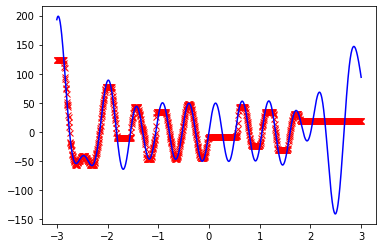

In [11]:
plt.plot(x_test,u_pred,'rx')
plt.plot(x_test,u_true,'b')

In [13]:
a = 0
for i in range(10):
    a = a + test_re_full[i][-1]
print(a/10)

0.6627485249320352
